In [1]:
#!/usr/bin/env python
# coding: utf-8
#
# Author:   Kazuto Nakashima
# URL:      http://kazuto1011.github.io
# Created:  2017-05-26

from collections import Sequence

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

class _BaseWrapper(object):
    def __init__(self, model):
        super(_BaseWrapper, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers
        

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.logits).to(self.device)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        self.image_shape = image.shape[2:]
        self.logits = self.model(image)
        self.probs = F.softmax(self.logits, dim=1)
        return self.probs.sort(dim=1, descending=True)  # ordered results

    def backward(self, ids):
        """
        Class-specific backpropagation
        """
        one_hot = self._encode_one_hot(ids)
        self.model.zero_grad()
        self.logits.backward(gradient=one_hot, retain_graph=True)

    def generate(self):
        raise NotImplementedError

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()


class BackPropagation(_BaseWrapper):
    def forward(self, image):
        self.image = image.requires_grad_()
        return super(BackPropagation, self).forward(self.image)

    def generate(self):
        gradient = self.image.grad.clone()
        self.image.grad.zero_()
        return gradient


class GuidedBackPropagation(BackPropagation):
    """
    "Striving for Simplicity: the All Convolutional Net"
    https://arxiv.org/pdf/1412.6806.pdf
    Look at Figure 1 on page 8.
    """

    def __init__(self, model):
        super(GuidedBackPropagation, self).__init__(model)

        def backward_hook(module, grad_in, grad_out):
            # Cut off negative gradients
            if isinstance(module, nn.ReLU):
                return (F.relu(grad_in[0]),)

        for module in self.model.named_modules():
            self.handlers.append(module[1].register_backward_hook(backward_hook))


class Deconvnet(BackPropagation):
    """
    "Striving for Simplicity: the All Convolutional Net"
    https://arxiv.org/pdf/1412.6806.pdf
    Look at Figure 1 on page 8.
    """

    def __init__(self, model):
        super(Deconvnet, self).__init__(model)

        def backward_hook(module, grad_in, grad_out):
            # Cut off negative gradients and ignore ReLU
            if isinstance(module, nn.ReLU):
                return (F.relu(grad_out[0]),)

        for module in self.model.named_modules():
            self.handlers.append(module[1].register_backward_hook(backward_hook))


class GradCAM(_BaseWrapper):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure 2 on page 4
    """

    def __init__(self, model, candidate_layers=None):
        super(GradCAM, self).__init__(model)
        self.fmap_pool = {}
        self.grad_pool = {}
        self.candidate_layers = candidate_layers  # list

        def save_fmaps(key):
            def forward_hook(module, input, output):
                if key == 'module.sc1' or key == 'module.sc2' or key == 'module.sc3':
                    new_key = [key+'_1',key+'_2',key+'_3']
                    self.fmap_pool[new_key[0]] = output[0].detach()
                    self.fmap_pool[new_key[1]] = output[1].detach()
                    self.fmap_pool[new_key[2]] = output[2].detach()
                else:
                    self.fmap_pool[key] = output.detach()
                '''print(key)
                #print(torch.mean(torch.mean(output)-output[2]))
                print(output[0].shape)
                print(output[1].shape)
                print(output[2].shape)'''

            return forward_hook

        def save_grads(key):
            def backward_hook(module, grad_in, grad_out):
                self.grad_pool[key] = grad_out[0].detach()
                '''print(key)
                print(grad_out[0].shape)
                print(grad_out[0])'''

            return backward_hook

        # If any candidates are not specified, the hook is registered to all the layers.
        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name)))
                self.handlers.append(module.register_backward_hook(save_grads(name)))

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def generate(self, target_layer):
        if target_layer == 'module.sc1' or target_layer == 'module.sc2' or target_layer == 'module.sc3':
            fmaps1 = self._find(self.fmap_pool, target_layer+'_1')
            fmaps2 = self._find(self.fmap_pool, target_layer+'_2')
            fmaps3 = self._find(self.fmap_pool, target_layer+'_3')
            
            grads = self._find(self.grad_pool, target_layer)
            weights = F.adaptive_avg_pool2d(grads, 1)

            gcam = torch.mul(fmaps1, weights).sum(dim=1, keepdim=True)
            gcam = F.relu(gcam)
            gcam = F.interpolate(
                gcam, self.image_shape, mode="bilinear", align_corners=False
            )

            B, C, H, W = gcam.shape
            gcam = gcam.view(B, -1)
            gcam -= gcam.min(dim=1, keepdim=True)[0]
            gcam /= gcam.max(dim=1, keepdim=True)[0]
            gcam1 = gcam.view(B, C, H, W)
            
            gcam = torch.mul(fmaps2, weights).sum(dim=1, keepdim=True)
            gcam = F.relu(gcam)
            gcam = F.interpolate(
                gcam, self.image_shape, mode="bilinear", align_corners=False
            )

            B, C, H, W = gcam.shape
            gcam = gcam.view(B, -1)
            gcam -= gcam.min(dim=1, keepdim=True)[0]
            gcam /= gcam.max(dim=1, keepdim=True)[0]
            gcam2 = gcam.view(B, C, H, W)
            
            gcam = torch.mul(fmaps3, weights).sum(dim=1, keepdim=True)
            gcam = F.relu(gcam)
            gcam = F.interpolate(
                gcam, self.image_shape, mode="bilinear", align_corners=False
            )

            B, C, H, W = gcam.shape
            gcam = gcam.view(B, -1)
            gcam -= gcam.min(dim=1, keepdim=True)[0]
            gcam /= gcam.max(dim=1, keepdim=True)[0]
            gcam3 = gcam.view(B, C, H, W)

            return [gcam1,gcam2,gcam3]
        else:
            fmaps = self._find(self.fmap_pool, target_layer)
            grads = self._find(self.grad_pool, target_layer)
            #print(fmaps.shape)
            weights = F.adaptive_avg_pool2d(grads, 1)

            gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
            gcam = F.relu(gcam)
            gcam = F.interpolate(
                gcam, self.image_shape, mode="bilinear", align_corners=False
            )

            B, C, H, W = gcam.shape
            gcam = gcam.view(B, -1)
            gcam -= gcam.min(dim=1, keepdim=True)[0]
            gcam /= gcam.max(dim=1, keepdim=True)[0]
            gcam = gcam.view(B, C, H, W)

            return gcam


def occlusion_sensitivity(
    model, images, ids, mean=None, patch=35, stride=1, n_batches=128
):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure A5 on page 17
    Originally proposed in:
    "Visualizing and Understanding Convolutional Networks"
    https://arxiv.org/abs/1311.2901
    """

    torch.set_grad_enabled(False)
    model.eval()
    mean = mean if mean else 0
    patch_H, patch_W = patch if isinstance(patch, Sequence) else (patch, patch)
    pad_H, pad_W = patch_H // 2, patch_W // 2

    # Padded image
    images = F.pad(images, (pad_W, pad_W, pad_H, pad_H), value=mean)
    B, _, H, W = images.shape
    new_H = (H - patch_H) // stride + 1
    new_W = (W - patch_W) // stride + 1

    # Prepare sampling grids
    anchors = []
    grid_h = 0
    while grid_h <= H - patch_H:
        grid_w = 0
        while grid_w <= W - patch_W:
            grid_w += stride
            anchors.append((grid_h, grid_w))
        grid_h += stride

    # Baseline score without occlusion
    baseline = model(images).detach().gather(1, ids)

    # Compute per-pixel logits
    scoremaps = []
    for i in tqdm(range(0, len(anchors), n_batches), leave=False):
        batch_images = []
        batch_ids = []
        for grid_h, grid_w in anchors[i : i + n_batches]:
            images_ = images.clone()
            images_[..., grid_h : grid_h + patch_H, grid_w : grid_w + patch_W] = mean
            batch_images.append(images_)
            batch_ids.append(ids)
        batch_images = torch.cat(batch_images, dim=0)
        batch_ids = torch.cat(batch_ids, dim=0)
        scores = model(batch_images).detach().gather(1, batch_ids)
        scoremaps += list(torch.split(scores, B))

    diffmaps = torch.cat(scoremaps, dim=1) - baseline
    diffmaps = diffmaps.view(B, new_H, new_W)

    return diffmaps

In [2]:
!nvidia-smi 

Thu Feb 13 12:23:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 31%   46C    P0    49W / 250W |      0MiB / 11019MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 32%   40C    P0    61W / 250W |      0MiB / 11019MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
!ls

01_CNN.ipynb
LeNet_gradcam_feb5.ipynb
MNIST_DATASET
README.md
SCResNet_hier_eqln_jan27.pt
SCResNet_jan23.pt
SC_CNN_apdilation_gradcam_feb6.ipynb
SC_CNN_gradcam_confusion_2x_augmentation_feb11.ipynb
SC_CNN_gradcam_confusion_2x_feb11.ipynb
SC_CNN_gradcam_confusion_2x_respool_conv_feb12.ipynb
SC_CNN_gradcam_confusion_2x_respool_feb13.ipynb
SC_CNN_gradcam_confusion_feb10.ipynb
SC_CNN_gradcam_confusion_newmean_aug_feb11.ipynb
SC_CNN_gradcam_confusion_newmean_feb11.ipynb
SC_CNN_gradcam_jan28.ipynb
SC_CNN_learnableparam_eqln_gradcam_feb5.ipynb
SC_CNN_learnableparam_gradcam_feb4.ipynb
SC_CNN_v0.ipynb
SC_CNN_v0.py
SC_CNN_v0_deepSC_Ln_jan20.ipynb
SC_CNN_v0_deepSC_Ln_jan21_nl1_test.ipynb
SC_CNN_v0_deepSC__newbn_jan22.ipynb
SC_CNN_v0_deepSC__nobn_jan23.ipynb
SC_CNN_v0_deepSC_biased123_jan23.ipynb
SC_CNN_v0_deepSC_biased321_jan23.ipynb
SC_CNN_v0_deepSC_dilation_jan22.ipynb
SC_CNN_v0_deepSC_dilation_newbn_jan22.ipynb
SC_CNN_v0_deepSC_eqln_jan23.ipynb
SC_CNN_v0_deepSC_eqln_newbn_jan22.ipynb
SC_CNN_v0

In [4]:
DATA_PATH = ''

In [5]:
import os

In [6]:
#!tar -zxvf 'mnist_4x.tar.gz'

In [7]:
INTERNAL_DATA_PATH = 'mnist_4x/'
INTERNAL_DATA_PATH_MAIN = 'mnist_4x/resized'
INTERNAL_DATA_PATH_OTHER = 'mnist_4x/centered'

In [8]:
import os
import fnmatch
 
# Get a list of all files in directory
for rootDir, subdirs, filenames in os.walk(INTERNAL_DATA_PATH):
    # Find the files that matches the given patterm
    for filename in fnmatch.filter(filenames, '.*'):
        try:
            #print(filename)
            os.remove(os.path.join(rootDir, filename))
        except OSError:
            print("Error while deleting file")

In [9]:
from time import sleep
from tqdm import tqdm
for _ in tqdm(range(10)):
    sleep(0.001)

100%|██████████| 10/10 [00:00<00:00, 927.70it/s]


In [10]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np

########################################################################
batch_size = 64
########################################################################


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
class SizedMnistDataset(Dataset):
    def __init__(self,dir_list,transform=None):
        self.dir_list = dir_list
        self.transform = transform
        
        self.dataset_list = []
        for i in range(len(dir_list)):
            temp_dataset = datasets.ImageFolder(root=self.dir_list[i],transform = self.transform)
            self.dataset_list.append(temp_dataset)
        
    def __len__(self):
        return len(self.dataset_list[0])
    
    def __getitem__(self,idx):
        return self.dataset_list[0][idx]#,self.dataset_list[1][idx]
    

In [13]:
new_path = ['mnist_4x/resized']

train_dataset_path = [x+"/training" for x in new_path]
test_dataset_path = [x+"/testing" for x in new_path]
test_dataset_path

['mnist_4x/resized/testing']

In [14]:
#img_size = [729,243,81,27,9]  

transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))])
trainMnistDataset = SizedMnistDataset(train_dataset_path,transform)
testMnistDataset = SizedMnistDataset(test_dataset_path,transform)

trainloader = torch.utils.data.DataLoader(trainMnistDataset,
                                          batch_size = batch_size, 
                                          shuffle=True,
                                         num_workers=8)

testloader = torch.utils.data.DataLoader(testMnistDataset,
                                          batch_size = batch_size, 
                                          shuffle=False,
                                        num_workers=8)


In [15]:
import torch.nn as nn
import torch.nn.functional as F

class SCModule11(nn.Module):
    def __init__(self,in_channels,out_channels,output_number):
        super(SCModule11, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_number = output_number

        self.conv1 = nn.Conv2d(in_channels, out_channels, 8, stride=4, padding=0, bias=False)
        self.conv2 = nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=0, bias=False)
        self.conv3 = nn.Conv2d(in_channels, out_channels, 2, stride=1, padding=0, bias = False)
        
        self.bn1_1 = nn.BatchNorm2d(out_channels)
        
        self.bn2_1 = nn.BatchNorm2d(out_channels)

        self.bn3_1 = nn.BatchNorm2d(out_channels)
        
        self.pad = nn.ConstantPad2d((0,1,0,1),0)
        
    def forward(self, x):
        x_1_3 = self.conv3(x[0])

        x_2_2 = self.conv2(x[0])
        x_2_3 = self.conv3(x[1])

        x_3_1 = self.conv1(x[0])
        x_3_2 = self.conv2(x[1])
        x_3_3 = self.conv3(x[2])
        
        '''print(x_1_3.shape)
        print(x_2_2.shape)
        print(x_2_3.shape)
        print(x_3_1.shape)
        print(x_3_2.shape)
        print(x_3_3.shape)'''
        

        o_1_1 = self.bn1_1(x_1_3)

        o_2_1 = torch.stack([x_2_2,x_2_3])
        o_2_1 = self.bn2_1(torch.sum(o_2_1,0))
        
        o_3_1 = torch.stack([x_3_1,x_3_2,x_3_3])
        o_3_1 = self.bn3_1(torch.sum(o_3_1,0))

        #print(torch.cat([o_1_1,o_1_2,o_1_3],dim=1).size())

        return [self.pad(o_1_1),self.pad(o_2_1),self.pad(o_3_1)]
        

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class SCModule2(nn.Module):
    def __init__(self,in_channels,out_channels,output_number):
        super(SCModule2, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_number = output_number

        self.conv1 = nn.Conv2d(in_channels, out_channels, 8, stride=8, bias=False)
        self.conv2 = nn.Conv2d(in_channels, out_channels, 4, stride=4, bias=False)
        self.conv3 = nn.Conv2d(in_channels, out_channels, 2, stride=2, bias=False)
        
        self.bn4 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x_1_1 = self.conv1(x[0]) 
        x_1_2 = self.conv2(x[1]) 
        x_1_3 = self.conv3(x[2]) 
        #return [x_1_1,x_1_2,x_1_3]
        x_1 = torch.stack([x_1_1,x_1_2,x_1_3])
        x_1 = torch.sum(x_1,0)
        #print(x_1.size())
        #x_1 = torch.cat([x_1_1,x_1_2],dim=1)
        return self.bn4(x_1)
        
            
        '''outputs = []
        for i in range(self.output_number):
            x_1_1 = self.conv1(x[0+i]) 
            x_1_2 = self.conv2(x[1+i]) 
            x_1_3 = self.conv3(x[2+i]) 
            #return [x_1_1,x_1_2,x_1_3]
            x_1 = torch.stack([x_1_1,x_1_2,x_1_3])
            x_1 = torch.sum(x_1,0)
            #print(x_1.size())
            #x_1 = torch.cat([x_1_1,x_1_2],dim=1)
            outputs.append(x_1)
        return outputs'''
    

    
#model = SCModule(3,6,3)

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class ResPoolModule(nn.Module):
    def __init__(self,in_channels):
        super(ResPoolModule, self).__init__()
        self.in_channels = in_channels

        self.bigpool = nn.MaxPool2d(8,stride=8)
        self.midpool = nn.MaxPool2d(4,stride=4)
        self.smlpool = nn.MaxPool2d(2,stride=2)
        
        #self.mrgpool = nn.MaxPool1d(3)
        
        self.bn4 = nn.BatchNorm2d(in_channels)
        
    def forward(self, x):
        x_1_1 = self.bigpool(x[0]) 
        x_1_2 = self.midpool(x[1]) 
        x_1_3 = self.smlpool(x[2]) 
        #return [x_1_1,x_1_2,x_1_3]
        x_1 = torch.stack([x_1_1,x_1_2,x_1_3])
        #print(x_1.size())
        #x_1 = torch.sum(x_1,0)
        x_1 = torch.max(x_1,0)[0]
        #print(x_1)
        #print(x_1.size())
        #x_1 = torch.cat([x_1_1,x_1_2],dim=1)
        return self.bn4(x_1)

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self,batch_size):
        super(Net, self).__init__()
        
        self.prepool1 = nn.AvgPool2d(2,2)
        self.prepool2 = nn.AvgPool2d(4,4)
        
        self.sc1 = SCModule11(3,6,3)
        self.sc2 = SCModule11(6,18,3)
        self.sc3 = SCModule11(18,30,3)
        self.rp1 = ResPoolModule(30)
        
        self.fc1 = nn.Linear(30*14*14,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
        #tensor = torch.tensor((), dtype=torch.float)
 
        #self.pad1 = tensor.new_zeros((batch_size,510,243,243))#.to('cuda')
        #self.pad2 = tensor.new_zeros((batch_size,510,81,81))#.to('cuda')


    def forward(self, x):
        
        i1 = x
        i2 = self.prepool1(x)
        i3 = self.prepool2(x)
        
        '''print(i1.size())
        print(i2.size())
        print(i3.size())'''
        
        x1_1,x1_2,x1_3 = self.sc1([i1,i2,i3])
        #x1_2,x1_3 = self.sc1([i2,i3,i4,i5])
        x1_1 = F.relu(x1_1)
        x1_2 = F.relu(x1_2)
        x1_3 = F.relu(x1_3)
        
        '''print(x1_1.size())
        print(x1_2.size())
        print(x1_3.size())'''

        x2_1,x2_2,x2_3 = self.sc2([x1_1,x1_2,x1_3])
        x2_1 = F.relu(x2_1)
        x2_2 = F.relu(x2_2)
        x2_3 = F.relu(x2_3)
        
        x3_1,x3_2,x3_3 = self.sc3([x2_1,x2_2,x2_3])
        x3_1 = F.relu(x3_1)
        x3_2 = F.relu(x3_2)
        x3_3 = F.relu(x3_3)
        
        '''print(x2_1.size())
        print(x2_2.size())
        print(x2_3.size())
        
        print(x3_1.size())
        print(x3_2.size())
        print(x3_3.size())'''

        x3 = self.rp1([x3_1,x3_2,x3_3])
        x3 = F.relu(x3)
        
        #print(x3.size())
        
        #print(x2.size())
        
        #print(x2_1.size())
        
        #print(x3.size())
        
        x2 = x3.view(-1, 30* 14 * 14)
        x2 = F.relu(self.fc1(x2))
        x2 = F.relu(self.fc2(x2))
        x2 = self.fc3(x2)
        #print(x4.shape)
        return x2

In [19]:
from parallel import DataParallelModel,DataParallelCriterion
from torch.nn.parallel.data_parallel import DataParallel
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_ids = [0,1]
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '29500'
dist.init_process_group(backend='nccl',rank=0,world_size=1)

In [20]:
model1 = Net(batch_size).to('cuda:0')
if torch.cuda.device_count() > 1:
    model1 = DDP(model1,device_ids = [0])
    
'''model2 = Net(batch_size).to('cuda:0')
if torch.cuda.device_count() > 1:
    model2 = DDP(model2,device_ids = [0])'''
#model.to(device)

"model2 = Net(batch_size).to('cuda:0')\nif torch.cuda.device_count() > 1:\n    model2 = DDP(model2,device_ids = [0])"

In [21]:
print(device)

cuda


In [22]:
import torch.optim as optim

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)

In [23]:
'''SIZED_VAL_PATH = 'sized_val'
new_path = []
for i in os.listdir('mnist_sized'):
    #print(i)
    temp = []
    for j in range(1,4):
        temp.append(os.path.join(SIZED_VAL_PATH,str(i),'ds'+str(j)))
    new_path.append(temp)

new_path.sort(key=lambda x:int(x[0].split('/')[1]))

val_gen_arr = []
for i in tqdm(range(0,len(new_path))):
    transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))])

    testMnistDataset = SizedMnistDataset(new_path[i],transform)

    testloader = torch.utils.data.DataLoader(testMnistDataset,
                                              batch_size = batch_size, 
                                              shuffle=False,
                                            num_workers=8)
    val_gen_arr.append(testloader)
#
#val_gen_arr
accuracy = []'''


"SIZED_VAL_PATH = 'sized_val'\nnew_path = []\nfor i in os.listdir('mnist_sized'):\n    #print(i)\n    temp = []\n    for j in range(1,4):\n        temp.append(os.path.join(SIZED_VAL_PATH,str(i),'ds'+str(j)))\n    new_path.append(temp)\n\nnew_path.sort(key=lambda x:int(x[0].split('/')[1]))\n\nval_gen_arr = []\nfor i in tqdm(range(0,len(new_path))):\n    transform = transforms.Compose(\n        [\n        transforms.ToTensor(),\n        transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))])\n\n    testMnistDataset = SizedMnistDataset(new_path[i],transform)\n\n    testloader = torch.utils.data.DataLoader(testMnistDataset,\n                                              batch_size = batch_size, \n                                              shuffle=False,\n                                            num_workers=8)\n    val_gen_arr.append(testloader)\n#\n#val_gen_arr\naccuracy = []"

In [22]:
import os


SIZED_VAL_PATH = 'mnist_sized'
new_path = []
for i in range(1,113):
    new_path.append([os.path.join(SIZED_VAL_PATH,str(i))])

#new_path.sort(key=lambda x:int(x[0].split('/')[1]))

val_gen_arr = []
for i in tqdm(range(0,len(new_path))):
    transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))])

    testMnistDataset = SizedMnistDataset(new_path[i],transform)

    testloader = torch.utils.data.DataLoader(testMnistDataset,
                                              batch_size = batch_size, 
                                              shuffle=False,
                                            num_workers=8)
    val_gen_arr.append(testloader)
#
#val_gen_arr
accuracy = []

100%|██████████| 112/112 [00:00<00:00, 329.80it/s]


In [25]:
#new_path

In [26]:
import torch.optim as optim
from tqdm import tqdm
import sys

trn_loss_list = []
val_loss_list = []
acc_list = []
num_batches = len(trainloader)
for epoch in range(20):
    running_loss = 0.0
    model1.train()
    device = 'cuda:0'
    for i,images in tqdm(enumerate(trainloader)):
        #data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        c1 = images[0].to(device)
        c6 = images[1].to(device)
        #c61 = c6[:128].to('cuda:0')
        #c62 = c6[128:].to('cuda:1')
        output = model1(c1)
        #output = torch.nn.parallel.gather(output,'cuda:1')
        loss = criterion(output, c6)
        loss.backward()    # calc gradients
        optimizer.step()   # update gradients
        running_loss += loss.item()
        #print(i)
    
    model1.eval()
    with torch.no_grad(): # very very very very important!!!
        val_loss = 0.0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        correct = 0
        total = 0
        for j,val in enumerate(testloader):
            v1 = val[0].to(device)
            val_labels = val[1].to(device)
            val_output = model1(v1)
            v_loss = criterion(val_output, val_labels)
            val_loss += v_loss
            _, predicted = torch.max(val_output, 1)
            c = (predicted == val_labels).squeeze()
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
            for i in range(len(val_labels)):
                val_label = val_labels[i]
                class_correct[val_label] += c[i].item()
                class_total[val_label] += 1

        for i in range(10):
            if class_total[i]==0:
                print('class_total = 0',class_correct,class_total)
            else:
                print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

    print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
        epoch+1, 30, i+1, num_batches, running_loss / len(trainloader), val_loss / len(testloader)
    ))        
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

    trn_loss_list.append(running_loss/1875)
    val_loss_list.append(val_loss/len(testloader))
    running_loss = 0.0
    
    temp_acc = []
    for testloader in tqdm(val_gen_arr):
        correct = 0
        total = 0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        with torch.no_grad():
            for images in testloader:
                c1 = images[0].to(device)
                val_labels = images[1].to(device)
                outputs = model1(c1)
                _, predicted = torch.max(outputs.data, 1)
                c = (predicted == val_labels).squeeze()
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum().item()
        #print(total,correct,end='')

        print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
        temp_acc.append(100 * correct / total)
    acc_list.append(temp_acc)
    
    import csv

    csvfile = open('testresult_confusion_2x_respool_20_feb13.csv','w',newline="")

    csvwriter = csv.writer(csvfile)
    for row in acc_list:
        csvwriter.writerow(row)

    csvfile.close()
    
    torch.save(model1.state_dict(),'confusion_2x_respool_20_feb13.pt')
    
    if epoch == 9:
        optimizer = optim.Adam(model1.parameters(), lr=0.0001)
        print('lr is changed to 0.0001')
        
    #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)'''
    

938it [00:34, 26.96it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 98 %
Accuracy of     8 : 98 %
Accuracy of     9 : 98 %
epoch: 1/30 | step: 10/938 | trn loss: 0.1296 | val loss: 0.0345
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:10,  1.58it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:09,  1.58it/s]

Accuracy of the network on the 10000 test images: 11 %


  3%|▎         | 3/112 [00:01<01:08,  1.59it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:08,  1.58it/s]

Accuracy of the network on the 10000 test images: 11 %


  4%|▍         | 5/112 [00:03<01:08,  1.56it/s]

Accuracy of the network on the 10000 test images: 13 %


  5%|▌         | 6/112 [00:03<01:06,  1.59it/s]

Accuracy of the network on the 10000 test images: 16 %


  6%|▋         | 7/112 [00:04<01:07,  1.57it/s]

Accuracy of the network on the 10000 test images: 13 %


  7%|▋         | 8/112 [00:05<01:06,  1.55it/s]

Accuracy of the network on the 10000 test images: 9 %


  8%|▊         | 9/112 [00:05<01:05,  1.56it/s]

Accuracy of the network on the 10000 test images: 9 %


  9%|▉         | 10/112 [00:06<01:05,  1.57it/s]

Accuracy of the network on the 10000 test images: 13 %


 10%|▉         | 11/112 [00:06<01:04,  1.58it/s]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:07<01:03,  1.58it/s]

Accuracy of the network on the 10000 test images: 12 %


 12%|█▏        | 13/112 [00:08<01:03,  1.56it/s]

Accuracy of the network on the 10000 test images: 8 %


 12%|█▎        | 14/112 [00:08<01:02,  1.56it/s]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:09<01:01,  1.57it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:10<01:01,  1.57it/s]

Accuracy of the network on the 10000 test images: 12 %


 15%|█▌        | 17/112 [00:10<01:00,  1.57it/s]

Accuracy of the network on the 10000 test images: 12 %


 16%|█▌        | 18/112 [00:11<00:59,  1.57it/s]

Accuracy of the network on the 10000 test images: 13 %


 17%|█▋        | 19/112 [00:12<00:58,  1.58it/s]

Accuracy of the network on the 10000 test images: 11 %


 18%|█▊        | 20/112 [00:12<00:58,  1.57it/s]

Accuracy of the network on the 10000 test images: 12 %


 19%|█▉        | 21/112 [00:13<00:58,  1.57it/s]

Accuracy of the network on the 10000 test images: 12 %


 20%|█▉        | 22/112 [00:13<00:56,  1.59it/s]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:14<00:56,  1.58it/s]

Accuracy of the network on the 10000 test images: 12 %


 21%|██▏       | 24/112 [00:15<00:55,  1.57it/s]

Accuracy of the network on the 10000 test images: 12 %


 22%|██▏       | 25/112 [00:15<00:55,  1.57it/s]

Accuracy of the network on the 10000 test images: 13 %


 23%|██▎       | 26/112 [00:16<00:54,  1.58it/s]

Accuracy of the network on the 10000 test images: 14 %


 24%|██▍       | 27/112 [00:17<00:53,  1.59it/s]

Accuracy of the network on the 10000 test images: 11 %


 25%|██▌       | 28/112 [00:17<00:55,  1.51it/s]

Accuracy of the network on the 10000 test images: 11 %


 26%|██▌       | 29/112 [00:18<00:55,  1.50it/s]

Accuracy of the network on the 10000 test images: 14 %


 27%|██▋       | 30/112 [00:19<00:53,  1.53it/s]

Accuracy of the network on the 10000 test images: 15 %


 28%|██▊       | 31/112 [00:19<00:52,  1.55it/s]

Accuracy of the network on the 10000 test images: 16 %


 29%|██▊       | 32/112 [00:20<00:51,  1.56it/s]

Accuracy of the network on the 10000 test images: 17 %


 29%|██▉       | 33/112 [00:21<00:51,  1.55it/s]

Accuracy of the network on the 10000 test images: 17 %


 30%|███       | 34/112 [00:21<00:50,  1.55it/s]

Accuracy of the network on the 10000 test images: 17 %


 31%|███▏      | 35/112 [00:22<00:49,  1.55it/s]

Accuracy of the network on the 10000 test images: 17 %


 32%|███▏      | 36/112 [00:23<00:49,  1.55it/s]

Accuracy of the network on the 10000 test images: 17 %


 33%|███▎      | 37/112 [00:23<00:48,  1.56it/s]

Accuracy of the network on the 10000 test images: 17 %


 34%|███▍      | 38/112 [00:24<00:47,  1.57it/s]

Accuracy of the network on the 10000 test images: 19 %


 35%|███▍      | 39/112 [00:24<00:46,  1.58it/s]

Accuracy of the network on the 10000 test images: 19 %


 36%|███▌      | 40/112 [00:25<00:45,  1.59it/s]

Accuracy of the network on the 10000 test images: 19 %


 37%|███▋      | 41/112 [00:26<00:44,  1.60it/s]

Accuracy of the network on the 10000 test images: 21 %


 38%|███▊      | 42/112 [00:26<00:45,  1.55it/s]

Accuracy of the network on the 10000 test images: 21 %


 38%|███▊      | 43/112 [00:27<00:44,  1.56it/s]

Accuracy of the network on the 10000 test images: 23 %


 39%|███▉      | 44/112 [00:28<00:43,  1.56it/s]

Accuracy of the network on the 10000 test images: 22 %


 40%|████      | 45/112 [00:28<00:45,  1.48it/s]

Accuracy of the network on the 10000 test images: 24 %


 41%|████      | 46/112 [00:29<00:43,  1.51it/s]

Accuracy of the network on the 10000 test images: 26 %


 42%|████▏     | 47/112 [00:30<00:42,  1.53it/s]

Accuracy of the network on the 10000 test images: 27 %


 43%|████▎     | 48/112 [00:30<00:41,  1.55it/s]

Accuracy of the network on the 10000 test images: 29 %


 44%|████▍     | 49/112 [00:31<00:40,  1.56it/s]

Accuracy of the network on the 10000 test images: 30 %


 45%|████▍     | 50/112 [00:32<00:39,  1.55it/s]

Accuracy of the network on the 10000 test images: 32 %


 46%|████▌     | 51/112 [00:32<00:39,  1.56it/s]

Accuracy of the network on the 10000 test images: 32 %


 46%|████▋     | 52/112 [00:33<00:38,  1.57it/s]

Accuracy of the network on the 10000 test images: 34 %


 47%|████▋     | 53/112 [00:33<00:37,  1.58it/s]

Accuracy of the network on the 10000 test images: 36 %


 48%|████▊     | 54/112 [00:34<00:36,  1.57it/s]

Accuracy of the network on the 10000 test images: 38 %


 49%|████▉     | 55/112 [00:35<00:35,  1.58it/s]

Accuracy of the network on the 10000 test images: 39 %


 50%|█████     | 56/112 [00:35<00:35,  1.59it/s]

Accuracy of the network on the 10000 test images: 43 %


 51%|█████     | 57/112 [00:36<00:36,  1.50it/s]

Accuracy of the network on the 10000 test images: 42 %


 52%|█████▏    | 58/112 [00:37<00:35,  1.52it/s]

Accuracy of the network on the 10000 test images: 47 %


 53%|█████▎    | 59/112 [00:37<00:34,  1.52it/s]

Accuracy of the network on the 10000 test images: 47 %


 54%|█████▎    | 60/112 [00:38<00:33,  1.54it/s]

Accuracy of the network on the 10000 test images: 50 %


 54%|█████▍    | 61/112 [00:39<00:35,  1.45it/s]

Accuracy of the network on the 10000 test images: 48 %


 55%|█████▌    | 62/112 [00:39<00:33,  1.47it/s]

Accuracy of the network on the 10000 test images: 55 %


 56%|█████▋    | 63/112 [00:40<00:32,  1.51it/s]

Accuracy of the network on the 10000 test images: 53 %


 57%|█████▋    | 64/112 [00:41<00:31,  1.52it/s]

Accuracy of the network on the 10000 test images: 59 %


 58%|█████▊    | 65/112 [00:41<00:30,  1.56it/s]

Accuracy of the network on the 10000 test images: 57 %


 59%|█████▉    | 66/112 [00:42<00:29,  1.56it/s]

Accuracy of the network on the 10000 test images: 64 %


 60%|█████▉    | 67/112 [00:43<00:28,  1.58it/s]

Accuracy of the network on the 10000 test images: 61 %


 61%|██████    | 68/112 [00:43<00:27,  1.59it/s]

Accuracy of the network on the 10000 test images: 66 %


 62%|██████▏   | 69/112 [00:44<00:28,  1.50it/s]

Accuracy of the network on the 10000 test images: 65 %


 62%|██████▎   | 70/112 [00:45<00:27,  1.52it/s]

Accuracy of the network on the 10000 test images: 72 %


 63%|██████▎   | 71/112 [00:45<00:26,  1.54it/s]

Accuracy of the network on the 10000 test images: 70 %


 64%|██████▍   | 72/112 [00:46<00:26,  1.54it/s]

Accuracy of the network on the 10000 test images: 75 %


 65%|██████▌   | 73/112 [00:46<00:25,  1.55it/s]

Accuracy of the network on the 10000 test images: 73 %


 66%|██████▌   | 74/112 [00:47<00:24,  1.54it/s]

Accuracy of the network on the 10000 test images: 78 %


 67%|██████▋   | 75/112 [00:48<00:23,  1.56it/s]

Accuracy of the network on the 10000 test images: 76 %


 68%|██████▊   | 76/112 [00:48<00:23,  1.56it/s]

Accuracy of the network on the 10000 test images: 81 %


 69%|██████▉   | 77/112 [00:49<00:22,  1.55it/s]

Accuracy of the network on the 10000 test images: 80 %


 70%|██████▉   | 78/112 [00:50<00:21,  1.55it/s]

Accuracy of the network on the 10000 test images: 84 %


 71%|███████   | 79/112 [00:50<00:21,  1.57it/s]

Accuracy of the network on the 10000 test images: 83 %


 71%|███████▏  | 80/112 [00:51<00:20,  1.57it/s]

Accuracy of the network on the 10000 test images: 87 %


 72%|███████▏  | 81/112 [00:52<00:19,  1.58it/s]

Accuracy of the network on the 10000 test images: 86 %


 73%|███████▎  | 82/112 [00:52<00:19,  1.57it/s]

Accuracy of the network on the 10000 test images: 90 %


 74%|███████▍  | 83/112 [00:53<00:18,  1.56it/s]

Accuracy of the network on the 10000 test images: 89 %


 75%|███████▌  | 84/112 [00:54<00:17,  1.57it/s]

Accuracy of the network on the 10000 test images: 92 %


 76%|███████▌  | 85/112 [00:54<00:17,  1.57it/s]

Accuracy of the network on the 10000 test images: 91 %


 77%|███████▋  | 86/112 [00:55<00:16,  1.57it/s]

Accuracy of the network on the 10000 test images: 93 %


 78%|███████▊  | 87/112 [00:55<00:15,  1.58it/s]

Accuracy of the network on the 10000 test images: 93 %


 79%|███████▊  | 88/112 [00:56<00:15,  1.50it/s]

Accuracy of the network on the 10000 test images: 94 %


 79%|███████▉  | 89/112 [00:57<00:15,  1.47it/s]

Accuracy of the network on the 10000 test images: 94 %


 80%|████████  | 90/112 [00:58<00:15,  1.44it/s]

Accuracy of the network on the 10000 test images: 95 %


 81%|████████▏ | 91/112 [00:58<00:14,  1.50it/s]

Accuracy of the network on the 10000 test images: 95 %


 82%|████████▏ | 92/112 [00:59<00:12,  1.54it/s]

Accuracy of the network on the 10000 test images: 96 %


 83%|████████▎ | 93/112 [00:59<00:12,  1.54it/s]

Accuracy of the network on the 10000 test images: 96 %


 84%|████████▍ | 94/112 [01:00<00:12,  1.49it/s]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [01:01<00:11,  1.51it/s]

Accuracy of the network on the 10000 test images: 96 %


 86%|████████▌ | 96/112 [01:01<00:10,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [01:02<00:09,  1.52it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [01:03<00:09,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [01:03<00:08,  1.58it/s]

Accuracy of the network on the 10000 test images: 97 %


 89%|████████▉ | 100/112 [01:04<00:07,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [01:05<00:07,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [01:05<00:06,  1.59it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [01:06<00:05,  1.59it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:07<00:05,  1.59it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:07<00:04,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:08<00:03,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:08<00:03,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:09<00:02,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:10<00:01,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:10<00:01,  1.56it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:11<00:00,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:12<00:00,  1.55it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:34, 26.97it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 98 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 96 %
Accuracy of     9 : 96 %
epoch: 2/30 | step: 10/938 | trn loss: 0.0449 | val loss: 0.0431
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:00<01:06,  1.68it/s]

Accuracy of the network on the 10000 test images: 8 %


  2%|▏         | 2/112 [00:01<01:06,  1.66it/s]

Accuracy of the network on the 10000 test images: 14 %


  3%|▎         | 3/112 [00:01<01:07,  1.62it/s]

Accuracy of the network on the 10000 test images: 9 %


  4%|▎         | 4/112 [00:02<01:07,  1.61it/s]

Accuracy of the network on the 10000 test images: 15 %


  4%|▍         | 5/112 [00:03<01:06,  1.60it/s]

Accuracy of the network on the 10000 test images: 16 %


  5%|▌         | 6/112 [00:03<01:06,  1.59it/s]

Accuracy of the network on the 10000 test images: 13 %


  6%|▋         | 7/112 [00:04<01:06,  1.58it/s]

Accuracy of the network on the 10000 test images: 16 %


  7%|▋         | 8/112 [00:05<01:05,  1.59it/s]

Accuracy of the network on the 10000 test images: 17 %


  8%|▊         | 9/112 [00:05<01:04,  1.60it/s]

Accuracy of the network on the 10000 test images: 17 %


  9%|▉         | 10/112 [00:06<01:03,  1.60it/s]

Accuracy of the network on the 10000 test images: 16 %


 10%|▉         | 11/112 [00:06<01:03,  1.58it/s]

Accuracy of the network on the 10000 test images: 16 %


 11%|█         | 12/112 [00:07<01:03,  1.58it/s]

Accuracy of the network on the 10000 test images: 15 %


 12%|█▏        | 13/112 [00:08<01:02,  1.59it/s]

Accuracy of the network on the 10000 test images: 13 %


 12%|█▎        | 14/112 [00:08<01:01,  1.60it/s]

Accuracy of the network on the 10000 test images: 14 %


 13%|█▎        | 15/112 [00:09<01:00,  1.59it/s]

Accuracy of the network on the 10000 test images: 11 %


 14%|█▍        | 16/112 [00:10<01:01,  1.57it/s]

Accuracy of the network on the 10000 test images: 12 %


 15%|█▌        | 17/112 [00:10<01:01,  1.55it/s]

Accuracy of the network on the 10000 test images: 11 %


 16%|█▌        | 18/112 [00:11<01:00,  1.56it/s]

Accuracy of the network on the 10000 test images: 12 %


 17%|█▋        | 19/112 [00:12<00:59,  1.57it/s]

Accuracy of the network on the 10000 test images: 11 %


 18%|█▊        | 20/112 [00:12<00:58,  1.57it/s]

Accuracy of the network on the 10000 test images: 11 %


 19%|█▉        | 21/112 [00:13<00:58,  1.55it/s]

Accuracy of the network on the 10000 test images: 11 %


 20%|█▉        | 22/112 [00:13<00:57,  1.55it/s]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:14<00:56,  1.56it/s]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:15<00:55,  1.57it/s]

Accuracy of the network on the 10000 test images: 12 %


 22%|██▏       | 25/112 [00:15<00:57,  1.50it/s]

Accuracy of the network on the 10000 test images: 12 %


 23%|██▎       | 26/112 [00:16<00:58,  1.47it/s]

Accuracy of the network on the 10000 test images: 15 %


 24%|██▍       | 27/112 [00:17<00:56,  1.52it/s]

Accuracy of the network on the 10000 test images: 13 %


 25%|██▌       | 28/112 [00:17<00:54,  1.54it/s]

Accuracy of the network on the 10000 test images: 11 %


 26%|██▌       | 29/112 [00:18<00:53,  1.55it/s]

Accuracy of the network on the 10000 test images: 14 %


 27%|██▋       | 30/112 [00:19<00:52,  1.57it/s]

Accuracy of the network on the 10000 test images: 16 %


 28%|██▊       | 31/112 [00:19<00:50,  1.59it/s]

Accuracy of the network on the 10000 test images: 17 %


 29%|██▊       | 32/112 [00:20<00:50,  1.59it/s]

Accuracy of the network on the 10000 test images: 18 %


 29%|██▉       | 33/112 [00:21<00:50,  1.58it/s]

Accuracy of the network on the 10000 test images: 17 %


 30%|███       | 34/112 [00:21<00:50,  1.53it/s]

Accuracy of the network on the 10000 test images: 18 %


 31%|███▏      | 35/112 [00:22<00:49,  1.56it/s]

Accuracy of the network on the 10000 test images: 18 %


 32%|███▏      | 36/112 [00:22<00:47,  1.58it/s]

Accuracy of the network on the 10000 test images: 18 %


 33%|███▎      | 37/112 [00:23<00:50,  1.50it/s]

Accuracy of the network on the 10000 test images: 18 %


 34%|███▍      | 38/112 [00:24<00:48,  1.53it/s]

Accuracy of the network on the 10000 test images: 19 %


 35%|███▍      | 39/112 [00:24<00:47,  1.55it/s]

Accuracy of the network on the 10000 test images: 18 %


 36%|███▌      | 40/112 [00:25<00:45,  1.57it/s]

Accuracy of the network on the 10000 test images: 18 %


 37%|███▋      | 41/112 [00:26<00:44,  1.59it/s]

Accuracy of the network on the 10000 test images: 18 %


 38%|███▊      | 42/112 [00:26<00:44,  1.58it/s]

Accuracy of the network on the 10000 test images: 18 %


 38%|███▊      | 43/112 [00:27<00:43,  1.58it/s]

Accuracy of the network on the 10000 test images: 18 %


 39%|███▉      | 44/112 [00:28<00:43,  1.57it/s]

Accuracy of the network on the 10000 test images: 19 %


 40%|████      | 45/112 [00:28<00:42,  1.57it/s]

Accuracy of the network on the 10000 test images: 19 %


 41%|████      | 46/112 [00:29<00:42,  1.56it/s]

Accuracy of the network on the 10000 test images: 20 %


 42%|████▏     | 47/112 [00:30<00:41,  1.55it/s]

Accuracy of the network on the 10000 test images: 20 %


 43%|████▎     | 48/112 [00:30<00:40,  1.56it/s]

Accuracy of the network on the 10000 test images: 21 %


 44%|████▍     | 49/112 [00:31<00:39,  1.58it/s]

Accuracy of the network on the 10000 test images: 22 %


 45%|████▍     | 50/112 [00:31<00:39,  1.56it/s]

Accuracy of the network on the 10000 test images: 23 %


 46%|████▌     | 51/112 [00:32<00:38,  1.57it/s]

Accuracy of the network on the 10000 test images: 23 %


 46%|████▋     | 52/112 [00:33<00:38,  1.56it/s]

Accuracy of the network on the 10000 test images: 25 %


 47%|████▋     | 53/112 [00:33<00:37,  1.56it/s]

Accuracy of the network on the 10000 test images: 26 %


 48%|████▊     | 54/112 [00:34<00:36,  1.58it/s]

Accuracy of the network on the 10000 test images: 28 %


 49%|████▉     | 55/112 [00:35<00:35,  1.59it/s]

Accuracy of the network on the 10000 test images: 31 %


 50%|█████     | 56/112 [00:35<00:34,  1.61it/s]

Accuracy of the network on the 10000 test images: 35 %


 51%|█████     | 57/112 [00:36<00:34,  1.59it/s]

Accuracy of the network on the 10000 test images: 35 %


 52%|█████▏    | 58/112 [00:36<00:34,  1.58it/s]

Accuracy of the network on the 10000 test images: 37 %


 53%|█████▎    | 59/112 [00:37<00:33,  1.56it/s]

Accuracy of the network on the 10000 test images: 36 %


 54%|█████▎    | 60/112 [00:38<00:33,  1.55it/s]

Accuracy of the network on the 10000 test images: 40 %


 54%|█████▍    | 61/112 [00:38<00:32,  1.55it/s]

Accuracy of the network on the 10000 test images: 38 %


 55%|█████▌    | 62/112 [00:39<00:32,  1.55it/s]

Accuracy of the network on the 10000 test images: 42 %


 56%|█████▋    | 63/112 [00:40<00:31,  1.55it/s]

Accuracy of the network on the 10000 test images: 42 %


 57%|█████▋    | 64/112 [00:40<00:31,  1.55it/s]

Accuracy of the network on the 10000 test images: 48 %


 58%|█████▊    | 65/112 [00:41<00:29,  1.58it/s]

Accuracy of the network on the 10000 test images: 46 %


 59%|█████▉    | 66/112 [00:42<00:28,  1.60it/s]

Accuracy of the network on the 10000 test images: 54 %


 60%|█████▉    | 67/112 [00:42<00:29,  1.52it/s]

Accuracy of the network on the 10000 test images: 51 %


 61%|██████    | 68/112 [00:43<00:28,  1.54it/s]

Accuracy of the network on the 10000 test images: 57 %


 62%|██████▏   | 69/112 [00:44<00:27,  1.56it/s]

Accuracy of the network on the 10000 test images: 58 %


 62%|██████▎   | 70/112 [00:44<00:26,  1.57it/s]

Accuracy of the network on the 10000 test images: 63 %


 63%|██████▎   | 71/112 [00:45<00:25,  1.59it/s]

Accuracy of the network on the 10000 test images: 61 %


 64%|██████▍   | 72/112 [00:45<00:25,  1.59it/s]

Accuracy of the network on the 10000 test images: 68 %


 65%|██████▌   | 73/112 [00:46<00:24,  1.59it/s]

Accuracy of the network on the 10000 test images: 67 %


 66%|██████▌   | 74/112 [00:47<00:23,  1.59it/s]

Accuracy of the network on the 10000 test images: 73 %


 67%|██████▋   | 75/112 [00:47<00:23,  1.60it/s]

Accuracy of the network on the 10000 test images: 71 %


 68%|██████▊   | 76/112 [00:48<00:22,  1.59it/s]

Accuracy of the network on the 10000 test images: 78 %


 69%|██████▉   | 77/112 [00:49<00:22,  1.58it/s]

Accuracy of the network on the 10000 test images: 77 %


 70%|██████▉   | 78/112 [00:49<00:21,  1.59it/s]

Accuracy of the network on the 10000 test images: 82 %


 71%|███████   | 79/112 [00:50<00:20,  1.58it/s]

Accuracy of the network on the 10000 test images: 80 %


 71%|███████▏  | 80/112 [00:51<00:20,  1.58it/s]

Accuracy of the network on the 10000 test images: 86 %


 72%|███████▏  | 81/112 [00:51<00:19,  1.57it/s]

Accuracy of the network on the 10000 test images: 85 %


 73%|███████▎  | 82/112 [00:52<00:18,  1.58it/s]

Accuracy of the network on the 10000 test images: 87 %


 74%|███████▍  | 83/112 [00:52<00:18,  1.57it/s]

Accuracy of the network on the 10000 test images: 87 %


 75%|███████▌  | 84/112 [00:53<00:17,  1.57it/s]

Accuracy of the network on the 10000 test images: 87 %


 76%|███████▌  | 85/112 [00:54<00:17,  1.57it/s]

Accuracy of the network on the 10000 test images: 88 %


 77%|███████▋  | 86/112 [00:54<00:16,  1.57it/s]

Accuracy of the network on the 10000 test images: 92 %


 78%|███████▊  | 87/112 [00:55<00:16,  1.55it/s]

Accuracy of the network on the 10000 test images: 91 %


 79%|███████▊  | 88/112 [00:56<00:15,  1.57it/s]

Accuracy of the network on the 10000 test images: 94 %


 79%|███████▉  | 89/112 [00:56<00:14,  1.56it/s]

Accuracy of the network on the 10000 test images: 93 %


 80%|████████  | 90/112 [00:57<00:14,  1.57it/s]

Accuracy of the network on the 10000 test images: 95 %


 81%|████████▏ | 91/112 [00:58<00:13,  1.57it/s]

Accuracy of the network on the 10000 test images: 95 %


 82%|████████▏ | 92/112 [00:58<00:12,  1.56it/s]

Accuracy of the network on the 10000 test images: 96 %


 83%|████████▎ | 93/112 [00:59<00:12,  1.55it/s]

Accuracy of the network on the 10000 test images: 96 %


 84%|████████▍ | 94/112 [00:59<00:11,  1.58it/s]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [01:00<00:10,  1.56it/s]

Accuracy of the network on the 10000 test images: 96 %


 86%|████████▌ | 96/112 [01:01<00:10,  1.57it/s]

Accuracy of the network on the 10000 test images: 97 %


 87%|████████▋ | 97/112 [01:01<00:09,  1.51it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [01:02<00:09,  1.55it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 99/112 [01:03<00:08,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 89%|████████▉ | 100/112 [01:03<00:07,  1.59it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [01:04<00:06,  1.59it/s]

Accuracy of the network on the 10000 test images: 97 %


 91%|█████████ | 102/112 [01:05<00:06,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [01:05<00:05,  1.59it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:06<00:05,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:06<00:04,  1.59it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:07<00:03,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:08<00:03,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:08<00:02,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:09<00:01,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:10<00:01,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [01:10<00:00,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %



938it [00:34, 27.09it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 98 %
Accuracy of     7 : 100 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %
epoch: 3/30 | step: 10/938 | trn loss: 0.0289 | val loss: 0.0355
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:00<01:10,  1.57it/s]

Accuracy of the network on the 10000 test images: 6 %


  2%|▏         | 2/112 [00:01<01:10,  1.55it/s]

Accuracy of the network on the 10000 test images: 12 %


  3%|▎         | 3/112 [00:01<01:09,  1.57it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:08,  1.58it/s]

Accuracy of the network on the 10000 test images: 14 %


  4%|▍         | 5/112 [00:03<01:07,  1.59it/s]

Accuracy of the network on the 10000 test images: 16 %


  5%|▌         | 6/112 [00:03<01:06,  1.59it/s]

Accuracy of the network on the 10000 test images: 16 %


  6%|▋         | 7/112 [00:04<01:05,  1.59it/s]

Accuracy of the network on the 10000 test images: 16 %


  7%|▋         | 8/112 [00:05<01:05,  1.60it/s]

Accuracy of the network on the 10000 test images: 13 %


  8%|▊         | 9/112 [00:05<01:04,  1.60it/s]

Accuracy of the network on the 10000 test images: 15 %


  9%|▉         | 10/112 [00:06<01:08,  1.49it/s]

Accuracy of the network on the 10000 test images: 14 %


 10%|▉         | 11/112 [00:07<01:06,  1.51it/s]

Accuracy of the network on the 10000 test images: 12 %


 11%|█         | 12/112 [00:07<01:06,  1.51it/s]

Accuracy of the network on the 10000 test images: 8 %


 12%|█▏        | 13/112 [00:08<01:04,  1.53it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:09<01:03,  1.54it/s]

Accuracy of the network on the 10000 test images: 11 %


 13%|█▎        | 15/112 [00:09<01:03,  1.52it/s]

Accuracy of the network on the 10000 test images: 11 %


 14%|█▍        | 16/112 [00:10<01:02,  1.53it/s]

Accuracy of the network on the 10000 test images: 12 %


 15%|█▌        | 17/112 [00:10<01:01,  1.55it/s]

Accuracy of the network on the 10000 test images: 13 %


 16%|█▌        | 18/112 [00:11<00:59,  1.58it/s]

Accuracy of the network on the 10000 test images: 13 %


 17%|█▋        | 19/112 [00:12<00:59,  1.57it/s]

Accuracy of the network on the 10000 test images: 11 %


 18%|█▊        | 20/112 [00:12<00:57,  1.59it/s]

Accuracy of the network on the 10000 test images: 12 %


 19%|█▉        | 21/112 [00:13<00:57,  1.58it/s]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:14<00:57,  1.56it/s]

Accuracy of the network on the 10000 test images: 12 %


 21%|██        | 23/112 [00:14<00:57,  1.54it/s]

Accuracy of the network on the 10000 test images: 12 %


 21%|██▏       | 24/112 [00:15<00:57,  1.54it/s]

Accuracy of the network on the 10000 test images: 12 %


 22%|██▏       | 25/112 [00:16<00:55,  1.56it/s]

Accuracy of the network on the 10000 test images: 11 %


 23%|██▎       | 26/112 [00:16<00:57,  1.49it/s]

Accuracy of the network on the 10000 test images: 12 %


 24%|██▍       | 27/112 [00:17<00:56,  1.52it/s]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:18<00:54,  1.55it/s]

Accuracy of the network on the 10000 test images: 12 %


 26%|██▌       | 29/112 [00:18<00:53,  1.56it/s]

Accuracy of the network on the 10000 test images: 11 %


 27%|██▋       | 30/112 [00:19<00:52,  1.58it/s]

Accuracy of the network on the 10000 test images: 14 %


 28%|██▊       | 31/112 [00:19<00:52,  1.55it/s]

Accuracy of the network on the 10000 test images: 13 %


 29%|██▊       | 32/112 [00:20<00:51,  1.55it/s]

Accuracy of the network on the 10000 test images: 15 %


 29%|██▉       | 33/112 [00:21<00:50,  1.57it/s]

Accuracy of the network on the 10000 test images: 12 %


 30%|███       | 34/112 [00:21<00:50,  1.56it/s]

Accuracy of the network on the 10000 test images: 15 %


 31%|███▏      | 35/112 [00:22<00:49,  1.57it/s]

Accuracy of the network on the 10000 test images: 13 %


 32%|███▏      | 36/112 [00:23<00:50,  1.50it/s]

Accuracy of the network on the 10000 test images: 15 %


 33%|███▎      | 37/112 [00:23<00:51,  1.46it/s]

Accuracy of the network on the 10000 test images: 16 %


 34%|███▍      | 38/112 [00:24<00:49,  1.49it/s]

Accuracy of the network on the 10000 test images: 18 %


 35%|███▍      | 39/112 [00:25<00:48,  1.52it/s]

Accuracy of the network on the 10000 test images: 16 %


 36%|███▌      | 40/112 [00:25<00:46,  1.54it/s]

Accuracy of the network on the 10000 test images: 18 %


 37%|███▋      | 41/112 [00:26<00:45,  1.55it/s]

Accuracy of the network on the 10000 test images: 19 %


 38%|███▊      | 42/112 [00:27<00:45,  1.55it/s]

Accuracy of the network on the 10000 test images: 19 %


 38%|███▊      | 43/112 [00:27<00:44,  1.54it/s]

Accuracy of the network on the 10000 test images: 21 %


 39%|███▉      | 44/112 [00:28<00:44,  1.54it/s]

Accuracy of the network on the 10000 test images: 21 %


 40%|████      | 45/112 [00:29<00:43,  1.55it/s]

Accuracy of the network on the 10000 test images: 22 %


 41%|████      | 46/112 [00:29<00:41,  1.58it/s]

Accuracy of the network on the 10000 test images: 26 %


 42%|████▏     | 47/112 [00:30<00:41,  1.58it/s]

Accuracy of the network on the 10000 test images: 26 %


 43%|████▎     | 48/112 [00:30<00:39,  1.61it/s]

Accuracy of the network on the 10000 test images: 29 %


 44%|████▍     | 49/112 [00:31<00:39,  1.61it/s]

Accuracy of the network on the 10000 test images: 31 %


 45%|████▍     | 50/112 [00:32<00:39,  1.59it/s]

Accuracy of the network on the 10000 test images: 33 %


 46%|████▌     | 51/112 [00:32<00:38,  1.59it/s]

Accuracy of the network on the 10000 test images: 33 %


 46%|████▋     | 52/112 [00:33<00:37,  1.59it/s]

Accuracy of the network on the 10000 test images: 36 %


 47%|████▋     | 53/112 [00:34<00:38,  1.52it/s]

Accuracy of the network on the 10000 test images: 38 %


 48%|████▊     | 54/112 [00:34<00:37,  1.54it/s]

Accuracy of the network on the 10000 test images: 42 %


 49%|████▉     | 55/112 [00:35<00:36,  1.55it/s]

Accuracy of the network on the 10000 test images: 43 %


 50%|█████     | 56/112 [00:36<00:36,  1.54it/s]

Accuracy of the network on the 10000 test images: 47 %


 51%|█████     | 57/112 [00:36<00:35,  1.55it/s]

Accuracy of the network on the 10000 test images: 48 %


 52%|█████▏    | 58/112 [00:37<00:34,  1.57it/s]

Accuracy of the network on the 10000 test images: 51 %


 53%|█████▎    | 59/112 [00:37<00:33,  1.58it/s]

Accuracy of the network on the 10000 test images: 52 %


 54%|█████▎    | 60/112 [00:38<00:33,  1.55it/s]

Accuracy of the network on the 10000 test images: 56 %


 54%|█████▍    | 61/112 [00:39<00:32,  1.56it/s]

Accuracy of the network on the 10000 test images: 55 %


 55%|█████▌    | 62/112 [00:39<00:31,  1.58it/s]

Accuracy of the network on the 10000 test images: 60 %


 56%|█████▋    | 63/112 [00:40<00:30,  1.60it/s]

Accuracy of the network on the 10000 test images: 60 %


 57%|█████▋    | 64/112 [00:41<00:30,  1.58it/s]

Accuracy of the network on the 10000 test images: 65 %


 58%|█████▊    | 65/112 [00:41<00:29,  1.58it/s]

Accuracy of the network on the 10000 test images: 65 %


 59%|█████▉    | 66/112 [00:42<00:29,  1.56it/s]

Accuracy of the network on the 10000 test images: 70 %


 60%|█████▉    | 67/112 [00:43<00:28,  1.56it/s]

Accuracy of the network on the 10000 test images: 70 %


 61%|██████    | 68/112 [00:43<00:28,  1.55it/s]

Accuracy of the network on the 10000 test images: 75 %


 62%|██████▏   | 69/112 [00:44<00:27,  1.57it/s]

Accuracy of the network on the 10000 test images: 74 %


 62%|██████▎   | 70/112 [00:44<00:26,  1.58it/s]

Accuracy of the network on the 10000 test images: 79 %


 63%|██████▎   | 71/112 [00:45<00:26,  1.57it/s]

Accuracy of the network on the 10000 test images: 78 %


 64%|██████▍   | 72/112 [00:46<00:26,  1.50it/s]

Accuracy of the network on the 10000 test images: 82 %


 65%|██████▌   | 73/112 [00:46<00:25,  1.54it/s]

Accuracy of the network on the 10000 test images: 81 %


 66%|██████▌   | 74/112 [00:47<00:24,  1.55it/s]

Accuracy of the network on the 10000 test images: 84 %


 67%|██████▋   | 75/112 [00:48<00:23,  1.55it/s]

Accuracy of the network on the 10000 test images: 84 %


 68%|██████▊   | 76/112 [00:48<00:22,  1.57it/s]

Accuracy of the network on the 10000 test images: 86 %


 69%|██████▉   | 77/112 [00:49<00:22,  1.56it/s]

Accuracy of the network on the 10000 test images: 86 %


 70%|██████▉   | 78/112 [00:50<00:21,  1.59it/s]

Accuracy of the network on the 10000 test images: 89 %


 71%|███████   | 79/112 [00:50<00:21,  1.56it/s]

Accuracy of the network on the 10000 test images: 89 %


 71%|███████▏  | 80/112 [00:51<00:20,  1.56it/s]

Accuracy of the network on the 10000 test images: 91 %


 72%|███████▏  | 81/112 [00:52<00:20,  1.54it/s]

Accuracy of the network on the 10000 test images: 91 %


 73%|███████▎  | 82/112 [00:52<00:19,  1.57it/s]

Accuracy of the network on the 10000 test images: 92 %


 74%|███████▍  | 83/112 [00:53<00:18,  1.57it/s]

Accuracy of the network on the 10000 test images: 92 %


 75%|███████▌  | 84/112 [00:53<00:17,  1.57it/s]

Accuracy of the network on the 10000 test images: 94 %


 76%|███████▌  | 85/112 [00:54<00:17,  1.57it/s]

Accuracy of the network on the 10000 test images: 93 %


 77%|███████▋  | 86/112 [00:55<00:16,  1.57it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:55<00:16,  1.55it/s]

Accuracy of the network on the 10000 test images: 94 %


 79%|███████▊  | 88/112 [00:56<00:15,  1.58it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [00:57<00:14,  1.57it/s]

Accuracy of the network on the 10000 test images: 95 %


 80%|████████  | 90/112 [00:57<00:14,  1.54it/s]

Accuracy of the network on the 10000 test images: 96 %


 81%|████████▏ | 91/112 [00:58<00:13,  1.53it/s]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [00:59<00:12,  1.54it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:59<00:12,  1.55it/s]

Accuracy of the network on the 10000 test images: 96 %


 84%|████████▍ | 94/112 [01:00<00:12,  1.49it/s]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [01:01<00:11,  1.49it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [01:01<00:10,  1.51it/s]

Accuracy of the network on the 10000 test images: 97 %


 87%|████████▋ | 97/112 [01:02<00:09,  1.52it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [01:03<00:09,  1.53it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 99/112 [01:03<00:08,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [01:04<00:07,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [01:05<00:07,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [01:05<00:06,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [01:06<00:05,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:07<00:05,  1.51it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:07<00:04,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:08<00:03,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:09<00:03,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:09<00:02,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:10<00:01,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:10<00:01,  1.57it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:11<00:00,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:12<00:00,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %



938it [00:35, 26.78it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 97 %
Accuracy of     4 : 99 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 100 %
Accuracy of     8 : 98 %
Accuracy of     9 : 96 %
epoch: 4/30 | step: 10/938 | trn loss: 0.0226 | val loss: 0.0495
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:00<01:11,  1.55it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:10,  1.56it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:10,  1.56it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:08,  1.57it/s]

Accuracy of the network on the 10000 test images: 12 %


  4%|▍         | 5/112 [00:03<01:07,  1.59it/s]

Accuracy of the network on the 10000 test images: 11 %


  5%|▌         | 6/112 [00:03<01:07,  1.57it/s]

Accuracy of the network on the 10000 test images: 12 %


  6%|▋         | 7/112 [00:04<01:07,  1.56it/s]

Accuracy of the network on the 10000 test images: 11 %


  7%|▋         | 8/112 [00:05<01:06,  1.56it/s]

Accuracy of the network on the 10000 test images: 7 %


  8%|▊         | 9/112 [00:05<01:04,  1.59it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:06<01:04,  1.58it/s]

Accuracy of the network on the 10000 test images: 14 %


 10%|▉         | 11/112 [00:06<01:03,  1.58it/s]

Accuracy of the network on the 10000 test images: 12 %


 11%|█         | 12/112 [00:07<01:02,  1.59it/s]

Accuracy of the network on the 10000 test images: 12 %


 12%|█▏        | 13/112 [00:08<01:05,  1.51it/s]

Accuracy of the network on the 10000 test images: 14 %


 12%|█▎        | 14/112 [00:08<01:03,  1.55it/s]

Accuracy of the network on the 10000 test images: 13 %


 13%|█▎        | 15/112 [00:09<01:02,  1.55it/s]

Accuracy of the network on the 10000 test images: 13 %


 14%|█▍        | 16/112 [00:10<01:01,  1.56it/s]

Accuracy of the network on the 10000 test images: 14 %


 15%|█▌        | 17/112 [00:10<01:01,  1.55it/s]

Accuracy of the network on the 10000 test images: 16 %


 16%|█▌        | 18/112 [00:11<00:59,  1.57it/s]

Accuracy of the network on the 10000 test images: 18 %


 17%|█▋        | 19/112 [00:12<00:58,  1.60it/s]

Accuracy of the network on the 10000 test images: 18 %


 18%|█▊        | 20/112 [00:12<00:56,  1.62it/s]

Accuracy of the network on the 10000 test images: 15 %


 19%|█▉        | 21/112 [00:13<00:56,  1.60it/s]

Accuracy of the network on the 10000 test images: 15 %


 20%|█▉        | 22/112 [00:13<00:56,  1.59it/s]

Accuracy of the network on the 10000 test images: 17 %


 21%|██        | 23/112 [00:14<00:55,  1.59it/s]

Accuracy of the network on the 10000 test images: 19 %


 21%|██▏       | 24/112 [00:15<00:55,  1.58it/s]

Accuracy of the network on the 10000 test images: 21 %


 22%|██▏       | 25/112 [00:15<00:57,  1.50it/s]

Accuracy of the network on the 10000 test images: 19 %


 23%|██▎       | 26/112 [00:16<00:58,  1.47it/s]

Accuracy of the network on the 10000 test images: 21 %


 24%|██▍       | 27/112 [00:17<00:57,  1.49it/s]

Accuracy of the network on the 10000 test images: 18 %


 25%|██▌       | 28/112 [00:17<00:55,  1.52it/s]

Accuracy of the network on the 10000 test images: 21 %


 26%|██▌       | 29/112 [00:18<00:53,  1.54it/s]

Accuracy of the network on the 10000 test images: 20 %


 27%|██▋       | 30/112 [00:19<00:52,  1.56it/s]

Accuracy of the network on the 10000 test images: 20 %


 28%|██▊       | 31/112 [00:19<00:51,  1.57it/s]

Accuracy of the network on the 10000 test images: 21 %


 29%|██▊       | 32/112 [00:20<00:51,  1.56it/s]

Accuracy of the network on the 10000 test images: 21 %


 29%|██▉       | 33/112 [00:21<00:51,  1.55it/s]

Accuracy of the network on the 10000 test images: 22 %


 30%|███       | 34/112 [00:21<00:50,  1.54it/s]

Accuracy of the network on the 10000 test images: 22 %


 31%|███▏      | 35/112 [00:22<00:48,  1.58it/s]

Accuracy of the network on the 10000 test images: 22 %


 32%|███▏      | 36/112 [00:23<00:47,  1.59it/s]

Accuracy of the network on the 10000 test images: 22 %


 33%|███▎      | 37/112 [00:23<00:50,  1.48it/s]

Accuracy of the network on the 10000 test images: 23 %


 34%|███▍      | 38/112 [00:24<00:48,  1.52it/s]

Accuracy of the network on the 10000 test images: 24 %


 35%|███▍      | 39/112 [00:25<00:50,  1.46it/s]

Accuracy of the network on the 10000 test images: 23 %


 36%|███▌      | 40/112 [00:25<00:48,  1.48it/s]

Accuracy of the network on the 10000 test images: 24 %


 37%|███▋      | 41/112 [00:26<00:46,  1.53it/s]

Accuracy of the network on the 10000 test images: 24 %


 38%|███▊      | 42/112 [00:27<00:45,  1.54it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 43/112 [00:27<00:44,  1.54it/s]

Accuracy of the network on the 10000 test images: 26 %


 39%|███▉      | 44/112 [00:28<00:43,  1.56it/s]

Accuracy of the network on the 10000 test images: 27 %


 40%|████      | 45/112 [00:28<00:42,  1.59it/s]

Accuracy of the network on the 10000 test images: 26 %


 41%|████      | 46/112 [00:29<00:41,  1.61it/s]

Accuracy of the network on the 10000 test images: 30 %


 42%|████▏     | 47/112 [00:30<00:40,  1.62it/s]

Accuracy of the network on the 10000 test images: 29 %


 43%|████▎     | 48/112 [00:30<00:39,  1.61it/s]

Accuracy of the network on the 10000 test images: 34 %


 44%|████▍     | 49/112 [00:31<00:39,  1.61it/s]

Accuracy of the network on the 10000 test images: 35 %


 45%|████▍     | 50/112 [00:32<00:40,  1.53it/s]

Accuracy of the network on the 10000 test images: 37 %


 46%|████▌     | 51/112 [00:32<00:39,  1.54it/s]

Accuracy of the network on the 10000 test images: 37 %


 46%|████▋     | 52/112 [00:33<00:38,  1.54it/s]

Accuracy of the network on the 10000 test images: 40 %


 47%|████▋     | 53/112 [00:34<00:38,  1.55it/s]

Accuracy of the network on the 10000 test images: 41 %


 48%|████▊     | 54/112 [00:34<00:37,  1.56it/s]

Accuracy of the network on the 10000 test images: 44 %


 49%|████▉     | 55/112 [00:35<00:36,  1.56it/s]

Accuracy of the network on the 10000 test images: 43 %


 50%|█████     | 56/112 [00:35<00:35,  1.56it/s]

Accuracy of the network on the 10000 test images: 47 %


 51%|█████     | 57/112 [00:36<00:35,  1.57it/s]

Accuracy of the network on the 10000 test images: 48 %


 52%|█████▏    | 58/112 [00:37<00:33,  1.59it/s]

Accuracy of the network on the 10000 test images: 54 %


 53%|█████▎    | 59/112 [00:37<00:33,  1.58it/s]

Accuracy of the network on the 10000 test images: 53 %


 54%|█████▎    | 60/112 [00:38<00:32,  1.59it/s]

Accuracy of the network on the 10000 test images: 56 %


 54%|█████▍    | 61/112 [00:39<00:32,  1.58it/s]

Accuracy of the network on the 10000 test images: 56 %


 55%|█████▌    | 62/112 [00:39<00:31,  1.59it/s]

Accuracy of the network on the 10000 test images: 62 %


 56%|█████▋    | 63/112 [00:40<00:32,  1.52it/s]

Accuracy of the network on the 10000 test images: 60 %


 57%|█████▋    | 64/112 [00:41<00:31,  1.54it/s]

Accuracy of the network on the 10000 test images: 67 %


 58%|█████▊    | 65/112 [00:41<00:30,  1.55it/s]

Accuracy of the network on the 10000 test images: 64 %


 59%|█████▉    | 66/112 [00:42<00:29,  1.55it/s]

Accuracy of the network on the 10000 test images: 71 %


 60%|█████▉    | 67/112 [00:43<00:28,  1.55it/s]

Accuracy of the network on the 10000 test images: 68 %


 61%|██████    | 68/112 [00:43<00:28,  1.55it/s]

Accuracy of the network on the 10000 test images: 76 %


 62%|██████▏   | 69/112 [00:44<00:27,  1.58it/s]

Accuracy of the network on the 10000 test images: 74 %


 62%|██████▎   | 70/112 [00:44<00:26,  1.58it/s]

Accuracy of the network on the 10000 test images: 79 %


 63%|██████▎   | 71/112 [00:45<00:25,  1.59it/s]

Accuracy of the network on the 10000 test images: 78 %


 64%|██████▍   | 72/112 [00:46<00:25,  1.58it/s]

Accuracy of the network on the 10000 test images: 82 %


 65%|██████▌   | 73/112 [00:46<00:24,  1.57it/s]

Accuracy of the network on the 10000 test images: 81 %


 66%|██████▌   | 74/112 [00:47<00:23,  1.59it/s]

Accuracy of the network on the 10000 test images: 85 %


 67%|██████▋   | 75/112 [00:48<00:23,  1.58it/s]

Accuracy of the network on the 10000 test images: 84 %


 68%|██████▊   | 76/112 [00:48<00:23,  1.51it/s]

Accuracy of the network on the 10000 test images: 88 %


 69%|██████▉   | 77/112 [00:49<00:22,  1.54it/s]

Accuracy of the network on the 10000 test images: 87 %


 70%|██████▉   | 78/112 [00:50<00:22,  1.54it/s]

Accuracy of the network on the 10000 test images: 89 %


 71%|███████   | 79/112 [00:50<00:21,  1.55it/s]

Accuracy of the network on the 10000 test images: 89 %


 71%|███████▏  | 80/112 [00:51<00:20,  1.56it/s]

Accuracy of the network on the 10000 test images: 91 %


 72%|███████▏  | 81/112 [00:51<00:19,  1.55it/s]

Accuracy of the network on the 10000 test images: 90 %


 73%|███████▎  | 82/112 [00:52<00:19,  1.58it/s]

Accuracy of the network on the 10000 test images: 92 %


 74%|███████▍  | 83/112 [00:53<00:18,  1.59it/s]

Accuracy of the network on the 10000 test images: 92 %


 75%|███████▌  | 84/112 [00:53<00:17,  1.57it/s]

Accuracy of the network on the 10000 test images: 93 %


 76%|███████▌  | 85/112 [00:54<00:17,  1.56it/s]

Accuracy of the network on the 10000 test images: 93 %


 77%|███████▋  | 86/112 [00:55<00:16,  1.58it/s]

Accuracy of the network on the 10000 test images: 94 %


 78%|███████▊  | 87/112 [00:55<00:15,  1.57it/s]

Accuracy of the network on the 10000 test images: 94 %


 79%|███████▊  | 88/112 [00:56<00:15,  1.57it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [00:57<00:14,  1.57it/s]

Accuracy of the network on the 10000 test images: 95 %


 80%|████████  | 90/112 [00:57<00:14,  1.55it/s]

Accuracy of the network on the 10000 test images: 96 %


 81%|████████▏ | 91/112 [00:58<00:13,  1.56it/s]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [00:58<00:12,  1.59it/s]

Accuracy of the network on the 10000 test images: 96 %


 83%|████████▎ | 93/112 [00:59<00:11,  1.59it/s]

Accuracy of the network on the 10000 test images: 96 %


 84%|████████▍ | 94/112 [01:00<00:11,  1.60it/s]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [01:00<00:11,  1.53it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [01:01<00:10,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [01:02<00:09,  1.55it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [01:02<00:08,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [01:03<00:08,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [01:04<00:08,  1.49it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [01:04<00:07,  1.50it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [01:05<00:06,  1.51it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [01:06<00:05,  1.51it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:06<00:05,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:07<00:04,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:08<00:03,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:08<00:03,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:09<00:02,  1.58it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [01:09<00:01,  1.59it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:10<00:01,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [01:11<00:00,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:11<00:00,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %



938it [00:34, 27.11it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 97 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %
epoch: 5/30 | step: 10/938 | trn loss: 0.0188 | val loss: 0.0473
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:10,  1.58it/s]

Accuracy of the network on the 10000 test images: 4 %


  2%|▏         | 2/112 [00:01<01:10,  1.56it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:09,  1.57it/s]

Accuracy of the network on the 10000 test images: 8 %


  4%|▎         | 4/112 [00:02<01:08,  1.59it/s]

Accuracy of the network on the 10000 test images: 15 %


  4%|▍         | 5/112 [00:03<01:07,  1.58it/s]

Accuracy of the network on the 10000 test images: 16 %


  5%|▌         | 6/112 [00:03<01:07,  1.57it/s]

Accuracy of the network on the 10000 test images: 15 %


  6%|▋         | 7/112 [00:04<01:07,  1.56it/s]

Accuracy of the network on the 10000 test images: 15 %


  7%|▋         | 8/112 [00:05<01:05,  1.59it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:05<01:04,  1.59it/s]

Accuracy of the network on the 10000 test images: 11 %


  9%|▉         | 10/112 [00:06<01:03,  1.60it/s]

Accuracy of the network on the 10000 test images: 13 %


 10%|▉         | 11/112 [00:06<01:03,  1.60it/s]

Accuracy of the network on the 10000 test images: 11 %


 11%|█         | 12/112 [00:07<01:02,  1.60it/s]

Accuracy of the network on the 10000 test images: 11 %


 12%|█▏        | 13/112 [00:08<01:01,  1.61it/s]

Accuracy of the network on the 10000 test images: 12 %


 12%|█▎        | 14/112 [00:08<01:00,  1.61it/s]

Accuracy of the network on the 10000 test images: 11 %


 13%|█▎        | 15/112 [00:09<01:00,  1.60it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:10<01:01,  1.56it/s]

Accuracy of the network on the 10000 test images: 12 %


 15%|█▌        | 17/112 [00:10<01:00,  1.57it/s]

Accuracy of the network on the 10000 test images: 13 %


 16%|█▌        | 18/112 [00:11<00:59,  1.57it/s]

Accuracy of the network on the 10000 test images: 15 %


 17%|█▋        | 19/112 [00:12<00:59,  1.56it/s]

Accuracy of the network on the 10000 test images: 18 %


 18%|█▊        | 20/112 [00:12<00:59,  1.55it/s]

Accuracy of the network on the 10000 test images: 15 %


 19%|█▉        | 21/112 [00:13<00:58,  1.55it/s]

Accuracy of the network on the 10000 test images: 15 %


 20%|█▉        | 22/112 [00:13<00:57,  1.55it/s]

Accuracy of the network on the 10000 test images: 16 %


 21%|██        | 23/112 [00:14<00:56,  1.57it/s]

Accuracy of the network on the 10000 test images: 18 %


 21%|██▏       | 24/112 [00:15<00:55,  1.59it/s]

Accuracy of the network on the 10000 test images: 19 %


 22%|██▏       | 25/112 [00:15<00:54,  1.59it/s]

Accuracy of the network on the 10000 test images: 18 %


 23%|██▎       | 26/112 [00:16<00:54,  1.58it/s]

Accuracy of the network on the 10000 test images: 19 %


 24%|██▍       | 27/112 [00:17<00:53,  1.60it/s]

Accuracy of the network on the 10000 test images: 16 %


 25%|██▌       | 28/112 [00:17<00:55,  1.53it/s]

Accuracy of the network on the 10000 test images: 17 %


 26%|██▌       | 29/112 [00:18<00:54,  1.53it/s]

Accuracy of the network on the 10000 test images: 18 %


 27%|██▋       | 30/112 [00:19<00:53,  1.54it/s]

Accuracy of the network on the 10000 test images: 20 %


 28%|██▊       | 31/112 [00:19<00:52,  1.53it/s]

Accuracy of the network on the 10000 test images: 21 %


 29%|██▊       | 32/112 [00:20<00:52,  1.53it/s]

Accuracy of the network on the 10000 test images: 22 %


 29%|██▉       | 33/112 [00:21<00:50,  1.55it/s]

Accuracy of the network on the 10000 test images: 21 %


 30%|███       | 34/112 [00:21<00:49,  1.57it/s]

Accuracy of the network on the 10000 test images: 23 %


 31%|███▏      | 35/112 [00:22<00:48,  1.59it/s]

Accuracy of the network on the 10000 test images: 22 %


 32%|███▏      | 36/112 [00:22<00:48,  1.58it/s]

Accuracy of the network on the 10000 test images: 21 %


 33%|███▎      | 37/112 [00:23<00:47,  1.57it/s]

Accuracy of the network on the 10000 test images: 23 %


 34%|███▍      | 38/112 [00:24<00:46,  1.61it/s]

Accuracy of the network on the 10000 test images: 24 %


 35%|███▍      | 39/112 [00:24<00:45,  1.61it/s]

Accuracy of the network on the 10000 test images: 24 %


 36%|███▌      | 40/112 [00:25<00:44,  1.61it/s]

Accuracy of the network on the 10000 test images: 25 %


 37%|███▋      | 41/112 [00:26<00:44,  1.59it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 42/112 [00:26<00:43,  1.62it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 43/112 [00:27<00:42,  1.63it/s]

Accuracy of the network on the 10000 test images: 27 %


 39%|███▉      | 44/112 [00:27<00:41,  1.63it/s]

Accuracy of the network on the 10000 test images: 27 %


 40%|████      | 45/112 [00:28<00:42,  1.57it/s]

Accuracy of the network on the 10000 test images: 28 %


 41%|████      | 46/112 [00:29<00:41,  1.60it/s]

Accuracy of the network on the 10000 test images: 30 %


 42%|████▏     | 47/112 [00:29<00:40,  1.61it/s]

Accuracy of the network on the 10000 test images: 32 %


 43%|████▎     | 48/112 [00:30<00:39,  1.61it/s]

Accuracy of the network on the 10000 test images: 33 %


 44%|████▍     | 49/112 [00:31<00:39,  1.58it/s]

Accuracy of the network on the 10000 test images: 34 %


 45%|████▍     | 50/112 [00:31<00:39,  1.59it/s]

Accuracy of the network on the 10000 test images: 37 %


 46%|████▌     | 51/112 [00:32<00:38,  1.58it/s]

Accuracy of the network on the 10000 test images: 37 %


 46%|████▋     | 52/112 [00:32<00:37,  1.60it/s]

Accuracy of the network on the 10000 test images: 37 %


 47%|████▋     | 53/112 [00:33<00:37,  1.59it/s]

Accuracy of the network on the 10000 test images: 40 %


 48%|████▊     | 54/112 [00:34<00:36,  1.60it/s]

Accuracy of the network on the 10000 test images: 42 %


 49%|████▉     | 55/112 [00:34<00:36,  1.58it/s]

Accuracy of the network on the 10000 test images: 44 %


 50%|█████     | 56/112 [00:35<00:35,  1.60it/s]

Accuracy of the network on the 10000 test images: 47 %


 51%|█████     | 57/112 [00:36<00:36,  1.52it/s]

Accuracy of the network on the 10000 test images: 47 %


 52%|█████▏    | 58/112 [00:36<00:35,  1.54it/s]

Accuracy of the network on the 10000 test images: 50 %


 53%|█████▎    | 59/112 [00:37<00:34,  1.55it/s]

Accuracy of the network on the 10000 test images: 52 %


 54%|█████▎    | 60/112 [00:38<00:33,  1.55it/s]

Accuracy of the network on the 10000 test images: 55 %


 54%|█████▍    | 61/112 [00:38<00:32,  1.55it/s]

Accuracy of the network on the 10000 test images: 55 %


 55%|█████▌    | 62/112 [00:39<00:32,  1.55it/s]

Accuracy of the network on the 10000 test images: 60 %


 56%|█████▋    | 63/112 [00:39<00:31,  1.57it/s]

Accuracy of the network on the 10000 test images: 60 %


 57%|█████▋    | 64/112 [00:40<00:30,  1.58it/s]

Accuracy of the network on the 10000 test images: 64 %


 58%|█████▊    | 65/112 [00:41<00:29,  1.58it/s]

Accuracy of the network on the 10000 test images: 66 %


 59%|█████▉    | 66/112 [00:41<00:28,  1.60it/s]

Accuracy of the network on the 10000 test images: 71 %


 60%|█████▉    | 67/112 [00:42<00:28,  1.60it/s]

Accuracy of the network on the 10000 test images: 72 %


 61%|██████    | 68/112 [00:43<00:27,  1.59it/s]

Accuracy of the network on the 10000 test images: 75 %


 62%|██████▏   | 69/112 [00:43<00:27,  1.57it/s]

Accuracy of the network on the 10000 test images: 76 %


 62%|██████▎   | 70/112 [00:44<00:26,  1.56it/s]

Accuracy of the network on the 10000 test images: 78 %


 63%|██████▎   | 71/112 [00:44<00:26,  1.57it/s]

Accuracy of the network on the 10000 test images: 79 %


 64%|██████▍   | 72/112 [00:45<00:25,  1.58it/s]

Accuracy of the network on the 10000 test images: 83 %


 65%|██████▌   | 73/112 [00:46<00:25,  1.51it/s]

Accuracy of the network on the 10000 test images: 83 %


 66%|██████▌   | 74/112 [00:46<00:24,  1.55it/s]

Accuracy of the network on the 10000 test images: 85 %


 67%|██████▋   | 75/112 [00:47<00:23,  1.57it/s]

Accuracy of the network on the 10000 test images: 85 %


 68%|██████▊   | 76/112 [00:48<00:24,  1.50it/s]

Accuracy of the network on the 10000 test images: 88 %


 69%|██████▉   | 77/112 [00:48<00:22,  1.54it/s]

Accuracy of the network on the 10000 test images: 87 %


 70%|██████▉   | 78/112 [00:49<00:21,  1.57it/s]

Accuracy of the network on the 10000 test images: 90 %


 71%|███████   | 79/112 [00:50<00:20,  1.60it/s]

Accuracy of the network on the 10000 test images: 90 %


 71%|███████▏  | 80/112 [00:50<00:19,  1.60it/s]

Accuracy of the network on the 10000 test images: 93 %


 72%|███████▏  | 81/112 [00:51<00:19,  1.58it/s]

Accuracy of the network on the 10000 test images: 93 %


 73%|███████▎  | 82/112 [00:52<00:19,  1.56it/s]

Accuracy of the network on the 10000 test images: 94 %


 74%|███████▍  | 83/112 [00:52<00:18,  1.56it/s]

Accuracy of the network on the 10000 test images: 94 %


 75%|███████▌  | 84/112 [00:53<00:17,  1.57it/s]

Accuracy of the network on the 10000 test images: 93 %


 76%|███████▌  | 85/112 [00:53<00:17,  1.57it/s]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [00:54<00:16,  1.58it/s]

Accuracy of the network on the 10000 test images: 95 %


 78%|███████▊  | 87/112 [00:55<00:15,  1.60it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [00:55<00:14,  1.62it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [00:56<00:14,  1.53it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:57<00:14,  1.54it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:57<00:13,  1.55it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:58<00:13,  1.53it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:59<00:12,  1.54it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:59<00:12,  1.47it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [01:00<00:11,  1.51it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [01:01<00:10,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [01:01<00:09,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [01:02<00:08,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [01:03<00:08,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [01:03<00:07,  1.51it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [01:04<00:07,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [01:05<00:06,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [01:05<00:05,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:06<00:05,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:06<00:04,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:07<00:03,  1.59it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:08<00:03,  1.60it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:08<00:02,  1.60it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:09<00:01,  1.60it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:10<00:01,  1.51it/s]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [01:10<00:00,  1.54it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:35, 26.72it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 97 %
Accuracy of     9 : 96 %
epoch: 6/30 | step: 10/938 | trn loss: 0.0138 | val loss: 0.0409
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:00<01:15,  1.47it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:13,  1.49it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:11,  1.52it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:09,  1.54it/s]

Accuracy of the network on the 10000 test images: 14 %


  4%|▍         | 5/112 [00:03<01:09,  1.55it/s]

Accuracy of the network on the 10000 test images: 12 %


  5%|▌         | 6/112 [00:03<01:08,  1.55it/s]

Accuracy of the network on the 10000 test images: 17 %


  6%|▋         | 7/112 [00:04<01:09,  1.51it/s]

Accuracy of the network on the 10000 test images: 16 %


  7%|▋         | 8/112 [00:05<01:08,  1.51it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:05<01:07,  1.54it/s]

Accuracy of the network on the 10000 test images: 13 %


  9%|▉         | 10/112 [00:06<01:05,  1.55it/s]

Accuracy of the network on the 10000 test images: 12 %


 10%|▉         | 11/112 [00:07<01:05,  1.54it/s]

Accuracy of the network on the 10000 test images: 11 %


 11%|█         | 12/112 [00:07<01:04,  1.56it/s]

Accuracy of the network on the 10000 test images: 11 %


 12%|█▏        | 13/112 [00:08<01:03,  1.55it/s]

Accuracy of the network on the 10000 test images: 12 %


 12%|█▎        | 14/112 [00:09<01:02,  1.58it/s]

Accuracy of the network on the 10000 test images: 11 %


 13%|█▎        | 15/112 [00:09<01:01,  1.57it/s]

Accuracy of the network on the 10000 test images: 11 %


 14%|█▍        | 16/112 [00:10<01:01,  1.57it/s]

Accuracy of the network on the 10000 test images: 12 %


 15%|█▌        | 17/112 [00:10<01:00,  1.56it/s]

Accuracy of the network on the 10000 test images: 12 %


 16%|█▌        | 18/112 [00:11<00:59,  1.58it/s]

Accuracy of the network on the 10000 test images: 13 %


 17%|█▋        | 19/112 [00:12<00:59,  1.56it/s]

Accuracy of the network on the 10000 test images: 14 %


 18%|█▊        | 20/112 [00:12<00:58,  1.56it/s]

Accuracy of the network on the 10000 test images: 12 %


 19%|█▉        | 21/112 [00:13<00:58,  1.56it/s]

Accuracy of the network on the 10000 test images: 15 %


 20%|█▉        | 22/112 [00:14<00:58,  1.54it/s]

Accuracy of the network on the 10000 test images: 16 %


 21%|██        | 23/112 [00:14<00:57,  1.55it/s]

Accuracy of the network on the 10000 test images: 18 %


 21%|██▏       | 24/112 [00:15<00:56,  1.55it/s]

Accuracy of the network on the 10000 test images: 20 %


 22%|██▏       | 25/112 [00:16<00:55,  1.55it/s]

Accuracy of the network on the 10000 test images: 20 %


 23%|██▎       | 26/112 [00:16<00:55,  1.55it/s]

Accuracy of the network on the 10000 test images: 20 %


 24%|██▍       | 27/112 [00:17<00:56,  1.51it/s]

Accuracy of the network on the 10000 test images: 20 %


 25%|██▌       | 28/112 [00:18<00:55,  1.53it/s]

Accuracy of the network on the 10000 test images: 19 %


 26%|██▌       | 29/112 [00:18<00:53,  1.55it/s]

Accuracy of the network on the 10000 test images: 22 %


 27%|██▋       | 30/112 [00:19<00:52,  1.56it/s]

Accuracy of the network on the 10000 test images: 22 %


 28%|██▊       | 31/112 [00:20<00:53,  1.51it/s]

Accuracy of the network on the 10000 test images: 24 %


 29%|██▊       | 32/112 [00:20<00:52,  1.52it/s]

Accuracy of the network on the 10000 test images: 24 %


 29%|██▉       | 33/112 [00:21<00:51,  1.53it/s]

Accuracy of the network on the 10000 test images: 25 %


 30%|███       | 34/112 [00:21<00:50,  1.53it/s]

Accuracy of the network on the 10000 test images: 25 %


 31%|███▏      | 35/112 [00:22<00:49,  1.55it/s]

Accuracy of the network on the 10000 test images: 25 %


 32%|███▏      | 36/112 [00:23<00:49,  1.53it/s]

Accuracy of the network on the 10000 test images: 26 %


 33%|███▎      | 37/112 [00:23<00:48,  1.56it/s]

Accuracy of the network on the 10000 test images: 26 %


 34%|███▍      | 38/112 [00:24<00:47,  1.55it/s]

Accuracy of the network on the 10000 test images: 26 %


 35%|███▍      | 39/112 [00:25<00:47,  1.54it/s]

Accuracy of the network on the 10000 test images: 28 %


 36%|███▌      | 40/112 [00:25<00:46,  1.56it/s]

Accuracy of the network on the 10000 test images: 28 %


 37%|███▋      | 41/112 [00:26<00:45,  1.57it/s]

Accuracy of the network on the 10000 test images: 29 %


 38%|███▊      | 42/112 [00:27<00:44,  1.58it/s]

Accuracy of the network on the 10000 test images: 30 %


 38%|███▊      | 43/112 [00:27<00:44,  1.56it/s]

Accuracy of the network on the 10000 test images: 31 %


 39%|███▉      | 44/112 [00:28<00:44,  1.54it/s]

Accuracy of the network on the 10000 test images: 32 %


 40%|████      | 45/112 [00:29<00:43,  1.55it/s]

Accuracy of the network on the 10000 test images: 33 %


 41%|████      | 46/112 [00:29<00:42,  1.55it/s]

Accuracy of the network on the 10000 test images: 34 %


 42%|████▏     | 47/112 [00:30<00:41,  1.56it/s]

Accuracy of the network on the 10000 test images: 33 %


 43%|████▎     | 48/112 [00:30<00:40,  1.57it/s]

Accuracy of the network on the 10000 test images: 36 %


 44%|████▍     | 49/112 [00:31<00:40,  1.55it/s]

Accuracy of the network on the 10000 test images: 36 %


 45%|████▍     | 50/112 [00:32<00:40,  1.55it/s]

Accuracy of the network on the 10000 test images: 41 %


 46%|████▌     | 51/112 [00:32<00:40,  1.52it/s]

Accuracy of the network on the 10000 test images: 39 %


 46%|████▋     | 52/112 [00:33<00:38,  1.55it/s]

Accuracy of the network on the 10000 test images: 44 %


 47%|████▋     | 53/112 [00:34<00:37,  1.57it/s]

Accuracy of the network on the 10000 test images: 44 %


 48%|████▊     | 54/112 [00:34<00:36,  1.57it/s]

Accuracy of the network on the 10000 test images: 46 %


 49%|████▉     | 55/112 [00:35<00:36,  1.55it/s]

Accuracy of the network on the 10000 test images: 47 %


 50%|█████     | 56/112 [00:36<00:36,  1.55it/s]

Accuracy of the network on the 10000 test images: 52 %


 51%|█████     | 57/112 [00:36<00:35,  1.55it/s]

Accuracy of the network on the 10000 test images: 51 %


 52%|█████▏    | 58/112 [00:37<00:34,  1.57it/s]

Accuracy of the network on the 10000 test images: 55 %


 53%|█████▎    | 59/112 [00:38<00:33,  1.59it/s]

Accuracy of the network on the 10000 test images: 56 %


 54%|█████▎    | 60/112 [00:38<00:33,  1.58it/s]

Accuracy of the network on the 10000 test images: 60 %


 54%|█████▍    | 61/112 [00:39<00:32,  1.57it/s]

Accuracy of the network on the 10000 test images: 61 %


 55%|█████▌    | 62/112 [00:39<00:31,  1.56it/s]

Accuracy of the network on the 10000 test images: 65 %


 56%|█████▋    | 63/112 [00:40<00:31,  1.58it/s]

Accuracy of the network on the 10000 test images: 63 %


 57%|█████▋    | 64/112 [00:41<00:30,  1.58it/s]

Accuracy of the network on the 10000 test images: 68 %


 58%|█████▊    | 65/112 [00:41<00:29,  1.59it/s]

Accuracy of the network on the 10000 test images: 68 %


 59%|█████▉    | 66/112 [00:42<00:29,  1.57it/s]

Accuracy of the network on the 10000 test images: 72 %


 60%|█████▉    | 67/112 [00:43<00:28,  1.56it/s]

Accuracy of the network on the 10000 test images: 73 %


 61%|██████    | 68/112 [00:43<00:28,  1.54it/s]

Accuracy of the network on the 10000 test images: 77 %


 62%|██████▏   | 69/112 [00:44<00:27,  1.54it/s]

Accuracy of the network on the 10000 test images: 77 %


 62%|██████▎   | 70/112 [00:45<00:27,  1.54it/s]

Accuracy of the network on the 10000 test images: 80 %


 63%|██████▎   | 71/112 [00:45<00:26,  1.57it/s]

Accuracy of the network on the 10000 test images: 81 %


 64%|██████▍   | 72/112 [00:46<00:25,  1.58it/s]

Accuracy of the network on the 10000 test images: 84 %


 65%|██████▌   | 73/112 [00:46<00:24,  1.59it/s]

Accuracy of the network on the 10000 test images: 85 %


 66%|██████▌   | 74/112 [00:47<00:24,  1.58it/s]

Accuracy of the network on the 10000 test images: 87 %


 67%|██████▋   | 75/112 [00:48<00:23,  1.58it/s]

Accuracy of the network on the 10000 test images: 87 %


 68%|██████▊   | 76/112 [00:48<00:24,  1.49it/s]

Accuracy of the network on the 10000 test images: 89 %


 69%|██████▉   | 77/112 [00:49<00:23,  1.46it/s]

Accuracy of the network on the 10000 test images: 89 %


 70%|██████▉   | 78/112 [00:50<00:23,  1.44it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████   | 79/112 [00:51<00:23,  1.43it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████▏  | 80/112 [00:51<00:22,  1.45it/s]

Accuracy of the network on the 10000 test images: 91 %


 72%|███████▏  | 81/112 [00:52<00:20,  1.48it/s]

Accuracy of the network on the 10000 test images: 92 %


 73%|███████▎  | 82/112 [00:53<00:19,  1.51it/s]

Accuracy of the network on the 10000 test images: 93 %


 74%|███████▍  | 83/112 [00:53<00:19,  1.52it/s]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [00:54<00:18,  1.54it/s]

Accuracy of the network on the 10000 test images: 94 %


 76%|███████▌  | 85/112 [00:54<00:17,  1.54it/s]

Accuracy of the network on the 10000 test images: 94 %


 77%|███████▋  | 86/112 [00:55<00:16,  1.57it/s]

Accuracy of the network on the 10000 test images: 95 %


 78%|███████▊  | 87/112 [00:56<00:15,  1.58it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [00:56<00:14,  1.60it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▉  | 89/112 [00:57<00:14,  1.60it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:58<00:13,  1.60it/s]

Accuracy of the network on the 10000 test images: 96 %


 81%|████████▏ | 91/112 [00:58<00:13,  1.59it/s]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [00:59<00:12,  1.59it/s]

Accuracy of the network on the 10000 test images: 96 %


 83%|████████▎ | 93/112 [01:00<00:12,  1.57it/s]

Accuracy of the network on the 10000 test images: 96 %


 84%|████████▍ | 94/112 [01:00<00:11,  1.59it/s]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [01:01<00:10,  1.58it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [01:01<00:10,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [01:02<00:09,  1.58it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [01:03<00:08,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [01:03<00:08,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [01:04<00:07,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [01:05<00:07,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [01:05<00:06,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [01:06<00:05,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:07<00:05,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:07<00:04,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:08<00:03,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:08<00:03,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:09<00:02,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:10<00:01,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:11<00:01,  1.47it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:11<00:00,  1.49it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:12<00:00,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %



938it [00:34, 27.00it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 98 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 97 %
Accuracy of     8 : 97 %
Accuracy of     9 : 93 %
epoch: 7/30 | step: 10/938 | trn loss: 0.0126 | val loss: 0.0790
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:00<01:11,  1.55it/s]

Accuracy of the network on the 10000 test images: 5 %


  2%|▏         | 2/112 [00:01<01:10,  1.57it/s]

Accuracy of the network on the 10000 test images: 11 %


  3%|▎         | 3/112 [00:01<01:09,  1.57it/s]

Accuracy of the network on the 10000 test images: 6 %


  4%|▎         | 4/112 [00:02<01:07,  1.60it/s]

Accuracy of the network on the 10000 test images: 16 %


  4%|▍         | 5/112 [00:03<01:07,  1.59it/s]

Accuracy of the network on the 10000 test images: 9 %


  5%|▌         | 6/112 [00:03<01:07,  1.57it/s]

Accuracy of the network on the 10000 test images: 17 %


  6%|▋         | 7/112 [00:04<01:06,  1.57it/s]

Accuracy of the network on the 10000 test images: 13 %


  7%|▋         | 8/112 [00:05<01:05,  1.58it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:05<01:05,  1.58it/s]

Accuracy of the network on the 10000 test images: 13 %


  9%|▉         | 10/112 [00:06<01:04,  1.58it/s]

Accuracy of the network on the 10000 test images: 15 %


 10%|▉         | 11/112 [00:06<01:03,  1.58it/s]

Accuracy of the network on the 10000 test images: 11 %


 11%|█         | 12/112 [00:07<01:02,  1.59it/s]

Accuracy of the network on the 10000 test images: 13 %


 12%|█▏        | 13/112 [00:08<01:03,  1.56it/s]

Accuracy of the network on the 10000 test images: 15 %


 12%|█▎        | 14/112 [00:08<01:02,  1.56it/s]

Accuracy of the network on the 10000 test images: 13 %


 13%|█▎        | 15/112 [00:09<01:02,  1.56it/s]

Accuracy of the network on the 10000 test images: 13 %


 14%|█▍        | 16/112 [00:10<01:00,  1.59it/s]

Accuracy of the network on the 10000 test images: 15 %


 15%|█▌        | 17/112 [00:10<01:00,  1.58it/s]

Accuracy of the network on the 10000 test images: 16 %


 16%|█▌        | 18/112 [00:11<00:59,  1.58it/s]

Accuracy of the network on the 10000 test images: 15 %


 17%|█▋        | 19/112 [00:12<00:59,  1.57it/s]

Accuracy of the network on the 10000 test images: 17 %


 18%|█▊        | 20/112 [00:12<00:58,  1.57it/s]

Accuracy of the network on the 10000 test images: 17 %


 19%|█▉        | 21/112 [00:13<00:57,  1.58it/s]

Accuracy of the network on the 10000 test images: 16 %


 20%|█▉        | 22/112 [00:13<00:56,  1.60it/s]

Accuracy of the network on the 10000 test images: 17 %


 21%|██        | 23/112 [00:14<00:56,  1.58it/s]

Accuracy of the network on the 10000 test images: 18 %


 21%|██▏       | 24/112 [00:15<00:55,  1.59it/s]

Accuracy of the network on the 10000 test images: 17 %


 22%|██▏       | 25/112 [00:15<00:54,  1.59it/s]

Accuracy of the network on the 10000 test images: 17 %


 23%|██▎       | 26/112 [00:16<00:54,  1.59it/s]

Accuracy of the network on the 10000 test images: 18 %


 24%|██▍       | 27/112 [00:17<00:52,  1.61it/s]

Accuracy of the network on the 10000 test images: 18 %


 25%|██▌       | 28/112 [00:17<00:54,  1.53it/s]

Accuracy of the network on the 10000 test images: 20 %


 26%|██▌       | 29/112 [00:18<00:55,  1.49it/s]

Accuracy of the network on the 10000 test images: 24 %


 27%|██▋       | 30/112 [00:19<00:53,  1.52it/s]

Accuracy of the network on the 10000 test images: 23 %


 28%|██▊       | 31/112 [00:19<00:52,  1.54it/s]

Accuracy of the network on the 10000 test images: 26 %


 29%|██▊       | 32/112 [00:20<00:51,  1.55it/s]

Accuracy of the network on the 10000 test images: 26 %


 29%|██▉       | 33/112 [00:20<00:50,  1.57it/s]

Accuracy of the network on the 10000 test images: 27 %


 30%|███       | 34/112 [00:21<00:50,  1.56it/s]

Accuracy of the network on the 10000 test images: 28 %


 31%|███▏      | 35/112 [00:22<00:49,  1.57it/s]

Accuracy of the network on the 10000 test images: 28 %


 32%|███▏      | 36/112 [00:22<00:49,  1.52it/s]

Accuracy of the network on the 10000 test images: 28 %


 33%|███▎      | 37/112 [00:23<00:47,  1.57it/s]

Accuracy of the network on the 10000 test images: 28 %


 34%|███▍      | 38/112 [00:24<00:46,  1.60it/s]

Accuracy of the network on the 10000 test images: 30 %


 35%|███▍      | 39/112 [00:24<00:48,  1.51it/s]

Accuracy of the network on the 10000 test images: 30 %


 36%|███▌      | 40/112 [00:25<00:46,  1.55it/s]

Accuracy of the network on the 10000 test images: 32 %


 37%|███▋      | 41/112 [00:26<00:45,  1.56it/s]

Accuracy of the network on the 10000 test images: 31 %


 38%|███▊      | 42/112 [00:26<00:44,  1.57it/s]

Accuracy of the network on the 10000 test images: 32 %


 38%|███▊      | 43/112 [00:27<00:43,  1.60it/s]

Accuracy of the network on the 10000 test images: 31 %


 39%|███▉      | 44/112 [00:27<00:42,  1.61it/s]

Accuracy of the network on the 10000 test images: 34 %


 40%|████      | 45/112 [00:28<00:41,  1.61it/s]

Accuracy of the network on the 10000 test images: 34 %


 41%|████      | 46/112 [00:29<00:41,  1.61it/s]

Accuracy of the network on the 10000 test images: 38 %


 42%|████▏     | 47/112 [00:29<00:40,  1.62it/s]

Accuracy of the network on the 10000 test images: 36 %


 43%|████▎     | 48/112 [00:30<00:39,  1.63it/s]

Accuracy of the network on the 10000 test images: 41 %


 44%|████▍     | 49/112 [00:31<00:38,  1.62it/s]

Accuracy of the network on the 10000 test images: 40 %


 45%|████▍     | 50/112 [00:31<00:38,  1.62it/s]

Accuracy of the network on the 10000 test images: 46 %


 46%|████▌     | 51/112 [00:32<00:37,  1.61it/s]

Accuracy of the network on the 10000 test images: 43 %


 46%|████▋     | 52/112 [00:32<00:37,  1.62it/s]

Accuracy of the network on the 10000 test images: 50 %


 47%|████▋     | 53/112 [00:33<00:36,  1.60it/s]

Accuracy of the network on the 10000 test images: 47 %


 48%|████▊     | 54/112 [00:34<00:38,  1.51it/s]

Accuracy of the network on the 10000 test images: 54 %


 49%|████▉     | 55/112 [00:34<00:36,  1.54it/s]

Accuracy of the network on the 10000 test images: 51 %


 50%|█████     | 56/112 [00:35<00:36,  1.54it/s]

Accuracy of the network on the 10000 test images: 58 %


 51%|█████     | 57/112 [00:36<00:35,  1.54it/s]

Accuracy of the network on the 10000 test images: 56 %


 52%|█████▏    | 58/112 [00:36<00:35,  1.54it/s]

Accuracy of the network on the 10000 test images: 62 %


 53%|█████▎    | 59/112 [00:37<00:34,  1.55it/s]

Accuracy of the network on the 10000 test images: 59 %


 54%|█████▎    | 60/112 [00:38<00:33,  1.56it/s]

Accuracy of the network on the 10000 test images: 65 %


 54%|█████▍    | 61/112 [00:38<00:32,  1.57it/s]

Accuracy of the network on the 10000 test images: 61 %


 55%|█████▌    | 62/112 [00:39<00:31,  1.56it/s]

Accuracy of the network on the 10000 test images: 69 %


 56%|█████▋    | 63/112 [00:40<00:31,  1.56it/s]

Accuracy of the network on the 10000 test images: 65 %


 57%|█████▋    | 64/112 [00:40<00:30,  1.57it/s]

Accuracy of the network on the 10000 test images: 72 %


 58%|█████▊    | 65/112 [00:41<00:29,  1.57it/s]

Accuracy of the network on the 10000 test images: 70 %


 59%|█████▉    | 66/112 [00:41<00:29,  1.57it/s]

Accuracy of the network on the 10000 test images: 76 %


 60%|█████▉    | 67/112 [00:42<00:28,  1.58it/s]

Accuracy of the network on the 10000 test images: 73 %


 61%|██████    | 68/112 [00:43<00:27,  1.57it/s]

Accuracy of the network on the 10000 test images: 79 %


 62%|██████▏   | 69/112 [00:43<00:27,  1.58it/s]

Accuracy of the network on the 10000 test images: 77 %


 62%|██████▎   | 70/112 [00:44<00:26,  1.58it/s]

Accuracy of the network on the 10000 test images: 83 %


 63%|██████▎   | 71/112 [00:45<00:26,  1.57it/s]

Accuracy of the network on the 10000 test images: 81 %


 64%|██████▍   | 72/112 [00:45<00:25,  1.58it/s]

Accuracy of the network on the 10000 test images: 86 %


 65%|██████▌   | 73/112 [00:46<00:24,  1.60it/s]

Accuracy of the network on the 10000 test images: 85 %


 66%|██████▌   | 74/112 [00:46<00:23,  1.61it/s]

Accuracy of the network on the 10000 test images: 87 %


 67%|██████▋   | 75/112 [00:47<00:23,  1.59it/s]

Accuracy of the network on the 10000 test images: 86 %


 68%|██████▊   | 76/112 [00:48<00:22,  1.60it/s]

Accuracy of the network on the 10000 test images: 89 %


 69%|██████▉   | 77/112 [00:48<00:21,  1.60it/s]

Accuracy of the network on the 10000 test images: 88 %


 70%|██████▉   | 78/112 [00:49<00:21,  1.60it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████   | 79/112 [00:50<00:20,  1.58it/s]

Accuracy of the network on the 10000 test images: 90 %


 71%|███████▏  | 80/112 [00:50<00:20,  1.55it/s]

Accuracy of the network on the 10000 test images: 92 %


 72%|███████▏  | 81/112 [00:51<00:19,  1.58it/s]

Accuracy of the network on the 10000 test images: 92 %


 73%|███████▎  | 82/112 [00:52<00:19,  1.57it/s]

Accuracy of the network on the 10000 test images: 94 %


 74%|███████▍  | 83/112 [00:52<00:18,  1.58it/s]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [00:53<00:17,  1.57it/s]

Accuracy of the network on the 10000 test images: 94 %


 76%|███████▌  | 85/112 [00:54<00:17,  1.56it/s]

Accuracy of the network on the 10000 test images: 94 %


 77%|███████▋  | 86/112 [00:54<00:16,  1.58it/s]

Accuracy of the network on the 10000 test images: 95 %


 78%|███████▊  | 87/112 [00:55<00:15,  1.57it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [00:55<00:14,  1.60it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [00:56<00:14,  1.61it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:57<00:13,  1.61it/s]

Accuracy of the network on the 10000 test images: 96 %


 81%|████████▏ | 91/112 [00:57<00:13,  1.60it/s]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [00:58<00:12,  1.58it/s]

Accuracy of the network on the 10000 test images: 96 %


 83%|████████▎ | 93/112 [00:59<00:12,  1.58it/s]

Accuracy of the network on the 10000 test images: 96 %


 84%|████████▍ | 94/112 [00:59<00:11,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [01:00<00:10,  1.57it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [01:00<00:10,  1.58it/s]

Accuracy of the network on the 10000 test images: 97 %


 87%|████████▋ | 97/112 [01:01<00:10,  1.49it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [01:02<00:09,  1.51it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [01:02<00:08,  1.53it/s]

Accuracy of the network on the 10000 test images: 97 %


 89%|████████▉ | 100/112 [01:03<00:08,  1.47it/s]

Accuracy of the network on the 10000 test images: 97 %


 90%|█████████ | 101/112 [01:04<00:07,  1.48it/s]

Accuracy of the network on the 10000 test images: 97 %


 91%|█████████ | 102/112 [01:05<00:06,  1.47it/s]

Accuracy of the network on the 10000 test images: 97 %


 92%|█████████▏| 103/112 [01:05<00:06,  1.50it/s]

Accuracy of the network on the 10000 test images: 97 %


 93%|█████████▎| 104/112 [01:06<00:05,  1.47it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:07<00:04,  1.50it/s]

Accuracy of the network on the 10000 test images: 97 %


 95%|█████████▍| 106/112 [01:07<00:04,  1.47it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:08<00:03,  1.49it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:09<00:02,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:09<00:01,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:10<00:01,  1.55it/s]

Accuracy of the network on the 10000 test images: 97 %


 99%|█████████▉| 111/112 [01:10<00:00,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:11<00:00,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %



938it [00:34, 27.13it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 97 %
Accuracy of     2 : 98 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 96 %
epoch: 8/30 | step: 10/938 | trn loss: 0.0112 | val loss: 0.0629
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:00<01:13,  1.50it/s]

Accuracy of the network on the 10000 test images: 4 %


  2%|▏         | 2/112 [00:01<01:12,  1.52it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:10,  1.54it/s]

Accuracy of the network on the 10000 test images: 6 %


  4%|▎         | 4/112 [00:02<01:10,  1.54it/s]

Accuracy of the network on the 10000 test images: 18 %


  4%|▍         | 5/112 [00:03<01:08,  1.57it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<01:07,  1.57it/s]

Accuracy of the network on the 10000 test images: 15 %


  6%|▋         | 7/112 [00:04<01:06,  1.58it/s]

Accuracy of the network on the 10000 test images: 11 %


  7%|▋         | 8/112 [00:05<01:05,  1.58it/s]

Accuracy of the network on the 10000 test images: 14 %


  8%|▊         | 9/112 [00:05<01:04,  1.59it/s]

Accuracy of the network on the 10000 test images: 13 %


  9%|▉         | 10/112 [00:06<01:07,  1.52it/s]

Accuracy of the network on the 10000 test images: 14 %


 10%|▉         | 11/112 [00:07<01:09,  1.45it/s]

Accuracy of the network on the 10000 test images: 12 %


 11%|█         | 12/112 [00:07<01:07,  1.48it/s]

Accuracy of the network on the 10000 test images: 14 %


 12%|█▏        | 13/112 [00:08<01:05,  1.50it/s]

Accuracy of the network on the 10000 test images: 11 %


 12%|█▎        | 14/112 [00:09<01:04,  1.52it/s]

Accuracy of the network on the 10000 test images: 9 %


 13%|█▎        | 15/112 [00:09<01:03,  1.53it/s]

Accuracy of the network on the 10000 test images: 11 %


 14%|█▍        | 16/112 [00:10<01:02,  1.54it/s]

Accuracy of the network on the 10000 test images: 13 %


 15%|█▌        | 17/112 [00:11<01:01,  1.55it/s]

Accuracy of the network on the 10000 test images: 14 %


 16%|█▌        | 18/112 [00:11<00:59,  1.58it/s]

Accuracy of the network on the 10000 test images: 15 %


 17%|█▋        | 19/112 [00:12<00:59,  1.57it/s]

Accuracy of the network on the 10000 test images: 13 %


 18%|█▊        | 20/112 [00:12<00:59,  1.56it/s]

Accuracy of the network on the 10000 test images: 14 %


 19%|█▉        | 21/112 [00:13<00:58,  1.55it/s]

Accuracy of the network on the 10000 test images: 14 %


 20%|█▉        | 22/112 [00:14<00:57,  1.55it/s]

Accuracy of the network on the 10000 test images: 16 %


 21%|██        | 23/112 [00:14<00:56,  1.56it/s]

Accuracy of the network on the 10000 test images: 14 %


 21%|██▏       | 24/112 [00:15<00:55,  1.59it/s]

Accuracy of the network on the 10000 test images: 18 %


 22%|██▏       | 25/112 [00:16<00:54,  1.61it/s]

Accuracy of the network on the 10000 test images: 13 %


 23%|██▎       | 26/112 [00:16<00:56,  1.53it/s]

Accuracy of the network on the 10000 test images: 19 %


 24%|██▍       | 27/112 [00:17<00:54,  1.56it/s]

Accuracy of the network on the 10000 test images: 16 %


 25%|██▌       | 28/112 [00:18<00:55,  1.51it/s]

Accuracy of the network on the 10000 test images: 21 %


 26%|██▌       | 29/112 [00:18<00:56,  1.46it/s]

Accuracy of the network on the 10000 test images: 19 %


 27%|██▋       | 30/112 [00:19<00:54,  1.49it/s]

Accuracy of the network on the 10000 test images: 24 %


 28%|██▊       | 31/112 [00:20<00:53,  1.50it/s]

Accuracy of the network on the 10000 test images: 22 %


 29%|██▊       | 32/112 [00:20<00:52,  1.51it/s]

Accuracy of the network on the 10000 test images: 25 %


 29%|██▉       | 33/112 [00:21<00:51,  1.52it/s]

Accuracy of the network on the 10000 test images: 24 %


 30%|███       | 34/112 [00:22<00:50,  1.53it/s]

Accuracy of the network on the 10000 test images: 27 %


 31%|███▏      | 35/112 [00:22<00:49,  1.57it/s]

Accuracy of the network on the 10000 test images: 24 %


 32%|███▏      | 36/112 [00:23<00:48,  1.57it/s]

Accuracy of the network on the 10000 test images: 27 %


 33%|███▎      | 37/112 [00:23<00:47,  1.57it/s]

Accuracy of the network on the 10000 test images: 26 %


 34%|███▍      | 38/112 [00:24<00:47,  1.57it/s]

Accuracy of the network on the 10000 test images: 29 %


 35%|███▍      | 39/112 [00:25<00:46,  1.57it/s]

Accuracy of the network on the 10000 test images: 28 %


 36%|███▌      | 40/112 [00:25<00:45,  1.57it/s]

Accuracy of the network on the 10000 test images: 31 %


 37%|███▋      | 41/112 [00:26<00:44,  1.59it/s]

Accuracy of the network on the 10000 test images: 30 %


 38%|███▊      | 42/112 [00:27<00:43,  1.59it/s]

Accuracy of the network on the 10000 test images: 32 %


 38%|███▊      | 43/112 [00:27<00:43,  1.57it/s]

Accuracy of the network on the 10000 test images: 32 %


 39%|███▉      | 44/112 [00:28<00:43,  1.57it/s]

Accuracy of the network on the 10000 test images: 35 %


 40%|████      | 45/112 [00:29<00:42,  1.58it/s]

Accuracy of the network on the 10000 test images: 35 %


 41%|████      | 46/112 [00:29<00:41,  1.60it/s]

Accuracy of the network on the 10000 test images: 38 %


 42%|████▏     | 47/112 [00:30<00:41,  1.58it/s]

Accuracy of the network on the 10000 test images: 38 %


 43%|████▎     | 48/112 [00:30<00:40,  1.58it/s]

Accuracy of the network on the 10000 test images: 43 %


 44%|████▍     | 49/112 [00:31<00:40,  1.57it/s]

Accuracy of the network on the 10000 test images: 41 %


 45%|████▍     | 50/112 [00:32<00:39,  1.58it/s]

Accuracy of the network on the 10000 test images: 46 %


 46%|████▌     | 51/112 [00:32<00:38,  1.57it/s]

Accuracy of the network on the 10000 test images: 44 %


 46%|████▋     | 52/112 [00:33<00:37,  1.58it/s]

Accuracy of the network on the 10000 test images: 47 %


 47%|████▋     | 53/112 [00:34<00:39,  1.50it/s]

Accuracy of the network on the 10000 test images: 46 %


 48%|████▊     | 54/112 [00:34<00:37,  1.53it/s]

Accuracy of the network on the 10000 test images: 51 %


 49%|████▉     | 55/112 [00:35<00:37,  1.54it/s]

Accuracy of the network on the 10000 test images: 51 %


 50%|█████     | 56/112 [00:36<00:35,  1.58it/s]

Accuracy of the network on the 10000 test images: 56 %


 51%|█████     | 57/112 [00:36<00:34,  1.60it/s]

Accuracy of the network on the 10000 test images: 54 %


 52%|█████▏    | 58/112 [00:37<00:33,  1.62it/s]

Accuracy of the network on the 10000 test images: 60 %


 53%|█████▎    | 59/112 [00:37<00:33,  1.60it/s]

Accuracy of the network on the 10000 test images: 57 %


 54%|█████▎    | 60/112 [00:38<00:32,  1.61it/s]

Accuracy of the network on the 10000 test images: 61 %


 54%|█████▍    | 61/112 [00:39<00:32,  1.59it/s]

Accuracy of the network on the 10000 test images: 59 %


 55%|█████▌    | 62/112 [00:39<00:31,  1.58it/s]

Accuracy of the network on the 10000 test images: 64 %


 56%|█████▋    | 63/112 [00:40<00:31,  1.56it/s]

Accuracy of the network on the 10000 test images: 62 %


 57%|█████▋    | 64/112 [00:41<00:30,  1.60it/s]

Accuracy of the network on the 10000 test images: 69 %


 58%|█████▊    | 65/112 [00:41<00:29,  1.58it/s]

Accuracy of the network on the 10000 test images: 66 %


 59%|█████▉    | 66/112 [00:42<00:28,  1.60it/s]

Accuracy of the network on the 10000 test images: 73 %


 60%|█████▉    | 67/112 [00:42<00:28,  1.59it/s]

Accuracy of the network on the 10000 test images: 70 %


 61%|██████    | 68/112 [00:43<00:27,  1.58it/s]

Accuracy of the network on the 10000 test images: 76 %


 62%|██████▏   | 69/112 [00:44<00:27,  1.58it/s]

Accuracy of the network on the 10000 test images: 75 %


 62%|██████▎   | 70/112 [00:44<00:26,  1.57it/s]

Accuracy of the network on the 10000 test images: 80 %


 63%|██████▎   | 71/112 [00:45<00:26,  1.57it/s]

Accuracy of the network on the 10000 test images: 78 %


 64%|██████▍   | 72/112 [00:46<00:25,  1.59it/s]

Accuracy of the network on the 10000 test images: 82 %


 65%|██████▌   | 73/112 [00:46<00:24,  1.60it/s]

Accuracy of the network on the 10000 test images: 82 %


 66%|██████▌   | 74/112 [00:47<00:23,  1.60it/s]

Accuracy of the network on the 10000 test images: 85 %


 67%|██████▋   | 75/112 [00:47<00:23,  1.60it/s]

Accuracy of the network on the 10000 test images: 85 %


 68%|██████▊   | 76/112 [00:48<00:22,  1.61it/s]

Accuracy of the network on the 10000 test images: 87 %


 69%|██████▉   | 77/112 [00:49<00:21,  1.60it/s]

Accuracy of the network on the 10000 test images: 86 %


 70%|██████▉   | 78/112 [00:49<00:21,  1.58it/s]

Accuracy of the network on the 10000 test images: 89 %


 71%|███████   | 79/112 [00:50<00:21,  1.56it/s]

Accuracy of the network on the 10000 test images: 88 %


 71%|███████▏  | 80/112 [00:51<00:20,  1.57it/s]

Accuracy of the network on the 10000 test images: 89 %


 72%|███████▏  | 81/112 [00:51<00:19,  1.57it/s]

Accuracy of the network on the 10000 test images: 90 %


 73%|███████▎  | 82/112 [00:52<00:18,  1.58it/s]

Accuracy of the network on the 10000 test images: 91 %


 74%|███████▍  | 83/112 [00:53<00:18,  1.60it/s]

Accuracy of the network on the 10000 test images: 91 %


 75%|███████▌  | 84/112 [00:53<00:17,  1.60it/s]

Accuracy of the network on the 10000 test images: 92 %


 76%|███████▌  | 85/112 [00:54<00:16,  1.61it/s]

Accuracy of the network on the 10000 test images: 93 %


 77%|███████▋  | 86/112 [00:54<00:16,  1.60it/s]

Accuracy of the network on the 10000 test images: 94 %


 78%|███████▊  | 87/112 [00:55<00:15,  1.58it/s]

Accuracy of the network on the 10000 test images: 94 %


 79%|███████▊  | 88/112 [00:56<00:15,  1.57it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▉  | 89/112 [00:56<00:15,  1.50it/s]

Accuracy of the network on the 10000 test images: 95 %


 80%|████████  | 90/112 [00:57<00:15,  1.44it/s]

Accuracy of the network on the 10000 test images: 95 %


 81%|████████▏ | 91/112 [00:58<00:14,  1.47it/s]

Accuracy of the network on the 10000 test images: 95 %


 82%|████████▏ | 92/112 [00:58<00:13,  1.51it/s]

Accuracy of the network on the 10000 test images: 96 %


 83%|████████▎ | 93/112 [00:59<00:13,  1.46it/s]

Accuracy of the network on the 10000 test images: 96 %


 84%|████████▍ | 94/112 [01:00<00:11,  1.51it/s]

Accuracy of the network on the 10000 test images: 96 %


 85%|████████▍ | 95/112 [01:00<00:11,  1.53it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [01:01<00:10,  1.54it/s]

Accuracy of the network on the 10000 test images: 97 %


 87%|████████▋ | 97/112 [01:02<00:09,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [01:02<00:09,  1.55it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 99/112 [01:03<00:08,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 89%|████████▉ | 100/112 [01:04<00:07,  1.57it/s]

Accuracy of the network on the 10000 test images: 97 %


 90%|█████████ | 101/112 [01:04<00:06,  1.58it/s]

Accuracy of the network on the 10000 test images: 97 %


 91%|█████████ | 102/112 [01:05<00:06,  1.60it/s]

Accuracy of the network on the 10000 test images: 97 %


 92%|█████████▏| 103/112 [01:05<00:05,  1.59it/s]

Accuracy of the network on the 10000 test images: 97 %


 93%|█████████▎| 104/112 [01:06<00:04,  1.61it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:07<00:04,  1.62it/s]

Accuracy of the network on the 10000 test images: 97 %


 95%|█████████▍| 106/112 [01:07<00:03,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:08<00:03,  1.53it/s]

Accuracy of the network on the 10000 test images: 97 %


 96%|█████████▋| 108/112 [01:09<00:02,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:09<00:01,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:10<00:01,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [01:11<00:00,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:11<00:00,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %



938it [00:34, 27.09it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 98 %
Accuracy of     8 : 96 %
Accuracy of     9 : 97 %
epoch: 9/30 | step: 10/938 | trn loss: 0.0078 | val loss: 0.0636
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:00<01:08,  1.62it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:08,  1.61it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:08,  1.59it/s]

Accuracy of the network on the 10000 test images: 9 %


  4%|▎         | 4/112 [00:02<01:09,  1.54it/s]

Accuracy of the network on the 10000 test images: 12 %


  4%|▍         | 5/112 [00:03<01:09,  1.55it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<01:08,  1.54it/s]

Accuracy of the network on the 10000 test images: 11 %


  6%|▋         | 7/112 [00:04<01:07,  1.55it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:05<01:06,  1.56it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:05<01:05,  1.56it/s]

Accuracy of the network on the 10000 test images: 11 %


  9%|▉         | 10/112 [00:06<01:05,  1.56it/s]

Accuracy of the network on the 10000 test images: 12 %


 10%|▉         | 11/112 [00:07<01:04,  1.58it/s]

Accuracy of the network on the 10000 test images: 9 %


 11%|█         | 12/112 [00:07<01:02,  1.59it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:08<01:05,  1.51it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:09<01:04,  1.51it/s]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:09<01:02,  1.55it/s]

Accuracy of the network on the 10000 test images: 11 %


 14%|█▍        | 16/112 [00:10<01:01,  1.56it/s]

Accuracy of the network on the 10000 test images: 15 %


 15%|█▌        | 17/112 [00:11<01:03,  1.49it/s]

Accuracy of the network on the 10000 test images: 14 %


 16%|█▌        | 18/112 [00:11<01:02,  1.50it/s]

Accuracy of the network on the 10000 test images: 16 %


 17%|█▋        | 19/112 [00:12<01:00,  1.53it/s]

Accuracy of the network on the 10000 test images: 15 %


 18%|█▊        | 20/112 [00:12<01:00,  1.53it/s]

Accuracy of the network on the 10000 test images: 16 %


 19%|█▉        | 21/112 [00:13<00:59,  1.54it/s]

Accuracy of the network on the 10000 test images: 15 %


 20%|█▉        | 22/112 [00:14<00:58,  1.55it/s]

Accuracy of the network on the 10000 test images: 17 %


 21%|██        | 23/112 [00:14<00:57,  1.55it/s]

Accuracy of the network on the 10000 test images: 17 %


 21%|██▏       | 24/112 [00:15<00:57,  1.54it/s]

Accuracy of the network on the 10000 test images: 20 %


 22%|██▏       | 25/112 [00:16<00:56,  1.53it/s]

Accuracy of the network on the 10000 test images: 17 %


 23%|██▎       | 26/112 [00:16<00:55,  1.55it/s]

Accuracy of the network on the 10000 test images: 20 %


 24%|██▍       | 27/112 [00:17<00:54,  1.56it/s]

Accuracy of the network on the 10000 test images: 17 %


 25%|██▌       | 28/112 [00:18<00:54,  1.55it/s]

Accuracy of the network on the 10000 test images: 21 %


 26%|██▌       | 29/112 [00:18<00:52,  1.57it/s]

Accuracy of the network on the 10000 test images: 20 %


 27%|██▋       | 30/112 [00:19<00:52,  1.55it/s]

Accuracy of the network on the 10000 test images: 22 %


 28%|██▊       | 31/112 [00:20<00:51,  1.56it/s]

Accuracy of the network on the 10000 test images: 21 %


 29%|██▊       | 32/112 [00:20<00:51,  1.56it/s]

Accuracy of the network on the 10000 test images: 24 %


 29%|██▉       | 33/112 [00:21<00:50,  1.57it/s]

Accuracy of the network on the 10000 test images: 22 %


 30%|███       | 34/112 [00:21<00:49,  1.58it/s]

Accuracy of the network on the 10000 test images: 25 %


 31%|███▏      | 35/112 [00:22<00:48,  1.60it/s]

Accuracy of the network on the 10000 test images: 22 %


 32%|███▏      | 36/112 [00:23<00:48,  1.55it/s]

Accuracy of the network on the 10000 test images: 26 %


 33%|███▎      | 37/112 [00:23<00:48,  1.55it/s]

Accuracy of the network on the 10000 test images: 25 %


 34%|███▍      | 38/112 [00:24<00:47,  1.56it/s]

Accuracy of the network on the 10000 test images: 28 %


 35%|███▍      | 39/112 [00:25<00:48,  1.50it/s]

Accuracy of the network on the 10000 test images: 26 %


 36%|███▌      | 40/112 [00:25<00:49,  1.44it/s]

Accuracy of the network on the 10000 test images: 30 %


 37%|███▋      | 41/112 [00:26<00:48,  1.48it/s]

Accuracy of the network on the 10000 test images: 27 %


 38%|███▊      | 42/112 [00:27<00:46,  1.49it/s]

Accuracy of the network on the 10000 test images: 30 %


 38%|███▊      | 43/112 [00:27<00:45,  1.50it/s]

Accuracy of the network on the 10000 test images: 29 %


 39%|███▉      | 44/112 [00:28<00:44,  1.54it/s]

Accuracy of the network on the 10000 test images: 32 %


 40%|████      | 45/112 [00:29<00:42,  1.57it/s]

Accuracy of the network on the 10000 test images: 31 %


 41%|████      | 46/112 [00:29<00:42,  1.56it/s]

Accuracy of the network on the 10000 test images: 34 %


 42%|████▏     | 47/112 [00:30<00:42,  1.54it/s]

Accuracy of the network on the 10000 test images: 33 %


 43%|████▎     | 48/112 [00:31<00:41,  1.56it/s]

Accuracy of the network on the 10000 test images: 38 %


 44%|████▍     | 49/112 [00:31<00:39,  1.58it/s]

Accuracy of the network on the 10000 test images: 37 %


 45%|████▍     | 50/112 [00:32<00:39,  1.57it/s]

Accuracy of the network on the 10000 test images: 43 %


 46%|████▌     | 51/112 [00:32<00:38,  1.60it/s]

Accuracy of the network on the 10000 test images: 40 %


 46%|████▋     | 52/112 [00:33<00:37,  1.59it/s]

Accuracy of the network on the 10000 test images: 45 %


 47%|████▋     | 53/112 [00:34<00:36,  1.60it/s]

Accuracy of the network on the 10000 test images: 42 %


 48%|████▊     | 54/112 [00:34<00:36,  1.57it/s]

Accuracy of the network on the 10000 test images: 48 %


 49%|████▉     | 55/112 [00:35<00:36,  1.56it/s]

Accuracy of the network on the 10000 test images: 48 %


 50%|█████     | 56/112 [00:36<00:36,  1.55it/s]

Accuracy of the network on the 10000 test images: 53 %


 51%|█████     | 57/112 [00:36<00:35,  1.55it/s]

Accuracy of the network on the 10000 test images: 52 %


 52%|█████▏    | 58/112 [00:37<00:34,  1.54it/s]

Accuracy of the network on the 10000 test images: 58 %


 53%|█████▎    | 59/112 [00:38<00:33,  1.57it/s]

Accuracy of the network on the 10000 test images: 55 %


 54%|█████▎    | 60/112 [00:38<00:32,  1.60it/s]

Accuracy of the network on the 10000 test images: 62 %


 54%|█████▍    | 61/112 [00:39<00:31,  1.60it/s]

Accuracy of the network on the 10000 test images: 59 %


 55%|█████▌    | 62/112 [00:39<00:31,  1.61it/s]

Accuracy of the network on the 10000 test images: 65 %


 56%|█████▋    | 63/112 [00:40<00:30,  1.61it/s]

Accuracy of the network on the 10000 test images: 63 %


 57%|█████▋    | 64/112 [00:41<00:29,  1.62it/s]

Accuracy of the network on the 10000 test images: 71 %


 58%|█████▊    | 65/112 [00:41<00:29,  1.60it/s]

Accuracy of the network on the 10000 test images: 68 %


 59%|█████▉    | 66/112 [00:42<00:28,  1.59it/s]

Accuracy of the network on the 10000 test images: 73 %


 60%|█████▉    | 67/112 [00:43<00:28,  1.59it/s]

Accuracy of the network on the 10000 test images: 71 %


 61%|██████    | 68/112 [00:43<00:27,  1.61it/s]

Accuracy of the network on the 10000 test images: 77 %


 62%|██████▏   | 69/112 [00:44<00:26,  1.62it/s]

Accuracy of the network on the 10000 test images: 75 %


 62%|██████▎   | 70/112 [00:44<00:25,  1.63it/s]

Accuracy of the network on the 10000 test images: 80 %


 63%|██████▎   | 71/112 [00:45<00:26,  1.54it/s]

Accuracy of the network on the 10000 test images: 78 %


 64%|██████▍   | 72/112 [00:46<00:25,  1.56it/s]

Accuracy of the network on the 10000 test images: 84 %


 65%|██████▌   | 73/112 [00:46<00:26,  1.49it/s]

Accuracy of the network on the 10000 test images: 83 %


 66%|██████▌   | 74/112 [00:47<00:24,  1.52it/s]

Accuracy of the network on the 10000 test images: 87 %


 67%|██████▋   | 75/112 [00:48<00:23,  1.54it/s]

Accuracy of the network on the 10000 test images: 85 %


 68%|██████▊   | 76/112 [00:48<00:22,  1.57it/s]

Accuracy of the network on the 10000 test images: 89 %


 69%|██████▉   | 77/112 [00:49<00:22,  1.59it/s]

Accuracy of the network on the 10000 test images: 88 %


 70%|██████▉   | 78/112 [00:50<00:21,  1.56it/s]

Accuracy of the network on the 10000 test images: 90 %


 71%|███████   | 79/112 [00:50<00:21,  1.57it/s]

Accuracy of the network on the 10000 test images: 90 %


 71%|███████▏  | 80/112 [00:51<00:20,  1.57it/s]

Accuracy of the network on the 10000 test images: 92 %


 72%|███████▏  | 81/112 [00:52<00:19,  1.57it/s]

Accuracy of the network on the 10000 test images: 91 %


 73%|███████▎  | 82/112 [00:52<00:19,  1.57it/s]

Accuracy of the network on the 10000 test images: 93 %


 74%|███████▍  | 83/112 [00:53<00:18,  1.57it/s]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [00:53<00:18,  1.54it/s]

Accuracy of the network on the 10000 test images: 93 %


 76%|███████▌  | 85/112 [00:54<00:17,  1.57it/s]

Accuracy of the network on the 10000 test images: 93 %


 77%|███████▋  | 86/112 [00:55<00:16,  1.59it/s]

Accuracy of the network on the 10000 test images: 95 %


 78%|███████▊  | 87/112 [00:55<00:15,  1.60it/s]

Accuracy of the network on the 10000 test images: 94 %


 79%|███████▊  | 88/112 [00:56<00:15,  1.52it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▉  | 89/112 [00:57<00:15,  1.47it/s]

Accuracy of the network on the 10000 test images: 95 %


 80%|████████  | 90/112 [00:57<00:14,  1.49it/s]

Accuracy of the network on the 10000 test images: 96 %


 81%|████████▏ | 91/112 [00:58<00:13,  1.52it/s]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [00:59<00:13,  1.53it/s]

Accuracy of the network on the 10000 test images: 96 %


 83%|████████▎ | 93/112 [00:59<00:12,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [01:00<00:11,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [01:01<00:11,  1.53it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [01:01<00:10,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [01:02<00:09,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [01:03<00:08,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [01:03<00:08,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [01:04<00:07,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [01:04<00:07,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [01:05<00:06,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [01:06<00:05,  1.59it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:06<00:04,  1.61it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:07<00:04,  1.60it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:08<00:03,  1.59it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:08<00:03,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:09<00:02,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:10<00:02,  1.49it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:10<00:01,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [01:11<00:00,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:12<00:00,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %



938it [00:34, 27.06it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 98 %
Accuracy of     3 : 97 %
Accuracy of     4 : 99 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 97 %
Accuracy of     8 : 94 %
Accuracy of     9 : 97 %
epoch: 10/30 | step: 10/938 | trn loss: 0.0090 | val loss: 0.1066
Accuracy of the network on the 10000 test images: 97 %


  1%|          | 1/112 [00:00<01:08,  1.62it/s]

Accuracy of the network on the 10000 test images: 4 %


  2%|▏         | 2/112 [00:01<01:08,  1.61it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:08,  1.59it/s]

Accuracy of the network on the 10000 test images: 5 %


  4%|▎         | 4/112 [00:02<01:07,  1.59it/s]

Accuracy of the network on the 10000 test images: 16 %


  4%|▍         | 5/112 [00:03<01:08,  1.57it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<01:08,  1.56it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:04<01:07,  1.55it/s]

Accuracy of the network on the 10000 test images: 16 %


  7%|▋         | 8/112 [00:05<01:06,  1.56it/s]

Accuracy of the network on the 10000 test images: 9 %


  8%|▊         | 9/112 [00:05<01:05,  1.57it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:06<01:03,  1.60it/s]

Accuracy of the network on the 10000 test images: 11 %


 10%|▉         | 11/112 [00:06<01:03,  1.60it/s]

Accuracy of the network on the 10000 test images: 9 %


 11%|█         | 12/112 [00:07<01:02,  1.59it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▏        | 13/112 [00:08<01:01,  1.60it/s]

Accuracy of the network on the 10000 test images: 11 %


 12%|█▎        | 14/112 [00:08<01:02,  1.58it/s]

Accuracy of the network on the 10000 test images: 11 %


 13%|█▎        | 15/112 [00:09<01:01,  1.58it/s]

Accuracy of the network on the 10000 test images: 12 %


 14%|█▍        | 16/112 [00:10<01:01,  1.57it/s]

Accuracy of the network on the 10000 test images: 13 %


 15%|█▌        | 17/112 [00:10<01:00,  1.56it/s]

Accuracy of the network on the 10000 test images: 14 %


 16%|█▌        | 18/112 [00:11<01:00,  1.56it/s]

Accuracy of the network on the 10000 test images: 14 %


 17%|█▋        | 19/112 [00:12<00:59,  1.57it/s]

Accuracy of the network on the 10000 test images: 14 %


 18%|█▊        | 20/112 [00:12<00:58,  1.57it/s]

Accuracy of the network on the 10000 test images: 14 %


 19%|█▉        | 21/112 [00:13<00:57,  1.59it/s]

Accuracy of the network on the 10000 test images: 14 %


 20%|█▉        | 22/112 [00:14<00:59,  1.51it/s]

Accuracy of the network on the 10000 test images: 13 %


 21%|██        | 23/112 [00:14<00:57,  1.56it/s]

Accuracy of the network on the 10000 test images: 13 %


 21%|██▏       | 24/112 [00:15<00:55,  1.58it/s]

Accuracy of the network on the 10000 test images: 15 %


 22%|██▏       | 25/112 [00:15<00:54,  1.58it/s]

Accuracy of the network on the 10000 test images: 13 %


 23%|██▎       | 26/112 [00:16<00:54,  1.58it/s]

Accuracy of the network on the 10000 test images: 15 %


 24%|██▍       | 27/112 [00:17<00:54,  1.56it/s]

Accuracy of the network on the 10000 test images: 13 %


 25%|██▌       | 28/112 [00:17<00:53,  1.56it/s]

Accuracy of the network on the 10000 test images: 15 %


 26%|██▌       | 29/112 [00:18<00:53,  1.56it/s]

Accuracy of the network on the 10000 test images: 15 %


 27%|██▋       | 30/112 [00:19<00:51,  1.58it/s]

Accuracy of the network on the 10000 test images: 17 %


 28%|██▊       | 31/112 [00:19<00:50,  1.59it/s]

Accuracy of the network on the 10000 test images: 15 %


 29%|██▊       | 32/112 [00:20<00:49,  1.61it/s]

Accuracy of the network on the 10000 test images: 16 %


 29%|██▉       | 33/112 [00:20<00:49,  1.61it/s]

Accuracy of the network on the 10000 test images: 14 %


 30%|███       | 34/112 [00:21<00:51,  1.51it/s]

Accuracy of the network on the 10000 test images: 16 %


 31%|███▏      | 35/112 [00:22<00:50,  1.54it/s]

Accuracy of the network on the 10000 test images: 15 %


 32%|███▏      | 36/112 [00:23<00:51,  1.48it/s]

Accuracy of the network on the 10000 test images: 17 %


 33%|███▎      | 37/112 [00:23<00:51,  1.44it/s]

Accuracy of the network on the 10000 test images: 16 %


 34%|███▍      | 38/112 [00:24<00:50,  1.48it/s]

Accuracy of the network on the 10000 test images: 19 %


 35%|███▍      | 39/112 [00:25<00:48,  1.51it/s]

Accuracy of the network on the 10000 test images: 17 %


 36%|███▌      | 40/112 [00:25<00:47,  1.52it/s]

Accuracy of the network on the 10000 test images: 19 %


 37%|███▋      | 41/112 [00:26<00:46,  1.54it/s]

Accuracy of the network on the 10000 test images: 19 %


 38%|███▊      | 42/112 [00:26<00:45,  1.55it/s]

Accuracy of the network on the 10000 test images: 19 %


 38%|███▊      | 43/112 [00:27<00:44,  1.56it/s]

Accuracy of the network on the 10000 test images: 19 %


 39%|███▉      | 44/112 [00:28<00:42,  1.58it/s]

Accuracy of the network on the 10000 test images: 23 %


 40%|████      | 45/112 [00:28<00:44,  1.51it/s]

Accuracy of the network on the 10000 test images: 22 %


 41%|████      | 46/112 [00:29<00:43,  1.53it/s]

Accuracy of the network on the 10000 test images: 24 %


 42%|████▏     | 47/112 [00:30<00:41,  1.56it/s]

Accuracy of the network on the 10000 test images: 23 %


 43%|████▎     | 48/112 [00:30<00:41,  1.56it/s]

Accuracy of the network on the 10000 test images: 27 %


 44%|████▍     | 49/112 [00:31<00:40,  1.57it/s]

Accuracy of the network on the 10000 test images: 26 %


 45%|████▍     | 50/112 [00:32<00:39,  1.58it/s]

Accuracy of the network on the 10000 test images: 30 %


 46%|████▌     | 51/112 [00:32<00:38,  1.58it/s]

Accuracy of the network on the 10000 test images: 29 %


 46%|████▋     | 52/112 [00:33<00:37,  1.58it/s]

Accuracy of the network on the 10000 test images: 34 %


 47%|████▋     | 53/112 [00:33<00:37,  1.58it/s]

Accuracy of the network on the 10000 test images: 32 %


 48%|████▊     | 54/112 [00:34<00:36,  1.59it/s]

Accuracy of the network on the 10000 test images: 36 %


 49%|████▉     | 55/112 [00:35<00:36,  1.57it/s]

Accuracy of the network on the 10000 test images: 35 %


 50%|█████     | 56/112 [00:35<00:35,  1.57it/s]

Accuracy of the network on the 10000 test images: 40 %


 51%|█████     | 57/112 [00:36<00:36,  1.49it/s]

Accuracy of the network on the 10000 test images: 38 %


 52%|█████▏    | 58/112 [00:37<00:35,  1.52it/s]

Accuracy of the network on the 10000 test images: 43 %


 53%|█████▎    | 59/112 [00:37<00:34,  1.55it/s]

Accuracy of the network on the 10000 test images: 40 %


 54%|█████▎    | 60/112 [00:38<00:33,  1.58it/s]

Accuracy of the network on the 10000 test images: 47 %


 54%|█████▍    | 61/112 [00:39<00:32,  1.58it/s]

Accuracy of the network on the 10000 test images: 43 %


 55%|█████▌    | 62/112 [00:39<00:31,  1.57it/s]

Accuracy of the network on the 10000 test images: 50 %


 56%|█████▋    | 63/112 [00:40<00:31,  1.57it/s]

Accuracy of the network on the 10000 test images: 47 %


 57%|█████▋    | 64/112 [00:41<00:30,  1.57it/s]

Accuracy of the network on the 10000 test images: 54 %


 58%|█████▊    | 65/112 [00:41<00:30,  1.56it/s]

Accuracy of the network on the 10000 test images: 52 %


 59%|█████▉    | 66/112 [00:42<00:28,  1.59it/s]

Accuracy of the network on the 10000 test images: 57 %


 60%|█████▉    | 67/112 [00:42<00:28,  1.60it/s]

Accuracy of the network on the 10000 test images: 56 %


 61%|██████    | 68/112 [00:43<00:27,  1.58it/s]

Accuracy of the network on the 10000 test images: 63 %


 62%|██████▏   | 69/112 [00:44<00:26,  1.60it/s]

Accuracy of the network on the 10000 test images: 59 %


 62%|██████▎   | 70/112 [00:44<00:27,  1.54it/s]

Accuracy of the network on the 10000 test images: 67 %


 63%|██████▎   | 71/112 [00:45<00:26,  1.54it/s]

Accuracy of the network on the 10000 test images: 65 %


 64%|██████▍   | 72/112 [00:46<00:26,  1.54it/s]

Accuracy of the network on the 10000 test images: 72 %


 65%|██████▌   | 73/112 [00:46<00:25,  1.54it/s]

Accuracy of the network on the 10000 test images: 70 %


 66%|██████▌   | 74/112 [00:47<00:24,  1.55it/s]

Accuracy of the network on the 10000 test images: 76 %


 67%|██████▋   | 75/112 [00:48<00:23,  1.54it/s]

Accuracy of the network on the 10000 test images: 74 %


 68%|██████▊   | 76/112 [00:48<00:23,  1.56it/s]

Accuracy of the network on the 10000 test images: 78 %


 69%|██████▉   | 77/112 [00:49<00:22,  1.57it/s]

Accuracy of the network on the 10000 test images: 77 %


 70%|██████▉   | 78/112 [00:49<00:21,  1.60it/s]

Accuracy of the network on the 10000 test images: 82 %


 71%|███████   | 79/112 [00:50<00:20,  1.60it/s]

Accuracy of the network on the 10000 test images: 80 %


 71%|███████▏  | 80/112 [00:51<00:19,  1.61it/s]

Accuracy of the network on the 10000 test images: 85 %


 72%|███████▏  | 81/112 [00:51<00:19,  1.59it/s]

Accuracy of the network on the 10000 test images: 82 %


 73%|███████▎  | 82/112 [00:52<00:19,  1.57it/s]

Accuracy of the network on the 10000 test images: 87 %


 74%|███████▍  | 83/112 [00:53<00:18,  1.56it/s]

Accuracy of the network on the 10000 test images: 86 %


 75%|███████▌  | 84/112 [00:53<00:18,  1.55it/s]

Accuracy of the network on the 10000 test images: 88 %


 76%|███████▌  | 85/112 [00:54<00:17,  1.56it/s]

Accuracy of the network on the 10000 test images: 88 %


 77%|███████▋  | 86/112 [00:55<00:16,  1.56it/s]

Accuracy of the network on the 10000 test images: 90 %


 78%|███████▊  | 87/112 [00:55<00:16,  1.55it/s]

Accuracy of the network on the 10000 test images: 89 %


 79%|███████▊  | 88/112 [00:56<00:15,  1.56it/s]

Accuracy of the network on the 10000 test images: 93 %


 79%|███████▉  | 89/112 [00:56<00:14,  1.57it/s]

Accuracy of the network on the 10000 test images: 92 %


 80%|████████  | 90/112 [00:57<00:13,  1.59it/s]

Accuracy of the network on the 10000 test images: 94 %


 81%|████████▏ | 91/112 [00:58<00:13,  1.59it/s]

Accuracy of the network on the 10000 test images: 93 %


 82%|████████▏ | 92/112 [00:58<00:12,  1.61it/s]

Accuracy of the network on the 10000 test images: 94 %


 83%|████████▎ | 93/112 [00:59<00:11,  1.60it/s]

Accuracy of the network on the 10000 test images: 93 %


 84%|████████▍ | 94/112 [01:00<00:11,  1.58it/s]

Accuracy of the network on the 10000 test images: 95 %


 85%|████████▍ | 95/112 [01:00<00:10,  1.56it/s]

Accuracy of the network on the 10000 test images: 95 %


 86%|████████▌ | 96/112 [01:01<00:10,  1.56it/s]

Accuracy of the network on the 10000 test images: 96 %


 87%|████████▋ | 97/112 [01:02<00:09,  1.56it/s]

Accuracy of the network on the 10000 test images: 96 %


 88%|████████▊ | 98/112 [01:02<00:08,  1.58it/s]

Accuracy of the network on the 10000 test images: 96 %


 88%|████████▊ | 99/112 [01:03<00:08,  1.58it/s]

Accuracy of the network on the 10000 test images: 96 %


 89%|████████▉ | 100/112 [01:03<00:07,  1.58it/s]

Accuracy of the network on the 10000 test images: 97 %


 90%|█████████ | 101/112 [01:04<00:07,  1.49it/s]

Accuracy of the network on the 10000 test images: 97 %


 91%|█████████ | 102/112 [01:05<00:06,  1.52it/s]

Accuracy of the network on the 10000 test images: 97 %


 92%|█████████▏| 103/112 [01:05<00:05,  1.55it/s]

Accuracy of the network on the 10000 test images: 97 %


 93%|█████████▎| 104/112 [01:06<00:05,  1.59it/s]

Accuracy of the network on the 10000 test images: 97 %


 94%|█████████▍| 105/112 [01:07<00:04,  1.60it/s]

Accuracy of the network on the 10000 test images: 97 %


 95%|█████████▍| 106/112 [01:07<00:03,  1.61it/s]

Accuracy of the network on the 10000 test images: 97 %


 96%|█████████▌| 107/112 [01:08<00:03,  1.59it/s]

Accuracy of the network on the 10000 test images: 97 %


 96%|█████████▋| 108/112 [01:09<00:02,  1.60it/s]

Accuracy of the network on the 10000 test images: 97 %


 97%|█████████▋| 109/112 [01:09<00:01,  1.59it/s]

Accuracy of the network on the 10000 test images: 97 %


 98%|█████████▊| 110/112 [01:10<00:01,  1.61it/s]

Accuracy of the network on the 10000 test images: 97 %


 99%|█████████▉| 111/112 [01:10<00:00,  1.64it/s]

Accuracy of the network on the 10000 test images: 97 %


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]

Accuracy of the network on the 10000 test images: 97 %
lr is changed to 0.0001



938it [00:34, 26.91it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 99 %
Accuracy of     2 : 98 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %
epoch: 11/30 | step: 10/938 | trn loss: 0.0022 | val loss: 0.0639
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:00<01:11,  1.55it/s]

Accuracy of the network on the 10000 test images: 1 %


  2%|▏         | 2/112 [00:01<01:09,  1.59it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:08,  1.59it/s]

Accuracy of the network on the 10000 test images: 4 %


  4%|▎         | 4/112 [00:02<01:08,  1.59it/s]

Accuracy of the network on the 10000 test images: 17 %


  4%|▍         | 5/112 [00:03<01:07,  1.59it/s]

Accuracy of the network on the 10000 test images: 14 %


  5%|▌         | 6/112 [00:03<01:06,  1.59it/s]

Accuracy of the network on the 10000 test images: 12 %


  6%|▋         | 7/112 [00:04<01:05,  1.61it/s]

Accuracy of the network on the 10000 test images: 19 %


  7%|▋         | 8/112 [00:04<01:04,  1.62it/s]

Accuracy of the network on the 10000 test images: 6 %


  8%|▊         | 9/112 [00:05<01:03,  1.62it/s]

Accuracy of the network on the 10000 test images: 11 %


  9%|▉         | 10/112 [00:06<01:06,  1.53it/s]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:06<01:04,  1.56it/s]

Accuracy of the network on the 10000 test images: 8 %


 11%|█         | 12/112 [00:07<01:03,  1.58it/s]

Accuracy of the network on the 10000 test images: 8 %


 12%|█▏        | 13/112 [00:08<01:02,  1.59it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:08<01:01,  1.59it/s]

Accuracy of the network on the 10000 test images: 8 %


 13%|█▎        | 15/112 [00:09<01:01,  1.58it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:10<01:00,  1.59it/s]

Accuracy of the network on the 10000 test images: 13 %


 15%|█▌        | 17/112 [00:10<00:59,  1.61it/s]

Accuracy of the network on the 10000 test images: 15 %


 16%|█▌        | 18/112 [00:11<00:58,  1.61it/s]

Accuracy of the network on the 10000 test images: 15 %


 17%|█▋        | 19/112 [00:11<00:57,  1.62it/s]

Accuracy of the network on the 10000 test images: 15 %


 18%|█▊        | 20/112 [00:12<00:57,  1.59it/s]

Accuracy of the network on the 10000 test images: 14 %


 19%|█▉        | 21/112 [00:13<00:56,  1.60it/s]

Accuracy of the network on the 10000 test images: 14 %


 20%|█▉        | 22/112 [00:13<00:57,  1.58it/s]

Accuracy of the network on the 10000 test images: 16 %


 21%|██        | 23/112 [00:14<00:55,  1.59it/s]

Accuracy of the network on the 10000 test images: 16 %


 21%|██▏       | 24/112 [00:15<00:55,  1.59it/s]

Accuracy of the network on the 10000 test images: 17 %


 22%|██▏       | 25/112 [00:15<00:54,  1.59it/s]

Accuracy of the network on the 10000 test images: 14 %


 23%|██▎       | 26/112 [00:16<00:54,  1.58it/s]

Accuracy of the network on the 10000 test images: 19 %


 24%|██▍       | 27/112 [00:16<00:53,  1.58it/s]

Accuracy of the network on the 10000 test images: 14 %


 25%|██▌       | 28/112 [00:17<00:52,  1.60it/s]

Accuracy of the network on the 10000 test images: 18 %


 26%|██▌       | 29/112 [00:18<00:51,  1.61it/s]

Accuracy of the network on the 10000 test images: 17 %


 27%|██▋       | 30/112 [00:18<00:51,  1.60it/s]

Accuracy of the network on the 10000 test images: 19 %


 28%|██▊       | 31/112 [00:19<00:50,  1.60it/s]

Accuracy of the network on the 10000 test images: 18 %


 29%|██▊       | 32/112 [00:20<00:50,  1.59it/s]

Accuracy of the network on the 10000 test images: 21 %


 29%|██▉       | 33/112 [00:20<00:49,  1.59it/s]

Accuracy of the network on the 10000 test images: 19 %


 30%|███       | 34/112 [00:21<00:48,  1.59it/s]

Accuracy of the network on the 10000 test images: 21 %


 31%|███▏      | 35/112 [00:21<00:48,  1.59it/s]

Accuracy of the network on the 10000 test images: 20 %


 32%|███▏      | 36/112 [00:22<00:48,  1.55it/s]

Accuracy of the network on the 10000 test images: 22 %


 33%|███▎      | 37/112 [00:23<00:50,  1.48it/s]

Accuracy of the network on the 10000 test images: 21 %


 34%|███▍      | 38/112 [00:24<00:48,  1.52it/s]

Accuracy of the network on the 10000 test images: 24 %


 35%|███▍      | 39/112 [00:24<00:46,  1.56it/s]

Accuracy of the network on the 10000 test images: 23 %


 36%|███▌      | 40/112 [00:25<00:45,  1.57it/s]

Accuracy of the network on the 10000 test images: 24 %


 37%|███▋      | 41/112 [00:25<00:44,  1.59it/s]

Accuracy of the network on the 10000 test images: 25 %


 38%|███▊      | 42/112 [00:26<00:43,  1.59it/s]

Accuracy of the network on the 10000 test images: 25 %


 38%|███▊      | 43/112 [00:27<00:43,  1.60it/s]

Accuracy of the network on the 10000 test images: 24 %


 39%|███▉      | 44/112 [00:27<00:43,  1.57it/s]

Accuracy of the network on the 10000 test images: 27 %


 40%|████      | 45/112 [00:28<00:42,  1.58it/s]

Accuracy of the network on the 10000 test images: 28 %


 41%|████      | 46/112 [00:29<00:41,  1.58it/s]

Accuracy of the network on the 10000 test images: 29 %


 42%|████▏     | 47/112 [00:29<00:41,  1.57it/s]

Accuracy of the network on the 10000 test images: 29 %


 43%|████▎     | 48/112 [00:30<00:40,  1.58it/s]

Accuracy of the network on the 10000 test images: 32 %


 44%|████▍     | 49/112 [00:30<00:39,  1.58it/s]

Accuracy of the network on the 10000 test images: 33 %


 45%|████▍     | 50/112 [00:31<00:39,  1.57it/s]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▌     | 51/112 [00:32<00:38,  1.57it/s]

Accuracy of the network on the 10000 test images: 36 %


 46%|████▋     | 52/112 [00:32<00:38,  1.58it/s]

Accuracy of the network on the 10000 test images: 39 %


 47%|████▋     | 53/112 [00:33<00:37,  1.59it/s]

Accuracy of the network on the 10000 test images: 38 %


 48%|████▊     | 54/112 [00:34<00:38,  1.51it/s]

Accuracy of the network on the 10000 test images: 42 %


 49%|████▉     | 55/112 [00:34<00:37,  1.52it/s]

Accuracy of the network on the 10000 test images: 43 %


 50%|█████     | 56/112 [00:35<00:36,  1.53it/s]

Accuracy of the network on the 10000 test images: 47 %


 51%|█████     | 57/112 [00:36<00:35,  1.54it/s]

Accuracy of the network on the 10000 test images: 46 %


 52%|█████▏    | 58/112 [00:36<00:34,  1.55it/s]

Accuracy of the network on the 10000 test images: 53 %


 53%|█████▎    | 59/112 [00:37<00:33,  1.57it/s]

Accuracy of the network on the 10000 test images: 50 %


 54%|█████▎    | 60/112 [00:37<00:32,  1.59it/s]

Accuracy of the network on the 10000 test images: 57 %


 54%|█████▍    | 61/112 [00:38<00:32,  1.59it/s]

Accuracy of the network on the 10000 test images: 55 %


 55%|█████▌    | 62/112 [00:39<00:31,  1.61it/s]

Accuracy of the network on the 10000 test images: 62 %


 56%|█████▋    | 63/112 [00:39<00:30,  1.59it/s]

Accuracy of the network on the 10000 test images: 59 %


 57%|█████▋    | 64/112 [00:40<00:30,  1.60it/s]

Accuracy of the network on the 10000 test images: 65 %


 58%|█████▊    | 65/112 [00:41<00:29,  1.60it/s]

Accuracy of the network on the 10000 test images: 64 %


 59%|█████▉    | 66/112 [00:41<00:28,  1.59it/s]

Accuracy of the network on the 10000 test images: 71 %


 60%|█████▉    | 67/112 [00:42<00:28,  1.57it/s]

Accuracy of the network on the 10000 test images: 70 %


 61%|██████    | 68/112 [00:43<00:27,  1.59it/s]

Accuracy of the network on the 10000 test images: 76 %


 62%|██████▏   | 69/112 [00:43<00:27,  1.59it/s]

Accuracy of the network on the 10000 test images: 75 %


 62%|██████▎   | 70/112 [00:44<00:26,  1.59it/s]

Accuracy of the network on the 10000 test images: 79 %


 63%|██████▎   | 71/112 [00:44<00:26,  1.57it/s]

Accuracy of the network on the 10000 test images: 78 %


 64%|██████▍   | 72/112 [00:45<00:25,  1.59it/s]

Accuracy of the network on the 10000 test images: 82 %


 65%|██████▌   | 73/112 [00:46<00:24,  1.60it/s]

Accuracy of the network on the 10000 test images: 83 %


 66%|██████▌   | 74/112 [00:46<00:23,  1.59it/s]

Accuracy of the network on the 10000 test images: 85 %


 67%|██████▋   | 75/112 [00:47<00:23,  1.58it/s]

Accuracy of the network on the 10000 test images: 85 %


 68%|██████▊   | 76/112 [00:48<00:22,  1.59it/s]

Accuracy of the network on the 10000 test images: 89 %


 69%|██████▉   | 77/112 [00:48<00:22,  1.59it/s]

Accuracy of the network on the 10000 test images: 88 %


 70%|██████▉   | 78/112 [00:49<00:21,  1.58it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████   | 79/112 [00:49<00:21,  1.57it/s]

Accuracy of the network on the 10000 test images: 89 %


 71%|███████▏  | 80/112 [00:50<00:20,  1.57it/s]

Accuracy of the network on the 10000 test images: 92 %


 72%|███████▏  | 81/112 [00:51<00:19,  1.57it/s]

Accuracy of the network on the 10000 test images: 92 %


 73%|███████▎  | 82/112 [00:51<00:18,  1.58it/s]

Accuracy of the network on the 10000 test images: 94 %


 74%|███████▍  | 83/112 [00:52<00:18,  1.58it/s]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [00:53<00:17,  1.58it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:53<00:17,  1.58it/s]

Accuracy of the network on the 10000 test images: 94 %


 77%|███████▋  | 86/112 [00:54<00:16,  1.59it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:55<00:15,  1.60it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [00:55<00:15,  1.58it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [00:56<00:14,  1.57it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:56<00:13,  1.59it/s]

Accuracy of the network on the 10000 test images: 96 %


 81%|████████▏ | 91/112 [00:57<00:13,  1.59it/s]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [00:58<00:12,  1.61it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:58<00:11,  1.60it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:59<00:11,  1.58it/s]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [01:00<00:11,  1.50it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [01:00<00:10,  1.50it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [01:01<00:09,  1.55it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [01:02<00:09,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [01:02<00:08,  1.55it/s]

Accuracy of the network on the 10000 test images: 97 %


 89%|████████▉ | 100/112 [01:03<00:07,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [01:04<00:07,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [01:04<00:06,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [01:05<00:06,  1.48it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:06<00:05,  1.51it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:06<00:04,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:07<00:03,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:07<00:03,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:08<00:02,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:09<00:01,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:09<00:01,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [01:10<00:00,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %



938it [00:34, 27.13it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 98 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %
epoch: 12/30 | step: 10/938 | trn loss: 0.0002 | val loss: 0.0624
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:10,  1.57it/s]

Accuracy of the network on the 10000 test images: 2 %


  2%|▏         | 2/112 [00:01<01:10,  1.57it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:08,  1.59it/s]

Accuracy of the network on the 10000 test images: 4 %


  4%|▎         | 4/112 [00:02<01:08,  1.58it/s]

Accuracy of the network on the 10000 test images: 17 %


  4%|▍         | 5/112 [00:03<01:06,  1.60it/s]

Accuracy of the network on the 10000 test images: 13 %


  5%|▌         | 6/112 [00:03<01:06,  1.60it/s]

Accuracy of the network on the 10000 test images: 12 %


  6%|▋         | 7/112 [00:04<01:06,  1.58it/s]

Accuracy of the network on the 10000 test images: 18 %


  7%|▋         | 8/112 [00:05<01:05,  1.60it/s]

Accuracy of the network on the 10000 test images: 6 %


  8%|▊         | 9/112 [00:05<01:05,  1.57it/s]

Accuracy of the network on the 10000 test images: 11 %


  9%|▉         | 10/112 [00:06<01:04,  1.57it/s]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:06<01:03,  1.59it/s]

Accuracy of the network on the 10000 test images: 8 %


 11%|█         | 12/112 [00:07<01:03,  1.58it/s]

Accuracy of the network on the 10000 test images: 8 %


 12%|█▏        | 13/112 [00:08<01:02,  1.57it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:08<01:02,  1.57it/s]

Accuracy of the network on the 10000 test images: 8 %


 13%|█▎        | 15/112 [00:09<01:00,  1.60it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:10<01:00,  1.59it/s]

Accuracy of the network on the 10000 test images: 13 %


 15%|█▌        | 17/112 [00:10<01:00,  1.57it/s]

Accuracy of the network on the 10000 test images: 15 %


 16%|█▌        | 18/112 [00:11<01:00,  1.55it/s]

Accuracy of the network on the 10000 test images: 14 %


 17%|█▋        | 19/112 [00:12<00:59,  1.55it/s]

Accuracy of the network on the 10000 test images: 16 %


 18%|█▊        | 20/112 [00:12<00:58,  1.56it/s]

Accuracy of the network on the 10000 test images: 15 %


 19%|█▉        | 21/112 [00:13<00:57,  1.59it/s]

Accuracy of the network on the 10000 test images: 15 %


 20%|█▉        | 22/112 [00:13<00:55,  1.61it/s]

Accuracy of the network on the 10000 test images: 16 %


 21%|██        | 23/112 [00:14<00:55,  1.61it/s]

Accuracy of the network on the 10000 test images: 16 %


 21%|██▏       | 24/112 [00:15<00:54,  1.61it/s]

Accuracy of the network on the 10000 test images: 17 %


 22%|██▏       | 25/112 [00:15<00:54,  1.60it/s]

Accuracy of the network on the 10000 test images: 15 %


 23%|██▎       | 26/112 [00:16<00:54,  1.58it/s]

Accuracy of the network on the 10000 test images: 20 %


 24%|██▍       | 27/112 [00:17<00:53,  1.58it/s]

Accuracy of the network on the 10000 test images: 15 %


 25%|██▌       | 28/112 [00:17<00:53,  1.58it/s]

Accuracy of the network on the 10000 test images: 18 %


 26%|██▌       | 29/112 [00:18<00:52,  1.58it/s]

Accuracy of the network on the 10000 test images: 18 %


 27%|██▋       | 30/112 [00:18<00:52,  1.57it/s]

Accuracy of the network on the 10000 test images: 20 %


 28%|██▊       | 31/112 [00:19<00:51,  1.57it/s]

Accuracy of the network on the 10000 test images: 19 %


 29%|██▊       | 32/112 [00:20<00:51,  1.56it/s]

Accuracy of the network on the 10000 test images: 21 %


 29%|██▉       | 33/112 [00:20<00:50,  1.58it/s]

Accuracy of the network on the 10000 test images: 19 %


 30%|███       | 34/112 [00:21<00:51,  1.51it/s]

Accuracy of the network on the 10000 test images: 22 %


 31%|███▏      | 35/112 [00:22<00:50,  1.51it/s]

Accuracy of the network on the 10000 test images: 20 %


 32%|███▏      | 36/112 [00:22<00:52,  1.45it/s]

Accuracy of the network on the 10000 test images: 23 %


 33%|███▎      | 37/112 [00:23<00:50,  1.48it/s]

Accuracy of the network on the 10000 test images: 21 %


 34%|███▍      | 38/112 [00:24<00:48,  1.51it/s]

Accuracy of the network on the 10000 test images: 24 %


 35%|███▍      | 39/112 [00:24<00:47,  1.55it/s]

Accuracy of the network on the 10000 test images: 23 %


 36%|███▌      | 40/112 [00:25<00:45,  1.57it/s]

Accuracy of the network on the 10000 test images: 25 %


 37%|███▋      | 41/112 [00:26<00:46,  1.52it/s]

Accuracy of the network on the 10000 test images: 25 %


 38%|███▊      | 42/112 [00:26<00:45,  1.54it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 43/112 [00:27<00:44,  1.55it/s]

Accuracy of the network on the 10000 test images: 25 %


 39%|███▉      | 44/112 [00:28<00:43,  1.57it/s]

Accuracy of the network on the 10000 test images: 28 %


 40%|████      | 45/112 [00:28<00:42,  1.57it/s]

Accuracy of the network on the 10000 test images: 27 %


 41%|████      | 46/112 [00:29<00:41,  1.58it/s]

Accuracy of the network on the 10000 test images: 29 %


 42%|████▏     | 47/112 [00:29<00:41,  1.57it/s]

Accuracy of the network on the 10000 test images: 29 %


 43%|████▎     | 48/112 [00:30<00:41,  1.56it/s]

Accuracy of the network on the 10000 test images: 31 %


 44%|████▍     | 49/112 [00:31<00:40,  1.55it/s]

Accuracy of the network on the 10000 test images: 31 %


 45%|████▍     | 50/112 [00:31<00:39,  1.56it/s]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▌     | 51/112 [00:32<00:38,  1.59it/s]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▋     | 52/112 [00:33<00:37,  1.61it/s]

Accuracy of the network on the 10000 test images: 37 %


 47%|████▋     | 53/112 [00:33<00:37,  1.57it/s]

Accuracy of the network on the 10000 test images: 37 %


 48%|████▊     | 54/112 [00:34<00:36,  1.58it/s]

Accuracy of the network on the 10000 test images: 41 %


 49%|████▉     | 55/112 [00:35<00:36,  1.57it/s]

Accuracy of the network on the 10000 test images: 41 %


 50%|█████     | 56/112 [00:35<00:35,  1.56it/s]

Accuracy of the network on the 10000 test images: 46 %


 51%|█████     | 57/112 [00:36<00:34,  1.58it/s]

Accuracy of the network on the 10000 test images: 45 %


 52%|█████▏    | 58/112 [00:36<00:34,  1.57it/s]

Accuracy of the network on the 10000 test images: 52 %


 53%|█████▎    | 59/112 [00:37<00:33,  1.57it/s]

Accuracy of the network on the 10000 test images: 49 %


 54%|█████▎    | 60/112 [00:38<00:32,  1.59it/s]

Accuracy of the network on the 10000 test images: 56 %


 54%|█████▍    | 61/112 [00:38<00:31,  1.62it/s]

Accuracy of the network on the 10000 test images: 53 %


 55%|█████▌    | 62/112 [00:39<00:30,  1.62it/s]

Accuracy of the network on the 10000 test images: 60 %


 56%|█████▋    | 63/112 [00:40<00:30,  1.62it/s]

Accuracy of the network on the 10000 test images: 57 %


 57%|█████▋    | 64/112 [00:40<00:30,  1.60it/s]

Accuracy of the network on the 10000 test images: 65 %


 58%|█████▊    | 65/112 [00:41<00:29,  1.57it/s]

Accuracy of the network on the 10000 test images: 63 %


 59%|█████▉    | 66/112 [00:41<00:28,  1.59it/s]

Accuracy of the network on the 10000 test images: 70 %


 60%|█████▉    | 67/112 [00:42<00:28,  1.58it/s]

Accuracy of the network on the 10000 test images: 69 %


 61%|██████    | 68/112 [00:43<00:27,  1.61it/s]

Accuracy of the network on the 10000 test images: 75 %


 62%|██████▏   | 69/112 [00:43<00:26,  1.60it/s]

Accuracy of the network on the 10000 test images: 74 %


 62%|██████▎   | 70/112 [00:44<00:26,  1.57it/s]

Accuracy of the network on the 10000 test images: 78 %


 63%|██████▎   | 71/112 [00:45<00:26,  1.57it/s]

Accuracy of the network on the 10000 test images: 78 %


 64%|██████▍   | 72/112 [00:45<00:26,  1.49it/s]

Accuracy of the network on the 10000 test images: 82 %


 65%|██████▌   | 73/112 [00:46<00:26,  1.45it/s]

Accuracy of the network on the 10000 test images: 82 %


 66%|██████▌   | 74/112 [00:47<00:25,  1.48it/s]

Accuracy of the network on the 10000 test images: 85 %


 67%|██████▋   | 75/112 [00:47<00:24,  1.52it/s]

Accuracy of the network on the 10000 test images: 85 %


 68%|██████▊   | 76/112 [00:48<00:23,  1.56it/s]

Accuracy of the network on the 10000 test images: 88 %


 69%|██████▉   | 77/112 [00:49<00:22,  1.58it/s]

Accuracy of the network on the 10000 test images: 87 %


 70%|██████▉   | 78/112 [00:49<00:21,  1.60it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████   | 79/112 [00:50<00:20,  1.59it/s]

Accuracy of the network on the 10000 test images: 90 %


 71%|███████▏  | 80/112 [00:50<00:20,  1.58it/s]

Accuracy of the network on the 10000 test images: 92 %


 72%|███████▏  | 81/112 [00:51<00:19,  1.58it/s]

Accuracy of the network on the 10000 test images: 91 %


 73%|███████▎  | 82/112 [00:52<00:19,  1.58it/s]

Accuracy of the network on the 10000 test images: 93 %


 74%|███████▍  | 83/112 [00:52<00:18,  1.58it/s]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [00:53<00:17,  1.59it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:54<00:17,  1.57it/s]

Accuracy of the network on the 10000 test images: 94 %


 77%|███████▋  | 86/112 [00:54<00:16,  1.59it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:55<00:15,  1.59it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:56<00:16,  1.49it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [00:56<00:15,  1.50it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:57<00:14,  1.51it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:58<00:13,  1.53it/s]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [00:58<00:13,  1.53it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:59<00:12,  1.53it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [01:00<00:11,  1.52it/s]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [01:00<00:11,  1.54it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [01:01<00:10,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [01:02<00:09,  1.55it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [01:02<00:08,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [01:03<00:08,  1.57it/s]

Accuracy of the network on the 10000 test images: 97 %


 89%|████████▉ | 100/112 [01:03<00:07,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [01:04<00:06,  1.59it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [01:05<00:06,  1.59it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [01:05<00:05,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:06<00:05,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:07<00:04,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:07<00:03,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:08<00:03,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:09<00:02,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:09<00:01,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:10<00:01,  1.53it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:11<00:00,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:11<00:00,  1.56it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:34, 27.00it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 98 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %
epoch: 13/30 | step: 10/938 | trn loss: 0.0001 | val loss: 0.0614
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:11,  1.55it/s]

Accuracy of the network on the 10000 test images: 2 %


  2%|▏         | 2/112 [00:01<01:10,  1.55it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:02<01:13,  1.48it/s]

Accuracy of the network on the 10000 test images: 4 %


  4%|▎         | 4/112 [00:02<01:12,  1.50it/s]

Accuracy of the network on the 10000 test images: 17 %


  4%|▍         | 5/112 [00:03<01:10,  1.52it/s]

Accuracy of the network on the 10000 test images: 13 %


  5%|▌         | 6/112 [00:03<01:08,  1.55it/s]

Accuracy of the network on the 10000 test images: 12 %


  6%|▋         | 7/112 [00:04<01:07,  1.55it/s]

Accuracy of the network on the 10000 test images: 18 %


  7%|▋         | 8/112 [00:05<01:06,  1.57it/s]

Accuracy of the network on the 10000 test images: 7 %


  8%|▊         | 9/112 [00:05<01:06,  1.56it/s]

Accuracy of the network on the 10000 test images: 11 %


  9%|▉         | 10/112 [00:06<01:05,  1.56it/s]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:07<01:04,  1.56it/s]

Accuracy of the network on the 10000 test images: 8 %


 11%|█         | 12/112 [00:07<01:03,  1.57it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▏        | 13/112 [00:08<01:02,  1.58it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:08<01:00,  1.61it/s]

Accuracy of the network on the 10000 test images: 8 %


 13%|█▎        | 15/112 [00:09<00:59,  1.62it/s]

Accuracy of the network on the 10000 test images: 11 %


 14%|█▍        | 16/112 [00:10<00:59,  1.60it/s]

Accuracy of the network on the 10000 test images: 13 %


 15%|█▌        | 17/112 [00:10<00:58,  1.61it/s]

Accuracy of the network on the 10000 test images: 16 %


 16%|█▌        | 18/112 [00:11<00:58,  1.59it/s]

Accuracy of the network on the 10000 test images: 15 %


 17%|█▋        | 19/112 [00:12<00:58,  1.60it/s]

Accuracy of the network on the 10000 test images: 15 %


 18%|█▊        | 20/112 [00:12<00:59,  1.55it/s]

Accuracy of the network on the 10000 test images: 15 %


 19%|█▉        | 21/112 [00:13<00:58,  1.55it/s]

Accuracy of the network on the 10000 test images: 15 %


 20%|█▉        | 22/112 [00:14<00:57,  1.57it/s]

Accuracy of the network on the 10000 test images: 17 %


 21%|██        | 23/112 [00:14<00:56,  1.57it/s]

Accuracy of the network on the 10000 test images: 16 %


 21%|██▏       | 24/112 [00:15<00:56,  1.57it/s]

Accuracy of the network on the 10000 test images: 18 %


 22%|██▏       | 25/112 [00:15<00:55,  1.56it/s]

Accuracy of the network on the 10000 test images: 16 %


 23%|██▎       | 26/112 [00:16<00:54,  1.58it/s]

Accuracy of the network on the 10000 test images: 20 %


 24%|██▍       | 27/112 [00:17<00:53,  1.60it/s]

Accuracy of the network on the 10000 test images: 15 %


 25%|██▌       | 28/112 [00:17<00:52,  1.60it/s]

Accuracy of the network on the 10000 test images: 18 %


 26%|██▌       | 29/112 [00:18<00:54,  1.52it/s]

Accuracy of the network on the 10000 test images: 18 %


 27%|██▋       | 30/112 [00:19<00:52,  1.56it/s]

Accuracy of the network on the 10000 test images: 21 %


 28%|██▊       | 31/112 [00:19<00:51,  1.56it/s]

Accuracy of the network on the 10000 test images: 20 %


 29%|██▊       | 32/112 [00:20<00:51,  1.56it/s]

Accuracy of the network on the 10000 test images: 21 %


 29%|██▉       | 33/112 [00:21<00:50,  1.56it/s]

Accuracy of the network on the 10000 test images: 20 %


 30%|███       | 34/112 [00:21<00:49,  1.57it/s]

Accuracy of the network on the 10000 test images: 22 %


 31%|███▏      | 35/112 [00:22<00:48,  1.57it/s]

Accuracy of the network on the 10000 test images: 21 %


 32%|███▏      | 36/112 [00:22<00:48,  1.58it/s]

Accuracy of the network on the 10000 test images: 24 %


 33%|███▎      | 37/112 [00:23<00:49,  1.50it/s]

Accuracy of the network on the 10000 test images: 22 %


 34%|███▍      | 38/112 [00:24<00:48,  1.54it/s]

Accuracy of the network on the 10000 test images: 25 %


 35%|███▍      | 39/112 [00:25<00:49,  1.46it/s]

Accuracy of the network on the 10000 test images: 24 %


 36%|███▌      | 40/112 [00:25<00:47,  1.51it/s]

Accuracy of the network on the 10000 test images: 26 %


 37%|███▋      | 41/112 [00:26<00:45,  1.55it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 42/112 [00:27<00:48,  1.46it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 43/112 [00:27<00:46,  1.49it/s]

Accuracy of the network on the 10000 test images: 25 %


 39%|███▉      | 44/112 [00:28<00:44,  1.52it/s]

Accuracy of the network on the 10000 test images: 28 %


 40%|████      | 45/112 [00:28<00:43,  1.53it/s]

Accuracy of the network on the 10000 test images: 28 %


 41%|████      | 46/112 [00:29<00:42,  1.54it/s]

Accuracy of the network on the 10000 test images: 30 %


 42%|████▏     | 47/112 [00:30<00:41,  1.56it/s]

Accuracy of the network on the 10000 test images: 29 %


 43%|████▎     | 48/112 [00:30<00:41,  1.55it/s]

Accuracy of the network on the 10000 test images: 32 %


 44%|████▍     | 49/112 [00:31<00:40,  1.57it/s]

Accuracy of the network on the 10000 test images: 32 %


 45%|████▍     | 50/112 [00:32<00:41,  1.50it/s]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▌     | 51/112 [00:32<00:41,  1.45it/s]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▋     | 52/112 [00:33<00:40,  1.48it/s]

Accuracy of the network on the 10000 test images: 38 %


 47%|████▋     | 53/112 [00:34<00:38,  1.53it/s]

Accuracy of the network on the 10000 test images: 38 %


 48%|████▊     | 54/112 [00:34<00:37,  1.54it/s]

Accuracy of the network on the 10000 test images: 42 %


 49%|████▉     | 55/112 [00:35<00:36,  1.55it/s]

Accuracy of the network on the 10000 test images: 42 %


 50%|█████     | 56/112 [00:36<00:36,  1.55it/s]

Accuracy of the network on the 10000 test images: 47 %


 51%|█████     | 57/112 [00:36<00:35,  1.56it/s]

Accuracy of the network on the 10000 test images: 46 %


 52%|█████▏    | 58/112 [00:37<00:34,  1.56it/s]

Accuracy of the network on the 10000 test images: 53 %


 53%|█████▎    | 59/112 [00:38<00:33,  1.57it/s]

Accuracy of the network on the 10000 test images: 50 %


 54%|█████▎    | 60/112 [00:38<00:32,  1.58it/s]

Accuracy of the network on the 10000 test images: 57 %


 54%|█████▍    | 61/112 [00:39<00:33,  1.51it/s]

Accuracy of the network on the 10000 test images: 54 %


 55%|█████▌    | 62/112 [00:40<00:33,  1.51it/s]

Accuracy of the network on the 10000 test images: 61 %


 56%|█████▋    | 63/112 [00:40<00:31,  1.55it/s]

Accuracy of the network on the 10000 test images: 58 %


 57%|█████▋    | 64/112 [00:41<00:30,  1.56it/s]

Accuracy of the network on the 10000 test images: 65 %


 58%|█████▊    | 65/112 [00:41<00:29,  1.57it/s]

Accuracy of the network on the 10000 test images: 64 %


 59%|█████▉    | 66/112 [00:42<00:29,  1.55it/s]

Accuracy of the network on the 10000 test images: 70 %


 60%|█████▉    | 67/112 [00:43<00:29,  1.54it/s]

Accuracy of the network on the 10000 test images: 69 %


 61%|██████    | 68/112 [00:43<00:28,  1.55it/s]

Accuracy of the network on the 10000 test images: 76 %


 62%|██████▏   | 69/112 [00:44<00:27,  1.56it/s]

Accuracy of the network on the 10000 test images: 74 %


 62%|██████▎   | 70/112 [00:45<00:26,  1.57it/s]

Accuracy of the network on the 10000 test images: 79 %


 63%|██████▎   | 71/112 [00:45<00:26,  1.57it/s]

Accuracy of the network on the 10000 test images: 78 %


 64%|██████▍   | 72/112 [00:46<00:25,  1.57it/s]

Accuracy of the network on the 10000 test images: 82 %


 65%|██████▌   | 73/112 [00:47<00:24,  1.59it/s]

Accuracy of the network on the 10000 test images: 83 %


 66%|██████▌   | 74/112 [00:47<00:23,  1.60it/s]

Accuracy of the network on the 10000 test images: 85 %


 67%|██████▋   | 75/112 [00:48<00:23,  1.60it/s]

Accuracy of the network on the 10000 test images: 85 %


 68%|██████▊   | 76/112 [00:48<00:22,  1.60it/s]

Accuracy of the network on the 10000 test images: 89 %


 69%|██████▉   | 77/112 [00:49<00:21,  1.60it/s]

Accuracy of the network on the 10000 test images: 88 %


 70%|██████▉   | 78/112 [00:50<00:21,  1.59it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████   | 79/112 [00:50<00:20,  1.58it/s]

Accuracy of the network on the 10000 test images: 90 %


 71%|███████▏  | 80/112 [00:51<00:20,  1.57it/s]

Accuracy of the network on the 10000 test images: 92 %


 72%|███████▏  | 81/112 [00:52<00:19,  1.58it/s]

Accuracy of the network on the 10000 test images: 91 %


 73%|███████▎  | 82/112 [00:52<00:19,  1.50it/s]

Accuracy of the network on the 10000 test images: 93 %


 74%|███████▍  | 83/112 [00:53<00:19,  1.52it/s]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [00:54<00:18,  1.55it/s]

Accuracy of the network on the 10000 test images: 94 %


 76%|███████▌  | 85/112 [00:54<00:17,  1.56it/s]

Accuracy of the network on the 10000 test images: 94 %


 77%|███████▋  | 86/112 [00:55<00:16,  1.56it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:56<00:16,  1.47it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:56<00:15,  1.53it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:57<00:14,  1.55it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:57<00:14,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:58<00:13,  1.55it/s]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [00:59<00:12,  1.55it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:59<00:12,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [01:00<00:11,  1.57it/s]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [01:01<00:11,  1.50it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [01:01<00:10,  1.47it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [01:02<00:09,  1.50it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [01:03<00:09,  1.45it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [01:03<00:08,  1.50it/s]

Accuracy of the network on the 10000 test images: 97 %


 89%|████████▉ | 100/112 [01:04<00:07,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [01:05<00:07,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [01:05<00:06,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [01:06<00:06,  1.48it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:07<00:05,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:07<00:04,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:08<00:03,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:09<00:03,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:09<00:02,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:10<00:01,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:11<00:01,  1.51it/s]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [01:11<00:00,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:12<00:00,  1.55it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:34, 27.19it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %
epoch: 14/30 | step: 10/938 | trn loss: 0.0000 | val loss: 0.0606
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:12,  1.53it/s]

Accuracy of the network on the 10000 test images: 2 %


  2%|▏         | 2/112 [00:01<01:11,  1.53it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:09,  1.56it/s]

Accuracy of the network on the 10000 test images: 4 %


  4%|▎         | 4/112 [00:02<01:09,  1.56it/s]

Accuracy of the network on the 10000 test images: 17 %


  4%|▍         | 5/112 [00:03<01:08,  1.56it/s]

Accuracy of the network on the 10000 test images: 13 %


  5%|▌         | 6/112 [00:03<01:07,  1.57it/s]

Accuracy of the network on the 10000 test images: 12 %


  6%|▋         | 7/112 [00:04<01:07,  1.57it/s]

Accuracy of the network on the 10000 test images: 18 %


  7%|▋         | 8/112 [00:05<01:05,  1.60it/s]

Accuracy of the network on the 10000 test images: 7 %


  8%|▊         | 9/112 [00:05<01:04,  1.60it/s]

Accuracy of the network on the 10000 test images: 11 %


  9%|▉         | 10/112 [00:06<01:08,  1.49it/s]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:07<01:05,  1.53it/s]

Accuracy of the network on the 10000 test images: 8 %


 11%|█         | 12/112 [00:07<01:04,  1.54it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▏        | 13/112 [00:08<01:03,  1.57it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:09<01:03,  1.53it/s]

Accuracy of the network on the 10000 test images: 9 %


 13%|█▎        | 15/112 [00:09<01:03,  1.54it/s]

Accuracy of the network on the 10000 test images: 11 %


 14%|█▍        | 16/112 [00:10<01:01,  1.55it/s]

Accuracy of the network on the 10000 test images: 13 %


 15%|█▌        | 17/112 [00:10<01:03,  1.51it/s]

Accuracy of the network on the 10000 test images: 16 %


 16%|█▌        | 18/112 [00:11<01:01,  1.54it/s]

Accuracy of the network on the 10000 test images: 15 %


 17%|█▋        | 19/112 [00:12<01:00,  1.55it/s]

Accuracy of the network on the 10000 test images: 16 %


 18%|█▊        | 20/112 [00:12<00:58,  1.58it/s]

Accuracy of the network on the 10000 test images: 15 %


 19%|█▉        | 21/112 [00:13<00:58,  1.57it/s]

Accuracy of the network on the 10000 test images: 15 %


 20%|█▉        | 22/112 [00:14<00:57,  1.58it/s]

Accuracy of the network on the 10000 test images: 17 %


 21%|██        | 23/112 [00:14<00:56,  1.57it/s]

Accuracy of the network on the 10000 test images: 16 %


 21%|██▏       | 24/112 [00:15<00:56,  1.56it/s]

Accuracy of the network on the 10000 test images: 18 %


 22%|██▏       | 25/112 [00:16<00:55,  1.57it/s]

Accuracy of the network on the 10000 test images: 16 %


 23%|██▎       | 26/112 [00:16<00:56,  1.52it/s]

Accuracy of the network on the 10000 test images: 20 %


 24%|██▍       | 27/112 [00:17<00:54,  1.56it/s]

Accuracy of the network on the 10000 test images: 15 %


 25%|██▌       | 28/112 [00:17<00:53,  1.57it/s]

Accuracy of the network on the 10000 test images: 19 %


 26%|██▌       | 29/112 [00:18<00:52,  1.57it/s]

Accuracy of the network on the 10000 test images: 18 %


 27%|██▋       | 30/112 [00:19<00:51,  1.58it/s]

Accuracy of the network on the 10000 test images: 21 %


 28%|██▊       | 31/112 [00:19<00:51,  1.59it/s]

Accuracy of the network on the 10000 test images: 20 %


 29%|██▊       | 32/112 [00:20<00:50,  1.59it/s]

Accuracy of the network on the 10000 test images: 22 %


 29%|██▉       | 33/112 [00:21<00:51,  1.54it/s]

Accuracy of the network on the 10000 test images: 21 %


 30%|███       | 34/112 [00:21<00:50,  1.55it/s]

Accuracy of the network on the 10000 test images: 22 %


 31%|███▏      | 35/112 [00:22<00:49,  1.56it/s]

Accuracy of the network on the 10000 test images: 21 %


 32%|███▏      | 36/112 [00:23<00:48,  1.56it/s]

Accuracy of the network on the 10000 test images: 24 %


 33%|███▎      | 37/112 [00:23<00:48,  1.55it/s]

Accuracy of the network on the 10000 test images: 22 %


 34%|███▍      | 38/112 [00:24<00:47,  1.57it/s]

Accuracy of the network on the 10000 test images: 25 %


 35%|███▍      | 39/112 [00:25<00:46,  1.56it/s]

Accuracy of the network on the 10000 test images: 24 %


 36%|███▌      | 40/112 [00:25<00:46,  1.55it/s]

Accuracy of the network on the 10000 test images: 26 %


 37%|███▋      | 41/112 [00:26<00:45,  1.57it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 42/112 [00:26<00:44,  1.58it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 43/112 [00:27<00:43,  1.57it/s]

Accuracy of the network on the 10000 test images: 25 %


 39%|███▉      | 44/112 [00:28<00:43,  1.56it/s]

Accuracy of the network on the 10000 test images: 28 %


 40%|████      | 45/112 [00:28<00:43,  1.55it/s]

Accuracy of the network on the 10000 test images: 28 %


 41%|████      | 46/112 [00:29<00:42,  1.55it/s]

Accuracy of the network on the 10000 test images: 30 %


 42%|████▏     | 47/112 [00:30<00:41,  1.56it/s]

Accuracy of the network on the 10000 test images: 29 %


 43%|████▎     | 48/112 [00:30<00:40,  1.58it/s]

Accuracy of the network on the 10000 test images: 31 %


 44%|████▍     | 49/112 [00:31<00:39,  1.59it/s]

Accuracy of the network on the 10000 test images: 32 %


 45%|████▍     | 50/112 [00:31<00:38,  1.60it/s]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▌     | 51/112 [00:32<00:38,  1.60it/s]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▋     | 52/112 [00:33<00:37,  1.61it/s]

Accuracy of the network on the 10000 test images: 38 %


 47%|████▋     | 53/112 [00:33<00:36,  1.63it/s]

Accuracy of the network on the 10000 test images: 37 %


 48%|████▊     | 54/112 [00:34<00:35,  1.61it/s]

Accuracy of the network on the 10000 test images: 42 %


 49%|████▉     | 55/112 [00:35<00:35,  1.60it/s]

Accuracy of the network on the 10000 test images: 42 %


 50%|█████     | 56/112 [00:35<00:35,  1.58it/s]

Accuracy of the network on the 10000 test images: 47 %


 51%|█████     | 57/112 [00:36<00:34,  1.58it/s]

Accuracy of the network on the 10000 test images: 46 %


 52%|█████▏    | 58/112 [00:37<00:34,  1.58it/s]

Accuracy of the network on the 10000 test images: 53 %


 53%|█████▎    | 59/112 [00:37<00:33,  1.57it/s]

Accuracy of the network on the 10000 test images: 50 %


 54%|█████▎    | 60/112 [00:38<00:33,  1.54it/s]

Accuracy of the network on the 10000 test images: 57 %


 54%|█████▍    | 61/112 [00:38<00:32,  1.57it/s]

Accuracy of the network on the 10000 test images: 54 %


 55%|█████▌    | 62/112 [00:39<00:31,  1.60it/s]

Accuracy of the network on the 10000 test images: 61 %


 56%|█████▋    | 63/112 [00:40<00:30,  1.61it/s]

Accuracy of the network on the 10000 test images: 58 %


 57%|█████▋    | 64/112 [00:40<00:31,  1.51it/s]

Accuracy of the network on the 10000 test images: 65 %


 58%|█████▊    | 65/112 [00:41<00:30,  1.52it/s]

Accuracy of the network on the 10000 test images: 64 %


 59%|█████▉    | 66/112 [00:42<00:29,  1.54it/s]

Accuracy of the network on the 10000 test images: 71 %


 60%|█████▉    | 67/112 [00:42<00:29,  1.55it/s]

Accuracy of the network on the 10000 test images: 70 %


 61%|██████    | 68/112 [00:43<00:28,  1.55it/s]

Accuracy of the network on the 10000 test images: 76 %


 62%|██████▏   | 69/112 [00:44<00:27,  1.57it/s]

Accuracy of the network on the 10000 test images: 75 %


 62%|██████▎   | 70/112 [00:44<00:26,  1.57it/s]

Accuracy of the network on the 10000 test images: 80 %


 63%|██████▎   | 71/112 [00:45<00:25,  1.58it/s]

Accuracy of the network on the 10000 test images: 78 %


 64%|██████▍   | 72/112 [00:45<00:24,  1.60it/s]

Accuracy of the network on the 10000 test images: 82 %


 65%|██████▌   | 73/112 [00:46<00:24,  1.61it/s]

Accuracy of the network on the 10000 test images: 83 %


 66%|██████▌   | 74/112 [00:47<00:23,  1.61it/s]

Accuracy of the network on the 10000 test images: 85 %


 67%|██████▋   | 75/112 [00:47<00:23,  1.61it/s]

Accuracy of the network on the 10000 test images: 85 %


 68%|██████▊   | 76/112 [00:48<00:22,  1.60it/s]

Accuracy of the network on the 10000 test images: 89 %


 69%|██████▉   | 77/112 [00:49<00:21,  1.60it/s]

Accuracy of the network on the 10000 test images: 88 %


 70%|██████▉   | 78/112 [00:49<00:21,  1.58it/s]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████   | 79/112 [00:50<00:21,  1.57it/s]

Accuracy of the network on the 10000 test images: 90 %


 71%|███████▏  | 80/112 [00:51<00:20,  1.58it/s]

Accuracy of the network on the 10000 test images: 92 %


 72%|███████▏  | 81/112 [00:51<00:19,  1.60it/s]

Accuracy of the network on the 10000 test images: 92 %


 73%|███████▎  | 82/112 [00:52<00:18,  1.58it/s]

Accuracy of the network on the 10000 test images: 94 %


 74%|███████▍  | 83/112 [00:52<00:18,  1.58it/s]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [00:53<00:18,  1.52it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:54<00:17,  1.53it/s]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [00:54<00:16,  1.54it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:55<00:17,  1.46it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:56<00:15,  1.51it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:56<00:15,  1.53it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:57<00:14,  1.53it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:58<00:13,  1.55it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:58<00:12,  1.55it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:59<00:12,  1.54it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [01:00<00:12,  1.47it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [01:00<00:11,  1.49it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [01:01<00:10,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [01:02<00:10,  1.48it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [01:02<00:09,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [01:03<00:08,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 89%|████████▉ | 100/112 [01:04<00:07,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [01:04<00:07,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [01:05<00:06,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [01:06<00:05,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:06<00:05,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:07<00:04,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:07<00:03,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:08<00:03,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:09<00:02,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:09<00:01,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:10<00:01,  1.50it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:11<00:00,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:11<00:00,  1.56it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:34, 27.05it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %
epoch: 15/30 | step: 10/938 | trn loss: 0.0000 | val loss: 0.0604
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:08,  1.62it/s]

Accuracy of the network on the 10000 test images: 2 %


  2%|▏         | 2/112 [00:01<01:09,  1.59it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:08,  1.59it/s]

Accuracy of the network on the 10000 test images: 4 %


  4%|▎         | 4/112 [00:02<01:08,  1.58it/s]

Accuracy of the network on the 10000 test images: 17 %


  4%|▍         | 5/112 [00:03<01:08,  1.55it/s]

Accuracy of the network on the 10000 test images: 13 %


  5%|▌         | 6/112 [00:03<01:08,  1.56it/s]

Accuracy of the network on the 10000 test images: 12 %


  6%|▋         | 7/112 [00:04<01:05,  1.60it/s]

Accuracy of the network on the 10000 test images: 19 %


  7%|▋         | 8/112 [00:05<01:05,  1.60it/s]

Accuracy of the network on the 10000 test images: 7 %


  8%|▊         | 9/112 [00:05<01:04,  1.60it/s]

Accuracy of the network on the 10000 test images: 11 %


  9%|▉         | 10/112 [00:06<01:05,  1.55it/s]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:06<01:04,  1.58it/s]

Accuracy of the network on the 10000 test images: 8 %


 11%|█         | 12/112 [00:07<01:03,  1.57it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▏        | 13/112 [00:08<01:02,  1.60it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:08<01:01,  1.59it/s]

Accuracy of the network on the 10000 test images: 9 %


 13%|█▎        | 15/112 [00:09<01:01,  1.58it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:10<00:59,  1.60it/s]

Accuracy of the network on the 10000 test images: 13 %


 15%|█▌        | 17/112 [00:10<00:58,  1.61it/s]

Accuracy of the network on the 10000 test images: 16 %


 16%|█▌        | 18/112 [00:11<00:58,  1.60it/s]

Accuracy of the network on the 10000 test images: 15 %


 17%|█▋        | 19/112 [00:11<00:58,  1.59it/s]

Accuracy of the network on the 10000 test images: 16 %


 18%|█▊        | 20/112 [00:12<00:58,  1.56it/s]

Accuracy of the network on the 10000 test images: 15 %


 19%|█▉        | 21/112 [00:13<00:57,  1.58it/s]

Accuracy of the network on the 10000 test images: 14 %


 20%|█▉        | 22/112 [00:13<00:57,  1.56it/s]

Accuracy of the network on the 10000 test images: 17 %


 21%|██        | 23/112 [00:14<00:57,  1.55it/s]

Accuracy of the network on the 10000 test images: 16 %


 21%|██▏       | 24/112 [00:15<00:56,  1.56it/s]

Accuracy of the network on the 10000 test images: 18 %


 22%|██▏       | 25/112 [00:15<00:55,  1.57it/s]

Accuracy of the network on the 10000 test images: 16 %


 23%|██▎       | 26/112 [00:16<00:57,  1.51it/s]

Accuracy of the network on the 10000 test images: 20 %


 24%|██▍       | 27/112 [00:17<00:54,  1.55it/s]

Accuracy of the network on the 10000 test images: 15 %


 25%|██▌       | 28/112 [00:17<00:53,  1.56it/s]

Accuracy of the network on the 10000 test images: 19 %


 26%|██▌       | 29/112 [00:18<00:55,  1.50it/s]

Accuracy of the network on the 10000 test images: 18 %


 27%|██▋       | 30/112 [00:19<00:53,  1.53it/s]

Accuracy of the network on the 10000 test images: 21 %


 28%|██▊       | 31/112 [00:19<00:54,  1.49it/s]

Accuracy of the network on the 10000 test images: 21 %


 29%|██▊       | 32/112 [00:20<00:53,  1.50it/s]

Accuracy of the network on the 10000 test images: 22 %


 29%|██▉       | 33/112 [00:21<00:51,  1.52it/s]

Accuracy of the network on the 10000 test images: 21 %


 30%|███       | 34/112 [00:21<00:50,  1.54it/s]

Accuracy of the network on the 10000 test images: 22 %


 31%|███▏      | 35/112 [00:22<00:49,  1.55it/s]

Accuracy of the network on the 10000 test images: 22 %


 32%|███▏      | 36/112 [00:23<00:49,  1.55it/s]

Accuracy of the network on the 10000 test images: 24 %


 33%|███▎      | 37/112 [00:23<00:47,  1.58it/s]

Accuracy of the network on the 10000 test images: 22 %


 34%|███▍      | 38/112 [00:24<00:46,  1.59it/s]

Accuracy of the network on the 10000 test images: 25 %


 35%|███▍      | 39/112 [00:24<00:46,  1.58it/s]

Accuracy of the network on the 10000 test images: 24 %


 36%|███▌      | 40/112 [00:25<00:44,  1.61it/s]

Accuracy of the network on the 10000 test images: 26 %


 37%|███▋      | 41/112 [00:26<00:43,  1.63it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 42/112 [00:26<00:45,  1.53it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 43/112 [00:27<00:44,  1.55it/s]

Accuracy of the network on the 10000 test images: 25 %


 39%|███▉      | 44/112 [00:28<00:43,  1.55it/s]

Accuracy of the network on the 10000 test images: 28 %


 40%|████      | 45/112 [00:28<00:42,  1.58it/s]

Accuracy of the network on the 10000 test images: 28 %


 41%|████      | 46/112 [00:29<00:42,  1.57it/s]

Accuracy of the network on the 10000 test images: 30 %


 42%|████▏     | 47/112 [00:30<00:41,  1.58it/s]

Accuracy of the network on the 10000 test images: 29 %


 43%|████▎     | 48/112 [00:30<00:40,  1.58it/s]

Accuracy of the network on the 10000 test images: 31 %


 44%|████▍     | 49/112 [00:31<00:39,  1.58it/s]

Accuracy of the network on the 10000 test images: 32 %


 45%|████▍     | 50/112 [00:31<00:39,  1.58it/s]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▌     | 51/112 [00:32<00:37,  1.61it/s]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▋     | 52/112 [00:33<00:37,  1.61it/s]

Accuracy of the network on the 10000 test images: 38 %


 47%|████▋     | 53/112 [00:33<00:36,  1.63it/s]

Accuracy of the network on the 10000 test images: 38 %


 48%|████▊     | 54/112 [00:34<00:37,  1.55it/s]

Accuracy of the network on the 10000 test images: 42 %


 49%|████▉     | 55/112 [00:35<00:36,  1.56it/s]

Accuracy of the network on the 10000 test images: 42 %


 50%|█████     | 56/112 [00:35<00:35,  1.56it/s]

Accuracy of the network on the 10000 test images: 47 %


 51%|█████     | 57/112 [00:36<00:34,  1.58it/s]

Accuracy of the network on the 10000 test images: 46 %


 52%|█████▏    | 58/112 [00:36<00:33,  1.59it/s]

Accuracy of the network on the 10000 test images: 53 %


 53%|█████▎    | 59/112 [00:37<00:33,  1.59it/s]

Accuracy of the network on the 10000 test images: 50 %


 54%|█████▎    | 60/112 [00:38<00:32,  1.59it/s]

Accuracy of the network on the 10000 test images: 57 %


 54%|█████▍    | 61/112 [00:38<00:31,  1.60it/s]

Accuracy of the network on the 10000 test images: 54 %


 55%|█████▌    | 62/112 [00:39<00:32,  1.52it/s]

Accuracy of the network on the 10000 test images: 62 %


 56%|█████▋    | 63/112 [00:40<00:33,  1.47it/s]

Accuracy of the network on the 10000 test images: 58 %


 57%|█████▋    | 64/112 [00:40<00:32,  1.49it/s]

Accuracy of the network on the 10000 test images: 65 %


 58%|█████▊    | 65/112 [00:41<00:31,  1.51it/s]

Accuracy of the network on the 10000 test images: 65 %


 59%|█████▉    | 66/112 [00:42<00:29,  1.54it/s]

Accuracy of the network on the 10000 test images: 71 %


 60%|█████▉    | 67/112 [00:42<00:28,  1.55it/s]

Accuracy of the network on the 10000 test images: 70 %


 61%|██████    | 68/112 [00:43<00:27,  1.58it/s]

Accuracy of the network on the 10000 test images: 76 %


 62%|██████▏   | 69/112 [00:44<00:26,  1.60it/s]

Accuracy of the network on the 10000 test images: 75 %


 62%|██████▎   | 70/112 [00:44<00:26,  1.61it/s]

Accuracy of the network on the 10000 test images: 80 %


 63%|██████▎   | 71/112 [00:45<00:25,  1.58it/s]

Accuracy of the network on the 10000 test images: 79 %


 64%|██████▍   | 72/112 [00:45<00:25,  1.58it/s]

Accuracy of the network on the 10000 test images: 82 %


 65%|██████▌   | 73/112 [00:46<00:24,  1.58it/s]

Accuracy of the network on the 10000 test images: 83 %


 66%|██████▌   | 74/112 [00:47<00:23,  1.59it/s]

Accuracy of the network on the 10000 test images: 85 %


 67%|██████▋   | 75/112 [00:47<00:23,  1.57it/s]

Accuracy of the network on the 10000 test images: 85 %


 68%|██████▊   | 76/112 [00:48<00:23,  1.56it/s]

Accuracy of the network on the 10000 test images: 89 %


 69%|██████▉   | 77/112 [00:49<00:22,  1.57it/s]

Accuracy of the network on the 10000 test images: 88 %


 70%|██████▉   | 78/112 [00:49<00:21,  1.58it/s]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████   | 79/112 [00:50<00:21,  1.57it/s]

Accuracy of the network on the 10000 test images: 90 %


 71%|███████▏  | 80/112 [00:51<00:20,  1.57it/s]

Accuracy of the network on the 10000 test images: 92 %


 72%|███████▏  | 81/112 [00:51<00:19,  1.58it/s]

Accuracy of the network on the 10000 test images: 91 %


 73%|███████▎  | 82/112 [00:52<00:18,  1.61it/s]

Accuracy of the network on the 10000 test images: 94 %


 74%|███████▍  | 83/112 [00:52<00:18,  1.60it/s]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [00:53<00:17,  1.58it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:54<00:17,  1.57it/s]

Accuracy of the network on the 10000 test images: 94 %


 77%|███████▋  | 86/112 [00:54<00:16,  1.58it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:55<00:16,  1.53it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:56<00:16,  1.48it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:56<00:15,  1.50it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:57<00:14,  1.50it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:58<00:13,  1.51it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:58<00:13,  1.53it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:59<00:12,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [01:00<00:11,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [01:00<00:10,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [01:01<00:10,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [01:01<00:09,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [01:02<00:08,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [01:03<00:08,  1.59it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [01:03<00:07,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [01:04<00:07,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [01:05<00:06,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [01:05<00:05,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:06<00:05,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:07<00:04,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:07<00:03,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:08<00:03,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:09<00:02,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:09<00:01,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:10<00:01,  1.59it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:10<00:00,  1.59it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:34, 27.16it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %
epoch: 16/30 | step: 10/938 | trn loss: 0.0000 | val loss: 0.0635
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:12,  1.54it/s]

Accuracy of the network on the 10000 test images: 2 %


  2%|▏         | 2/112 [00:01<01:10,  1.55it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:10,  1.55it/s]

Accuracy of the network on the 10000 test images: 4 %


  4%|▎         | 4/112 [00:02<01:08,  1.57it/s]

Accuracy of the network on the 10000 test images: 17 %


  4%|▍         | 5/112 [00:03<01:07,  1.59it/s]

Accuracy of the network on the 10000 test images: 13 %


  5%|▌         | 6/112 [00:03<01:06,  1.59it/s]

Accuracy of the network on the 10000 test images: 13 %


  6%|▋         | 7/112 [00:04<01:06,  1.59it/s]

Accuracy of the network on the 10000 test images: 18 %


  7%|▋         | 8/112 [00:05<01:07,  1.54it/s]

Accuracy of the network on the 10000 test images: 7 %


  8%|▊         | 9/112 [00:05<01:06,  1.54it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:06<01:05,  1.55it/s]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:07<01:04,  1.56it/s]

Accuracy of the network on the 10000 test images: 8 %


 11%|█         | 12/112 [00:07<01:05,  1.52it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▏        | 13/112 [00:08<01:04,  1.53it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:09<01:03,  1.54it/s]

Accuracy of the network on the 10000 test images: 9 %


 13%|█▎        | 15/112 [00:09<01:02,  1.55it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:10<01:02,  1.53it/s]

Accuracy of the network on the 10000 test images: 13 %


 15%|█▌        | 17/112 [00:10<01:00,  1.56it/s]

Accuracy of the network on the 10000 test images: 16 %


 16%|█▌        | 18/112 [00:11<01:00,  1.55it/s]

Accuracy of the network on the 10000 test images: 15 %


 17%|█▋        | 19/112 [00:12<00:58,  1.58it/s]

Accuracy of the network on the 10000 test images: 16 %


 18%|█▊        | 20/112 [00:12<00:57,  1.60it/s]

Accuracy of the network on the 10000 test images: 15 %


 19%|█▉        | 21/112 [00:13<00:57,  1.58it/s]

Accuracy of the network on the 10000 test images: 15 %


 20%|█▉        | 22/112 [00:14<00:57,  1.58it/s]

Accuracy of the network on the 10000 test images: 17 %


 21%|██        | 23/112 [00:14<00:56,  1.59it/s]

Accuracy of the network on the 10000 test images: 16 %


 21%|██▏       | 24/112 [00:15<00:54,  1.60it/s]

Accuracy of the network on the 10000 test images: 18 %


 22%|██▏       | 25/112 [00:15<00:54,  1.59it/s]

Accuracy of the network on the 10000 test images: 17 %


 23%|██▎       | 26/112 [00:16<00:53,  1.61it/s]

Accuracy of the network on the 10000 test images: 20 %


 24%|██▍       | 27/112 [00:17<00:53,  1.60it/s]

Accuracy of the network on the 10000 test images: 15 %


 25%|██▌       | 28/112 [00:17<00:52,  1.60it/s]

Accuracy of the network on the 10000 test images: 19 %


 26%|██▌       | 29/112 [00:18<00:52,  1.60it/s]

Accuracy of the network on the 10000 test images: 19 %


 27%|██▋       | 30/112 [00:19<00:51,  1.58it/s]

Accuracy of the network on the 10000 test images: 22 %


 28%|██▊       | 31/112 [00:19<00:51,  1.57it/s]

Accuracy of the network on the 10000 test images: 21 %


 29%|██▊       | 32/112 [00:20<00:54,  1.48it/s]

Accuracy of the network on the 10000 test images: 22 %


 29%|██▉       | 33/112 [00:21<00:52,  1.51it/s]

Accuracy of the network on the 10000 test images: 21 %


 30%|███       | 34/112 [00:21<00:51,  1.52it/s]

Accuracy of the network on the 10000 test images: 23 %


 31%|███▏      | 35/112 [00:22<00:50,  1.51it/s]

Accuracy of the network on the 10000 test images: 23 %


 32%|███▏      | 36/112 [00:23<00:49,  1.53it/s]

Accuracy of the network on the 10000 test images: 25 %


 33%|███▎      | 37/112 [00:23<00:48,  1.54it/s]

Accuracy of the network on the 10000 test images: 23 %


 34%|███▍      | 38/112 [00:24<00:47,  1.56it/s]

Accuracy of the network on the 10000 test images: 25 %


 35%|███▍      | 39/112 [00:24<00:46,  1.57it/s]

Accuracy of the network on the 10000 test images: 25 %


 36%|███▌      | 40/112 [00:25<00:45,  1.58it/s]

Accuracy of the network on the 10000 test images: 26 %


 37%|███▋      | 41/112 [00:26<00:44,  1.58it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 42/112 [00:26<00:44,  1.58it/s]

Accuracy of the network on the 10000 test images: 27 %


 38%|███▊      | 43/112 [00:27<00:42,  1.61it/s]

Accuracy of the network on the 10000 test images: 26 %


 39%|███▉      | 44/112 [00:28<00:42,  1.59it/s]

Accuracy of the network on the 10000 test images: 28 %


 40%|████      | 45/112 [00:28<00:42,  1.56it/s]

Accuracy of the network on the 10000 test images: 29 %


 41%|████      | 46/112 [00:29<00:41,  1.59it/s]

Accuracy of the network on the 10000 test images: 30 %


 42%|████▏     | 47/112 [00:30<00:40,  1.59it/s]

Accuracy of the network on the 10000 test images: 30 %


 43%|████▎     | 48/112 [00:30<00:42,  1.52it/s]

Accuracy of the network on the 10000 test images: 32 %


 44%|████▍     | 49/112 [00:31<00:41,  1.53it/s]

Accuracy of the network on the 10000 test images: 32 %


 45%|████▍     | 50/112 [00:32<00:41,  1.50it/s]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▌     | 51/112 [00:32<00:40,  1.51it/s]

Accuracy of the network on the 10000 test images: 36 %


 46%|████▋     | 52/112 [00:33<00:39,  1.53it/s]

Accuracy of the network on the 10000 test images: 39 %


 47%|████▋     | 53/112 [00:34<00:38,  1.53it/s]

Accuracy of the network on the 10000 test images: 39 %


 48%|████▊     | 54/112 [00:34<00:37,  1.54it/s]

Accuracy of the network on the 10000 test images: 43 %


 49%|████▉     | 55/112 [00:35<00:36,  1.56it/s]

Accuracy of the network on the 10000 test images: 43 %


 50%|█████     | 56/112 [00:35<00:35,  1.58it/s]

Accuracy of the network on the 10000 test images: 48 %


 51%|█████     | 57/112 [00:36<00:34,  1.58it/s]

Accuracy of the network on the 10000 test images: 47 %


 52%|█████▏    | 58/112 [00:37<00:34,  1.56it/s]

Accuracy of the network on the 10000 test images: 54 %


 53%|█████▎    | 59/112 [00:37<00:33,  1.58it/s]

Accuracy of the network on the 10000 test images: 52 %


 54%|█████▎    | 60/112 [00:38<00:33,  1.58it/s]

Accuracy of the network on the 10000 test images: 58 %


 54%|█████▍    | 61/112 [00:39<00:32,  1.59it/s]

Accuracy of the network on the 10000 test images: 56 %


 55%|█████▌    | 62/112 [00:39<00:31,  1.60it/s]

Accuracy of the network on the 10000 test images: 62 %


 56%|█████▋    | 63/112 [00:40<00:30,  1.61it/s]

Accuracy of the network on the 10000 test images: 60 %


 57%|█████▋    | 64/112 [00:40<00:29,  1.62it/s]

Accuracy of the network on the 10000 test images: 67 %


 58%|█████▊    | 65/112 [00:41<00:30,  1.54it/s]

Accuracy of the network on the 10000 test images: 66 %


 59%|█████▉    | 66/112 [00:42<00:30,  1.53it/s]

Accuracy of the network on the 10000 test images: 72 %


 60%|█████▉    | 67/112 [00:42<00:29,  1.55it/s]

Accuracy of the network on the 10000 test images: 71 %


 61%|██████    | 68/112 [00:43<00:27,  1.59it/s]

Accuracy of the network on the 10000 test images: 77 %


 62%|██████▏   | 69/112 [00:44<00:27,  1.57it/s]

Accuracy of the network on the 10000 test images: 76 %


 62%|██████▎   | 70/112 [00:44<00:26,  1.56it/s]

Accuracy of the network on the 10000 test images: 81 %


 63%|██████▎   | 71/112 [00:45<00:26,  1.57it/s]

Accuracy of the network on the 10000 test images: 80 %


 64%|██████▍   | 72/112 [00:46<00:25,  1.58it/s]

Accuracy of the network on the 10000 test images: 83 %


 65%|██████▌   | 73/112 [00:46<00:25,  1.53it/s]

Accuracy of the network on the 10000 test images: 84 %


 66%|██████▌   | 74/112 [00:47<00:24,  1.55it/s]

Accuracy of the network on the 10000 test images: 86 %


 67%|██████▋   | 75/112 [00:48<00:23,  1.55it/s]

Accuracy of the network on the 10000 test images: 86 %


 68%|██████▊   | 76/112 [00:48<00:22,  1.57it/s]

Accuracy of the network on the 10000 test images: 89 %


 69%|██████▉   | 77/112 [00:49<00:22,  1.55it/s]

Accuracy of the network on the 10000 test images: 88 %


 70%|██████▉   | 78/112 [00:49<00:21,  1.56it/s]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████   | 79/112 [00:50<00:21,  1.56it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████▏  | 80/112 [00:51<00:20,  1.55it/s]

Accuracy of the network on the 10000 test images: 92 %


 72%|███████▏  | 81/112 [00:51<00:19,  1.55it/s]

Accuracy of the network on the 10000 test images: 92 %


 73%|███████▎  | 82/112 [00:52<00:20,  1.48it/s]

Accuracy of the network on the 10000 test images: 93 %


 74%|███████▍  | 83/112 [00:53<00:19,  1.52it/s]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [00:53<00:18,  1.48it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:54<00:17,  1.51it/s]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [00:55<00:17,  1.53it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:55<00:16,  1.55it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:56<00:15,  1.55it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:57<00:14,  1.56it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:57<00:14,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:58<00:13,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:59<00:12,  1.57it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:59<00:12,  1.58it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [01:00<00:11,  1.57it/s]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [01:00<00:10,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [01:01<00:10,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [01:02<00:09,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [01:02<00:09,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [01:03<00:08,  1.53it/s]

Accuracy of the network on the 10000 test images: 97 %


 89%|████████▉ | 100/112 [01:04<00:07,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [01:04<00:07,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [01:05<00:06,  1.46it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [01:06<00:06,  1.47it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:06<00:05,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:07<00:04,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:08<00:03,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:08<00:03,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:09<00:02,  1.48it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:10<00:01,  1.50it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:10<00:01,  1.53it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:11<00:00,  1.54it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:12<00:00,  1.55it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:34, 27.09it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 97 %
epoch: 17/30 | step: 10/938 | trn loss: 0.0000 | val loss: 0.0670
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:12,  1.53it/s]

Accuracy of the network on the 10000 test images: 2 %


  2%|▏         | 2/112 [00:01<01:11,  1.54it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:10,  1.54it/s]

Accuracy of the network on the 10000 test images: 4 %


  4%|▎         | 4/112 [00:02<01:08,  1.58it/s]

Accuracy of the network on the 10000 test images: 18 %


  4%|▍         | 5/112 [00:03<01:07,  1.58it/s]

Accuracy of the network on the 10000 test images: 12 %


  5%|▌         | 6/112 [00:03<01:07,  1.57it/s]

Accuracy of the network on the 10000 test images: 12 %


  6%|▋         | 7/112 [00:04<01:06,  1.57it/s]

Accuracy of the network on the 10000 test images: 18 %


  7%|▋         | 8/112 [00:05<01:05,  1.58it/s]

Accuracy of the network on the 10000 test images: 7 %


  8%|▊         | 9/112 [00:05<01:04,  1.60it/s]

Accuracy of the network on the 10000 test images: 11 %


  9%|▉         | 10/112 [00:06<01:04,  1.59it/s]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:06<01:03,  1.59it/s]

Accuracy of the network on the 10000 test images: 8 %


 11%|█         | 12/112 [00:07<01:03,  1.58it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▏        | 13/112 [00:08<01:01,  1.60it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:08<01:00,  1.61it/s]

Accuracy of the network on the 10000 test images: 8 %


 13%|█▎        | 15/112 [00:09<01:01,  1.58it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:10<01:00,  1.59it/s]

Accuracy of the network on the 10000 test images: 13 %


 15%|█▌        | 17/112 [00:10<00:59,  1.59it/s]

Accuracy of the network on the 10000 test images: 16 %


 16%|█▌        | 18/112 [00:11<00:59,  1.59it/s]

Accuracy of the network on the 10000 test images: 15 %


 17%|█▋        | 19/112 [00:11<00:58,  1.58it/s]

Accuracy of the network on the 10000 test images: 15 %


 18%|█▊        | 20/112 [00:12<00:59,  1.56it/s]

Accuracy of the network on the 10000 test images: 15 %


 19%|█▉        | 21/112 [00:13<00:58,  1.55it/s]

Accuracy of the network on the 10000 test images: 14 %


 20%|█▉        | 22/112 [00:13<00:58,  1.54it/s]

Accuracy of the network on the 10000 test images: 17 %


 21%|██        | 23/112 [00:14<00:57,  1.54it/s]

Accuracy of the network on the 10000 test images: 16 %


 21%|██▏       | 24/112 [00:15<00:57,  1.54it/s]

Accuracy of the network on the 10000 test images: 18 %


 22%|██▏       | 25/112 [00:15<00:56,  1.53it/s]

Accuracy of the network on the 10000 test images: 16 %


 23%|██▎       | 26/112 [00:16<00:55,  1.55it/s]

Accuracy of the network on the 10000 test images: 20 %


 24%|██▍       | 27/112 [00:17<00:54,  1.56it/s]

Accuracy of the network on the 10000 test images: 15 %


 25%|██▌       | 28/112 [00:17<00:54,  1.54it/s]

Accuracy of the network on the 10000 test images: 18 %


 26%|██▌       | 29/112 [00:18<00:53,  1.56it/s]

Accuracy of the network on the 10000 test images: 19 %


 27%|██▋       | 30/112 [00:19<00:51,  1.58it/s]

Accuracy of the network on the 10000 test images: 21 %


 28%|██▊       | 31/112 [00:19<00:52,  1.54it/s]

Accuracy of the network on the 10000 test images: 21 %


 29%|██▊       | 32/112 [00:20<00:54,  1.47it/s]

Accuracy of the network on the 10000 test images: 21 %


 29%|██▉       | 33/112 [00:21<00:52,  1.50it/s]

Accuracy of the network on the 10000 test images: 21 %


 30%|███       | 34/112 [00:21<00:51,  1.50it/s]

Accuracy of the network on the 10000 test images: 22 %


 31%|███▏      | 35/112 [00:22<00:51,  1.48it/s]

Accuracy of the network on the 10000 test images: 22 %


 32%|███▏      | 36/112 [00:23<00:50,  1.52it/s]

Accuracy of the network on the 10000 test images: 24 %


 33%|███▎      | 37/112 [00:23<00:48,  1.53it/s]

Accuracy of the network on the 10000 test images: 23 %


 34%|███▍      | 38/112 [00:24<00:47,  1.55it/s]

Accuracy of the network on the 10000 test images: 25 %


 35%|███▍      | 39/112 [00:25<00:46,  1.56it/s]

Accuracy of the network on the 10000 test images: 25 %


 36%|███▌      | 40/112 [00:25<00:45,  1.57it/s]

Accuracy of the network on the 10000 test images: 26 %


 37%|███▋      | 41/112 [00:26<00:44,  1.58it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 42/112 [00:26<00:44,  1.58it/s]

Accuracy of the network on the 10000 test images: 27 %


 38%|███▊      | 43/112 [00:27<00:43,  1.58it/s]

Accuracy of the network on the 10000 test images: 25 %


 39%|███▉      | 44/112 [00:28<00:42,  1.60it/s]

Accuracy of the network on the 10000 test images: 28 %


 40%|████      | 45/112 [00:28<00:41,  1.60it/s]

Accuracy of the network on the 10000 test images: 28 %


 41%|████      | 46/112 [00:29<00:41,  1.59it/s]

Accuracy of the network on the 10000 test images: 30 %


 42%|████▏     | 47/112 [00:30<00:41,  1.58it/s]

Accuracy of the network on the 10000 test images: 30 %


 43%|████▎     | 48/112 [00:30<00:40,  1.58it/s]

Accuracy of the network on the 10000 test images: 32 %


 44%|████▍     | 49/112 [00:31<00:39,  1.60it/s]

Accuracy of the network on the 10000 test images: 33 %


 45%|████▍     | 50/112 [00:31<00:38,  1.62it/s]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▌     | 51/112 [00:32<00:39,  1.56it/s]

Accuracy of the network on the 10000 test images: 36 %


 46%|████▋     | 52/112 [00:33<00:38,  1.57it/s]

Accuracy of the network on the 10000 test images: 39 %


 47%|████▋     | 53/112 [00:33<00:38,  1.51it/s]

Accuracy of the network on the 10000 test images: 39 %


 48%|████▊     | 54/112 [00:34<00:38,  1.49it/s]

Accuracy of the network on the 10000 test images: 42 %


 49%|████▉     | 55/112 [00:35<00:37,  1.51it/s]

Accuracy of the network on the 10000 test images: 43 %


 50%|█████     | 56/112 [00:35<00:36,  1.52it/s]

Accuracy of the network on the 10000 test images: 47 %


 51%|█████     | 57/112 [00:36<00:35,  1.55it/s]

Accuracy of the network on the 10000 test images: 47 %


 52%|█████▏    | 58/112 [00:37<00:34,  1.56it/s]

Accuracy of the network on the 10000 test images: 53 %


 53%|█████▎    | 59/112 [00:37<00:34,  1.54it/s]

Accuracy of the network on the 10000 test images: 51 %


 54%|█████▎    | 60/112 [00:38<00:33,  1.54it/s]

Accuracy of the network on the 10000 test images: 57 %


 54%|█████▍    | 61/112 [00:39<00:32,  1.56it/s]

Accuracy of the network on the 10000 test images: 55 %


 55%|█████▌    | 62/112 [00:39<00:32,  1.56it/s]

Accuracy of the network on the 10000 test images: 62 %


 56%|█████▋    | 63/112 [00:40<00:31,  1.58it/s]

Accuracy of the network on the 10000 test images: 59 %


 57%|█████▋    | 64/112 [00:41<00:30,  1.58it/s]

Accuracy of the network on the 10000 test images: 66 %


 58%|█████▊    | 65/112 [00:41<00:29,  1.59it/s]

Accuracy of the network on the 10000 test images: 65 %


 59%|█████▉    | 66/112 [00:42<00:29,  1.59it/s]

Accuracy of the network on the 10000 test images: 71 %


 60%|█████▉    | 67/112 [00:42<00:28,  1.59it/s]

Accuracy of the network on the 10000 test images: 71 %


 61%|██████    | 68/112 [00:43<00:27,  1.58it/s]

Accuracy of the network on the 10000 test images: 77 %


 62%|██████▏   | 69/112 [00:44<00:27,  1.58it/s]

Accuracy of the network on the 10000 test images: 75 %


 62%|██████▎   | 70/112 [00:44<00:26,  1.56it/s]

Accuracy of the network on the 10000 test images: 81 %


 63%|██████▎   | 71/112 [00:45<00:26,  1.57it/s]

Accuracy of the network on the 10000 test images: 80 %


 64%|██████▍   | 72/112 [00:46<00:25,  1.58it/s]

Accuracy of the network on the 10000 test images: 83 %


 65%|██████▌   | 73/112 [00:46<00:26,  1.47it/s]

Accuracy of the network on the 10000 test images: 83 %


 66%|██████▌   | 74/112 [00:47<00:25,  1.50it/s]

Accuracy of the network on the 10000 test images: 86 %


 67%|██████▋   | 75/112 [00:48<00:24,  1.53it/s]

Accuracy of the network on the 10000 test images: 85 %


 68%|██████▊   | 76/112 [00:48<00:24,  1.46it/s]

Accuracy of the network on the 10000 test images: 89 %


 69%|██████▉   | 77/112 [00:49<00:23,  1.46it/s]

Accuracy of the network on the 10000 test images: 88 %


 70%|██████▉   | 78/112 [00:50<00:22,  1.49it/s]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████   | 79/112 [00:50<00:21,  1.50it/s]

Accuracy of the network on the 10000 test images: 90 %


 71%|███████▏  | 80/112 [00:51<00:20,  1.53it/s]

Accuracy of the network on the 10000 test images: 93 %


 72%|███████▏  | 81/112 [00:52<00:19,  1.57it/s]

Accuracy of the network on the 10000 test images: 92 %


 73%|███████▎  | 82/112 [00:52<00:18,  1.60it/s]

Accuracy of the network on the 10000 test images: 93 %


 74%|███████▍  | 83/112 [00:53<00:18,  1.59it/s]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [00:53<00:17,  1.57it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:54<00:16,  1.59it/s]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [00:55<00:16,  1.57it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:55<00:16,  1.56it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:56<00:15,  1.60it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:57<00:14,  1.60it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:57<00:13,  1.59it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:58<00:13,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:59<00:12,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:59<00:12,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [01:00<00:11,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [01:00<00:10,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [01:01<00:10,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [01:02<00:09,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [01:02<00:08,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [01:03<00:08,  1.60it/s]

Accuracy of the network on the 10000 test images: 97 %


 89%|████████▉ | 100/112 [01:04<00:07,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [01:04<00:07,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [01:05<00:06,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [01:06<00:05,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:06<00:05,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:07<00:04,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:08<00:03,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:08<00:03,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:09<00:02,  1.51it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:10<00:01,  1.51it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:10<00:01,  1.52it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:11<00:00,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:12<00:00,  1.55it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:34, 27.13it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 97 %
epoch: 18/30 | step: 10/938 | trn loss: 0.0000 | val loss: 0.0667
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:11,  1.55it/s]

Accuracy of the network on the 10000 test images: 3 %


  2%|▏         | 2/112 [00:01<01:10,  1.57it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:07,  1.60it/s]

Accuracy of the network on the 10000 test images: 4 %


  4%|▎         | 4/112 [00:02<01:06,  1.61it/s]

Accuracy of the network on the 10000 test images: 17 %


  4%|▍         | 5/112 [00:03<01:10,  1.52it/s]

Accuracy of the network on the 10000 test images: 13 %


  5%|▌         | 6/112 [00:03<01:09,  1.53it/s]

Accuracy of the network on the 10000 test images: 13 %


  6%|▋         | 7/112 [00:04<01:08,  1.53it/s]

Accuracy of the network on the 10000 test images: 18 %


  7%|▋         | 8/112 [00:05<01:07,  1.54it/s]

Accuracy of the network on the 10000 test images: 6 %


  8%|▊         | 9/112 [00:05<01:06,  1.54it/s]

Accuracy of the network on the 10000 test images: 11 %


  9%|▉         | 10/112 [00:06<01:05,  1.55it/s]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:07<01:04,  1.57it/s]

Accuracy of the network on the 10000 test images: 8 %


 11%|█         | 12/112 [00:07<01:03,  1.58it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▏        | 13/112 [00:08<01:01,  1.60it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:08<01:00,  1.61it/s]

Accuracy of the network on the 10000 test images: 8 %


 13%|█▎        | 15/112 [00:09<00:59,  1.63it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:10<01:02,  1.54it/s]

Accuracy of the network on the 10000 test images: 14 %


 15%|█▌        | 17/112 [00:10<01:00,  1.57it/s]

Accuracy of the network on the 10000 test images: 16 %


 16%|█▌        | 18/112 [00:11<00:59,  1.58it/s]

Accuracy of the network on the 10000 test images: 15 %


 17%|█▋        | 19/112 [00:12<00:59,  1.57it/s]

Accuracy of the network on the 10000 test images: 16 %


 18%|█▊        | 20/112 [00:12<00:59,  1.55it/s]

Accuracy of the network on the 10000 test images: 15 %


 19%|█▉        | 21/112 [00:13<00:58,  1.55it/s]

Accuracy of the network on the 10000 test images: 14 %


 20%|█▉        | 22/112 [00:14<00:58,  1.55it/s]

Accuracy of the network on the 10000 test images: 17 %


 21%|██        | 23/112 [00:14<00:57,  1.56it/s]

Accuracy of the network on the 10000 test images: 16 %


 21%|██▏       | 24/112 [00:15<00:55,  1.59it/s]

Accuracy of the network on the 10000 test images: 19 %


 22%|██▏       | 25/112 [00:15<00:54,  1.58it/s]

Accuracy of the network on the 10000 test images: 17 %


 23%|██▎       | 26/112 [00:16<00:54,  1.59it/s]

Accuracy of the network on the 10000 test images: 20 %


 24%|██▍       | 27/112 [00:17<00:53,  1.59it/s]

Accuracy of the network on the 10000 test images: 15 %


 25%|██▌       | 28/112 [00:17<00:53,  1.58it/s]

Accuracy of the network on the 10000 test images: 19 %


 26%|██▌       | 29/112 [00:18<00:52,  1.58it/s]

Accuracy of the network on the 10000 test images: 19 %


 27%|██▋       | 30/112 [00:19<00:51,  1.60it/s]

Accuracy of the network on the 10000 test images: 21 %


 28%|██▊       | 31/112 [00:19<00:50,  1.61it/s]

Accuracy of the network on the 10000 test images: 21 %


 29%|██▊       | 32/112 [00:20<00:49,  1.61it/s]

Accuracy of the network on the 10000 test images: 22 %


 29%|██▉       | 33/112 [00:20<00:48,  1.62it/s]

Accuracy of the network on the 10000 test images: 21 %


 30%|███       | 34/112 [00:21<00:48,  1.59it/s]

Accuracy of the network on the 10000 test images: 23 %


 31%|███▏      | 35/112 [00:22<00:48,  1.59it/s]

Accuracy of the network on the 10000 test images: 22 %


 32%|███▏      | 36/112 [00:22<00:47,  1.60it/s]

Accuracy of the network on the 10000 test images: 25 %


 33%|███▎      | 37/112 [00:23<00:47,  1.59it/s]

Accuracy of the network on the 10000 test images: 23 %


 34%|███▍      | 38/112 [00:24<00:46,  1.58it/s]

Accuracy of the network on the 10000 test images: 25 %


 35%|███▍      | 39/112 [00:24<00:46,  1.59it/s]

Accuracy of the network on the 10000 test images: 26 %


 36%|███▌      | 40/112 [00:25<00:45,  1.57it/s]

Accuracy of the network on the 10000 test images: 26 %


 37%|███▋      | 41/112 [00:25<00:44,  1.58it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 42/112 [00:26<00:44,  1.58it/s]

Accuracy of the network on the 10000 test images: 27 %


 38%|███▊      | 43/112 [00:27<00:42,  1.61it/s]

Accuracy of the network on the 10000 test images: 26 %


 39%|███▉      | 44/112 [00:27<00:42,  1.58it/s]

Accuracy of the network on the 10000 test images: 28 %


 40%|████      | 45/112 [00:28<00:42,  1.58it/s]

Accuracy of the network on the 10000 test images: 29 %


 41%|████      | 46/112 [00:29<00:41,  1.57it/s]

Accuracy of the network on the 10000 test images: 30 %


 42%|████▏     | 47/112 [00:29<00:41,  1.57it/s]

Accuracy of the network on the 10000 test images: 30 %


 43%|████▎     | 48/112 [00:30<00:40,  1.57it/s]

Accuracy of the network on the 10000 test images: 32 %


 44%|████▍     | 49/112 [00:31<00:40,  1.57it/s]

Accuracy of the network on the 10000 test images: 33 %


 45%|████▍     | 50/112 [00:31<00:39,  1.58it/s]

Accuracy of the network on the 10000 test images: 36 %


 46%|████▌     | 51/112 [00:32<00:38,  1.58it/s]

Accuracy of the network on the 10000 test images: 36 %


 46%|████▋     | 52/112 [00:32<00:38,  1.58it/s]

Accuracy of the network on the 10000 test images: 39 %


 47%|████▋     | 53/112 [00:33<00:37,  1.58it/s]

Accuracy of the network on the 10000 test images: 39 %


 48%|████▊     | 54/112 [00:34<00:37,  1.57it/s]

Accuracy of the network on the 10000 test images: 42 %


 49%|████▉     | 55/112 [00:34<00:36,  1.57it/s]

Accuracy of the network on the 10000 test images: 43 %


 50%|█████     | 56/112 [00:35<00:35,  1.59it/s]

Accuracy of the network on the 10000 test images: 48 %


 51%|█████     | 57/112 [00:36<00:34,  1.59it/s]

Accuracy of the network on the 10000 test images: 47 %


 52%|█████▏    | 58/112 [00:36<00:33,  1.61it/s]

Accuracy of the network on the 10000 test images: 54 %


 53%|█████▎    | 59/112 [00:37<00:33,  1.60it/s]

Accuracy of the network on the 10000 test images: 52 %


 54%|█████▎    | 60/112 [00:37<00:32,  1.61it/s]

Accuracy of the network on the 10000 test images: 59 %


 54%|█████▍    | 61/112 [00:38<00:31,  1.60it/s]

Accuracy of the network on the 10000 test images: 56 %


 55%|█████▌    | 62/112 [00:39<00:31,  1.59it/s]

Accuracy of the network on the 10000 test images: 63 %


 56%|█████▋    | 63/112 [00:39<00:30,  1.60it/s]

Accuracy of the network on the 10000 test images: 59 %


 57%|█████▋    | 64/112 [00:40<00:31,  1.52it/s]

Accuracy of the network on the 10000 test images: 68 %


 58%|█████▊    | 65/112 [00:41<00:30,  1.53it/s]

Accuracy of the network on the 10000 test images: 66 %


 59%|█████▉    | 66/112 [00:41<00:30,  1.53it/s]

Accuracy of the network on the 10000 test images: 73 %


 60%|█████▉    | 67/112 [00:42<00:29,  1.53it/s]

Accuracy of the network on the 10000 test images: 72 %


 61%|██████    | 68/112 [00:43<00:28,  1.54it/s]

Accuracy of the network on the 10000 test images: 77 %


 62%|██████▏   | 69/112 [00:43<00:27,  1.54it/s]

Accuracy of the network on the 10000 test images: 76 %


 62%|██████▎   | 70/112 [00:44<00:27,  1.55it/s]

Accuracy of the network on the 10000 test images: 81 %


 63%|██████▎   | 71/112 [00:45<00:26,  1.54it/s]

Accuracy of the network on the 10000 test images: 80 %


 64%|██████▍   | 72/112 [00:45<00:25,  1.57it/s]

Accuracy of the network on the 10000 test images: 83 %


 65%|██████▌   | 73/112 [00:46<00:25,  1.51it/s]

Accuracy of the network on the 10000 test images: 83 %


 66%|██████▌   | 74/112 [00:47<00:24,  1.55it/s]

Accuracy of the network on the 10000 test images: 86 %


 67%|██████▋   | 75/112 [00:47<00:23,  1.57it/s]

Accuracy of the network on the 10000 test images: 85 %


 68%|██████▊   | 76/112 [00:48<00:22,  1.60it/s]

Accuracy of the network on the 10000 test images: 90 %


 69%|██████▉   | 77/112 [00:48<00:22,  1.58it/s]

Accuracy of the network on the 10000 test images: 89 %


 70%|██████▉   | 78/112 [00:49<00:21,  1.57it/s]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████   | 79/112 [00:50<00:21,  1.56it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████▏  | 80/112 [00:50<00:20,  1.56it/s]

Accuracy of the network on the 10000 test images: 93 %


 72%|███████▏  | 81/112 [00:51<00:19,  1.57it/s]

Accuracy of the network on the 10000 test images: 92 %


 73%|███████▎  | 82/112 [00:52<00:18,  1.58it/s]

Accuracy of the network on the 10000 test images: 93 %


 74%|███████▍  | 83/112 [00:52<00:18,  1.59it/s]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [00:53<00:18,  1.51it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:54<00:17,  1.54it/s]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [00:54<00:16,  1.56it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:55<00:15,  1.57it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:55<00:15,  1.58it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:56<00:14,  1.56it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:57<00:14,  1.54it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:57<00:13,  1.55it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:58<00:12,  1.57it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:59<00:12,  1.58it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:59<00:11,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [01:00<00:11,  1.50it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [01:01<00:10,  1.51it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [01:01<00:09,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [01:02<00:08,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [01:03<00:08,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [01:03<00:07,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [01:04<00:07,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [01:05<00:06,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [01:05<00:05,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:06<00:05,  1.58it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:06<00:04,  1.59it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:07<00:03,  1.50it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:08<00:03,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:08<00:02,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:09<00:01,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:10<00:01,  1.58it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:10<00:00,  1.58it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:34, 27.03it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 97 %
epoch: 19/30 | step: 10/938 | trn loss: 0.0000 | val loss: 0.0691
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:09,  1.59it/s]

Accuracy of the network on the 10000 test images: 4 %


  2%|▏         | 2/112 [00:01<01:09,  1.58it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:08,  1.59it/s]

Accuracy of the network on the 10000 test images: 5 %


  4%|▎         | 4/112 [00:02<01:07,  1.60it/s]

Accuracy of the network on the 10000 test images: 17 %


  4%|▍         | 5/112 [00:03<01:07,  1.59it/s]

Accuracy of the network on the 10000 test images: 12 %


  5%|▌         | 6/112 [00:03<01:06,  1.59it/s]

Accuracy of the network on the 10000 test images: 13 %


  6%|▋         | 7/112 [00:04<01:06,  1.57it/s]

Accuracy of the network on the 10000 test images: 18 %


  7%|▋         | 8/112 [00:05<01:05,  1.58it/s]

Accuracy of the network on the 10000 test images: 8 %


  8%|▊         | 9/112 [00:05<01:05,  1.57it/s]

Accuracy of the network on the 10000 test images: 11 %


  9%|▉         | 10/112 [00:06<01:04,  1.57it/s]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:06<01:04,  1.57it/s]

Accuracy of the network on the 10000 test images: 8 %


 11%|█         | 12/112 [00:07<01:04,  1.55it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▏        | 13/112 [00:08<01:03,  1.57it/s]

Accuracy of the network on the 10000 test images: 11 %


 12%|█▎        | 14/112 [00:08<01:04,  1.51it/s]

Accuracy of the network on the 10000 test images: 9 %


 13%|█▎        | 15/112 [00:09<01:06,  1.46it/s]

Accuracy of the network on the 10000 test images: 11 %


 14%|█▍        | 16/112 [00:10<01:06,  1.45it/s]

Accuracy of the network on the 10000 test images: 14 %


 15%|█▌        | 17/112 [00:11<01:03,  1.50it/s]

Accuracy of the network on the 10000 test images: 16 %


 16%|█▌        | 18/112 [00:11<01:01,  1.54it/s]

Accuracy of the network on the 10000 test images: 15 %


 17%|█▋        | 19/112 [00:12<00:59,  1.56it/s]

Accuracy of the network on the 10000 test images: 16 %


 18%|█▊        | 20/112 [00:12<00:58,  1.57it/s]

Accuracy of the network on the 10000 test images: 15 %


 19%|█▉        | 21/112 [00:13<00:57,  1.58it/s]

Accuracy of the network on the 10000 test images: 14 %


 20%|█▉        | 22/112 [00:14<00:56,  1.59it/s]

Accuracy of the network on the 10000 test images: 17 %


 21%|██        | 23/112 [00:14<00:56,  1.57it/s]

Accuracy of the network on the 10000 test images: 16 %


 21%|██▏       | 24/112 [00:15<00:56,  1.57it/s]

Accuracy of the network on the 10000 test images: 18 %


 22%|██▏       | 25/112 [00:16<00:55,  1.57it/s]

Accuracy of the network on the 10000 test images: 17 %


 23%|██▎       | 26/112 [00:16<00:54,  1.58it/s]

Accuracy of the network on the 10000 test images: 20 %


 24%|██▍       | 27/112 [00:17<00:53,  1.59it/s]

Accuracy of the network on the 10000 test images: 15 %


 25%|██▌       | 28/112 [00:17<00:52,  1.61it/s]

Accuracy of the network on the 10000 test images: 19 %


 26%|██▌       | 29/112 [00:18<00:52,  1.59it/s]

Accuracy of the network on the 10000 test images: 19 %


 27%|██▋       | 30/112 [00:19<00:51,  1.58it/s]

Accuracy of the network on the 10000 test images: 21 %


 28%|██▊       | 31/112 [00:19<00:51,  1.56it/s]

Accuracy of the network on the 10000 test images: 21 %


 29%|██▊       | 32/112 [00:20<00:51,  1.55it/s]

Accuracy of the network on the 10000 test images: 22 %


 29%|██▉       | 33/112 [00:21<00:50,  1.56it/s]

Accuracy of the network on the 10000 test images: 21 %


 30%|███       | 34/112 [00:21<00:50,  1.55it/s]

Accuracy of the network on the 10000 test images: 23 %


 31%|███▏      | 35/112 [00:22<00:49,  1.56it/s]

Accuracy of the network on the 10000 test images: 22 %


 32%|███▏      | 36/112 [00:23<00:47,  1.59it/s]

Accuracy of the network on the 10000 test images: 25 %


 33%|███▎      | 37/112 [00:23<00:47,  1.57it/s]

Accuracy of the network on the 10000 test images: 23 %


 34%|███▍      | 38/112 [00:24<00:46,  1.59it/s]

Accuracy of the network on the 10000 test images: 25 %


 35%|███▍      | 39/112 [00:24<00:45,  1.59it/s]

Accuracy of the network on the 10000 test images: 26 %


 36%|███▌      | 40/112 [00:25<00:44,  1.60it/s]

Accuracy of the network on the 10000 test images: 26 %


 37%|███▋      | 41/112 [00:26<00:46,  1.52it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 42/112 [00:27<00:47,  1.46it/s]

Accuracy of the network on the 10000 test images: 27 %


 38%|███▊      | 43/112 [00:27<00:46,  1.48it/s]

Accuracy of the network on the 10000 test images: 26 %


 39%|███▉      | 44/112 [00:28<00:45,  1.51it/s]

Accuracy of the network on the 10000 test images: 28 %


 40%|████      | 45/112 [00:28<00:43,  1.53it/s]

Accuracy of the network on the 10000 test images: 29 %


 41%|████      | 46/112 [00:29<00:42,  1.54it/s]

Accuracy of the network on the 10000 test images: 30 %


 42%|████▏     | 47/112 [00:30<00:41,  1.55it/s]

Accuracy of the network on the 10000 test images: 29 %


 43%|████▎     | 48/112 [00:30<00:40,  1.58it/s]

Accuracy of the network on the 10000 test images: 32 %


 44%|████▍     | 49/112 [00:31<00:40,  1.57it/s]

Accuracy of the network on the 10000 test images: 33 %


 45%|████▍     | 50/112 [00:32<00:39,  1.57it/s]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▌     | 51/112 [00:32<00:38,  1.57it/s]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▋     | 52/112 [00:33<00:38,  1.57it/s]

Accuracy of the network on the 10000 test images: 38 %


 47%|████▋     | 53/112 [00:34<00:39,  1.51it/s]

Accuracy of the network on the 10000 test images: 38 %


 48%|████▊     | 54/112 [00:34<00:39,  1.47it/s]

Accuracy of the network on the 10000 test images: 42 %


 49%|████▉     | 55/112 [00:35<00:38,  1.49it/s]

Accuracy of the network on the 10000 test images: 43 %


 50%|█████     | 56/112 [00:36<00:37,  1.51it/s]

Accuracy of the network on the 10000 test images: 47 %


 51%|█████     | 57/112 [00:36<00:35,  1.55it/s]

Accuracy of the network on the 10000 test images: 47 %


 52%|█████▏    | 58/112 [00:37<00:34,  1.55it/s]

Accuracy of the network on the 10000 test images: 53 %


 53%|█████▎    | 59/112 [00:37<00:34,  1.55it/s]

Accuracy of the network on the 10000 test images: 52 %


 54%|█████▎    | 60/112 [00:38<00:33,  1.57it/s]

Accuracy of the network on the 10000 test images: 59 %


 54%|█████▍    | 61/112 [00:39<00:32,  1.58it/s]

Accuracy of the network on the 10000 test images: 56 %


 55%|█████▌    | 62/112 [00:39<00:31,  1.59it/s]

Accuracy of the network on the 10000 test images: 63 %


 56%|█████▋    | 63/112 [00:40<00:30,  1.60it/s]

Accuracy of the network on the 10000 test images: 59 %


 57%|█████▋    | 64/112 [00:41<00:29,  1.60it/s]

Accuracy of the network on the 10000 test images: 66 %


 58%|█████▊    | 65/112 [00:41<00:29,  1.62it/s]

Accuracy of the network on the 10000 test images: 66 %


 59%|█████▉    | 66/112 [00:42<00:28,  1.61it/s]

Accuracy of the network on the 10000 test images: 72 %


 60%|█████▉    | 67/112 [00:43<00:28,  1.56it/s]

Accuracy of the network on the 10000 test images: 71 %


 61%|██████    | 68/112 [00:43<00:28,  1.57it/s]

Accuracy of the network on the 10000 test images: 76 %


 62%|██████▏   | 69/112 [00:44<00:27,  1.55it/s]

Accuracy of the network on the 10000 test images: 76 %


 62%|██████▎   | 70/112 [00:44<00:26,  1.57it/s]

Accuracy of the network on the 10000 test images: 81 %


 63%|██████▎   | 71/112 [00:45<00:26,  1.57it/s]

Accuracy of the network on the 10000 test images: 80 %


 64%|██████▍   | 72/112 [00:46<00:25,  1.59it/s]

Accuracy of the network on the 10000 test images: 83 %


 65%|██████▌   | 73/112 [00:46<00:24,  1.58it/s]

Accuracy of the network on the 10000 test images: 83 %


 66%|██████▌   | 74/112 [00:47<00:24,  1.58it/s]

Accuracy of the network on the 10000 test images: 86 %


 67%|██████▋   | 75/112 [00:48<00:23,  1.60it/s]

Accuracy of the network on the 10000 test images: 85 %


 68%|██████▊   | 76/112 [00:48<00:22,  1.59it/s]

Accuracy of the network on the 10000 test images: 89 %


 69%|██████▉   | 77/112 [00:49<00:22,  1.59it/s]

Accuracy of the network on the 10000 test images: 88 %


 70%|██████▉   | 78/112 [00:50<00:22,  1.51it/s]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████   | 79/112 [00:50<00:21,  1.54it/s]

Accuracy of the network on the 10000 test images: 90 %


 71%|███████▏  | 80/112 [00:51<00:21,  1.48it/s]

Accuracy of the network on the 10000 test images: 92 %


 72%|███████▏  | 81/112 [00:52<00:20,  1.53it/s]

Accuracy of the network on the 10000 test images: 92 %


 73%|███████▎  | 82/112 [00:52<00:19,  1.56it/s]

Accuracy of the network on the 10000 test images: 93 %


 74%|███████▍  | 83/112 [00:53<00:18,  1.55it/s]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [00:53<00:17,  1.57it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:54<00:17,  1.57it/s]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [00:55<00:16,  1.55it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:55<00:16,  1.56it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:56<00:15,  1.59it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:57<00:14,  1.58it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:57<00:13,  1.57it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:58<00:13,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:59<00:12,  1.58it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:59<00:12,  1.49it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [01:00<00:11,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [01:01<00:11,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [01:01<00:10,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [01:02<00:09,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [01:03<00:09,  1.48it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [01:03<00:08,  1.51it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [01:04<00:08,  1.45it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [01:05<00:07,  1.50it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [01:05<00:06,  1.45it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [01:06<00:06,  1.48it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:07<00:05,  1.50it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:07<00:04,  1.50it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:08<00:03,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:09<00:03,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:09<00:02,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:10<00:01,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:10<00:01,  1.53it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:11<00:00,  1.57it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:12<00:00,  1.55it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:34, 27.08it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 97 %
epoch: 20/30 | step: 10/938 | trn loss: 0.0000 | val loss: 0.0720
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:10,  1.58it/s]

Accuracy of the network on the 10000 test images: 4 %


  2%|▏         | 2/112 [00:01<01:08,  1.60it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:07,  1.61it/s]

Accuracy of the network on the 10000 test images: 5 %


  4%|▎         | 4/112 [00:02<01:06,  1.63it/s]

Accuracy of the network on the 10000 test images: 17 %


  4%|▍         | 5/112 [00:03<01:05,  1.62it/s]

Accuracy of the network on the 10000 test images: 12 %


  5%|▌         | 6/112 [00:03<01:05,  1.62it/s]

Accuracy of the network on the 10000 test images: 14 %


  6%|▋         | 7/112 [00:04<01:04,  1.63it/s]

Accuracy of the network on the 10000 test images: 17 %


  7%|▋         | 8/112 [00:04<01:04,  1.61it/s]

Accuracy of the network on the 10000 test images: 8 %


  8%|▊         | 9/112 [00:05<01:03,  1.61it/s]

Accuracy of the network on the 10000 test images: 11 %


  9%|▉         | 10/112 [00:06<01:04,  1.59it/s]

Accuracy of the network on the 10000 test images: 11 %


 10%|▉         | 11/112 [00:06<01:04,  1.58it/s]

Accuracy of the network on the 10000 test images: 9 %


 11%|█         | 12/112 [00:07<01:03,  1.58it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▏        | 13/112 [00:08<01:02,  1.58it/s]

Accuracy of the network on the 10000 test images: 11 %


 12%|█▎        | 14/112 [00:08<01:02,  1.58it/s]

Accuracy of the network on the 10000 test images: 9 %


 13%|█▎        | 15/112 [00:09<01:00,  1.59it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:10<01:02,  1.53it/s]

Accuracy of the network on the 10000 test images: 14 %


 15%|█▌        | 17/112 [00:10<01:03,  1.50it/s]

Accuracy of the network on the 10000 test images: 16 %


 16%|█▌        | 18/112 [00:11<01:01,  1.53it/s]

Accuracy of the network on the 10000 test images: 15 %


 17%|█▋        | 19/112 [00:12<00:59,  1.56it/s]

Accuracy of the network on the 10000 test images: 16 %


 18%|█▊        | 20/112 [00:12<00:59,  1.55it/s]

Accuracy of the network on the 10000 test images: 16 %


 19%|█▉        | 21/112 [00:13<00:58,  1.55it/s]

Accuracy of the network on the 10000 test images: 15 %


 20%|█▉        | 22/112 [00:13<00:57,  1.55it/s]

Accuracy of the network on the 10000 test images: 17 %


 21%|██        | 23/112 [00:14<00:56,  1.58it/s]

Accuracy of the network on the 10000 test images: 16 %


 21%|██▏       | 24/112 [00:15<00:55,  1.58it/s]

Accuracy of the network on the 10000 test images: 19 %


 22%|██▏       | 25/112 [00:15<00:53,  1.62it/s]

Accuracy of the network on the 10000 test images: 17 %


 23%|██▎       | 26/112 [00:16<00:53,  1.61it/s]

Accuracy of the network on the 10000 test images: 20 %


 24%|██▍       | 27/112 [00:17<00:53,  1.59it/s]

Accuracy of the network on the 10000 test images: 15 %


 25%|██▌       | 28/112 [00:17<00:53,  1.58it/s]

Accuracy of the network on the 10000 test images: 19 %


 26%|██▌       | 29/112 [00:18<00:52,  1.58it/s]

Accuracy of the network on the 10000 test images: 19 %


 27%|██▋       | 30/112 [00:18<00:51,  1.58it/s]

Accuracy of the network on the 10000 test images: 22 %


 28%|██▊       | 31/112 [00:19<00:51,  1.59it/s]

Accuracy of the network on the 10000 test images: 21 %


 29%|██▊       | 32/112 [00:20<00:50,  1.58it/s]

Accuracy of the network on the 10000 test images: 22 %


 29%|██▉       | 33/112 [00:20<00:50,  1.56it/s]

Accuracy of the network on the 10000 test images: 21 %


 30%|███       | 34/112 [00:21<00:49,  1.58it/s]

Accuracy of the network on the 10000 test images: 23 %


 31%|███▏      | 35/112 [00:22<00:48,  1.58it/s]

Accuracy of the network on the 10000 test images: 22 %


 32%|███▏      | 36/112 [00:22<00:47,  1.58it/s]

Accuracy of the network on the 10000 test images: 24 %


 33%|███▎      | 37/112 [00:23<00:46,  1.60it/s]

Accuracy of the network on the 10000 test images: 24 %


 34%|███▍      | 38/112 [00:24<00:48,  1.52it/s]

Accuracy of the network on the 10000 test images: 25 %


 35%|███▍      | 39/112 [00:24<00:49,  1.47it/s]

Accuracy of the network on the 10000 test images: 25 %


 36%|███▌      | 40/112 [00:25<00:47,  1.51it/s]

Accuracy of the network on the 10000 test images: 26 %


 37%|███▋      | 41/112 [00:26<00:48,  1.45it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 42/112 [00:26<00:47,  1.47it/s]

Accuracy of the network on the 10000 test images: 27 %


 38%|███▊      | 43/112 [00:27<00:46,  1.49it/s]

Accuracy of the network on the 10000 test images: 26 %


 39%|███▉      | 44/112 [00:28<00:44,  1.52it/s]

Accuracy of the network on the 10000 test images: 28 %


 40%|████      | 45/112 [00:28<00:43,  1.56it/s]

Accuracy of the network on the 10000 test images: 29 %


 41%|████      | 46/112 [00:29<00:41,  1.60it/s]

Accuracy of the network on the 10000 test images: 30 %


 42%|████▏     | 47/112 [00:29<00:39,  1.63it/s]

Accuracy of the network on the 10000 test images: 29 %


 43%|████▎     | 48/112 [00:30<00:39,  1.62it/s]

Accuracy of the network on the 10000 test images: 31 %


 44%|████▍     | 49/112 [00:31<00:38,  1.63it/s]

Accuracy of the network on the 10000 test images: 32 %


 45%|████▍     | 50/112 [00:31<00:38,  1.62it/s]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▌     | 51/112 [00:32<00:37,  1.62it/s]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▋     | 52/112 [00:33<00:37,  1.60it/s]

Accuracy of the network on the 10000 test images: 39 %


 47%|████▋     | 53/112 [00:33<00:37,  1.58it/s]

Accuracy of the network on the 10000 test images: 38 %


 48%|████▊     | 54/112 [00:34<00:37,  1.56it/s]

Accuracy of the network on the 10000 test images: 41 %


 49%|████▉     | 55/112 [00:34<00:35,  1.59it/s]

Accuracy of the network on the 10000 test images: 42 %


 50%|█████     | 56/112 [00:35<00:35,  1.58it/s]

Accuracy of the network on the 10000 test images: 47 %


 51%|█████     | 57/112 [00:36<00:34,  1.58it/s]

Accuracy of the network on the 10000 test images: 47 %


 52%|█████▏    | 58/112 [00:36<00:34,  1.58it/s]

Accuracy of the network on the 10000 test images: 54 %


 53%|█████▎    | 59/112 [00:37<00:33,  1.58it/s]

Accuracy of the network on the 10000 test images: 51 %


 54%|█████▎    | 60/112 [00:38<00:32,  1.58it/s]

Accuracy of the network on the 10000 test images: 59 %


 54%|█████▍    | 61/112 [00:38<00:32,  1.59it/s]

Accuracy of the network on the 10000 test images: 56 %


 55%|█████▌    | 62/112 [00:39<00:31,  1.59it/s]

Accuracy of the network on the 10000 test images: 62 %


 56%|█████▋    | 63/112 [00:40<00:32,  1.51it/s]

Accuracy of the network on the 10000 test images: 59 %


 57%|█████▋    | 64/112 [00:40<00:31,  1.52it/s]

Accuracy of the network on the 10000 test images: 67 %


 58%|█████▊    | 65/112 [00:41<00:30,  1.56it/s]

Accuracy of the network on the 10000 test images: 66 %


 59%|█████▉    | 66/112 [00:41<00:29,  1.57it/s]

Accuracy of the network on the 10000 test images: 72 %


 60%|█████▉    | 67/112 [00:42<00:28,  1.58it/s]

Accuracy of the network on the 10000 test images: 71 %


 61%|██████    | 68/112 [00:43<00:27,  1.58it/s]

Accuracy of the network on the 10000 test images: 77 %


 62%|██████▏   | 69/112 [00:43<00:27,  1.58it/s]

Accuracy of the network on the 10000 test images: 76 %


 62%|██████▎   | 70/112 [00:44<00:26,  1.59it/s]

Accuracy of the network on the 10000 test images: 81 %


 63%|██████▎   | 71/112 [00:45<00:26,  1.58it/s]

Accuracy of the network on the 10000 test images: 80 %


 64%|██████▍   | 72/112 [00:45<00:25,  1.56it/s]

Accuracy of the network on the 10000 test images: 84 %


 65%|██████▌   | 73/112 [00:46<00:24,  1.57it/s]

Accuracy of the network on the 10000 test images: 83 %


 66%|██████▌   | 74/112 [00:47<00:24,  1.57it/s]

Accuracy of the network on the 10000 test images: 86 %


 67%|██████▋   | 75/112 [00:47<00:23,  1.58it/s]

Accuracy of the network on the 10000 test images: 85 %


 68%|██████▊   | 76/112 [00:48<00:22,  1.57it/s]

Accuracy of the network on the 10000 test images: 89 %


 69%|██████▉   | 77/112 [00:48<00:22,  1.58it/s]

Accuracy of the network on the 10000 test images: 89 %


 70%|██████▉   | 78/112 [00:49<00:21,  1.58it/s]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████   | 79/112 [00:50<00:21,  1.51it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████▏  | 80/112 [00:50<00:20,  1.55it/s]

Accuracy of the network on the 10000 test images: 93 %


 72%|███████▏  | 81/112 [00:51<00:21,  1.47it/s]

Accuracy of the network on the 10000 test images: 92 %


 73%|███████▎  | 82/112 [00:52<00:19,  1.51it/s]

Accuracy of the network on the 10000 test images: 93 %


 74%|███████▍  | 83/112 [00:52<00:18,  1.54it/s]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [00:53<00:19,  1.46it/s]

Accuracy of the network on the 10000 test images: 94 %


 76%|███████▌  | 85/112 [00:54<00:17,  1.50it/s]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [00:54<00:17,  1.51it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:55<00:16,  1.53it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:56<00:15,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:56<00:14,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [00:57<00:14,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:58<00:13,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:58<00:12,  1.56it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:59<00:12,  1.49it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [01:00<00:11,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [01:00<00:11,  1.47it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [01:01<00:10,  1.49it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [01:02<00:09,  1.50it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [01:02<00:09,  1.51it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [01:03<00:08,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [01:04<00:07,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [01:04<00:07,  1.49it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [01:05<00:06,  1.51it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [01:06<00:05,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:06<00:05,  1.57it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:07<00:04,  1.59it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:07<00:03,  1.61it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:08<00:03,  1.61it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:09<00:02,  1.51it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:09<00:01,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:10<00:01,  1.54it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:11<00:00,  1.54it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:11<00:00,  1.56it/s]

Accuracy of the network on the 10000 test images: 99 %


In [27]:
print(images)

[tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]],

         [[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]],

         [[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, 

In [23]:
model1 = Net(batch_size).to('cuda:0')
if torch.cuda.device_count() > 1:
    model1 = DDP(model1,device_ids = [0])
    
model2 = Net(batch_size).to('cuda:0')
if torch.cuda.device_count() > 1:
    model2 = DDP(model2,device_ids = [0])

In [24]:
model1.load_state_dict(torch.load('confusion_2x_respool_feb13.pt'))
model2.load_state_dict(torch.load('confusion_2x_respool_feb13.pt'))

<All keys matched successfully>

In [25]:
model1.eval()
model2.eval()

In [26]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    #plt.imshow(np.transpose(npimg, (1, 2, 0)))
    return np.transpose(npimg, (1, 2, 0))

In [27]:
import matplotlib.cm as cm

def show_gradient(gradient):
    #gradient = gradient.cpu().numpy().transpose(1, 2, 0)
    gradient = gradient.cpu().numpy().transpose(1,2,0)
    gradient -= gradient.min()
    gradient /= gradient.max()
    gradient *= 255.0
    plt.imshow(np.squeeze(np.uint8(gradient),axis=2))
    plt.show()

def show_gradcam(gcam, raw_image, paper_cmap=False,show = True):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet(gcam)[..., :3]*255.0#
    if paper_cmap:
        alpha = gcam[..., None]
        gcam = alpha * cmap + (1 - alpha) * raw_image
    else:
        gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
        #gcam = (cmap.astype(np.float)*raw_image.astype(np.float))
    if show:
        plt.imshow(gcam.astype(np.uint8))
        plt.show()
        return 0
    else:
        return gcam.astype(np.uint8)

In [28]:
#!mkdir 'gradcam_2x_respool'

In [29]:
from sklearn.metrics import confusion_matrix

confusion = []

temp_acc = []
device = 'cuda:0'
for testloader in tqdm(val_gen_arr):
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    confusion.append([])
    with torch.no_grad():
        for images in testloader:
            c1 = images[0].to(device)
            val_labels = images[1].to(device)
            outputs = model1(c1)
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted)
            c = (predicted == val_labels).squeeze()
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
            
            confusion[-1].append(confusion_matrix(val_labels.cpu().numpy(),predicted.cpu().numpy(),labels=[0,1,2,3,4,5,6,7,8,9]))
    #print(total,correct,end='')

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    temp_acc.append(100 * correct / total)
    
#print(confusion)


  1%|          | 1/112 [00:00<01:47,  1.04it/s]

Accuracy of the network on the 10000 test images: 7 %


  2%|▏         | 2/112 [00:01<01:35,  1.16it/s]

Accuracy of the network on the 10000 test images: 5 %


  3%|▎         | 3/112 [00:02<01:26,  1.26it/s]

Accuracy of the network on the 10000 test images: 8 %


  4%|▎         | 4/112 [00:02<01:20,  1.34it/s]

Accuracy of the network on the 10000 test images: 11 %


  4%|▍         | 5/112 [00:03<01:17,  1.38it/s]

Accuracy of the network on the 10000 test images: 9 %


  5%|▌         | 6/112 [00:04<01:13,  1.44it/s]

Accuracy of the network on the 10000 test images: 12 %


  6%|▋         | 7/112 [00:04<01:11,  1.47it/s]

Accuracy of the network on the 10000 test images: 8 %


  7%|▋         | 8/112 [00:05<01:09,  1.50it/s]

Accuracy of the network on the 10000 test images: 11 %


  8%|▊         | 9/112 [00:06<01:08,  1.51it/s]

Accuracy of the network on the 10000 test images: 9 %


  9%|▉         | 10/112 [00:06<01:07,  1.52it/s]

Accuracy of the network on the 10000 test images: 13 %


 10%|▉         | 11/112 [00:07<01:05,  1.53it/s]

Accuracy of the network on the 10000 test images: 11 %


 11%|█         | 12/112 [00:08<01:05,  1.52it/s]

Accuracy of the network on the 10000 test images: 12 %


 12%|█▏        | 13/112 [00:08<01:04,  1.53it/s]

Accuracy of the network on the 10000 test images: 11 %


 12%|█▎        | 14/112 [00:09<01:03,  1.54it/s]

Accuracy of the network on the 10000 test images: 13 %


 13%|█▎        | 15/112 [00:09<01:02,  1.54it/s]

Accuracy of the network on the 10000 test images: 14 %


 14%|█▍        | 16/112 [00:10<01:01,  1.56it/s]

Accuracy of the network on the 10000 test images: 17 %


 15%|█▌        | 17/112 [00:11<01:00,  1.56it/s]

Accuracy of the network on the 10000 test images: 20 %


 16%|█▌        | 18/112 [00:11<01:00,  1.56it/s]

Accuracy of the network on the 10000 test images: 24 %


 17%|█▋        | 19/112 [00:12<00:59,  1.57it/s]

Accuracy of the network on the 10000 test images: 23 %


 18%|█▊        | 20/112 [00:13<00:58,  1.57it/s]

Accuracy of the network on the 10000 test images: 25 %


 19%|█▉        | 21/112 [00:13<00:57,  1.59it/s]

Accuracy of the network on the 10000 test images: 25 %


 20%|█▉        | 22/112 [00:14<00:56,  1.58it/s]

Accuracy of the network on the 10000 test images: 27 %


 21%|██        | 23/112 [00:15<00:57,  1.56it/s]

Accuracy of the network on the 10000 test images: 28 %


 21%|██▏       | 24/112 [00:15<00:56,  1.55it/s]

Accuracy of the network on the 10000 test images: 32 %


 22%|██▏       | 25/112 [00:16<00:56,  1.55it/s]

Accuracy of the network on the 10000 test images: 29 %


 23%|██▎       | 26/112 [00:16<00:54,  1.59it/s]

Accuracy of the network on the 10000 test images: 31 %


 24%|██▍       | 27/112 [00:17<00:53,  1.58it/s]

Accuracy of the network on the 10000 test images: 29 %


 25%|██▌       | 28/112 [00:18<00:53,  1.57it/s]

Accuracy of the network on the 10000 test images: 32 %


 26%|██▌       | 29/112 [00:18<00:53,  1.56it/s]

Accuracy of the network on the 10000 test images: 31 %


 27%|██▋       | 30/112 [00:19<00:51,  1.58it/s]

Accuracy of the network on the 10000 test images: 33 %


 28%|██▊       | 31/112 [00:20<00:51,  1.58it/s]

Accuracy of the network on the 10000 test images: 31 %


 29%|██▊       | 32/112 [00:20<00:50,  1.58it/s]

Accuracy of the network on the 10000 test images: 35 %


 29%|██▉       | 33/112 [00:21<00:52,  1.50it/s]

Accuracy of the network on the 10000 test images: 33 %


 30%|███       | 34/112 [00:22<00:51,  1.51it/s]

Accuracy of the network on the 10000 test images: 36 %


 31%|███▏      | 35/112 [00:22<00:50,  1.53it/s]

Accuracy of the network on the 10000 test images: 36 %


 32%|███▏      | 36/112 [00:23<00:49,  1.53it/s]

Accuracy of the network on the 10000 test images: 39 %


 33%|███▎      | 37/112 [00:24<00:48,  1.56it/s]

Accuracy of the network on the 10000 test images: 39 %


 34%|███▍      | 38/112 [00:24<00:47,  1.56it/s]

Accuracy of the network on the 10000 test images: 42 %


 35%|███▍      | 39/112 [00:25<00:46,  1.58it/s]

Accuracy of the network on the 10000 test images: 39 %


 36%|███▌      | 40/112 [00:25<00:45,  1.60it/s]

Accuracy of the network on the 10000 test images: 43 %


 37%|███▋      | 41/112 [00:26<00:44,  1.60it/s]

Accuracy of the network on the 10000 test images: 42 %


 38%|███▊      | 42/112 [00:27<00:44,  1.57it/s]

Accuracy of the network on the 10000 test images: 44 %


 38%|███▊      | 43/112 [00:27<00:44,  1.56it/s]

Accuracy of the network on the 10000 test images: 43 %


 39%|███▉      | 44/112 [00:28<00:43,  1.56it/s]

Accuracy of the network on the 10000 test images: 47 %


 40%|████      | 45/112 [00:29<00:42,  1.58it/s]

Accuracy of the network on the 10000 test images: 46 %


 41%|████      | 46/112 [00:29<00:41,  1.57it/s]

Accuracy of the network on the 10000 test images: 50 %


 42%|████▏     | 47/112 [00:30<00:42,  1.54it/s]

Accuracy of the network on the 10000 test images: 50 %


 43%|████▎     | 48/112 [00:31<00:41,  1.53it/s]

Accuracy of the network on the 10000 test images: 55 %


 44%|████▍     | 49/112 [00:31<00:40,  1.55it/s]

Accuracy of the network on the 10000 test images: 55 %


 45%|████▍     | 50/112 [00:32<00:39,  1.58it/s]

Accuracy of the network on the 10000 test images: 60 %


 46%|████▌     | 51/112 [00:32<00:38,  1.58it/s]

Accuracy of the network on the 10000 test images: 57 %


 46%|████▋     | 52/112 [00:33<00:37,  1.58it/s]

Accuracy of the network on the 10000 test images: 61 %


 47%|████▋     | 53/112 [00:34<00:37,  1.58it/s]

Accuracy of the network on the 10000 test images: 62 %


 48%|████▊     | 54/112 [00:34<00:36,  1.59it/s]

Accuracy of the network on the 10000 test images: 65 %


 49%|████▉     | 55/112 [00:35<00:35,  1.58it/s]

Accuracy of the network on the 10000 test images: 64 %


 50%|█████     | 56/112 [00:36<00:35,  1.58it/s]

Accuracy of the network on the 10000 test images: 70 %


 51%|█████     | 57/112 [00:36<00:34,  1.58it/s]

Accuracy of the network on the 10000 test images: 69 %


 52%|█████▏    | 58/112 [00:37<00:34,  1.58it/s]

Accuracy of the network on the 10000 test images: 72 %


 53%|█████▎    | 59/112 [00:38<00:33,  1.59it/s]

Accuracy of the network on the 10000 test images: 72 %


 54%|█████▎    | 60/112 [00:38<00:33,  1.55it/s]

Accuracy of the network on the 10000 test images: 75 %


 54%|█████▍    | 61/112 [00:39<00:32,  1.57it/s]

Accuracy of the network on the 10000 test images: 75 %


 55%|█████▌    | 62/112 [00:39<00:32,  1.56it/s]

Accuracy of the network on the 10000 test images: 80 %


 56%|█████▋    | 63/112 [00:40<00:31,  1.56it/s]

Accuracy of the network on the 10000 test images: 79 %


 57%|█████▋    | 64/112 [00:41<00:30,  1.56it/s]

Accuracy of the network on the 10000 test images: 83 %


 58%|█████▊    | 65/112 [00:41<00:30,  1.56it/s]

Accuracy of the network on the 10000 test images: 80 %


 59%|█████▉    | 66/112 [00:42<00:29,  1.56it/s]

Accuracy of the network on the 10000 test images: 85 %


 60%|█████▉    | 67/112 [00:43<00:28,  1.58it/s]

Accuracy of the network on the 10000 test images: 85 %


 61%|██████    | 68/112 [00:43<00:28,  1.57it/s]

Accuracy of the network on the 10000 test images: 88 %


 62%|██████▏   | 69/112 [00:44<00:28,  1.53it/s]

Accuracy of the network on the 10000 test images: 86 %


 62%|██████▎   | 70/112 [00:45<00:27,  1.54it/s]

Accuracy of the network on the 10000 test images: 90 %


 63%|██████▎   | 71/112 [00:45<00:26,  1.53it/s]

Accuracy of the network on the 10000 test images: 89 %


 64%|██████▍   | 72/112 [00:46<00:25,  1.54it/s]

Accuracy of the network on the 10000 test images: 91 %


 65%|██████▌   | 73/112 [00:47<00:25,  1.54it/s]

Accuracy of the network on the 10000 test images: 91 %


 66%|██████▌   | 74/112 [00:47<00:24,  1.54it/s]

Accuracy of the network on the 10000 test images: 91 %


 67%|██████▋   | 75/112 [00:48<00:23,  1.57it/s]

Accuracy of the network on the 10000 test images: 91 %


 68%|██████▊   | 76/112 [00:48<00:22,  1.60it/s]

Accuracy of the network on the 10000 test images: 93 %


 69%|██████▉   | 77/112 [00:49<00:21,  1.60it/s]

Accuracy of the network on the 10000 test images: 92 %


 70%|██████▉   | 78/112 [00:50<00:21,  1.61it/s]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [00:50<00:20,  1.60it/s]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [00:51<00:19,  1.60it/s]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [00:52<00:19,  1.56it/s]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [00:52<00:19,  1.52it/s]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [00:53<00:19,  1.52it/s]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [00:54<00:18,  1.53it/s]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [00:54<00:17,  1.53it/s]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [00:55<00:16,  1.53it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:56<00:16,  1.54it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:56<00:15,  1.54it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [00:57<00:15,  1.50it/s]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [00:58<00:14,  1.51it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:58<00:13,  1.53it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:59<00:12,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [00:59<00:12,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [01:00<00:11,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [01:01<00:11,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [01:01<00:10,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [01:02<00:09,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [01:03<00:09,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [01:03<00:08,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [01:04<00:07,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [01:05<00:07,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [01:05<00:06,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [01:06<00:05,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:07<00:05,  1.52it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:07<00:04,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:08<00:03,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:09<00:03,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:09<00:02,  1.53it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:10<00:01,  1.54it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:11<00:01,  1.56it/s]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [01:11<00:00,  1.57it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:12<00:00,  1.55it/s]

Accuracy of the network on the 10000 test images: 98 %


In [30]:
confusion_sum = []

for i in range(len(confusion)):
    confusion_sum.append(confusion[i][0])
    for j in range(1,len(confusion[i])):
        confusion_sum[i] += confusion[i][j]
        
print(confusion_sum[0])

[[ 0  7  0 93  0  0  0  0  0  0]
 [ 0  8  0  0  0 92  0  0  0  0]
 [ 0 22  0 47  0 31  0  0  0  0]
 [ 0 20  0  7  0 73  0  0  0  0]
 [ 0 32  0 39  0 29  0  0  0  0]
 [ 0 20  0 24  0 56  0  0  0  0]
 [ 0 34  0 34  0 32  0  0  0  0]
 [ 0 11  0 86  0  3  0  0  0  0]
 [ 0 15  0  3  0 82  0  0  0  0]
 [ 0 34  0 24  0 42  0  0  0  0]]


In [35]:
#!mkdir confusion_2x_respool

mkdir: cannot create directory ‘confusion_2x_respool’: File exists


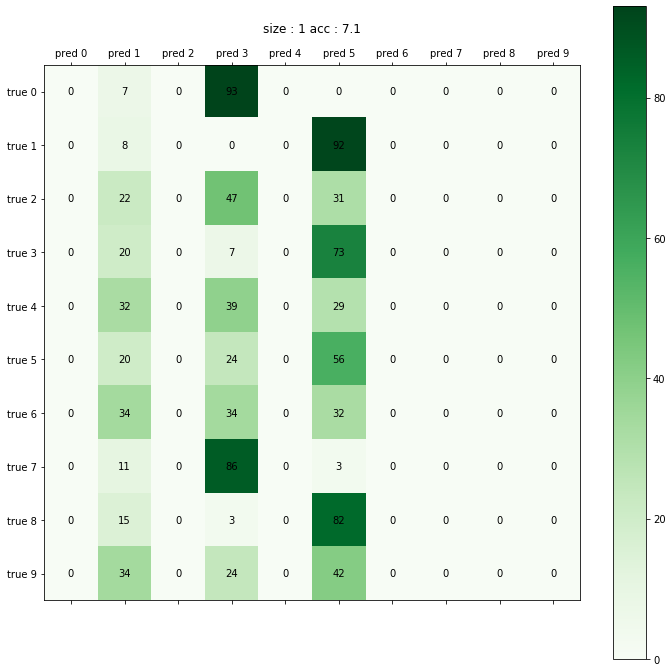

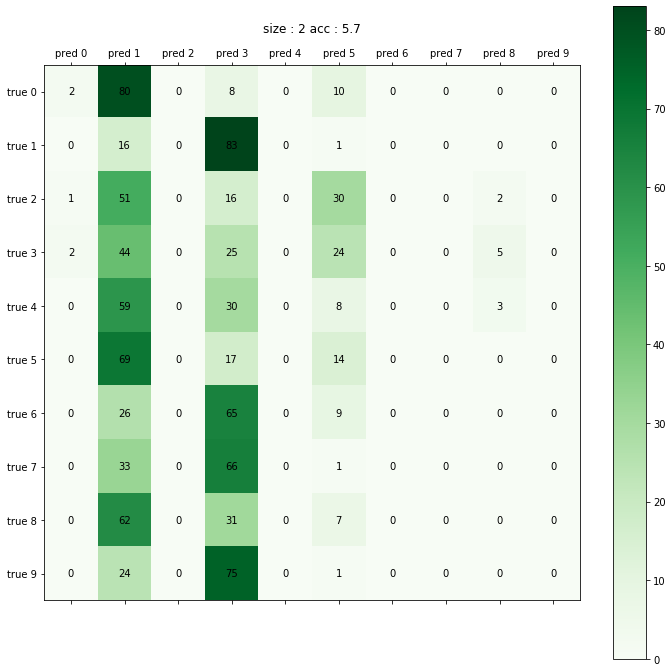

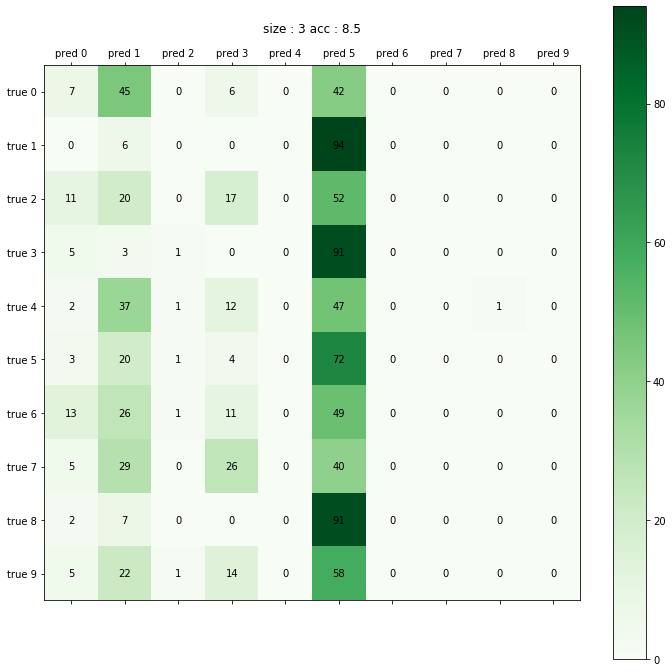

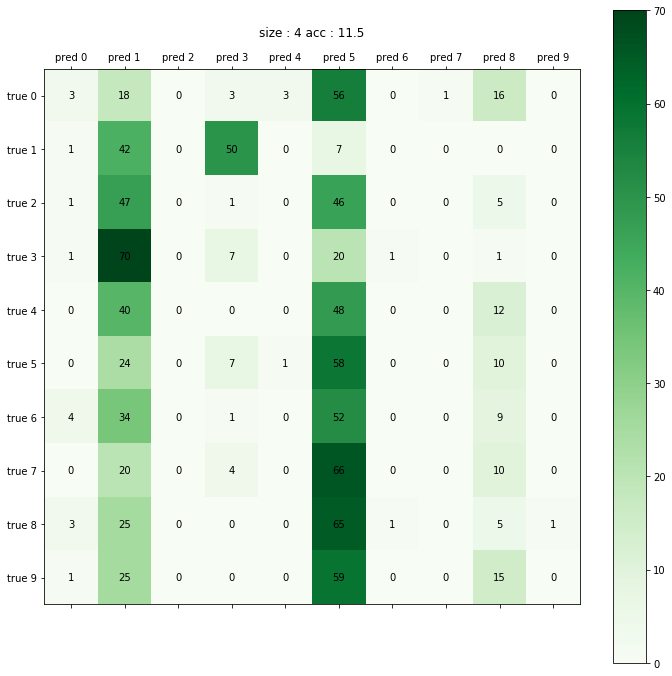

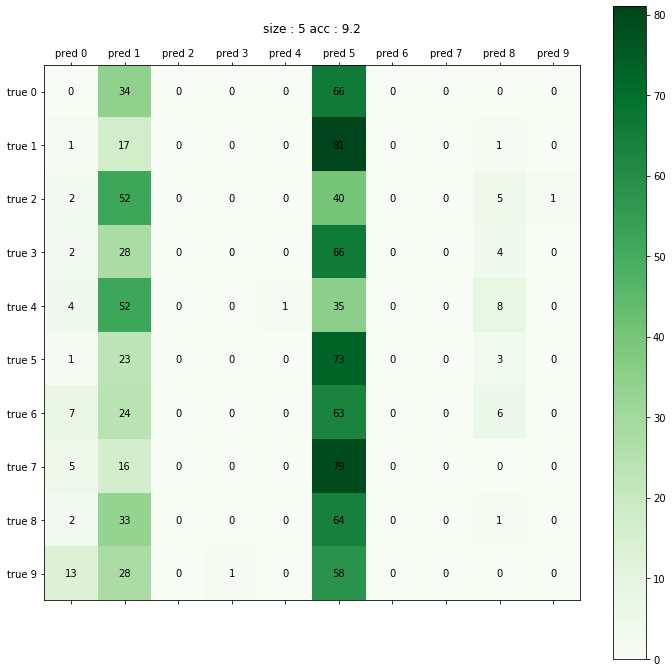

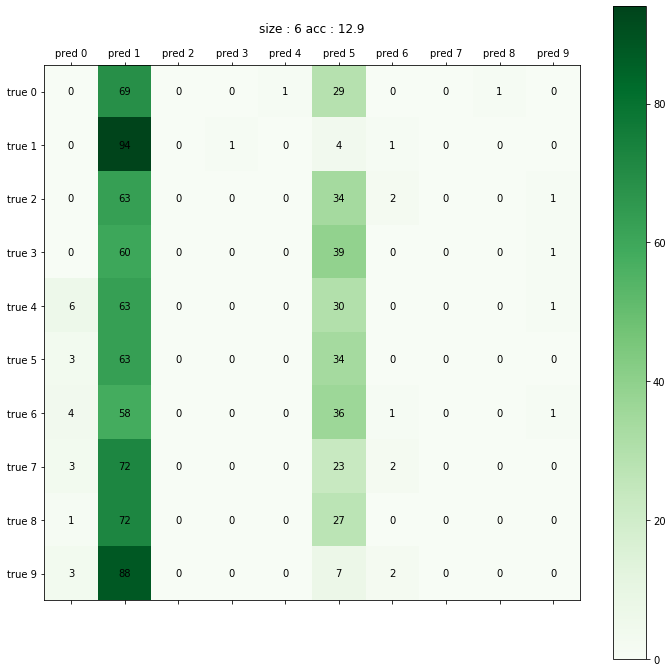

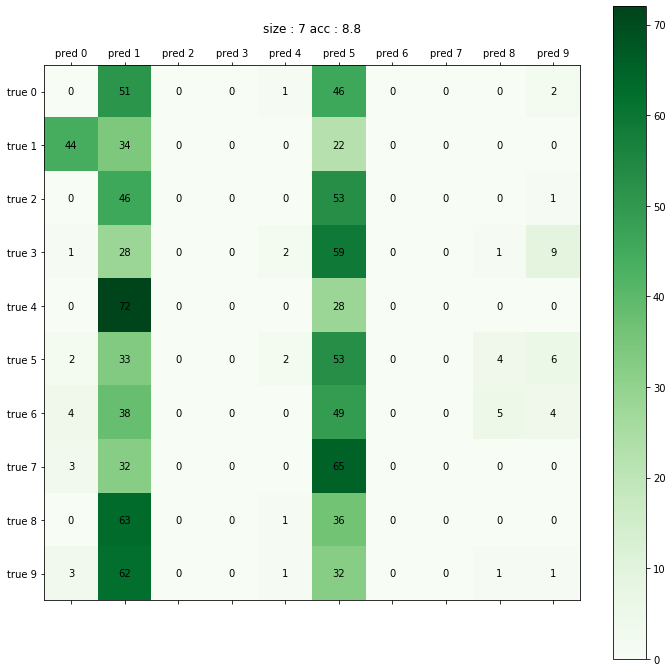

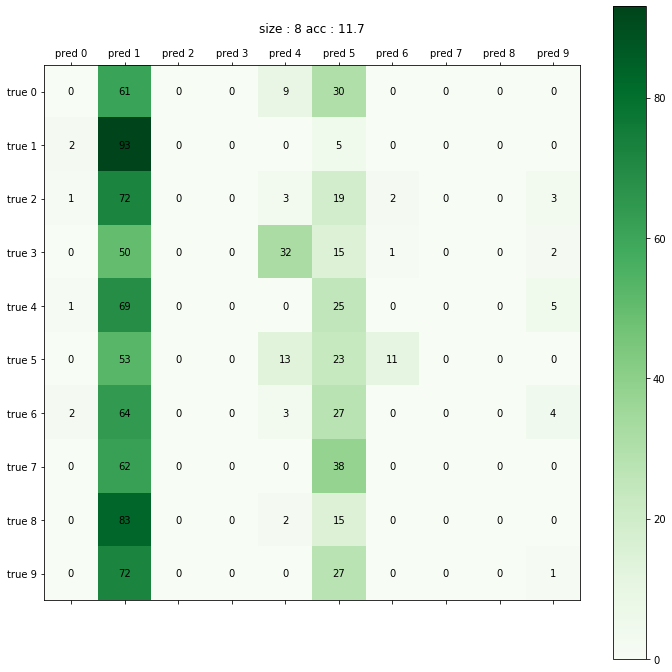

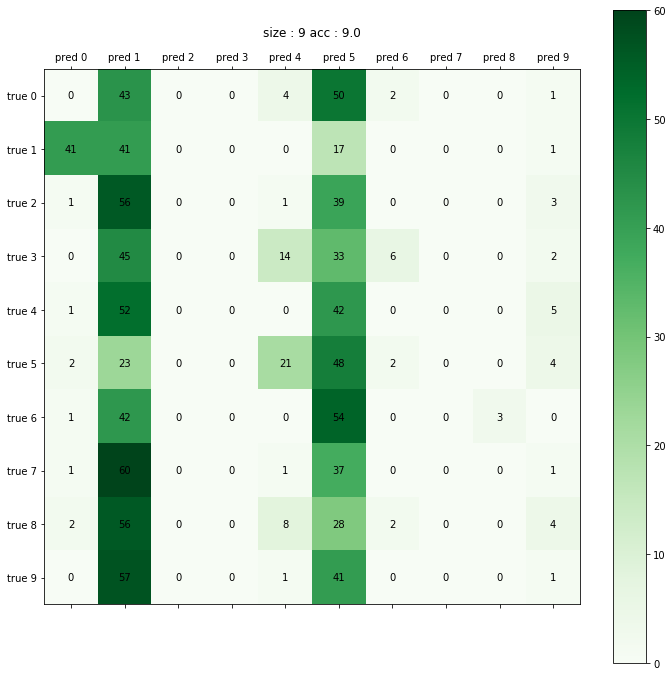

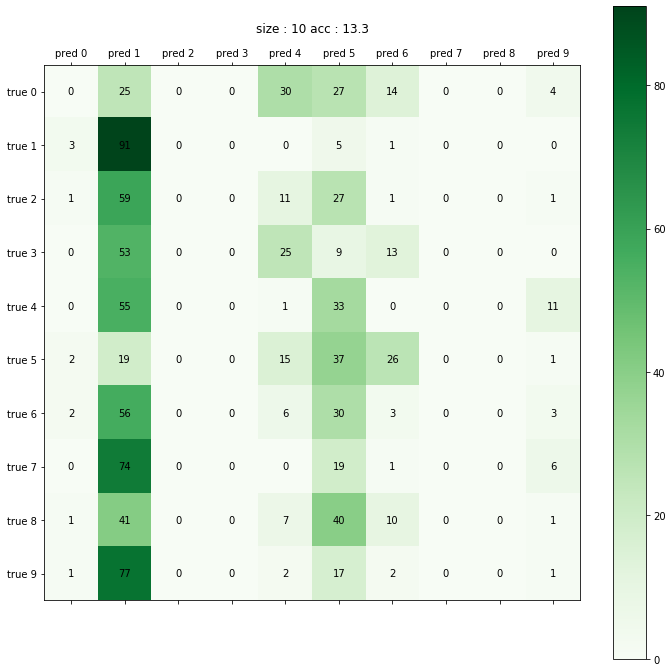

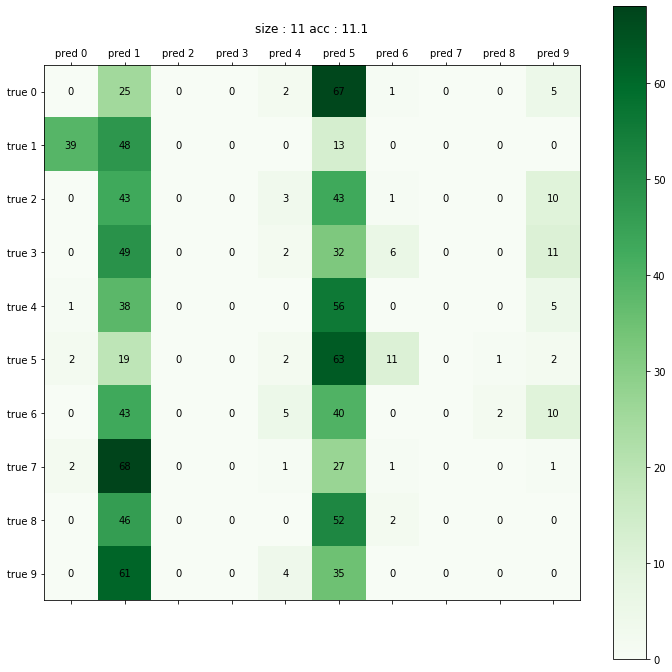

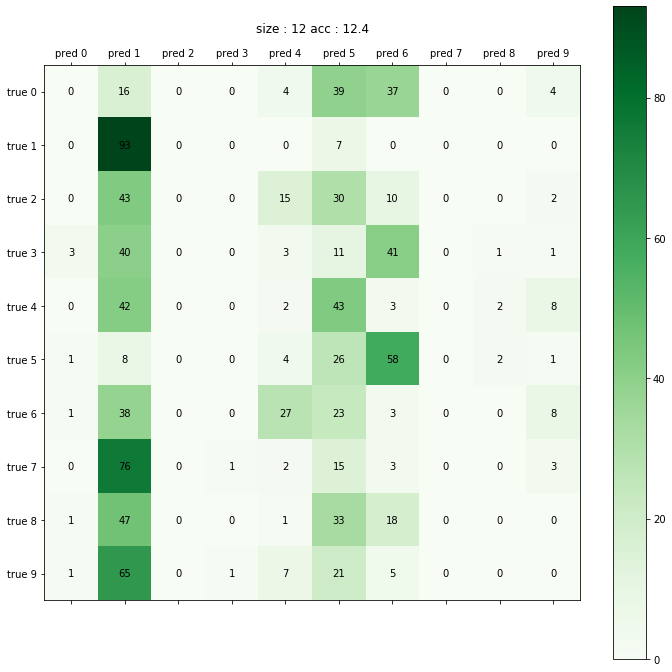

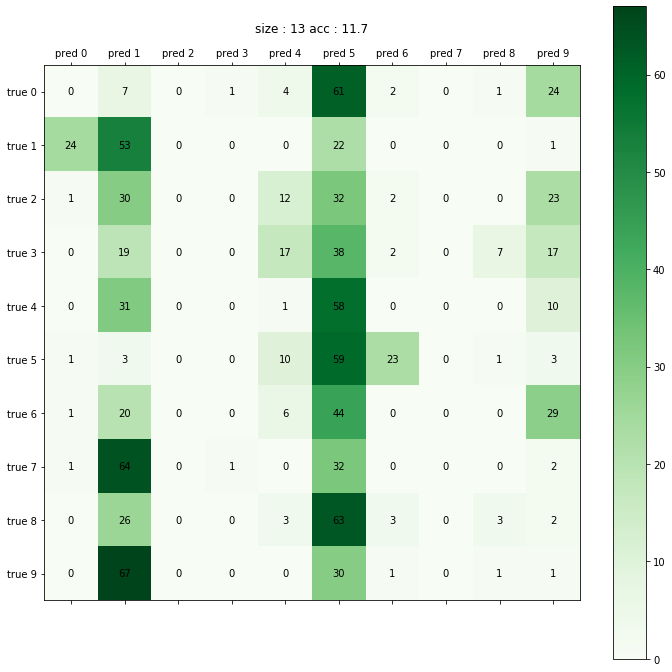

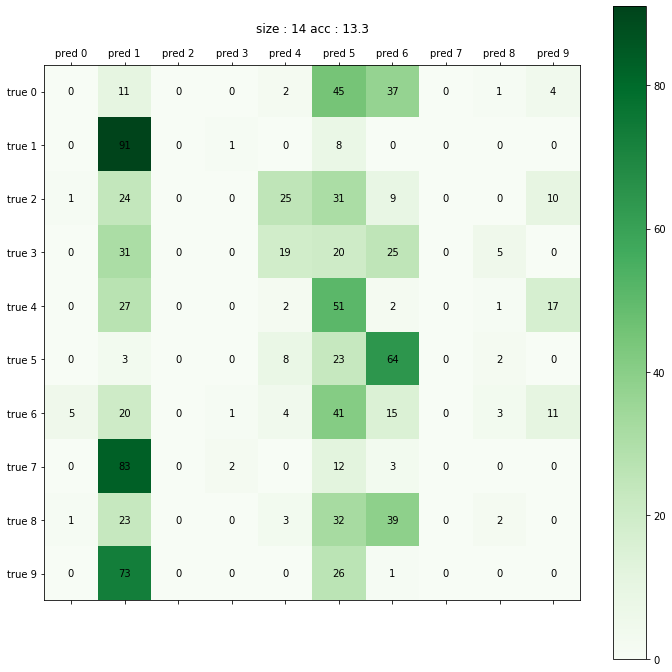

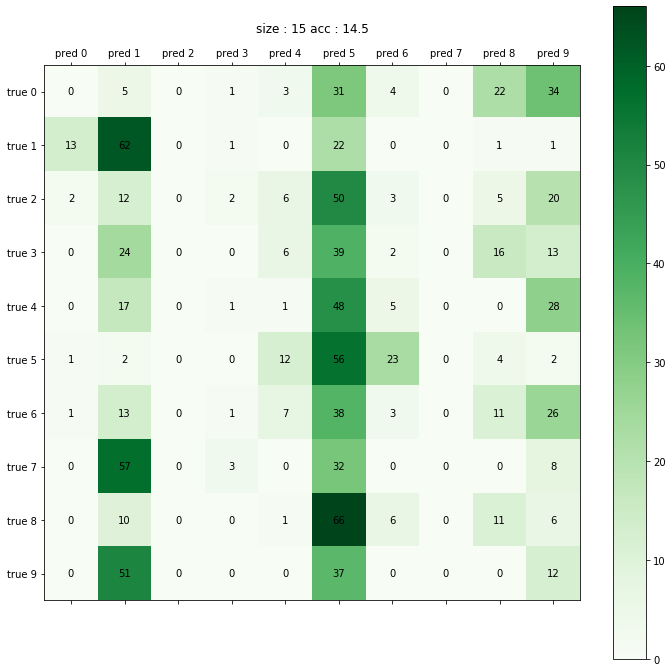

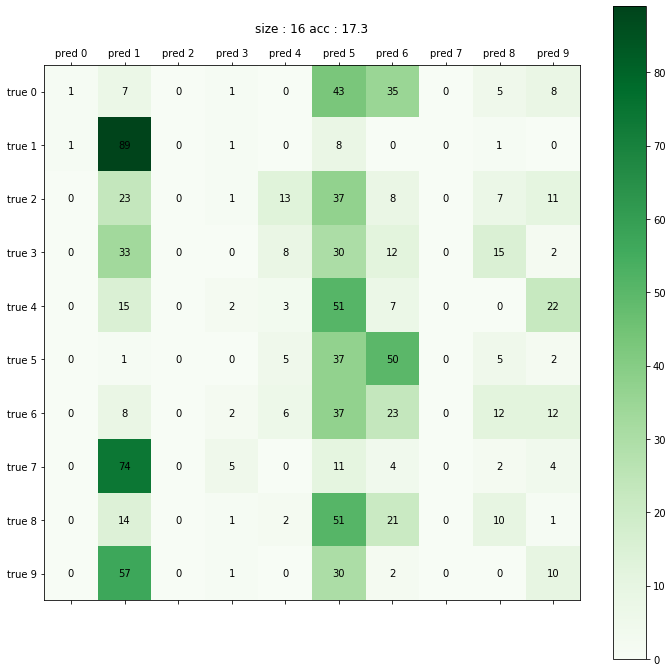

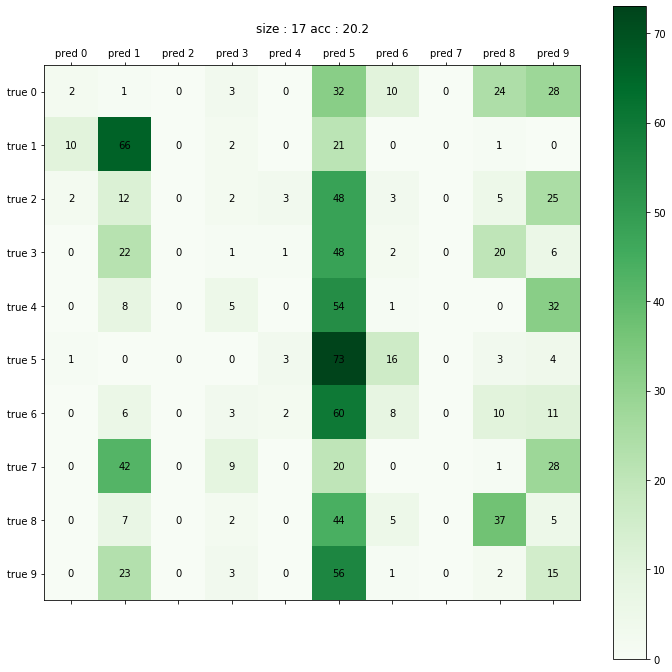

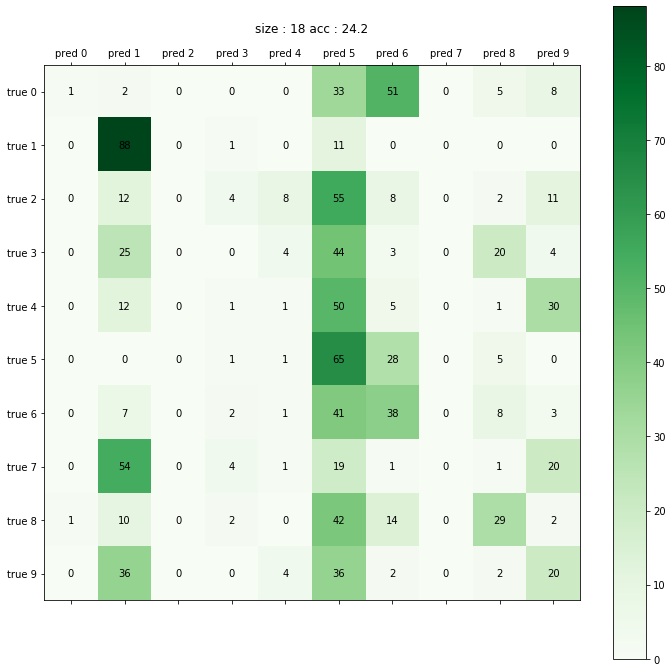

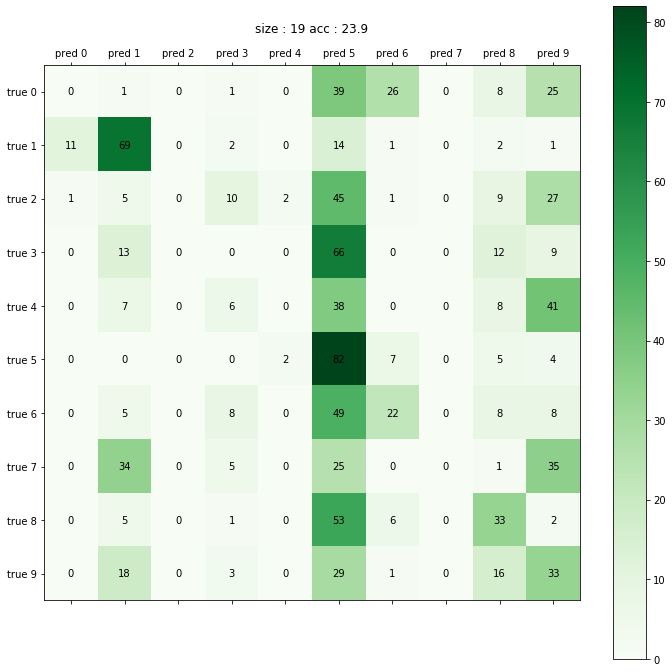

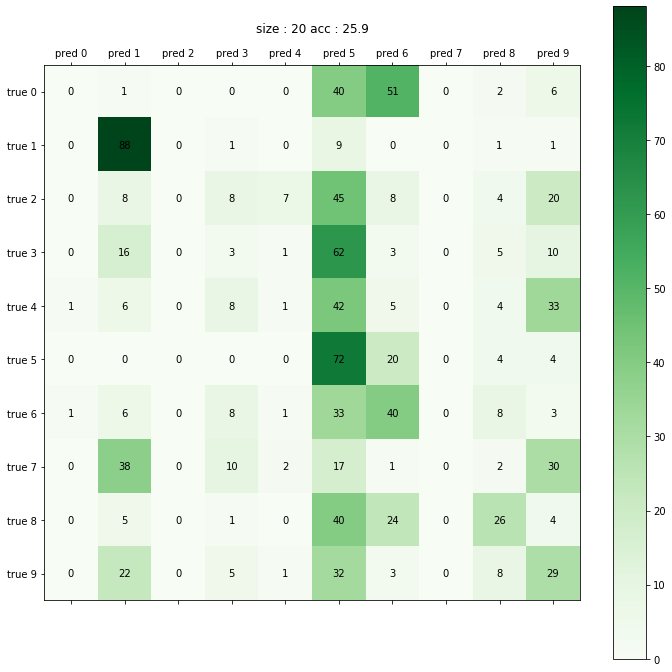

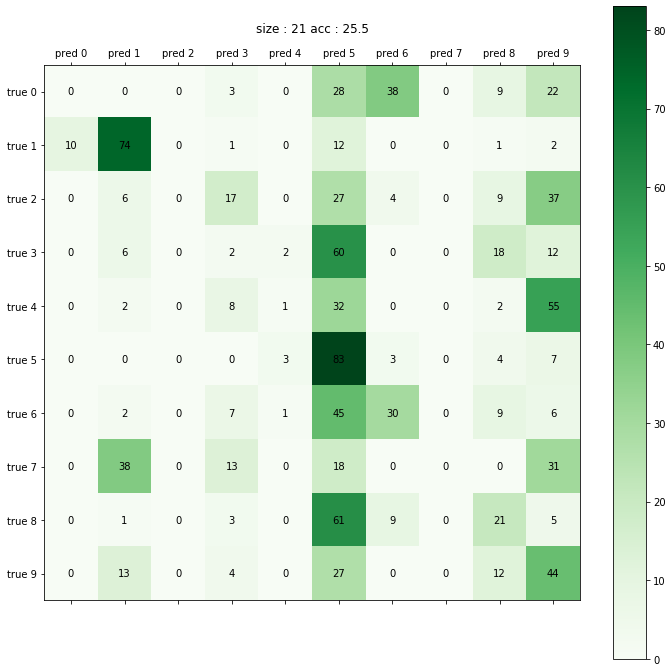

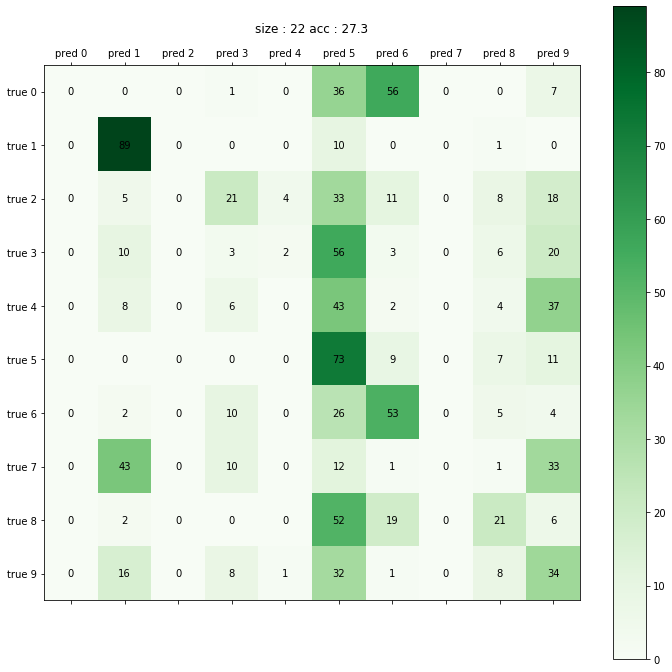

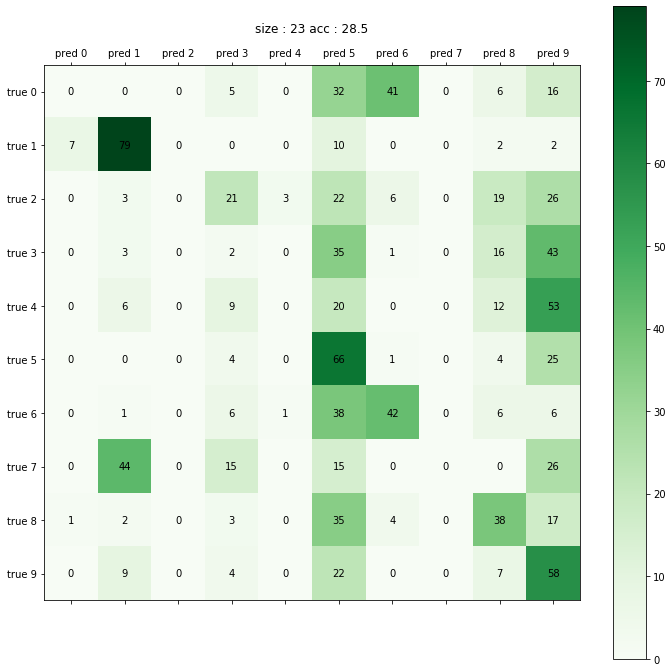

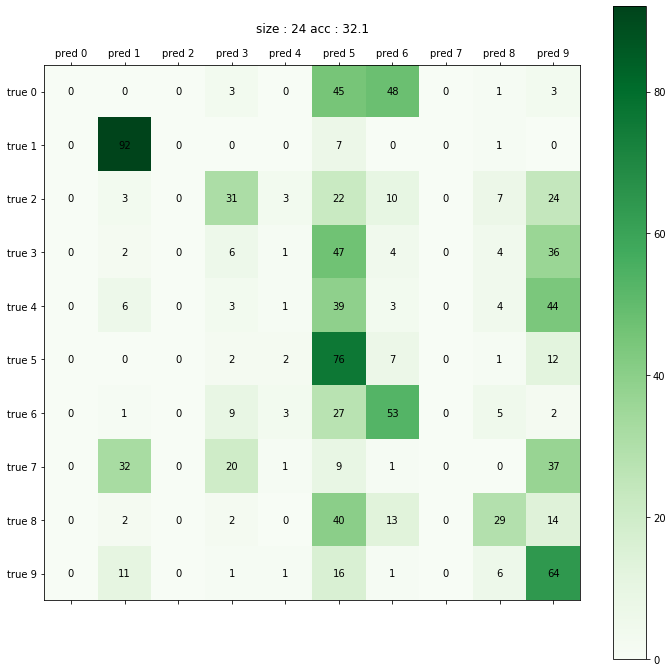

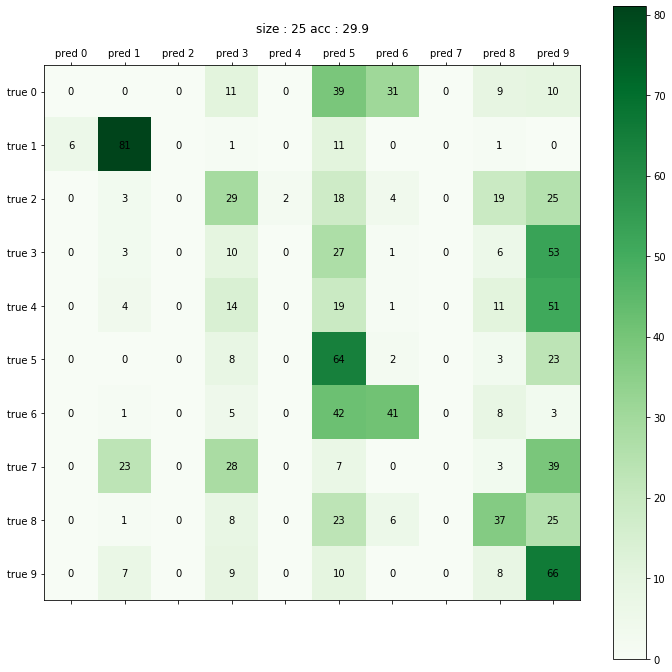

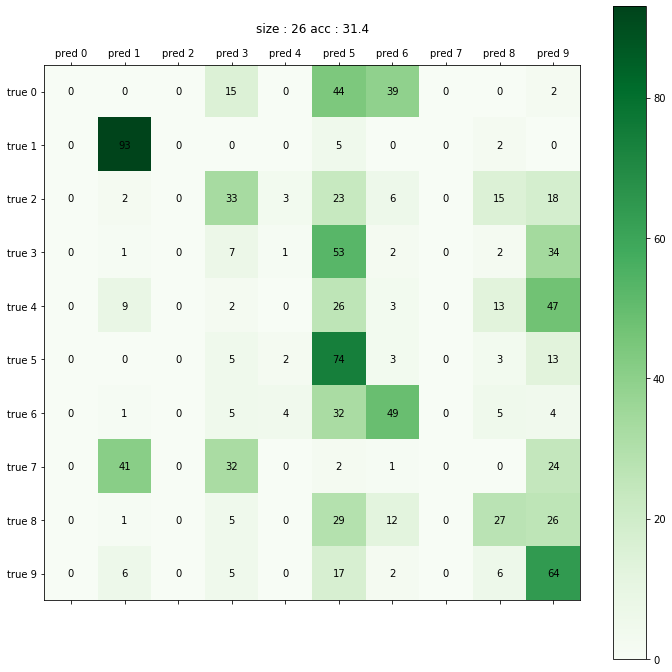

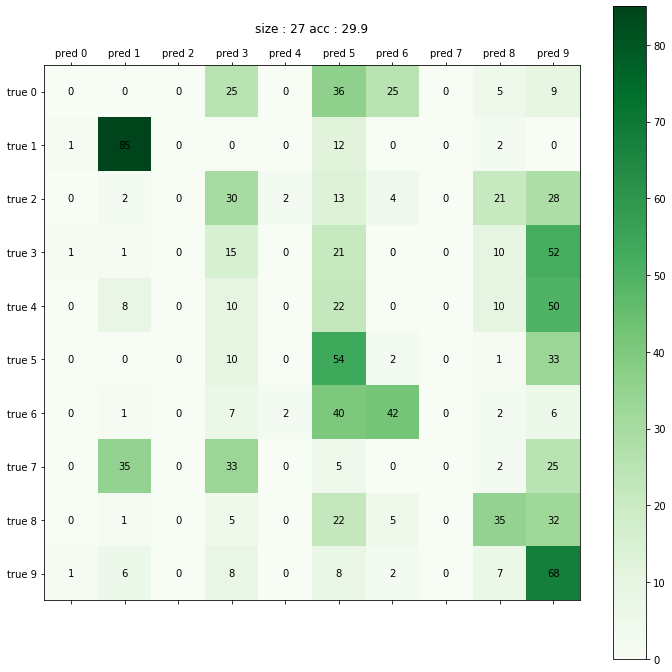

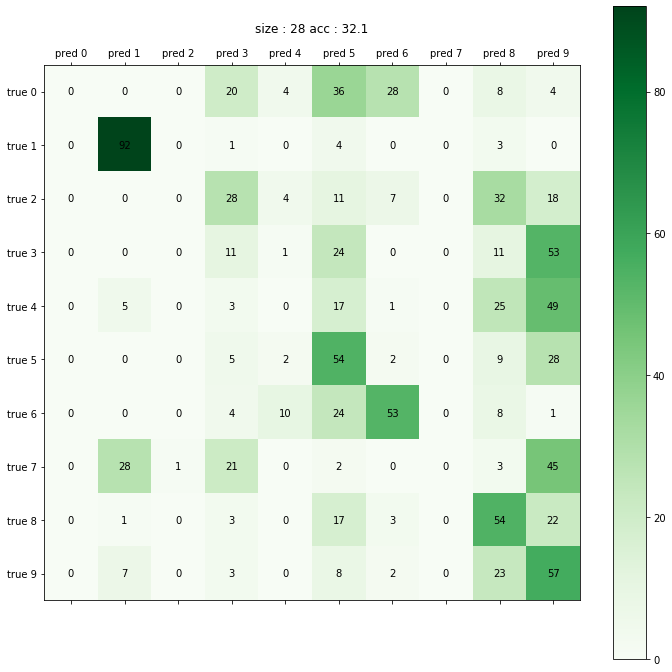

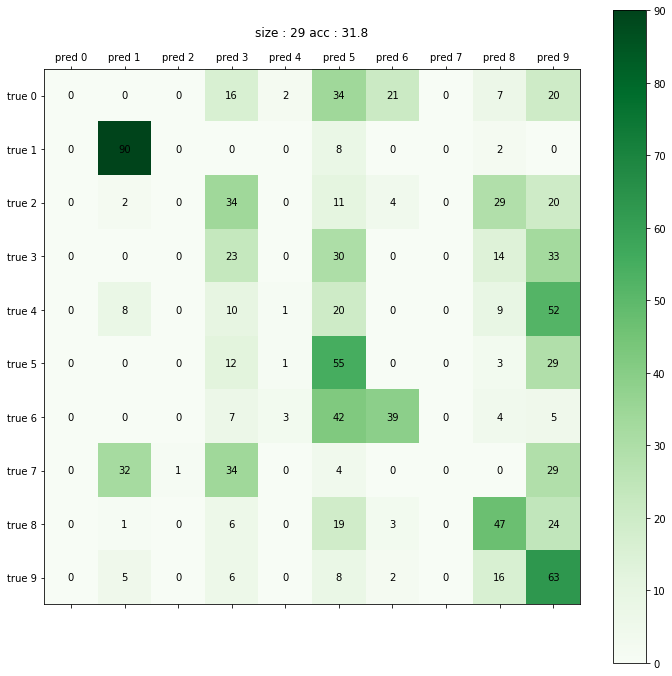

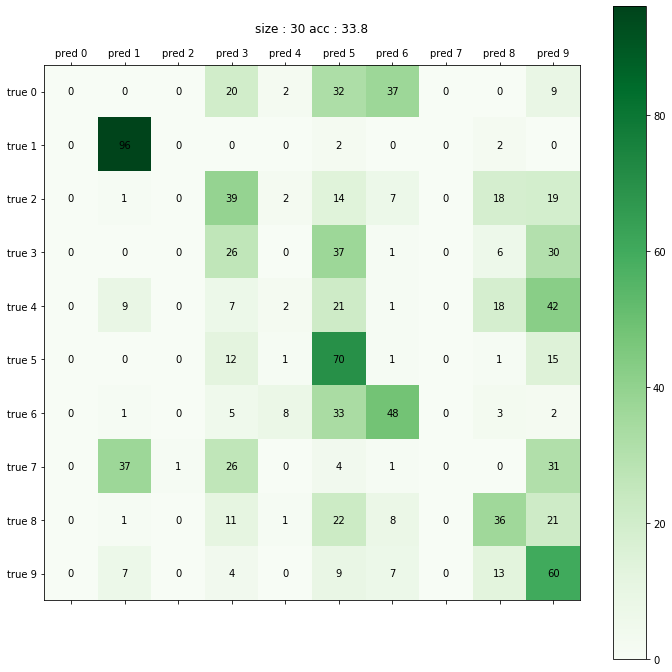

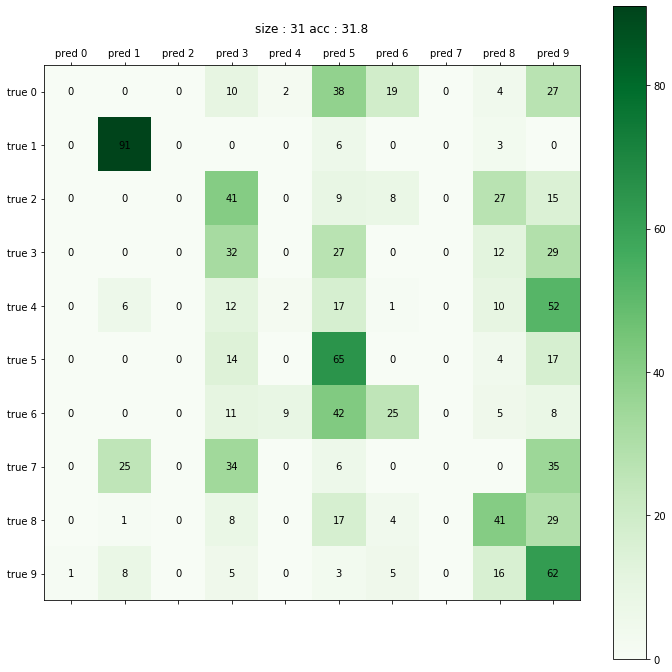

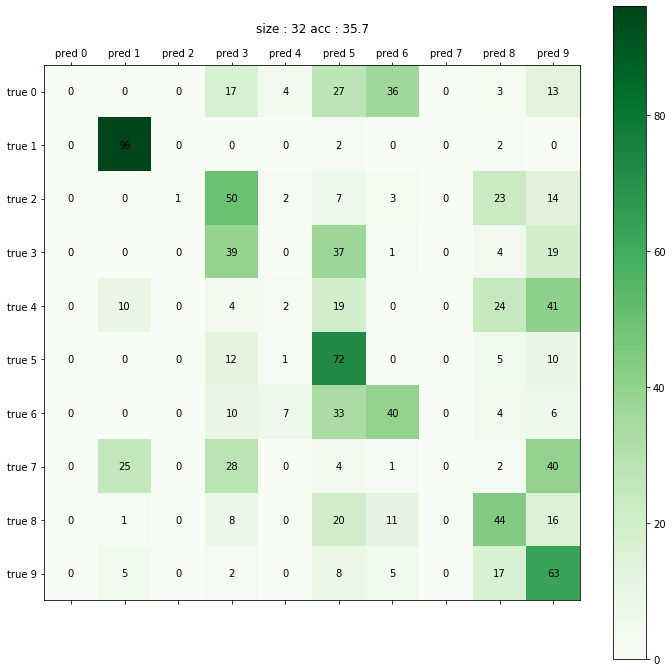

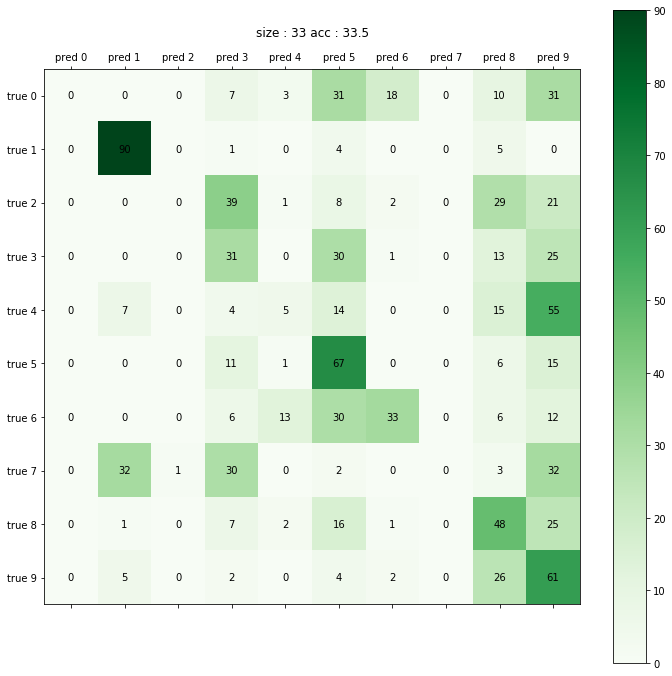

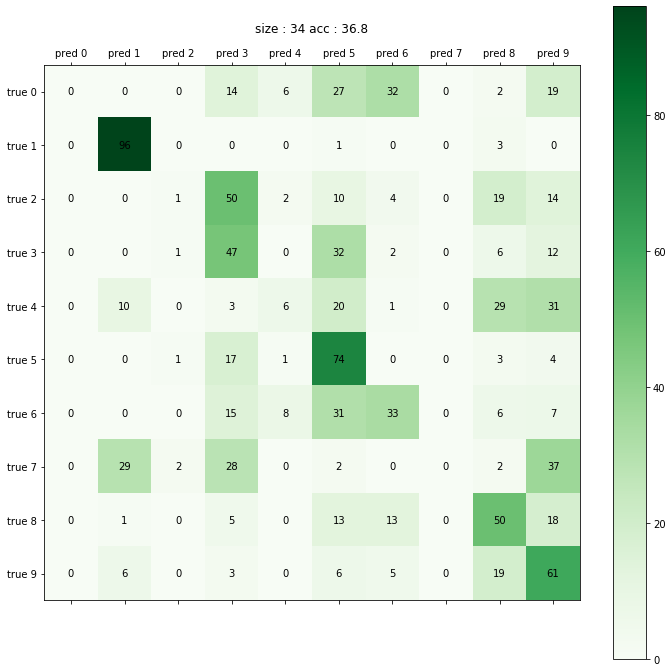

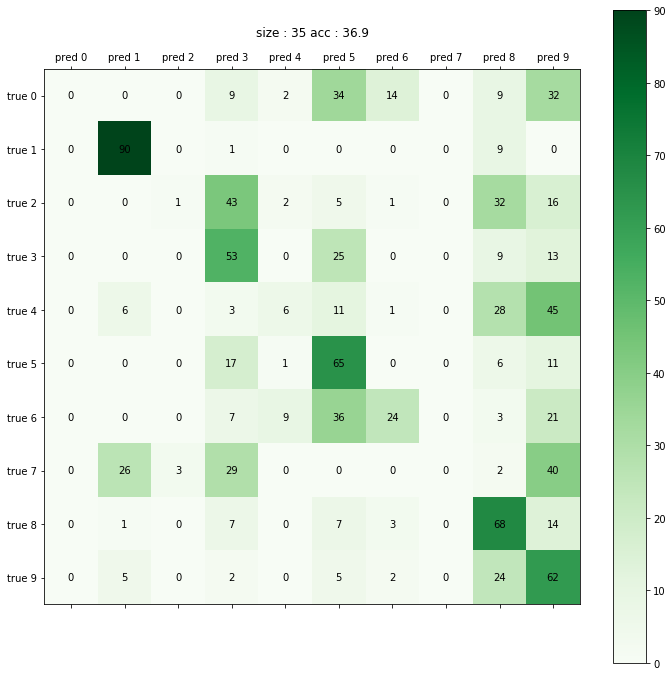

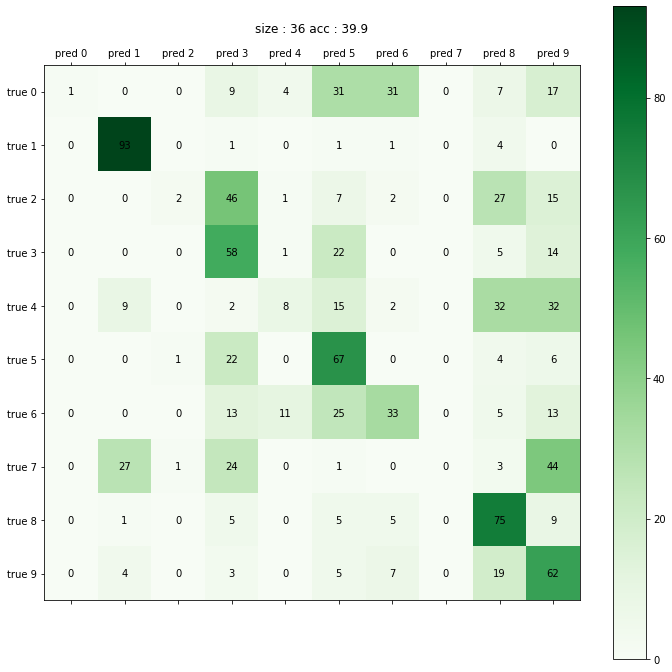

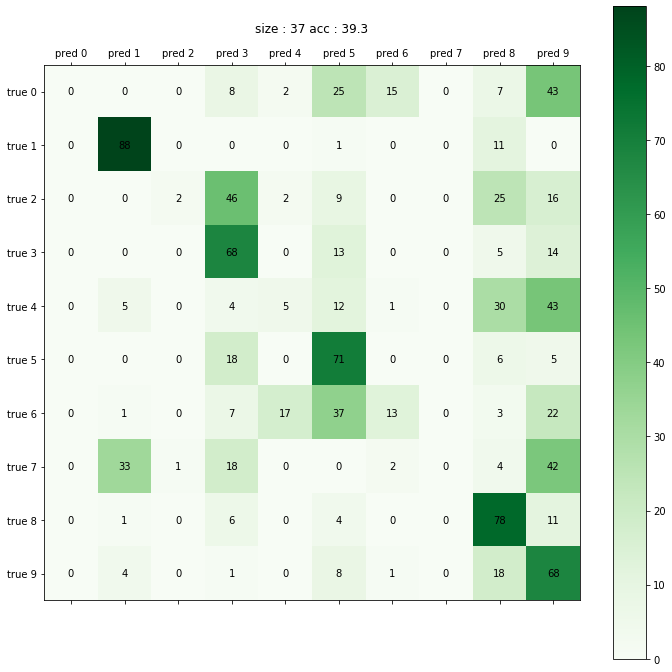

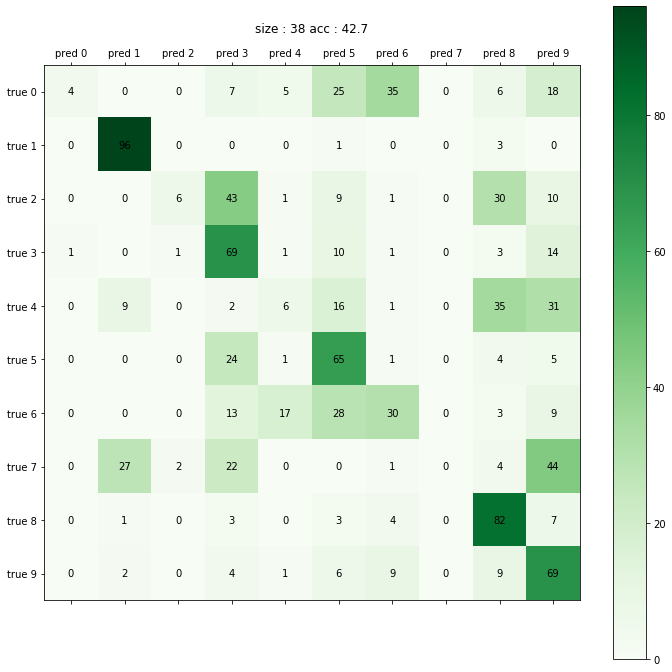

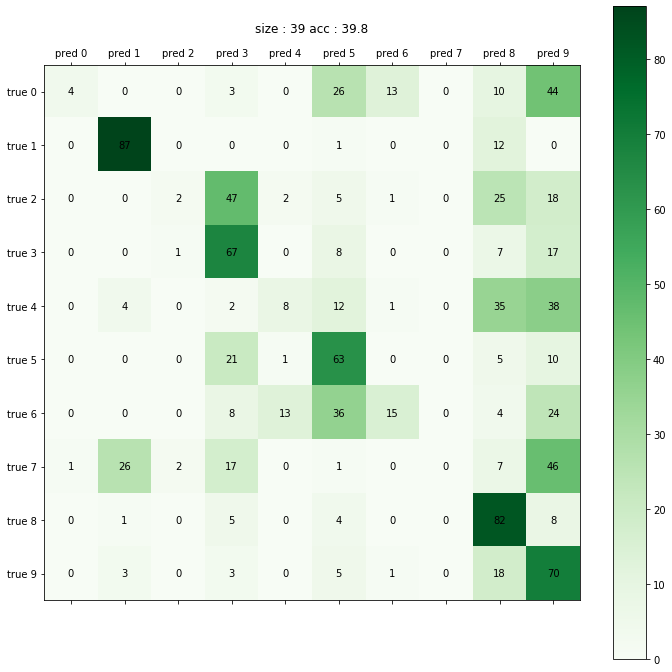

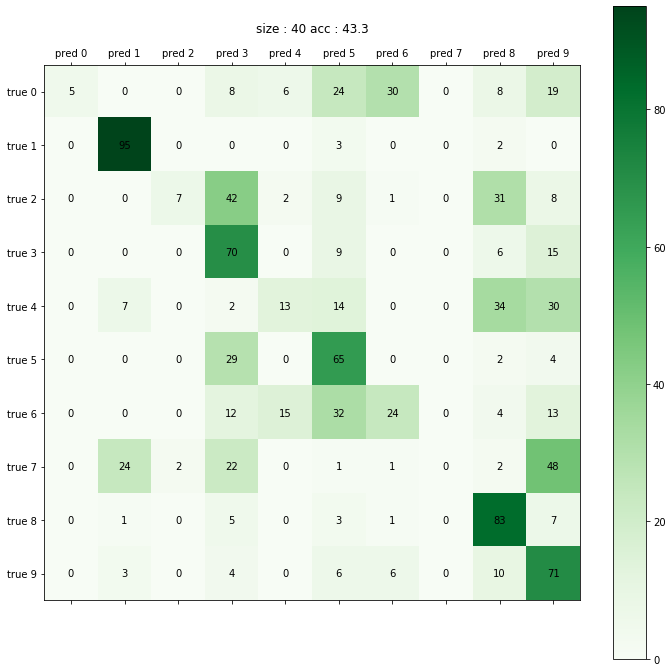

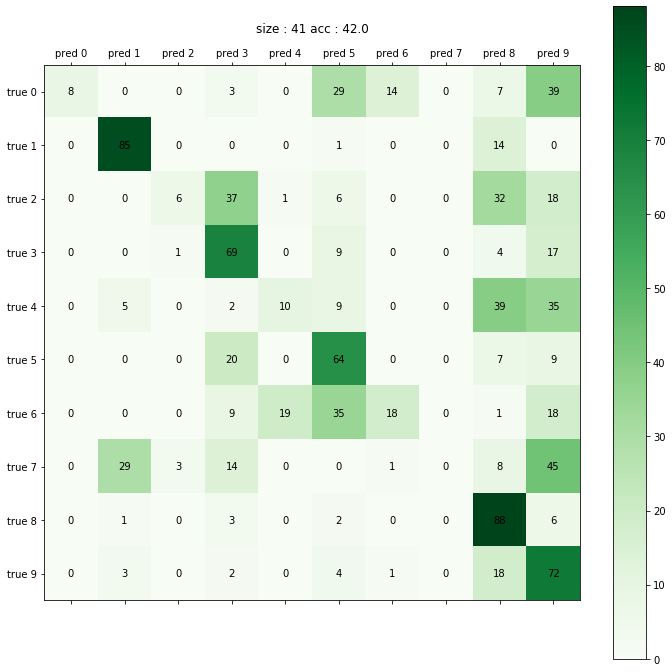

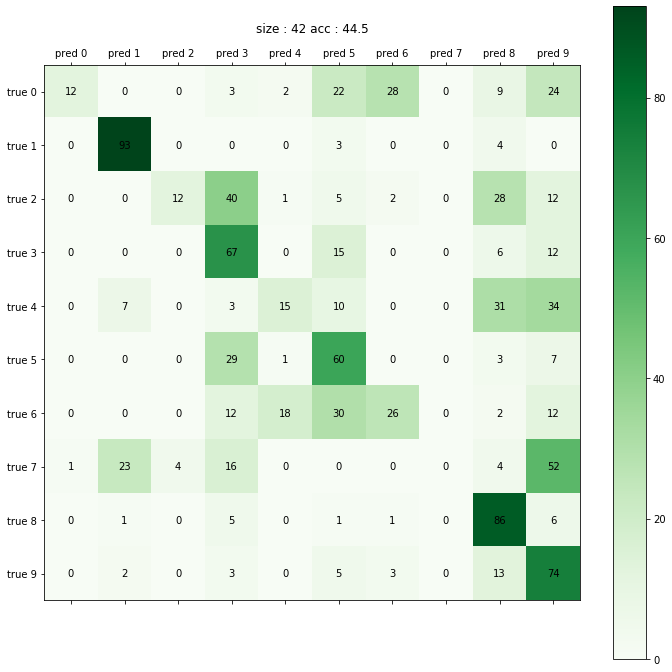

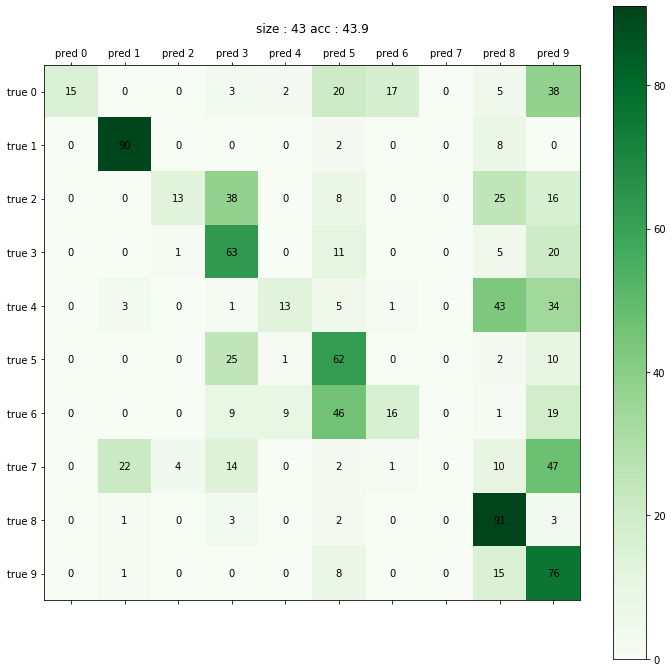

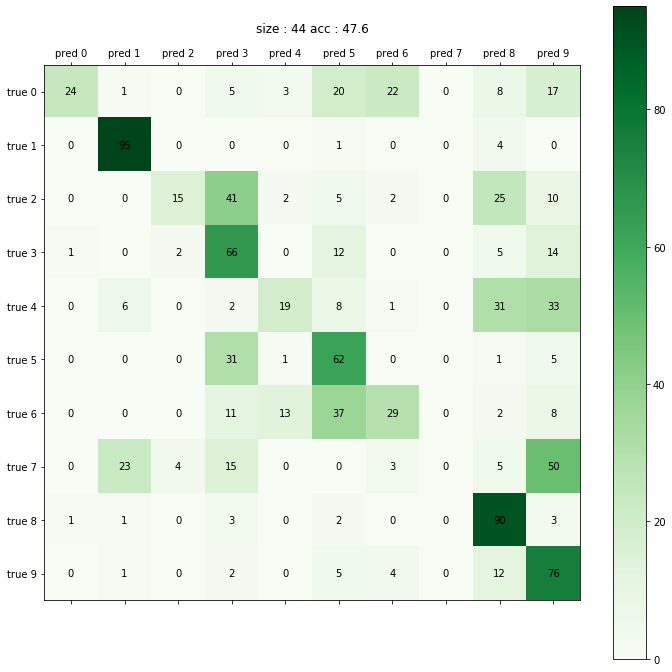

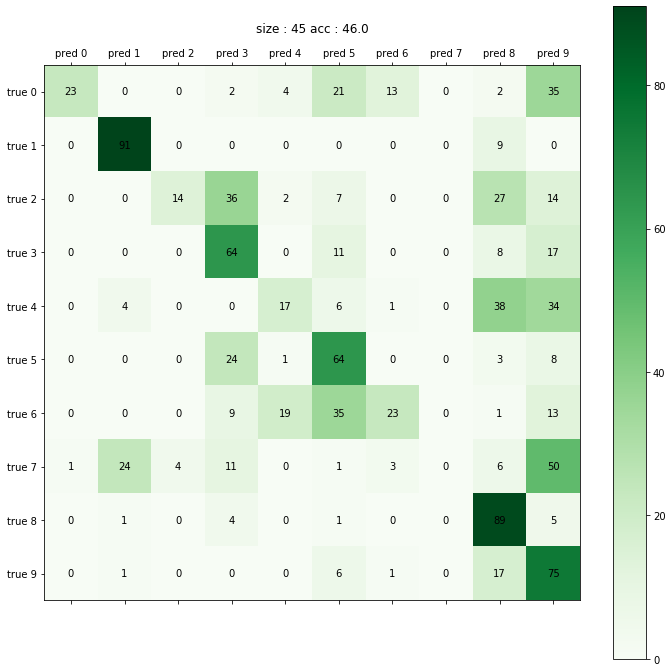

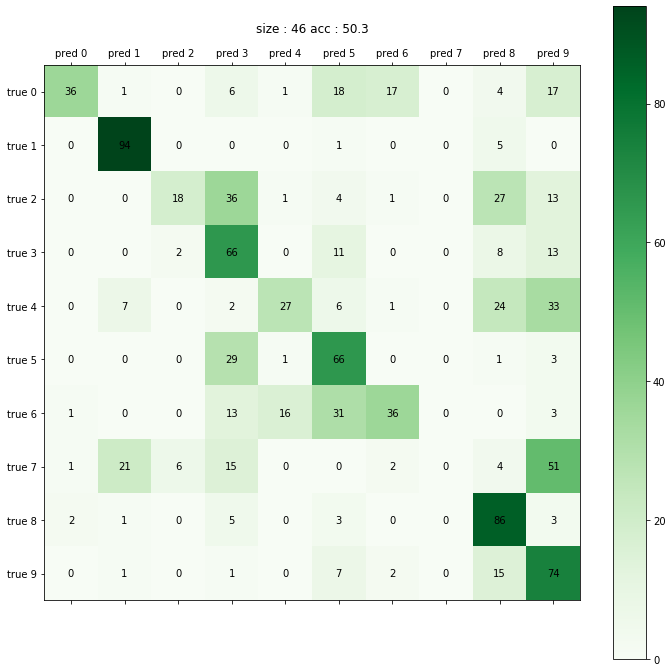

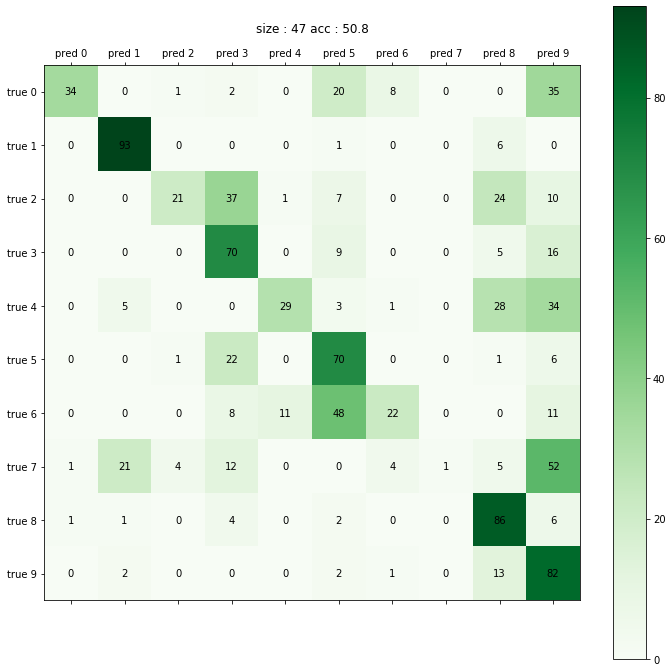

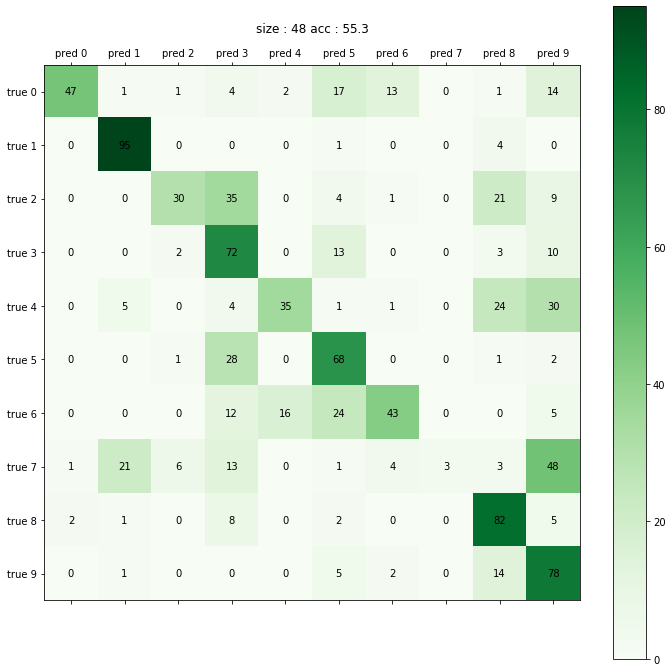

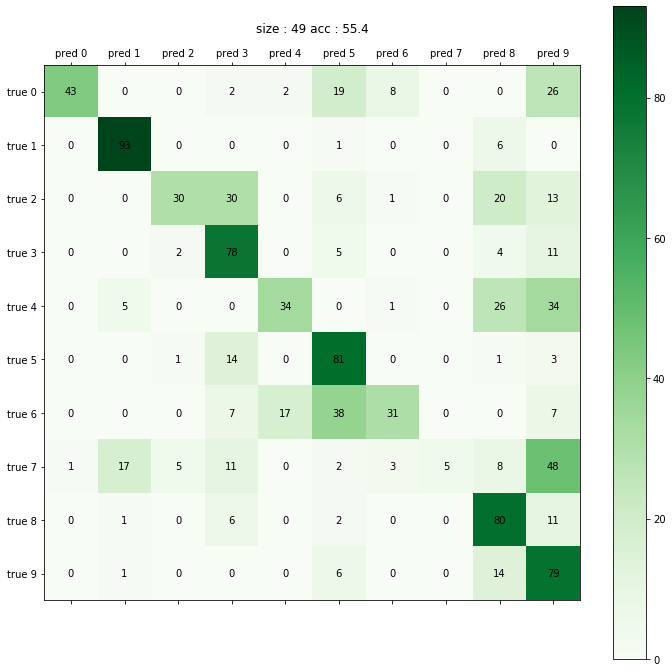

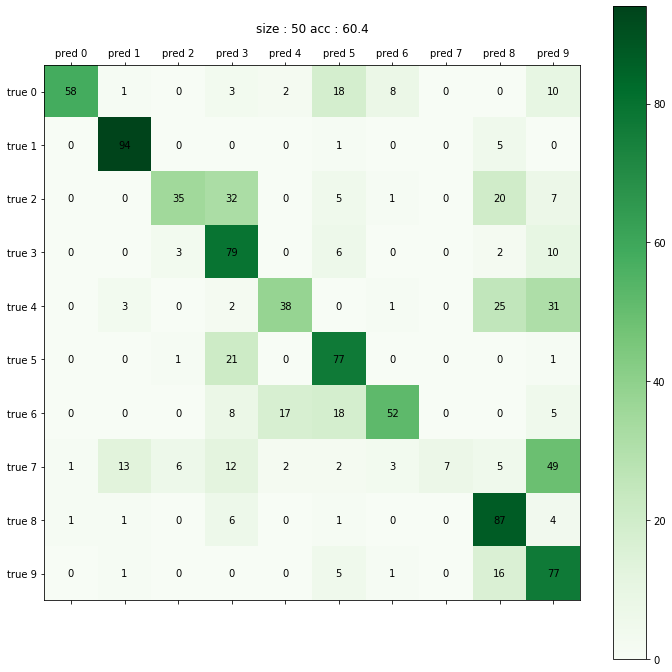

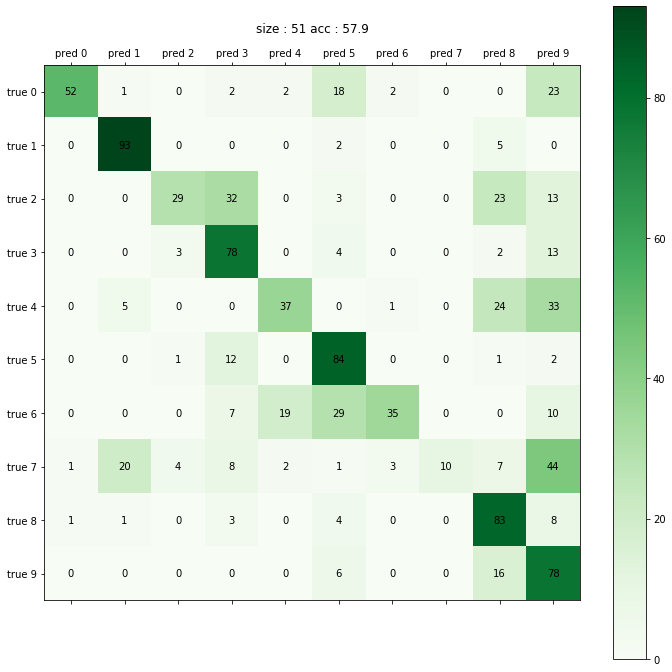

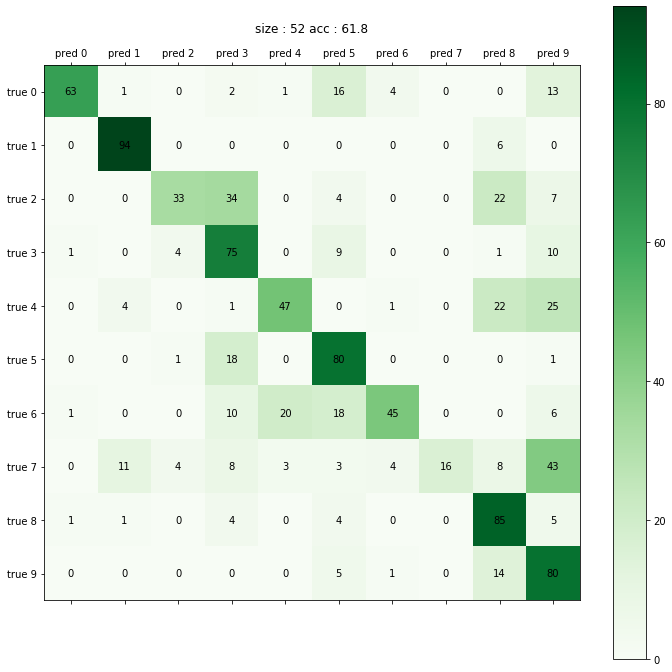

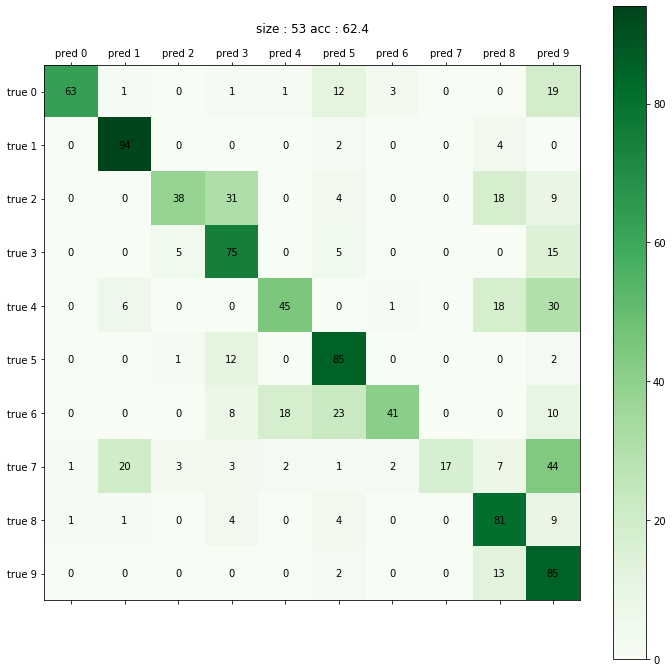

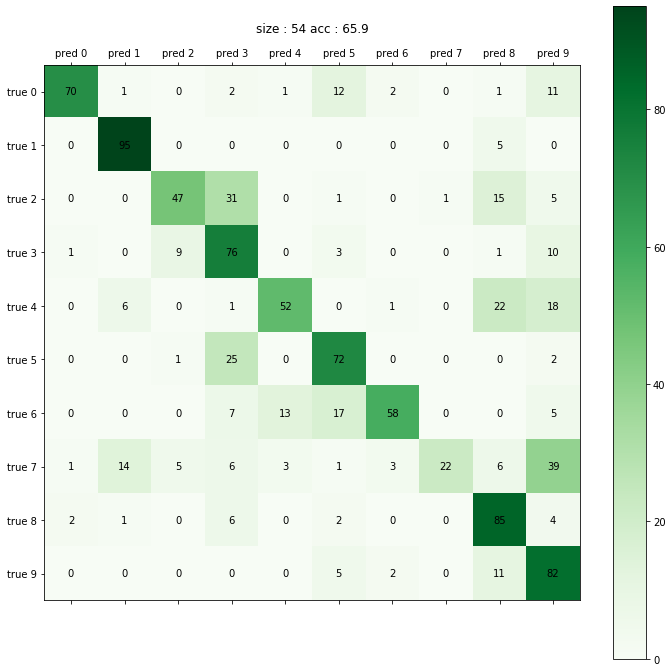

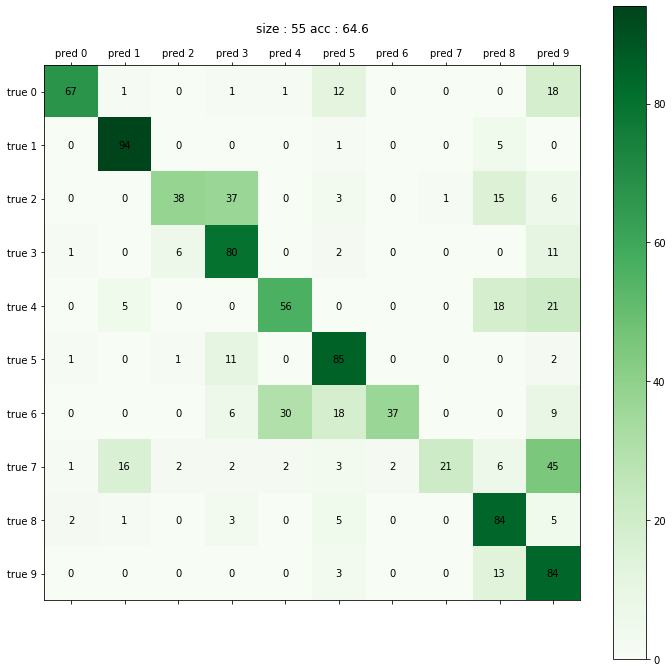

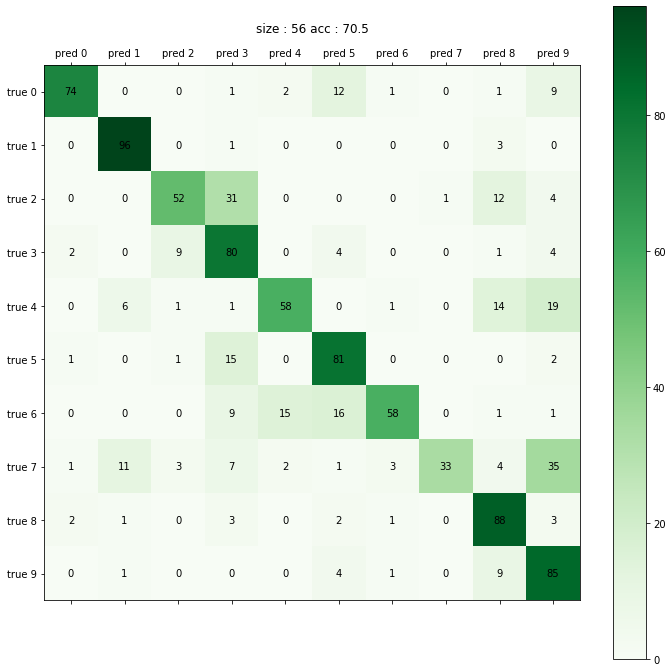

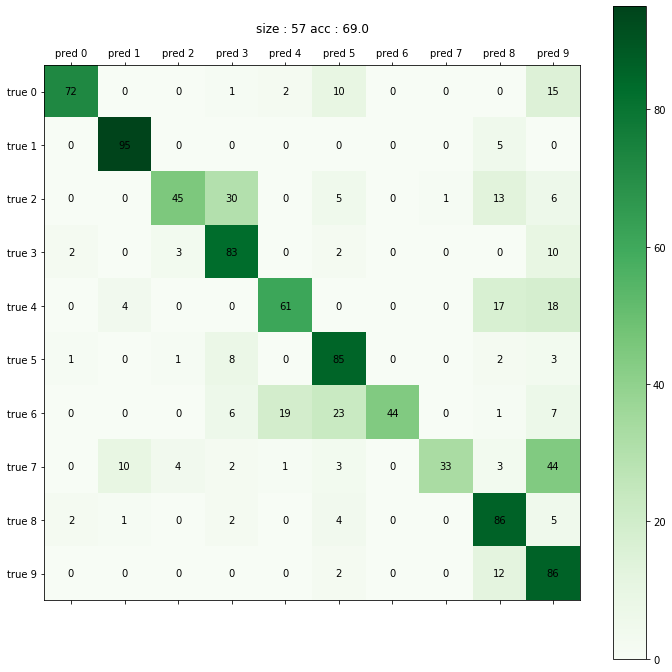

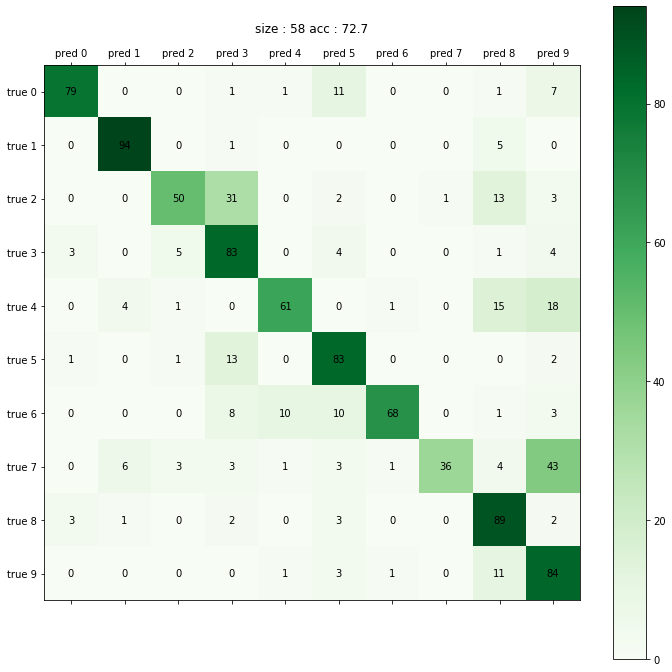

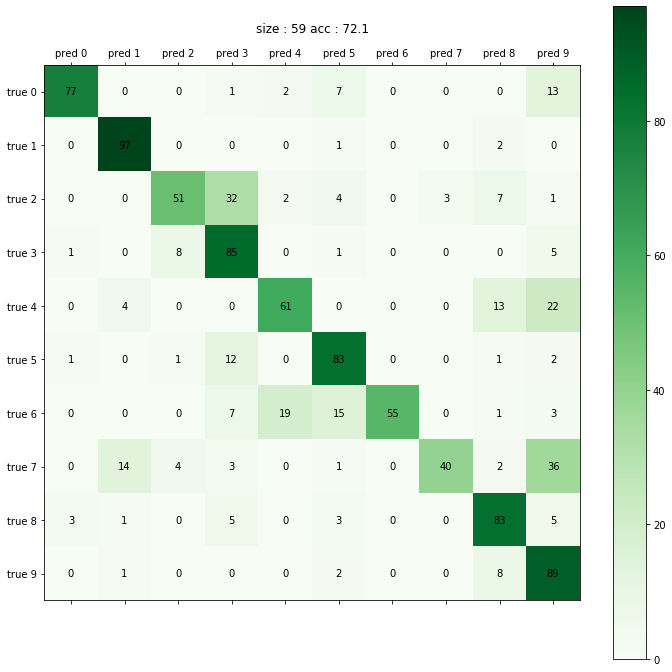

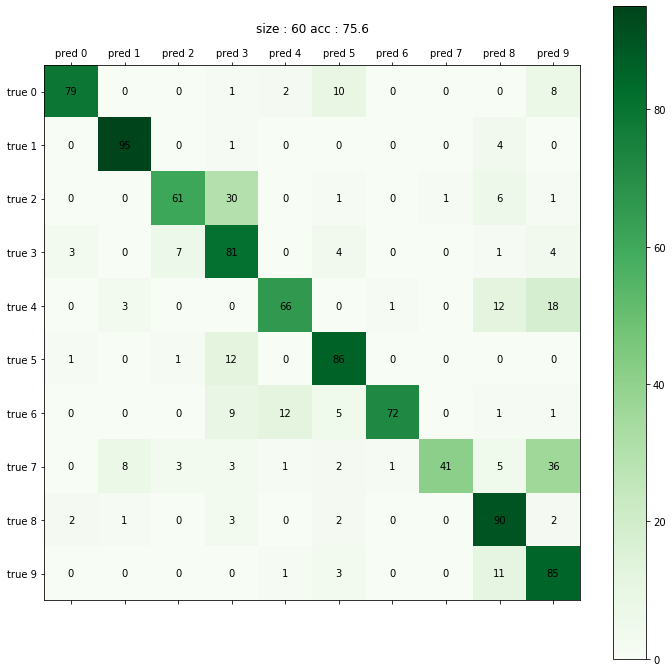

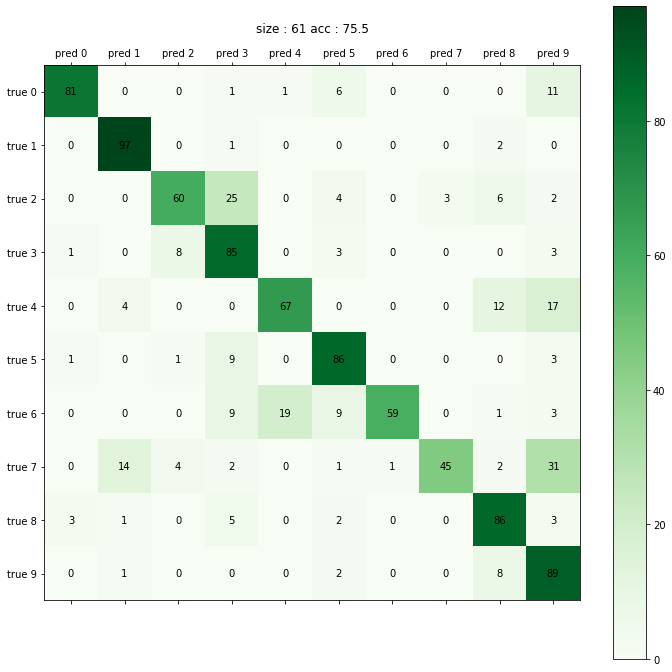

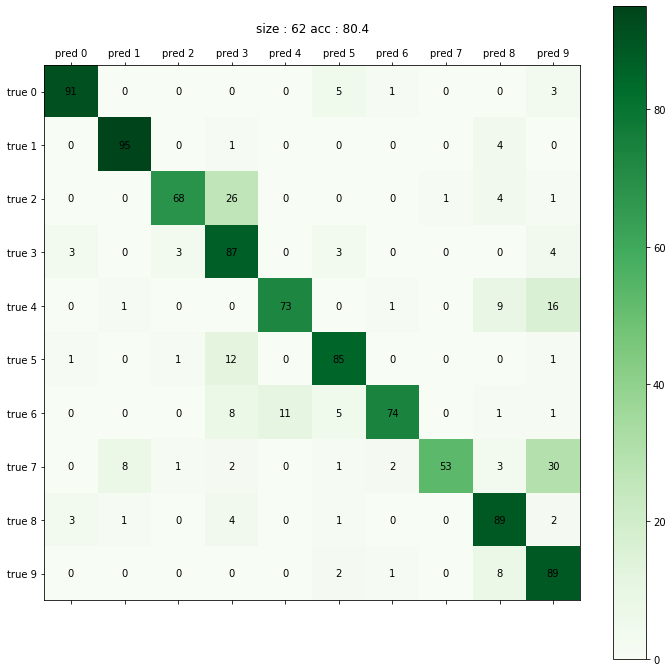

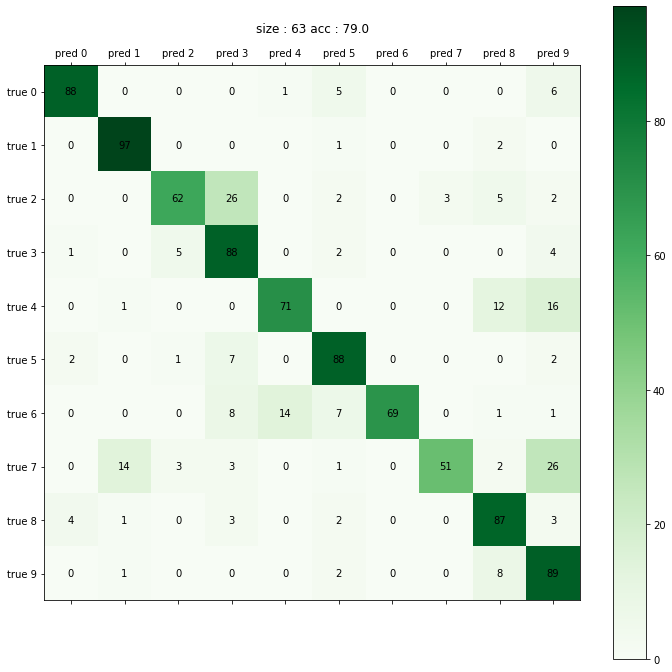

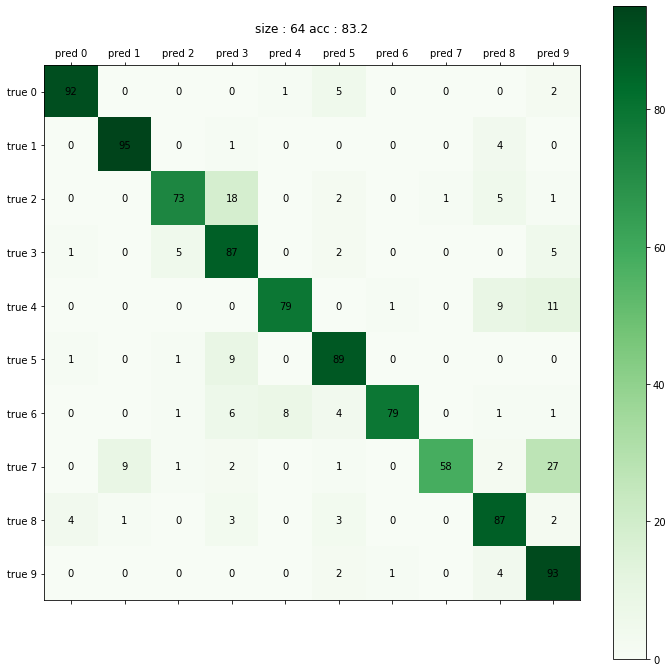

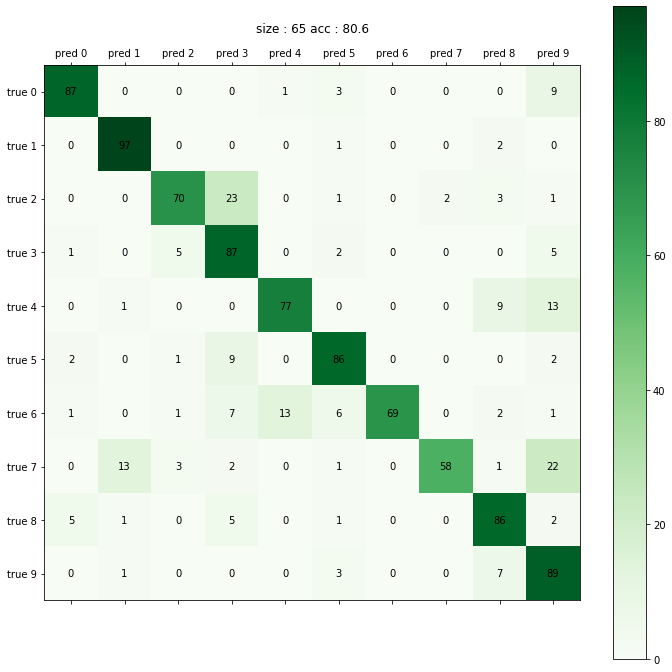

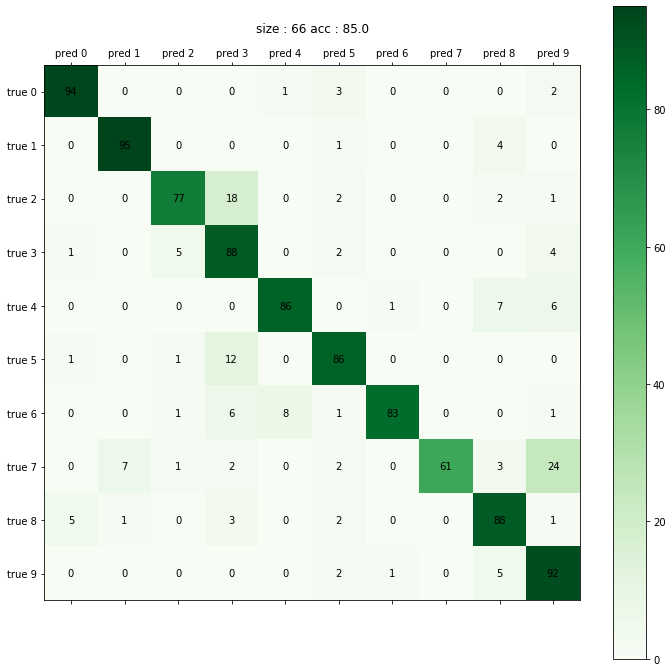

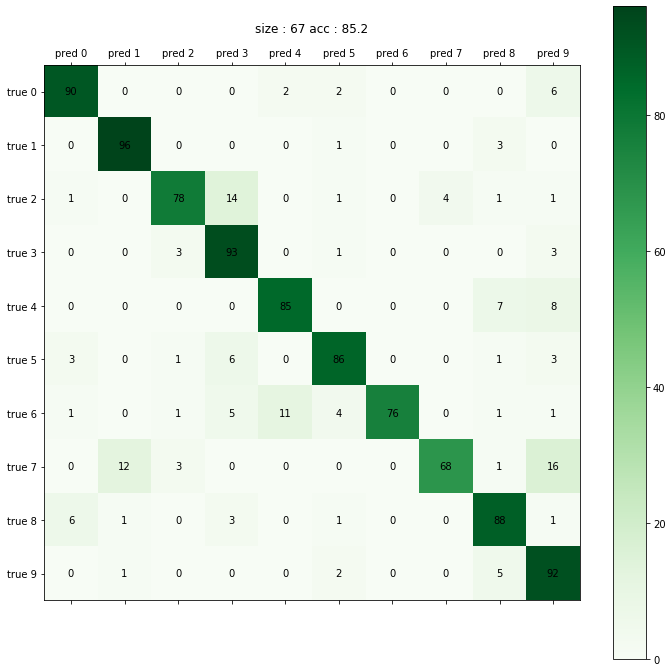

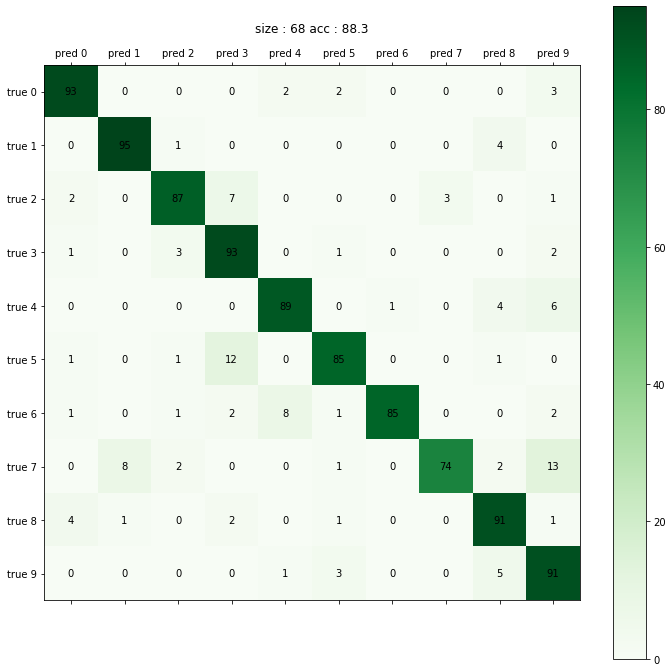

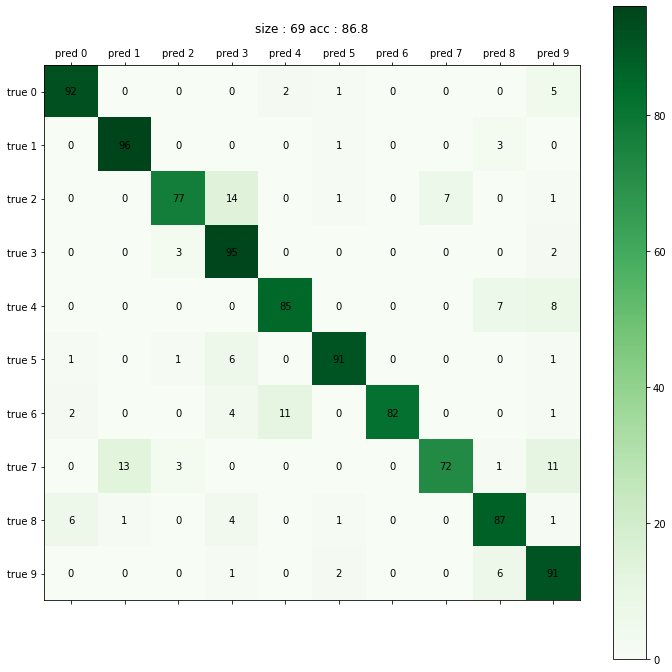

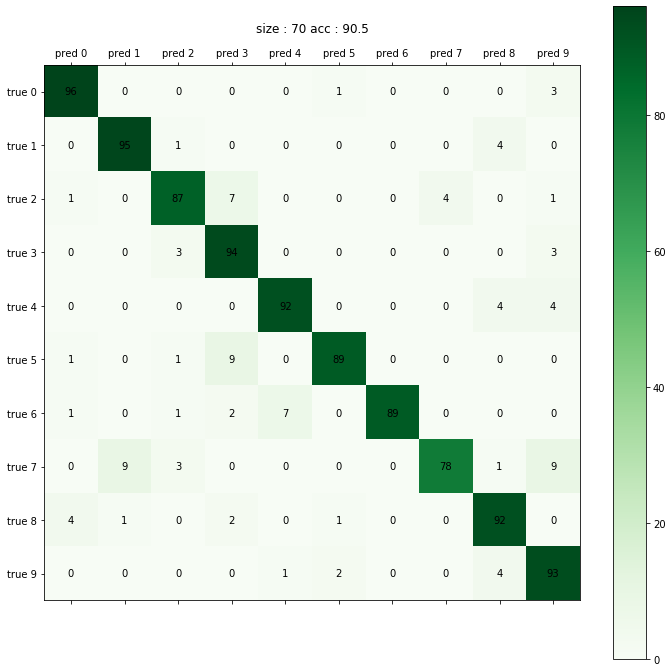

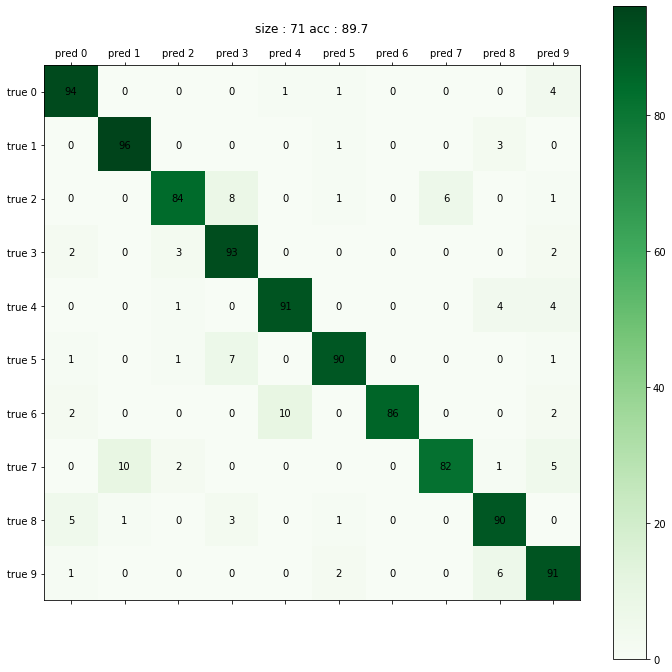

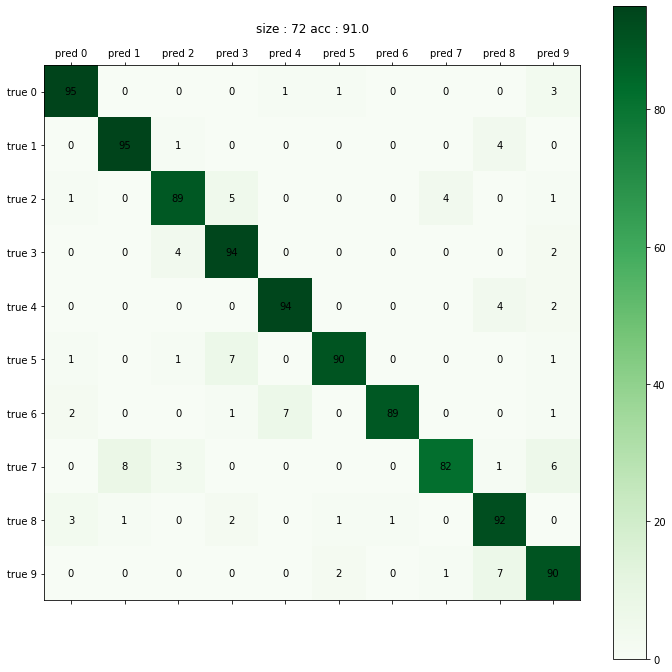

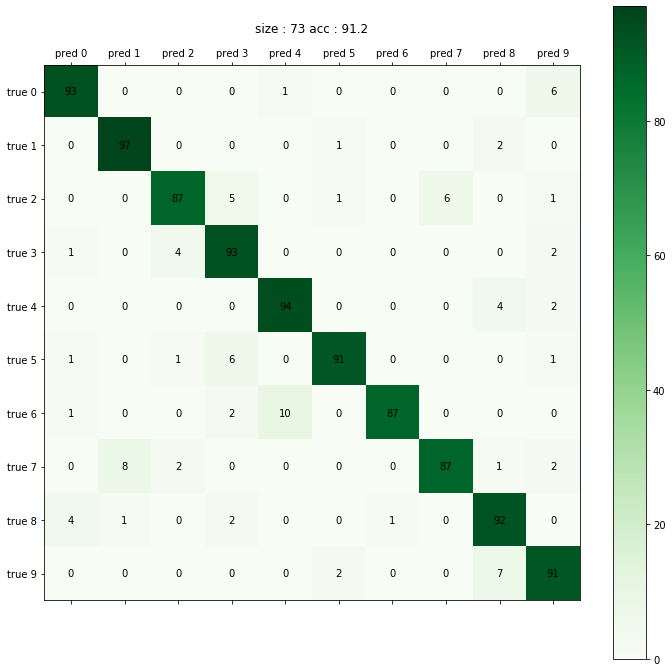

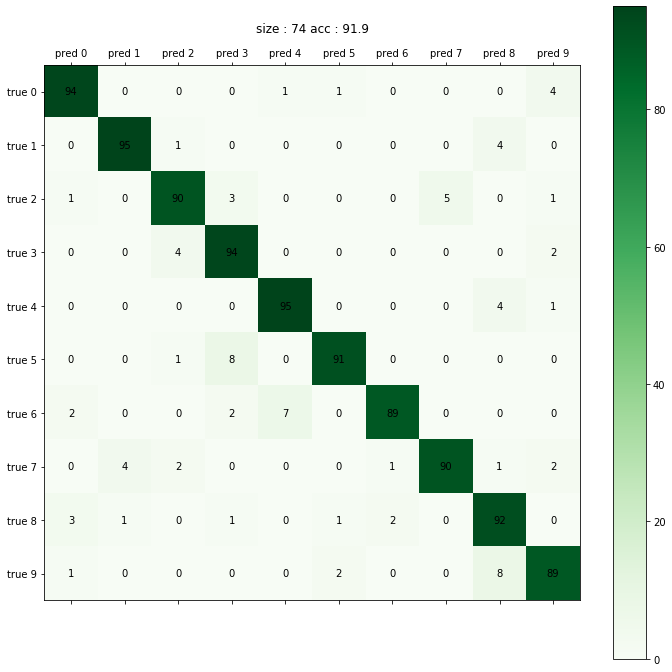

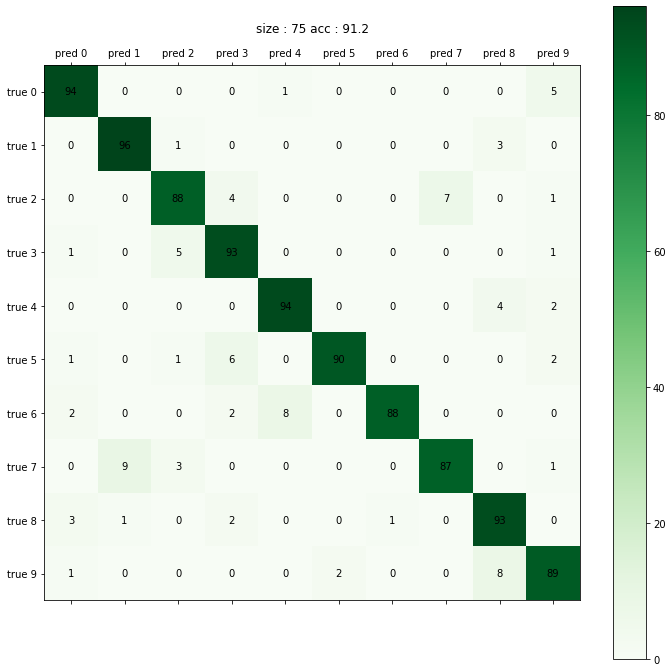

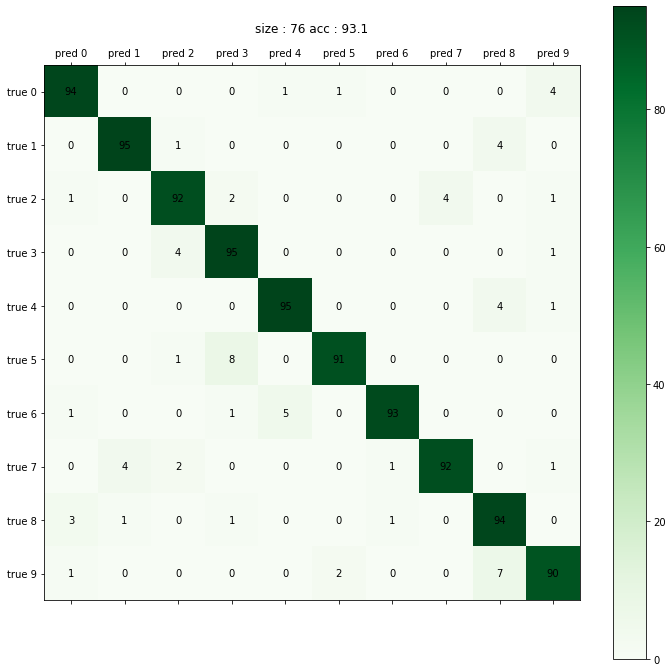

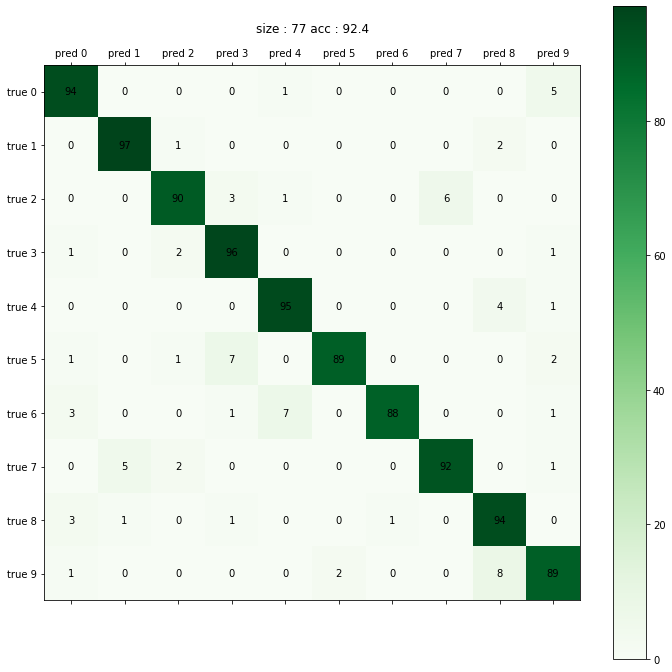

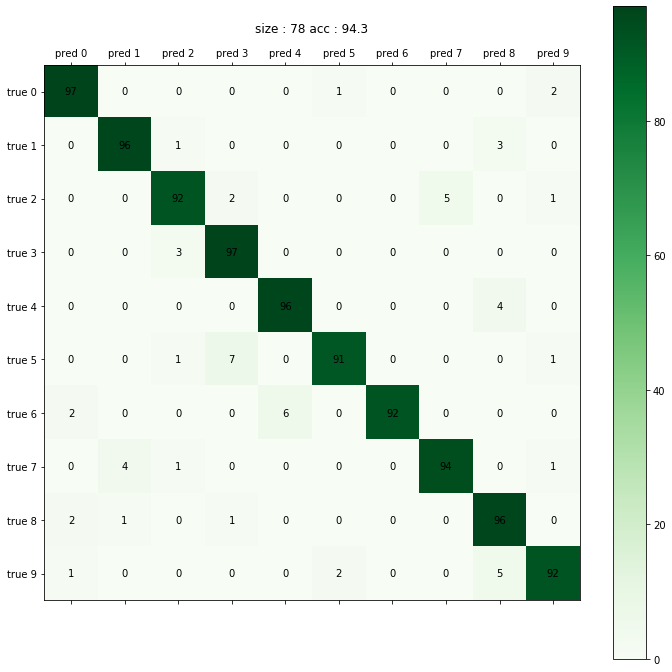

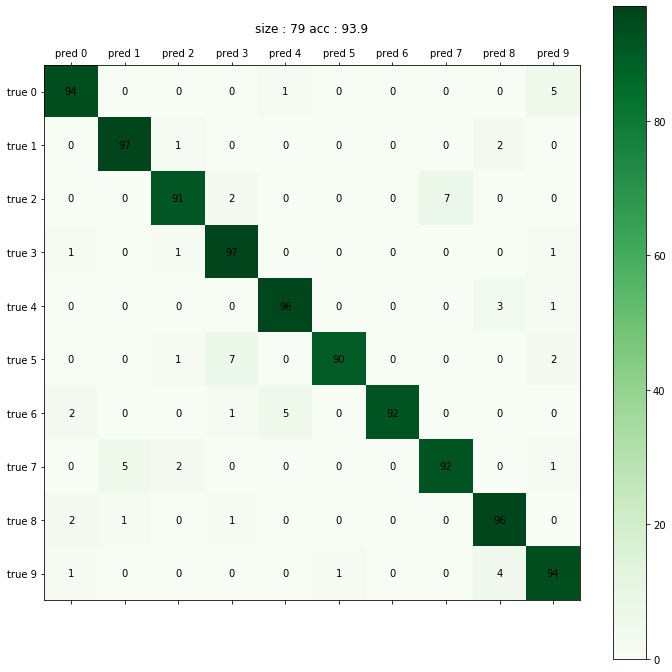

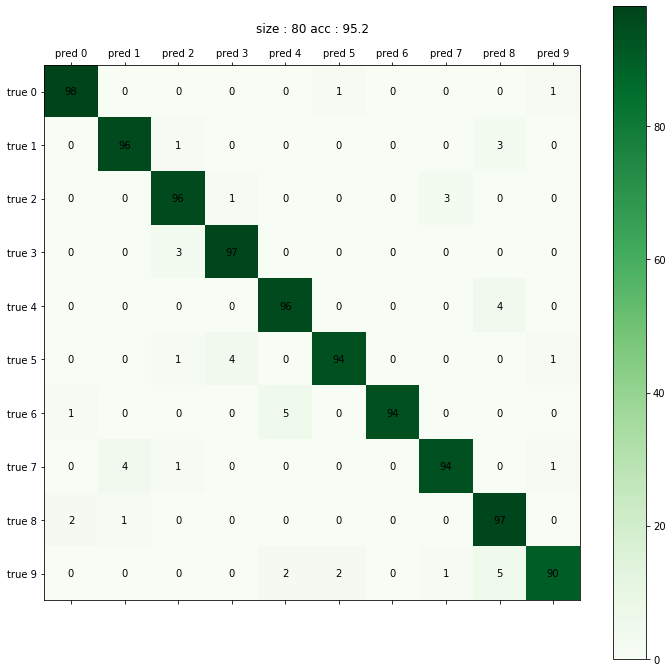

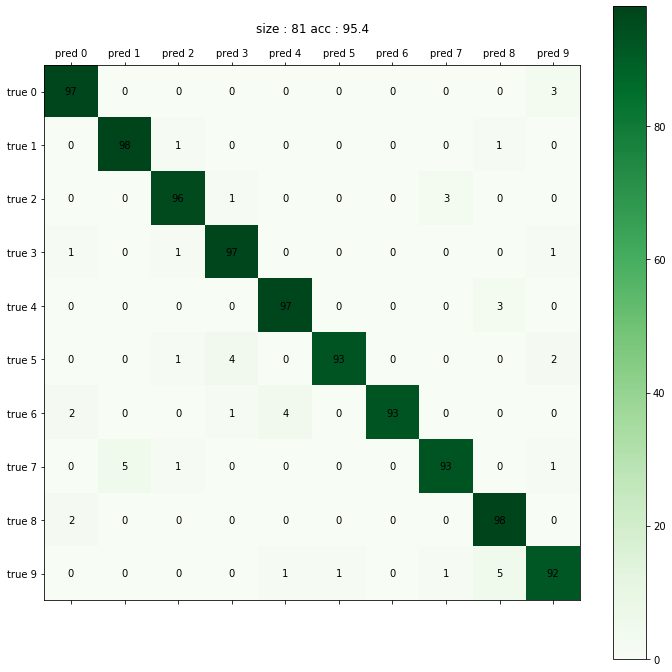

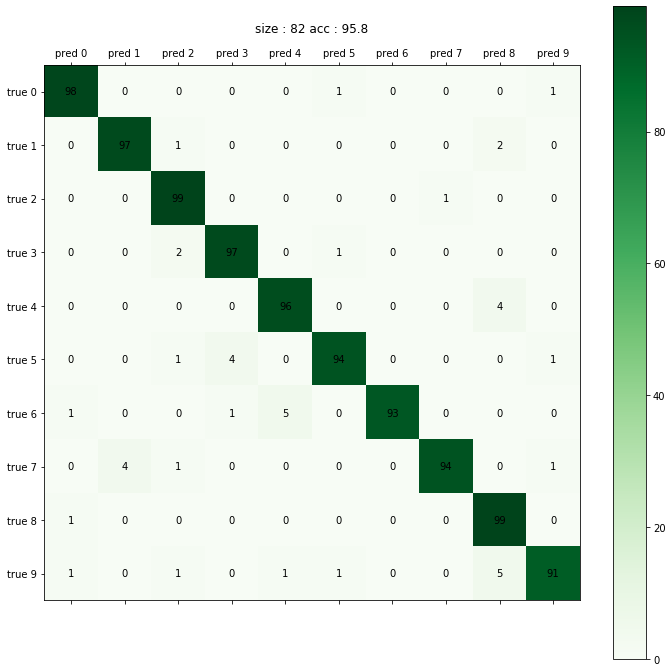

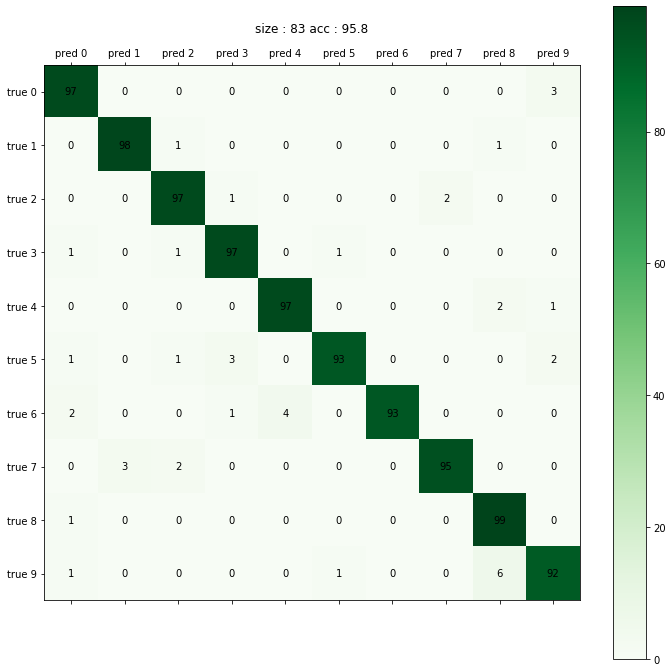

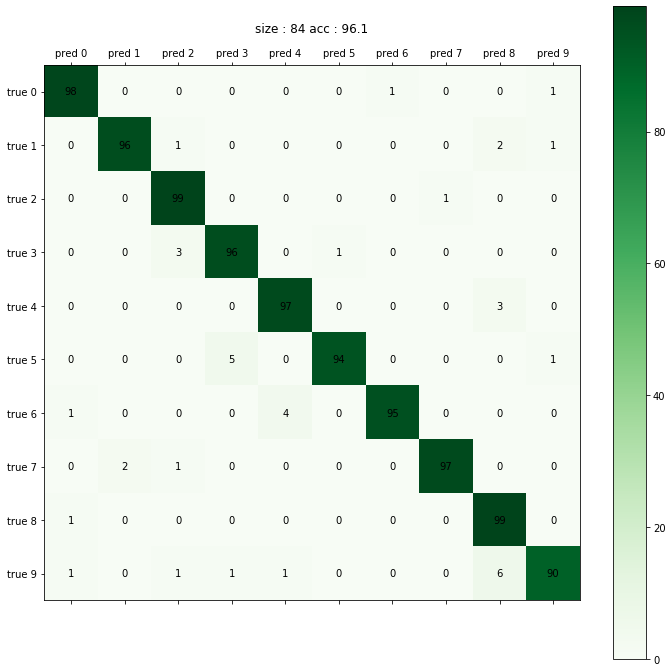

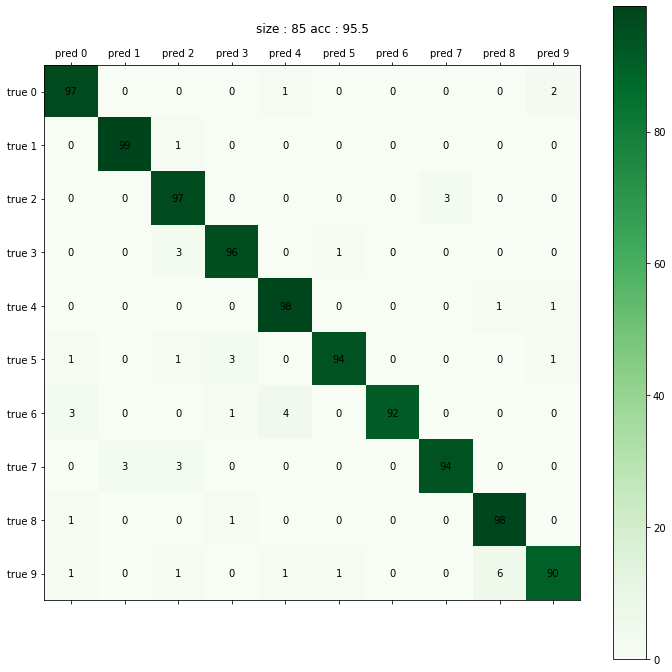

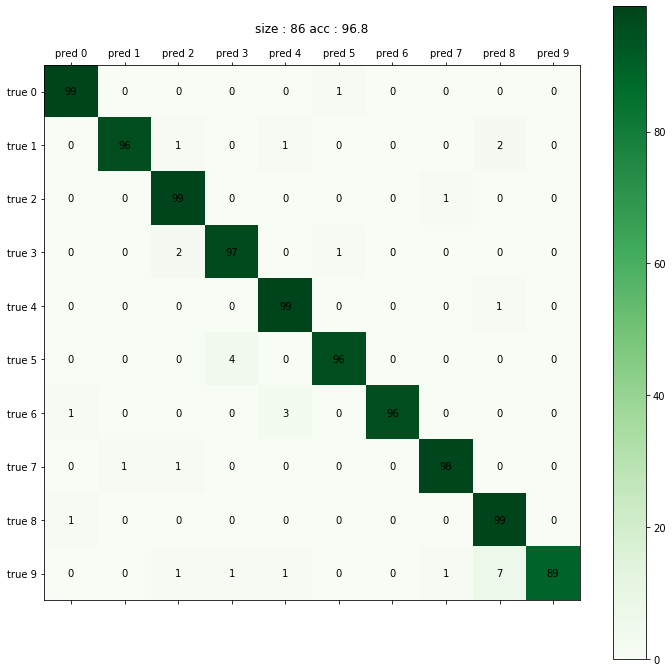

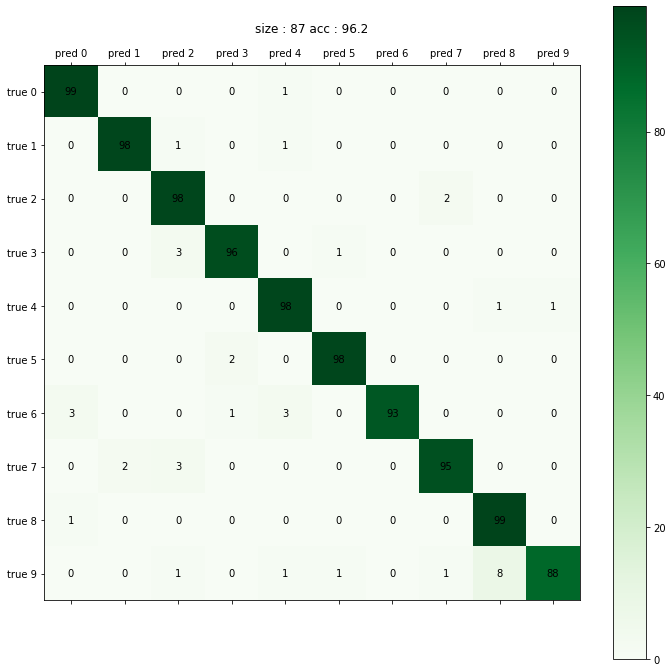

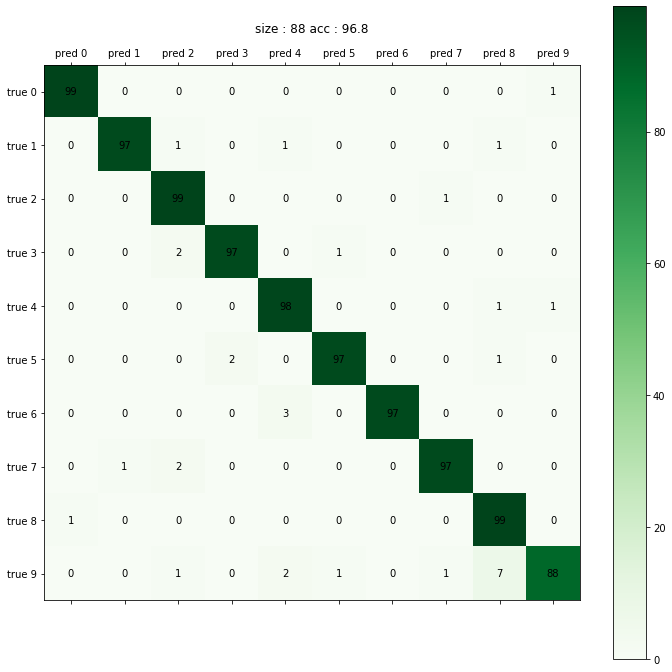

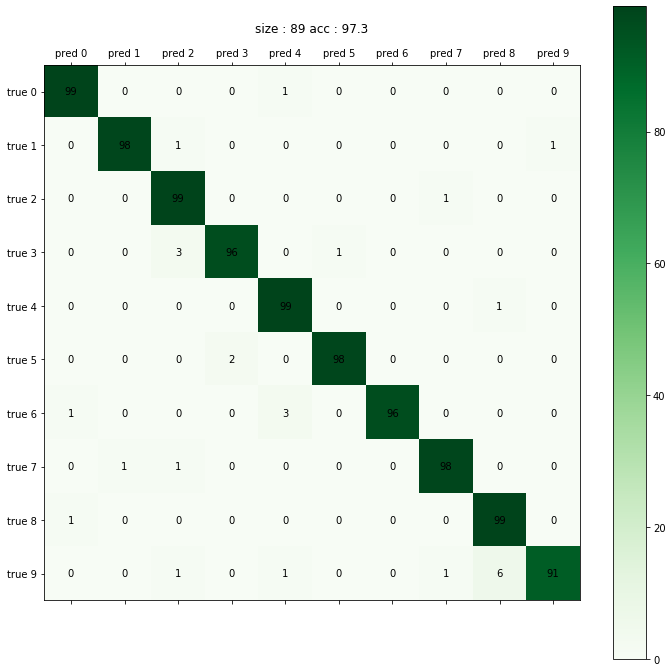

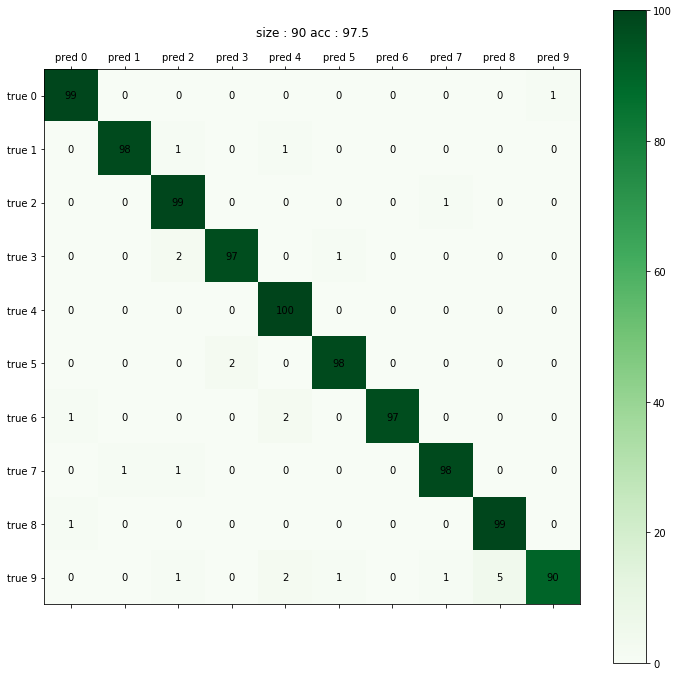

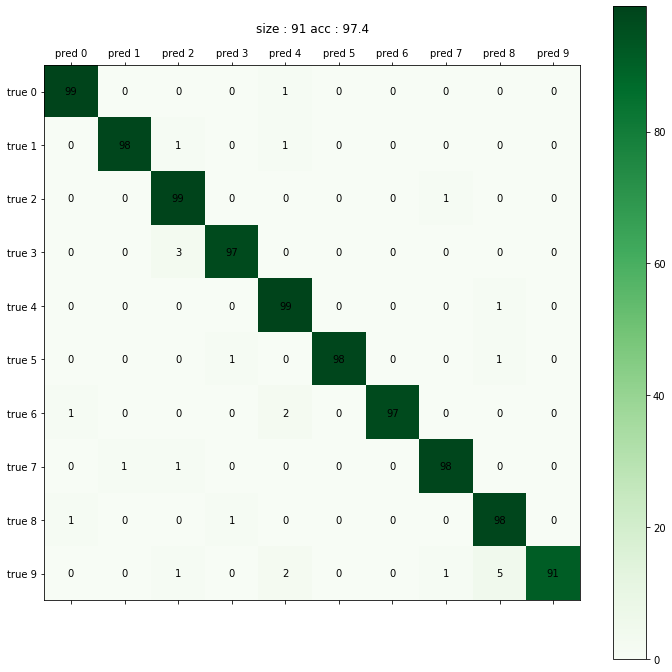

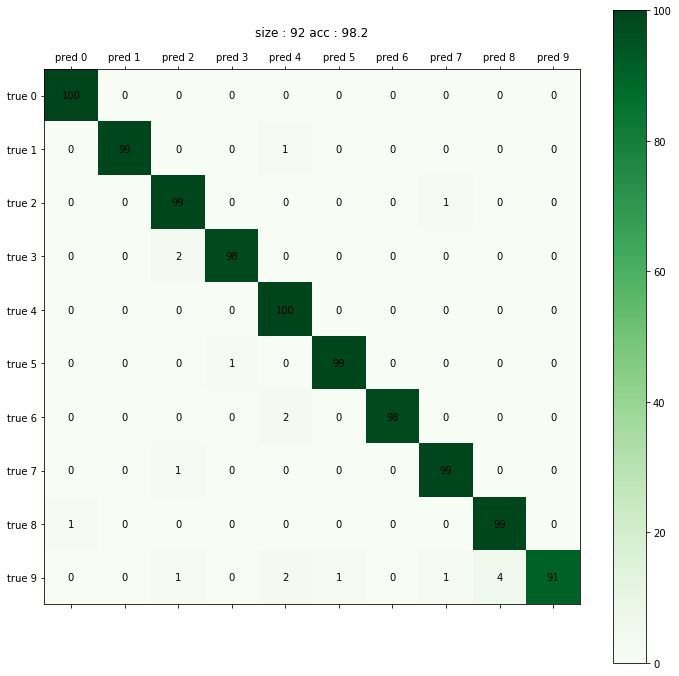

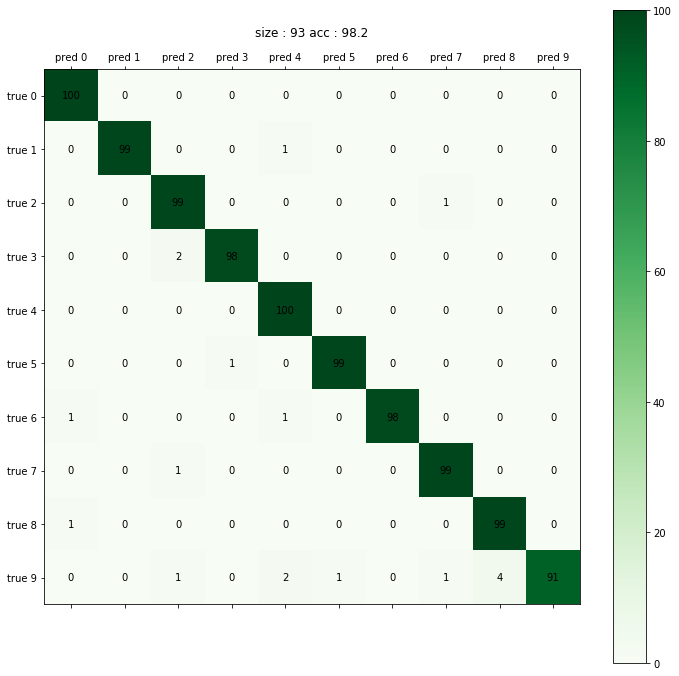

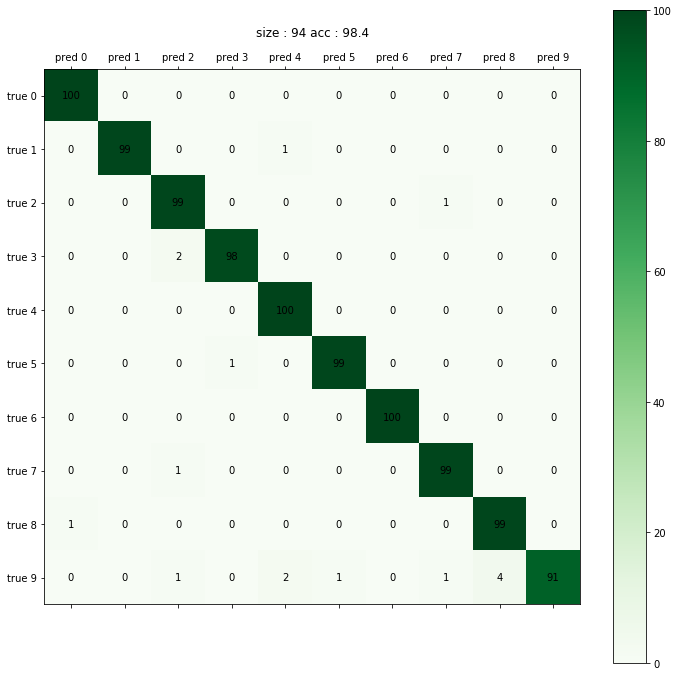

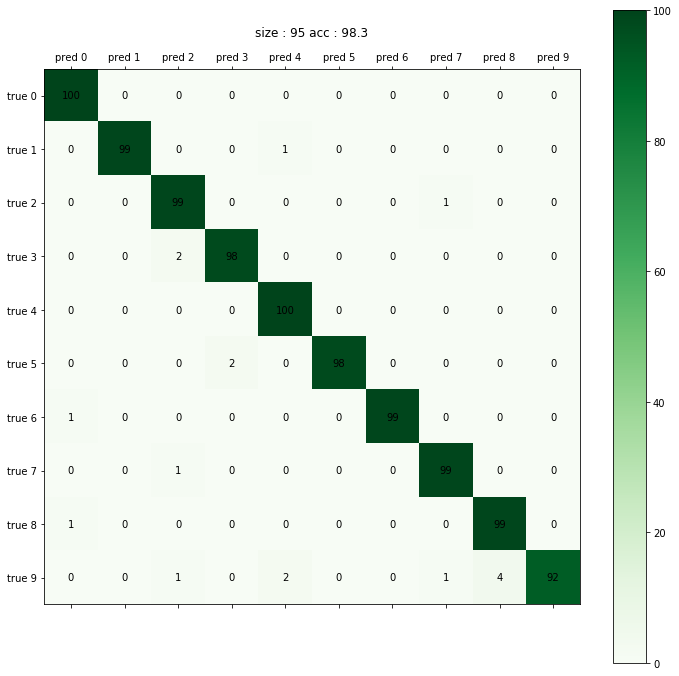

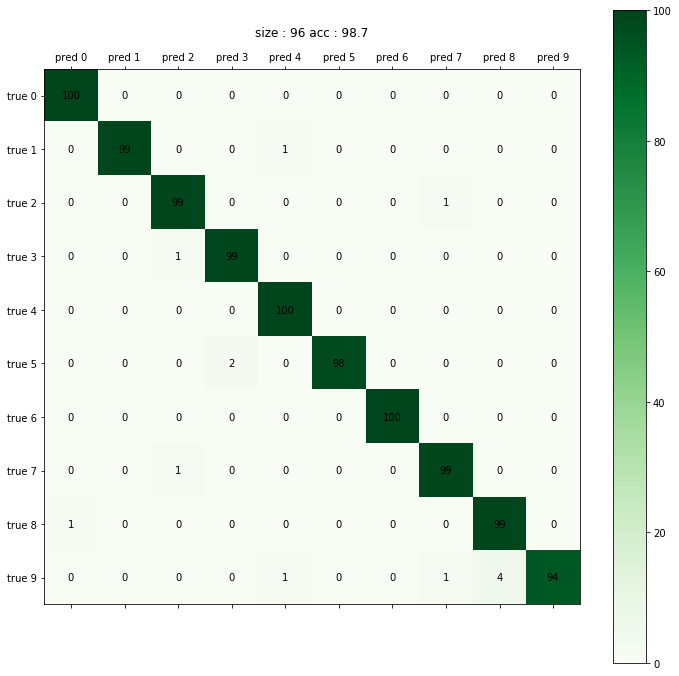

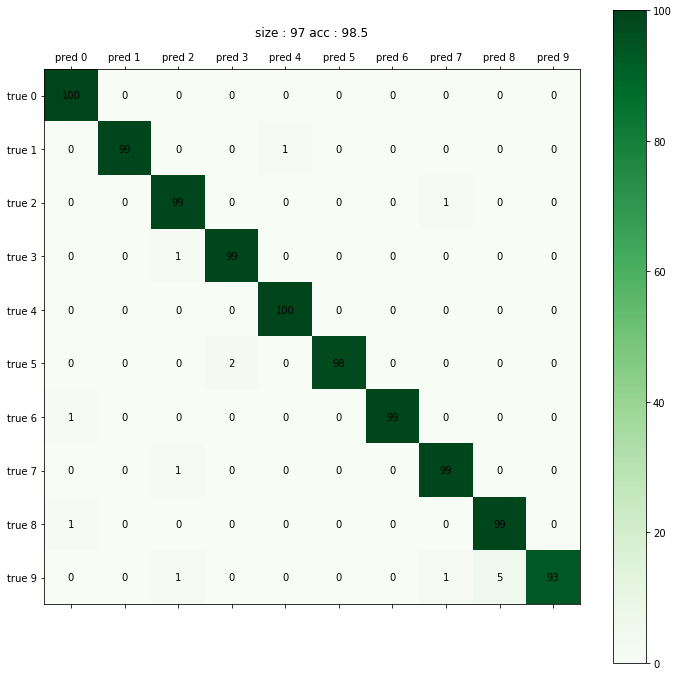

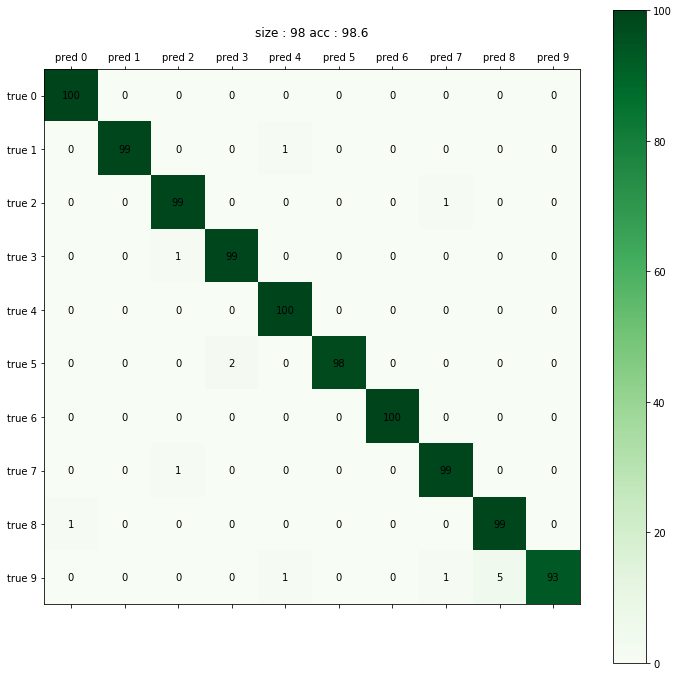

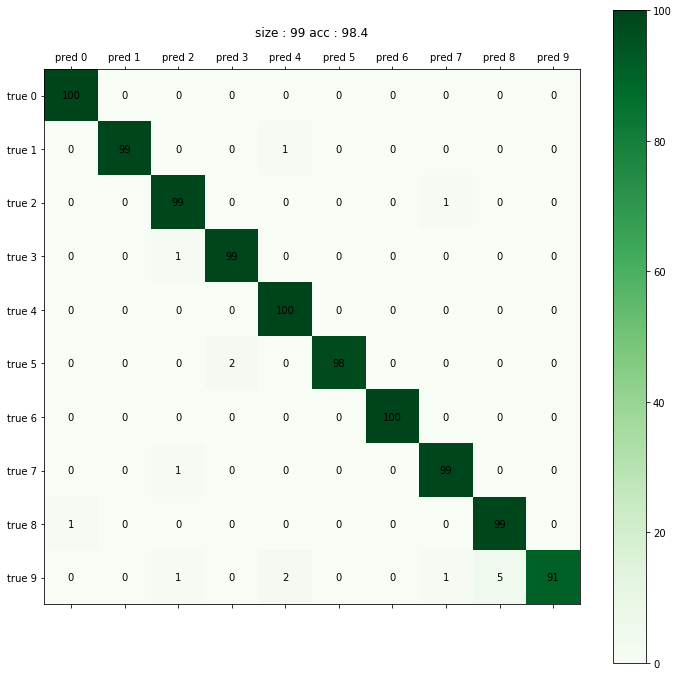

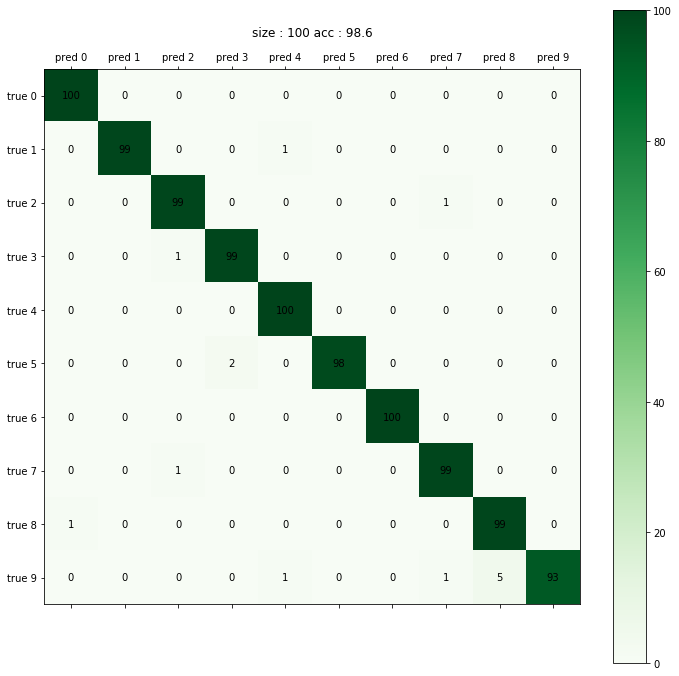

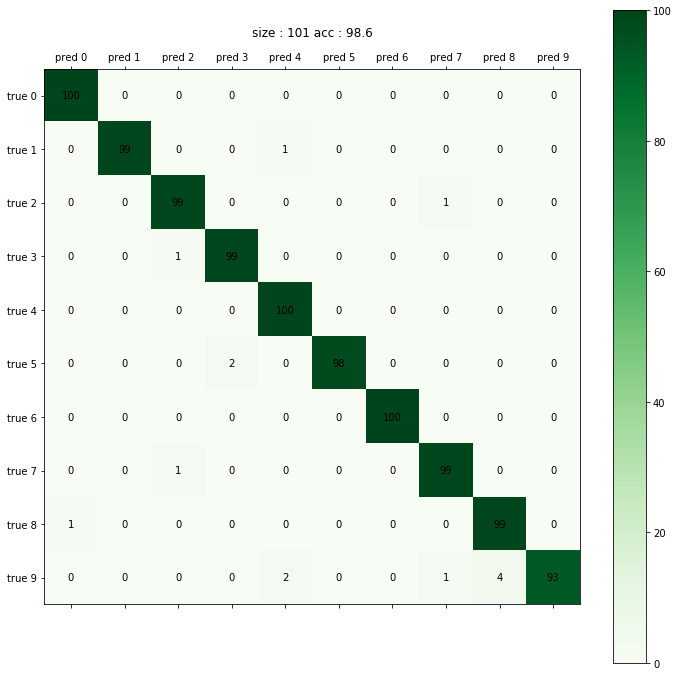

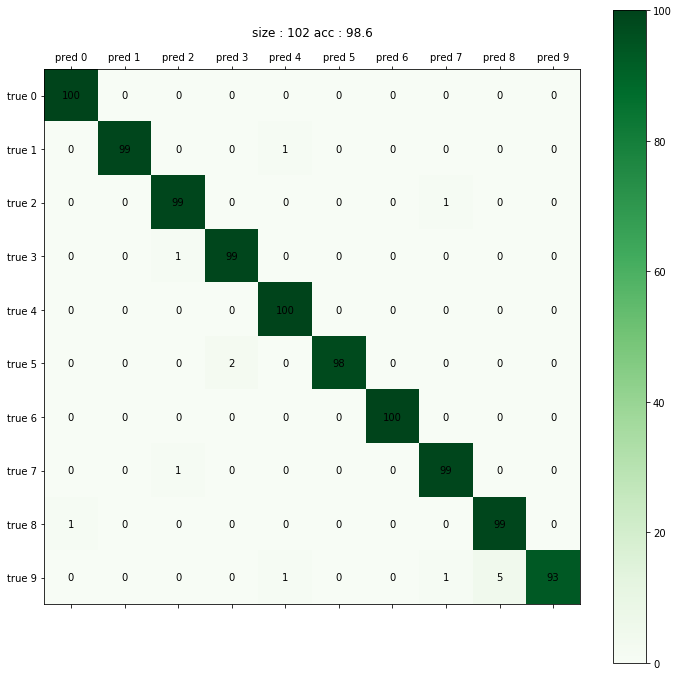

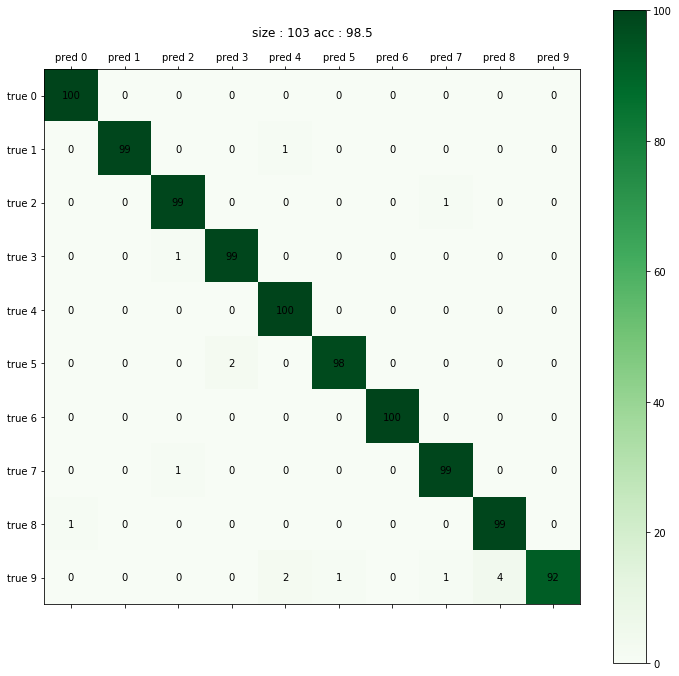

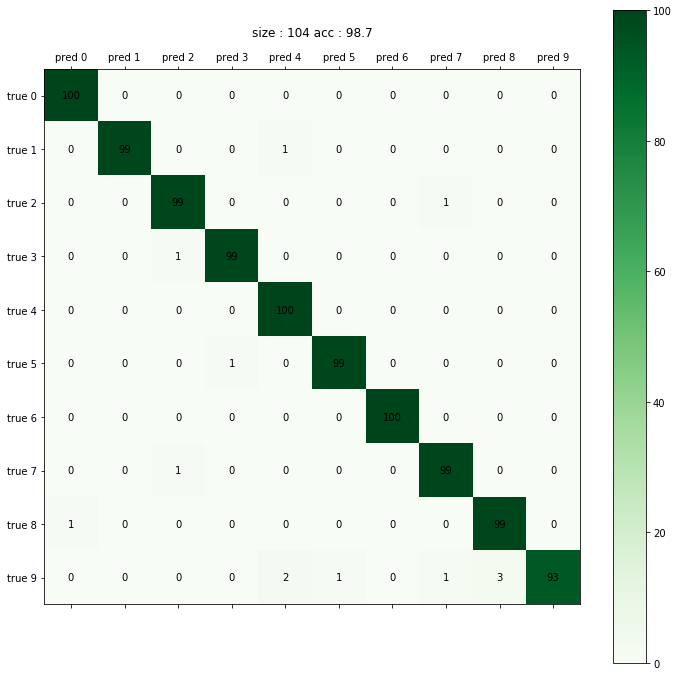

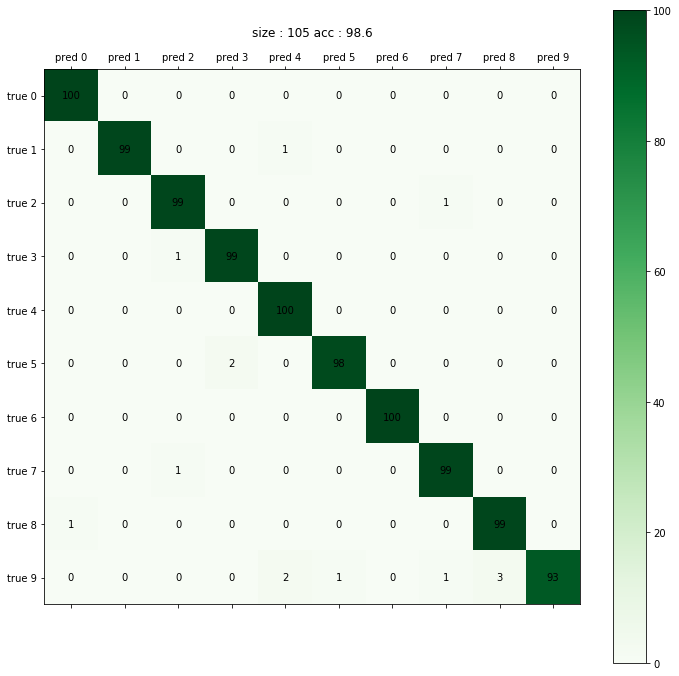

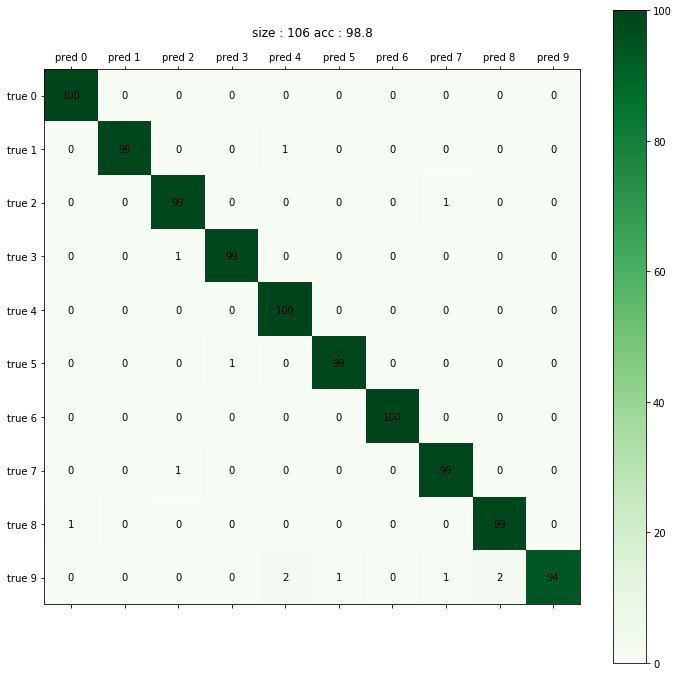

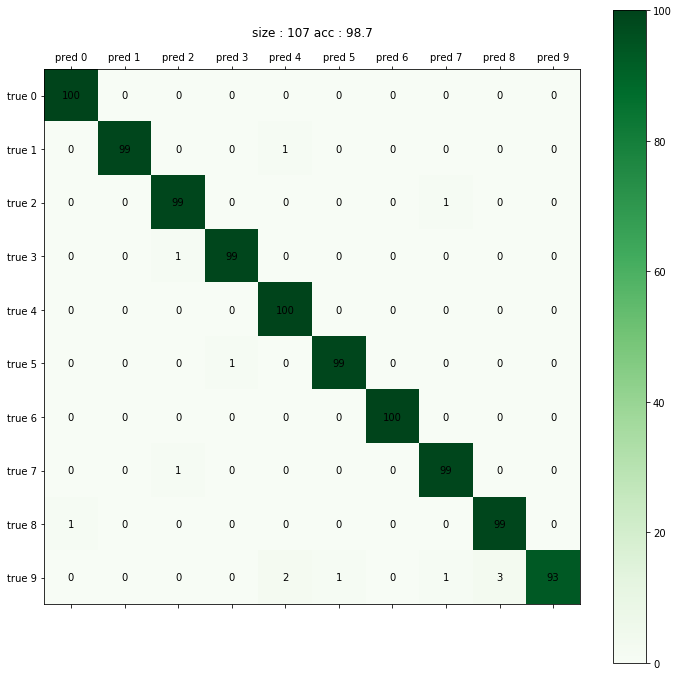

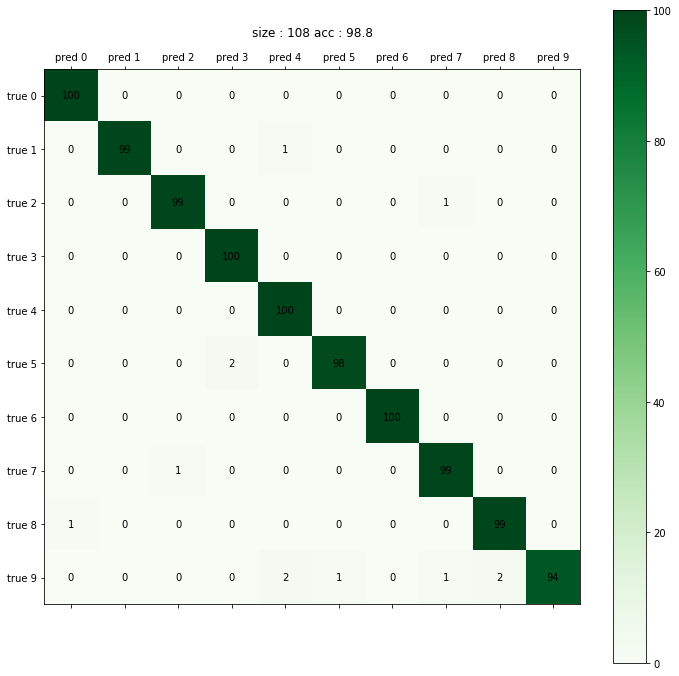

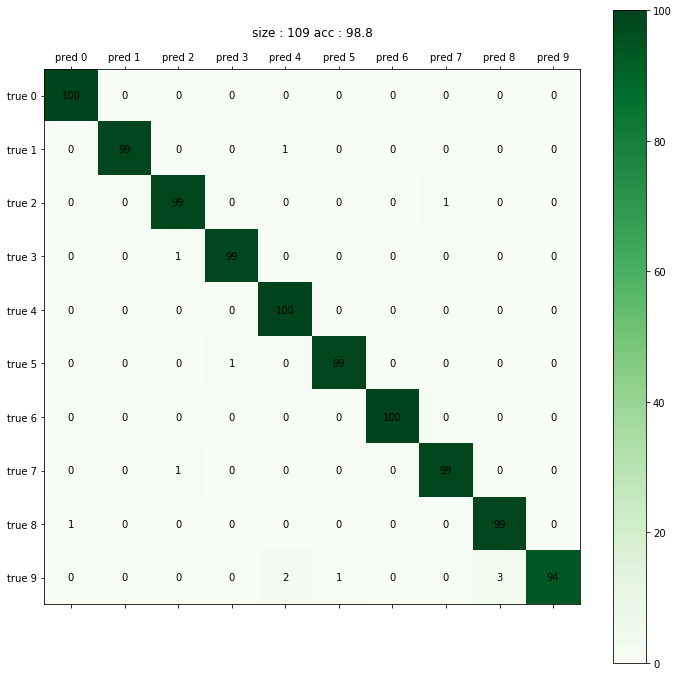

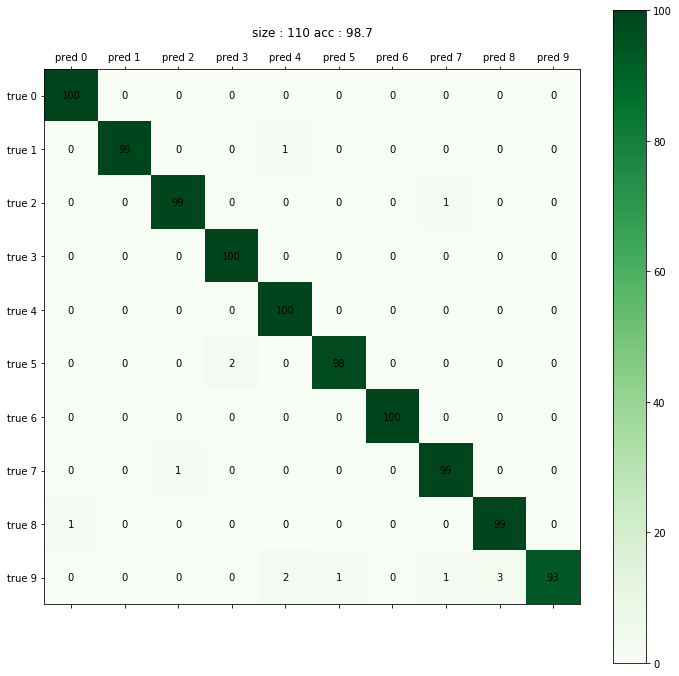

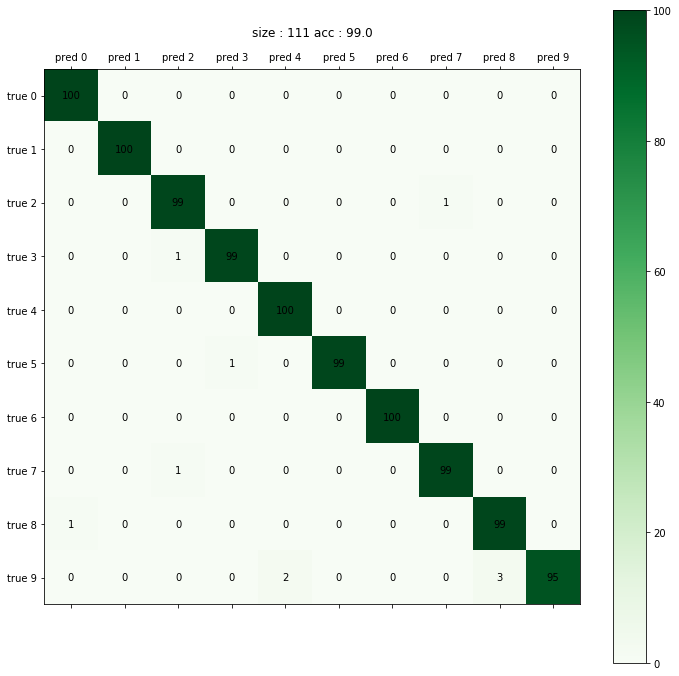

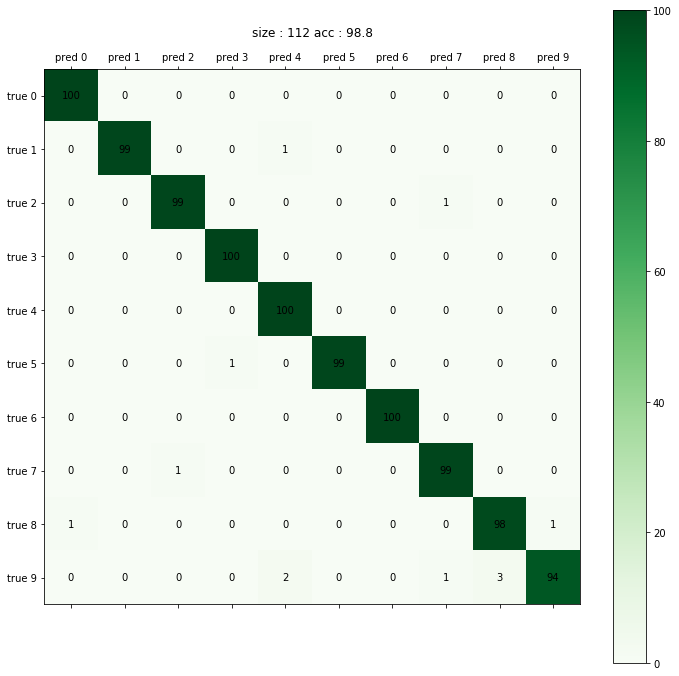

In [36]:
for size in range(0,112):
    fig = plt.figure(figsize=(12,12))
    pred_name = ['pred '+str(x) for x in range(0,10)]
    actual_name = ['true '+str(x) for x in range(0,10)]
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion_sum[size],cmap = plt.cm.Greens)
    fig.colorbar(cax)
    ticks = np.arange(0,10,1)

    ind_array = np.arange(0, 10, 1)
    x, y = np.meshgrid(ind_array, ind_array)

    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = str(confusion_sum[size][y_val][x_val])
        ax.text(x_val, y_val, c, va='center', ha='center')

    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(pred_name)
    ax.set_yticklabels(actual_name)
    ax.set_title('size : '+str(size+1)+' acc : '+str(temp_acc[size]))
    #plt.matshow(confusion_sum[0])
    plt.savefig('confusion_2x_respool/confusion'+str(size)+'.png')
    plt.show()

In [38]:
import cv2

frame_array = []
for i in range(0,112):
    filename='confusion_2x_respool/confusion' + str(i)+'.png'
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)
    
out = cv2.VideoWriter('confusion_2x_respool/confusion_feb13.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 5, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

In [47]:
import os


SIZED_VAL_PATH = 'mnist_sized'
new_path = []
for i in range(1,113):
    new_path.append([os.path.join(SIZED_VAL_PATH,str(i))])

#new_path.sort(key=lambda x:int(x[0].split('/')[1]))

gradcam_gen_arr = []
for i in tqdm(range(0,len(new_path))):
    transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))])

    testMnistDataset = SizedMnistDataset(new_path[i],transform)

    testloader = torch.utils.data.DataLoader(testMnistDataset,
                                              batch_size = batch_size, 
                                              shuffle=False,
                                            num_workers=8)
    gradcam_gen_arr.append(testloader)
#
#val_gen_arr
accuracy = []


100%|██████████| 112/112 [00:00<00:00, 324.34it/s]


In [32]:
model1.eval()
model2.eval()
gcam = GradCAM(model=model1)
gbp = GuidedBackPropagation(model=model2)

In [33]:
for name, module in model1.named_modules():
    print(name)


module
module.prepool1
module.prepool2
module.sc1
module.sc1.conv1
module.sc1.conv2
module.sc1.conv3
module.sc1.bn1_1
module.sc1.bn2_1
module.sc1.bn3_1
module.sc1.pad
module.sc2
module.sc2.conv1
module.sc2.conv2
module.sc2.conv3
module.sc2.bn1_1
module.sc2.bn2_1
module.sc2.bn3_1
module.sc2.pad
module.sc3
module.sc3.conv1
module.sc3.conv2
module.sc3.conv3
module.sc3.bn1_1
module.sc3.bn2_1
module.sc3.bn3_1
module.sc3.pad
module.rp1
module.rp1.bigpool
module.rp1.midpool
module.rp1.smlpool
module.rp1.bn4
module.fc1
module.fc2
module.fc3


In [34]:
for i in gcam.fmap_pool.keys():
    print(i)


  0%|          | 0/112 [00:00<?, ?it/s]

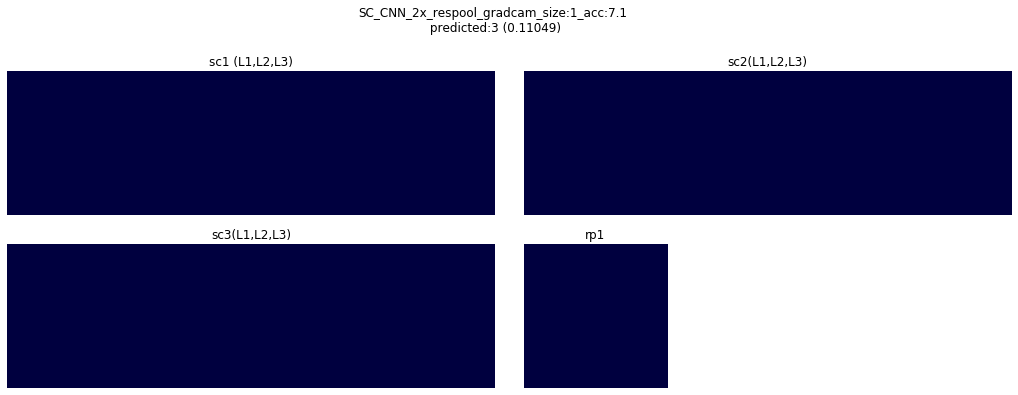


  1%|          | 1/112 [00:03<06:38,  3.59s/it]

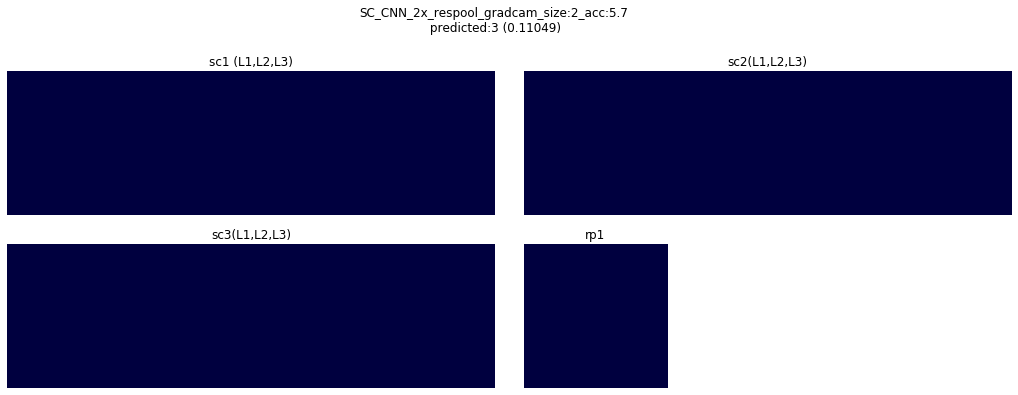


  2%|▏         | 2/112 [00:06<06:28,  3.53s/it]

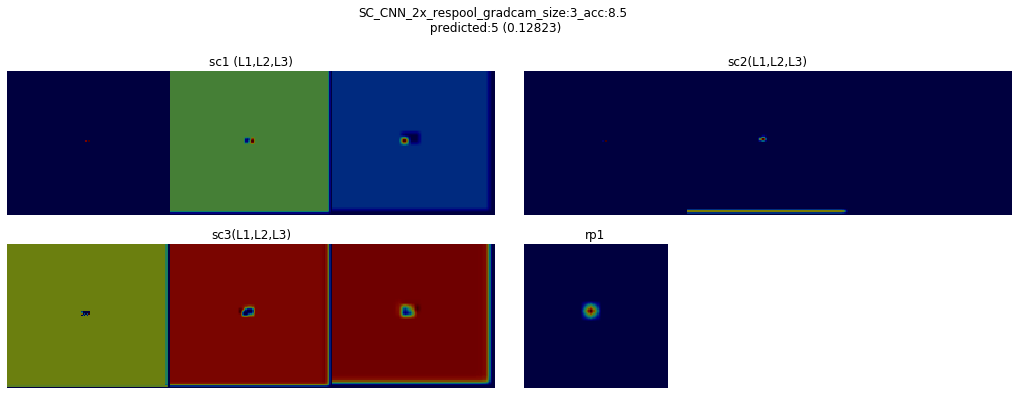


  3%|▎         | 3/112 [00:09<06:03,  3.33s/it]

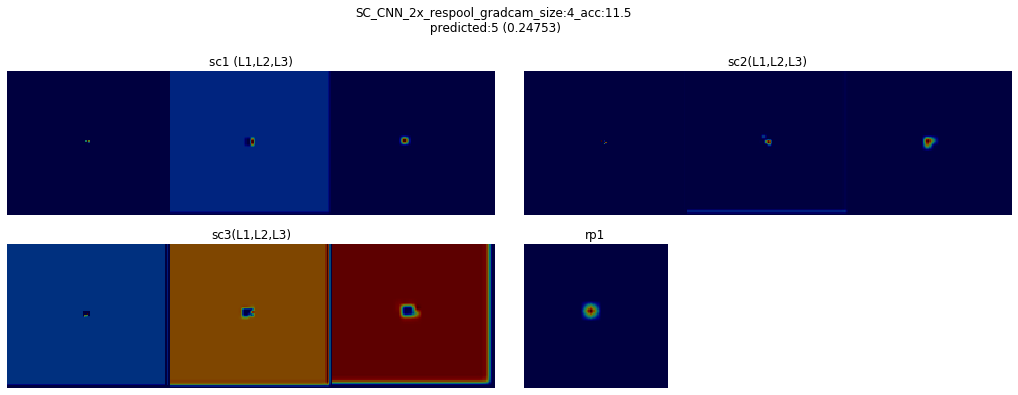


  4%|▎         | 4/112 [00:12<05:43,  3.18s/it]

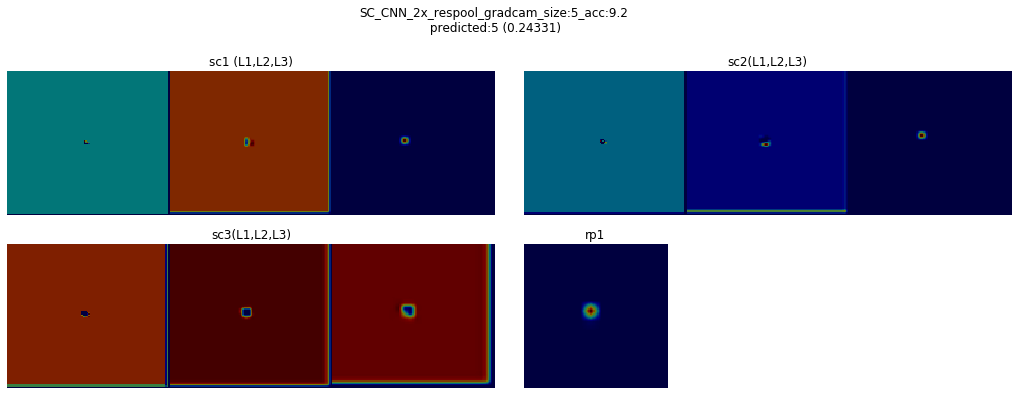


  4%|▍         | 5/112 [00:15<05:28,  3.07s/it]

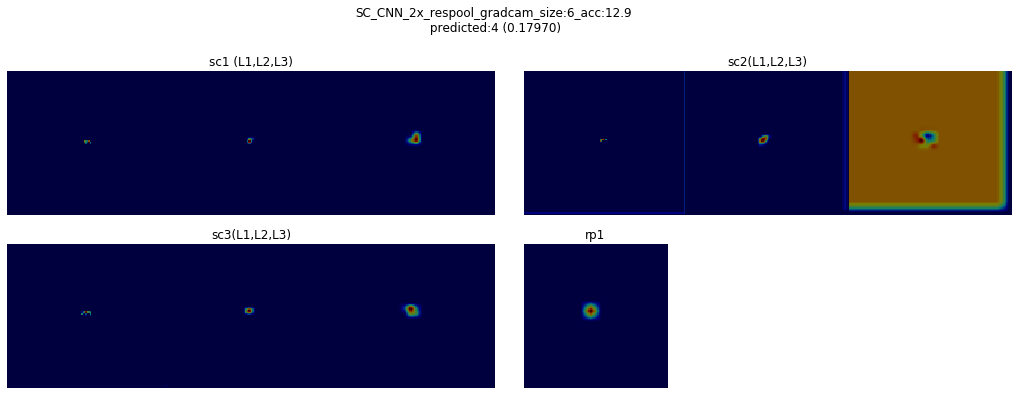


  5%|▌         | 6/112 [00:18<05:18,  3.00s/it]

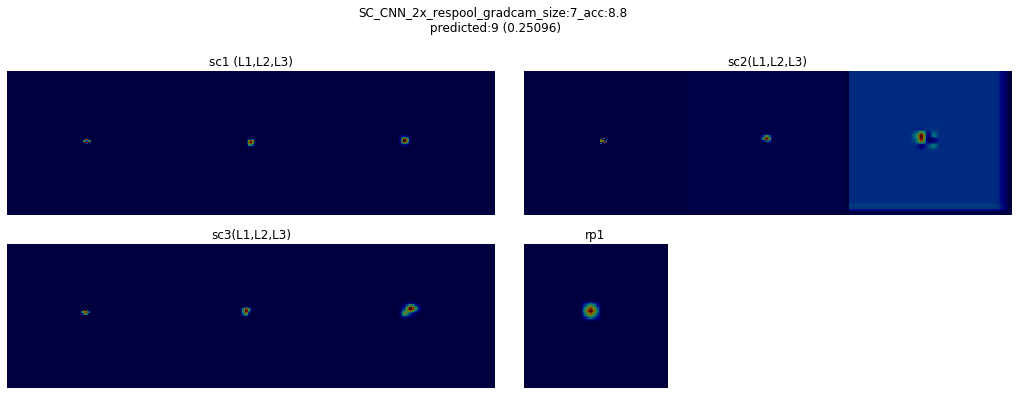


  6%|▋         | 7/112 [00:21<05:14,  3.00s/it]

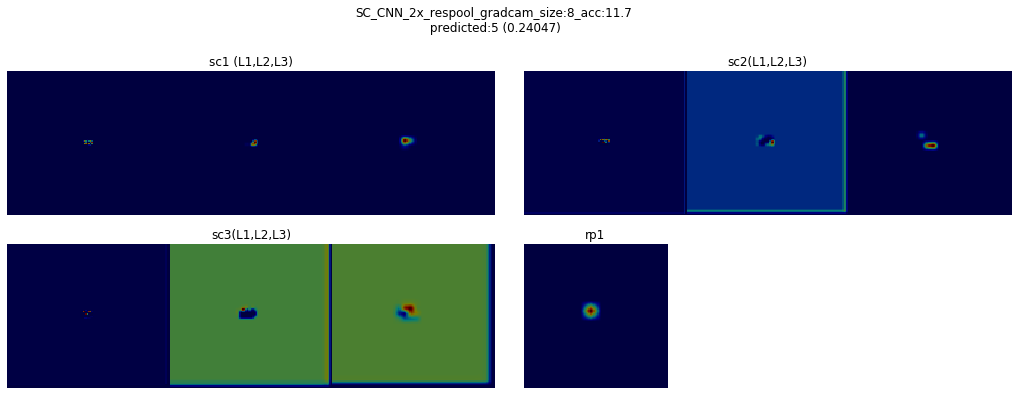


  7%|▋         | 8/112 [00:24<05:09,  2.98s/it]

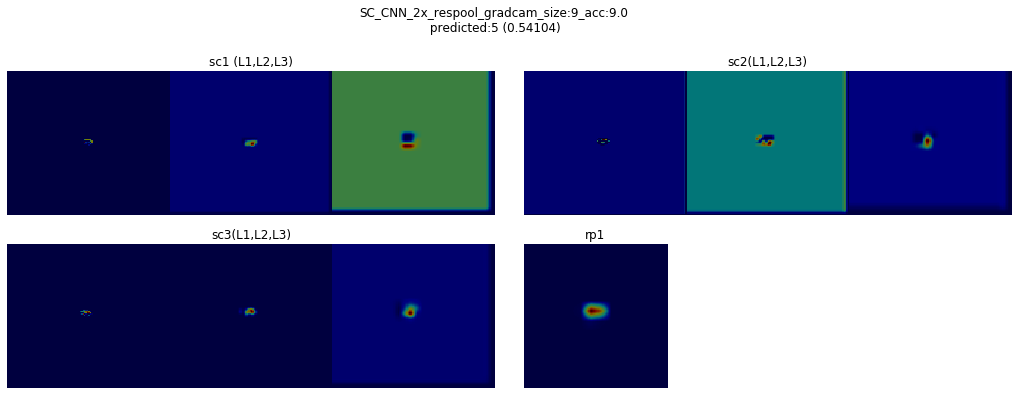


  8%|▊         | 9/112 [00:27<05:02,  2.93s/it]

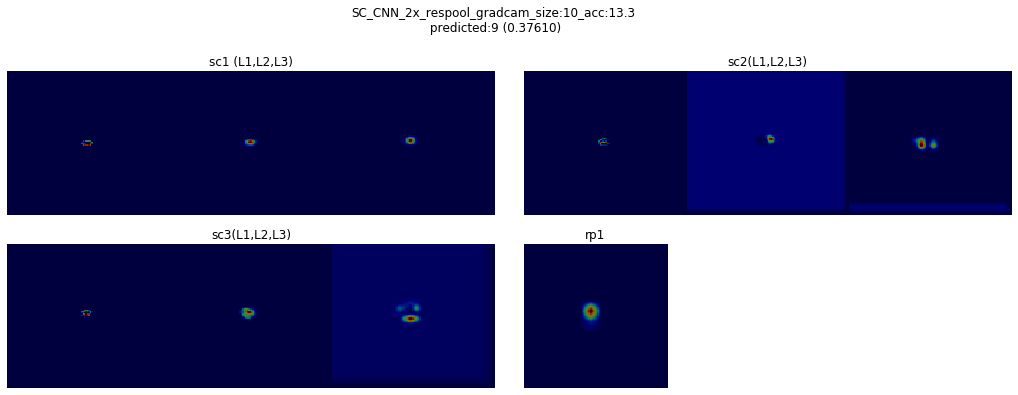


  9%|▉         | 10/112 [00:29<04:56,  2.91s/it]

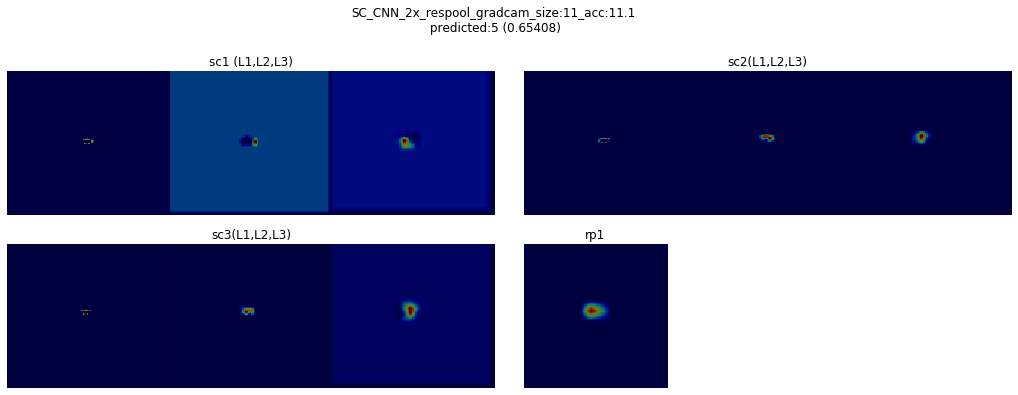


 10%|▉         | 11/112 [00:32<04:51,  2.89s/it]

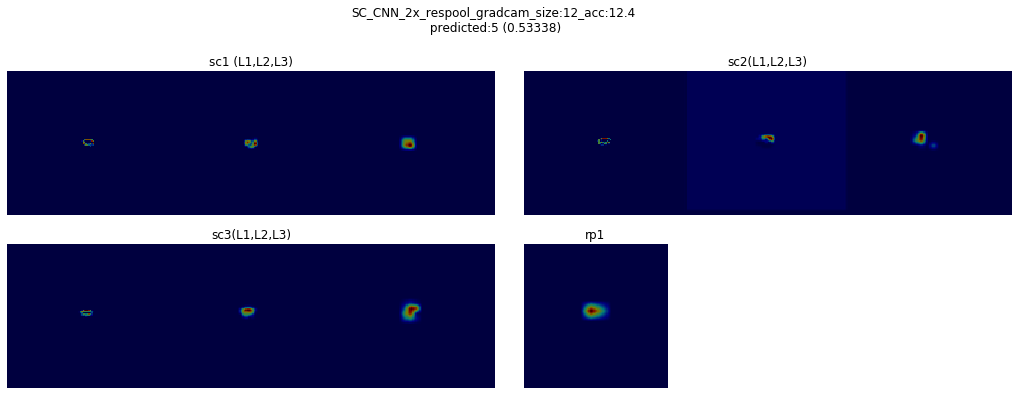


 11%|█         | 12/112 [00:35<04:46,  2.87s/it]

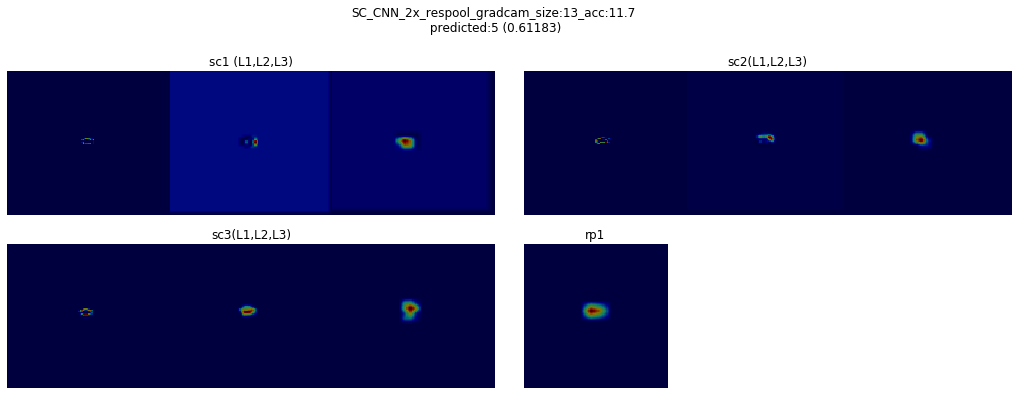


 12%|█▏        | 13/112 [00:39<05:03,  3.06s/it]

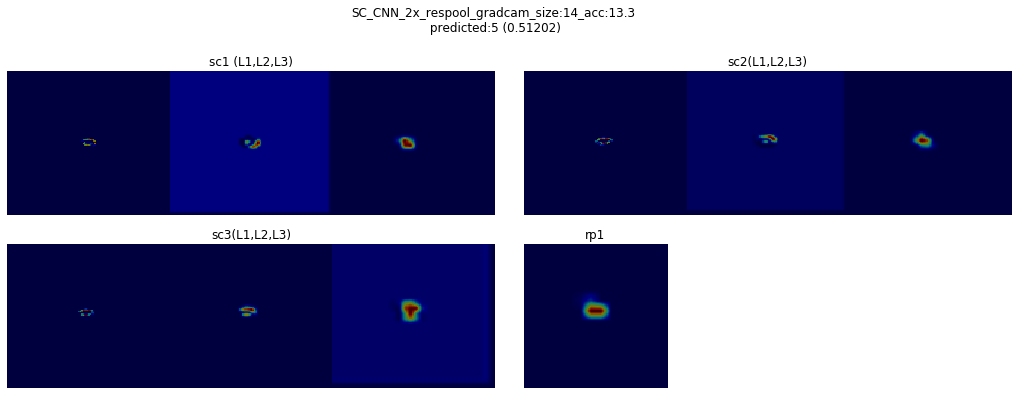


 12%|█▎        | 14/112 [00:41<04:55,  3.01s/it]

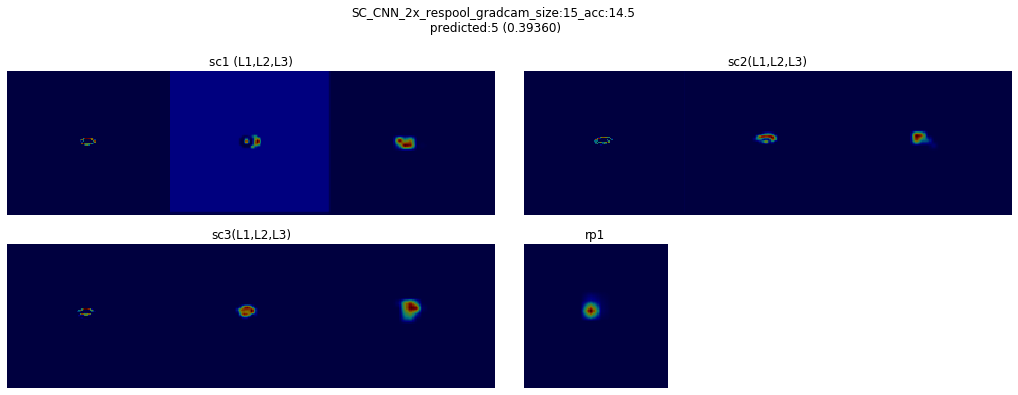


 13%|█▎        | 15/112 [00:44<04:48,  2.97s/it]

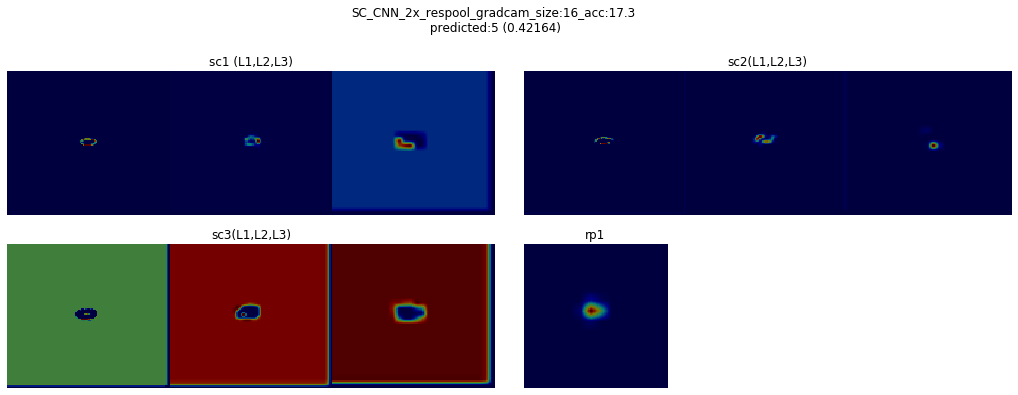


 14%|█▍        | 16/112 [00:47<04:42,  2.94s/it]

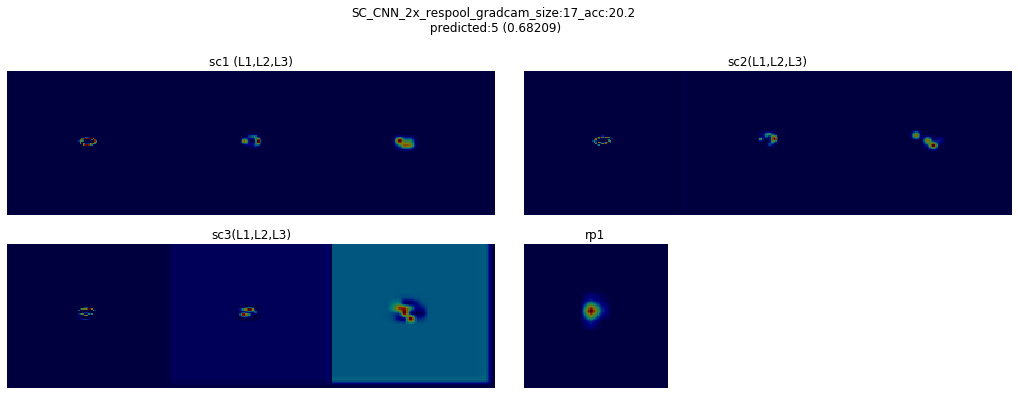


 15%|█▌        | 17/112 [00:50<04:37,  2.92s/it]

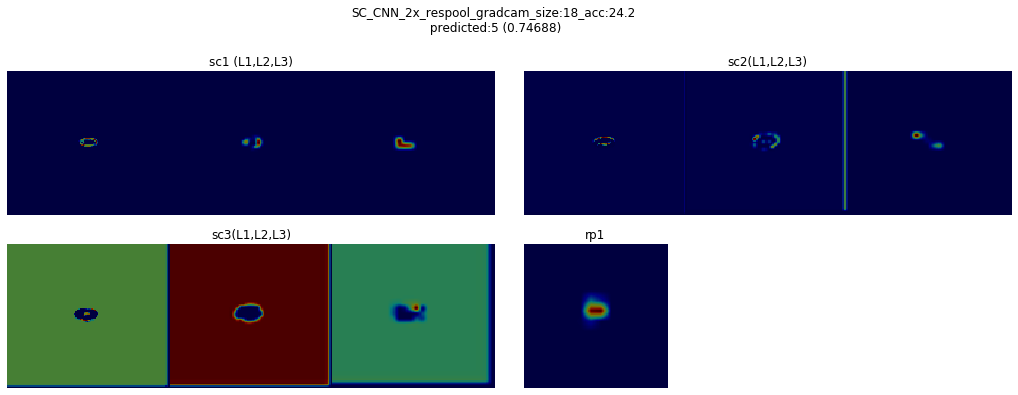


 16%|█▌        | 18/112 [00:53<04:34,  2.92s/it]

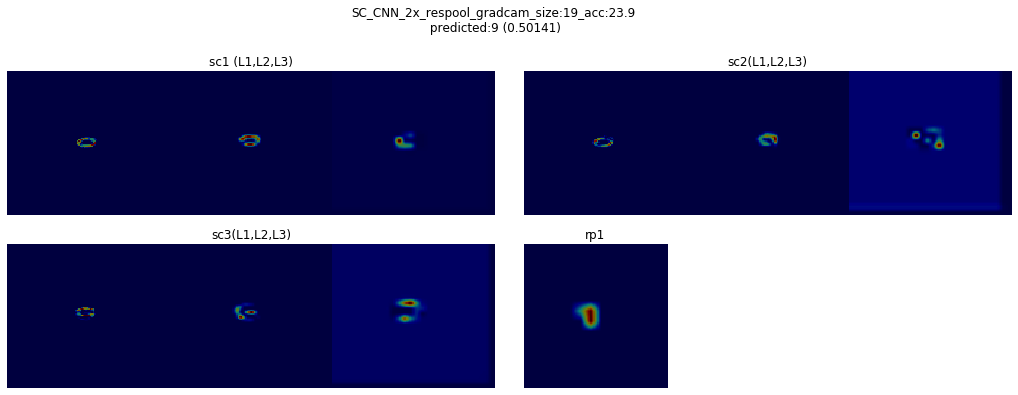


 17%|█▋        | 19/112 [00:56<04:30,  2.91s/it]

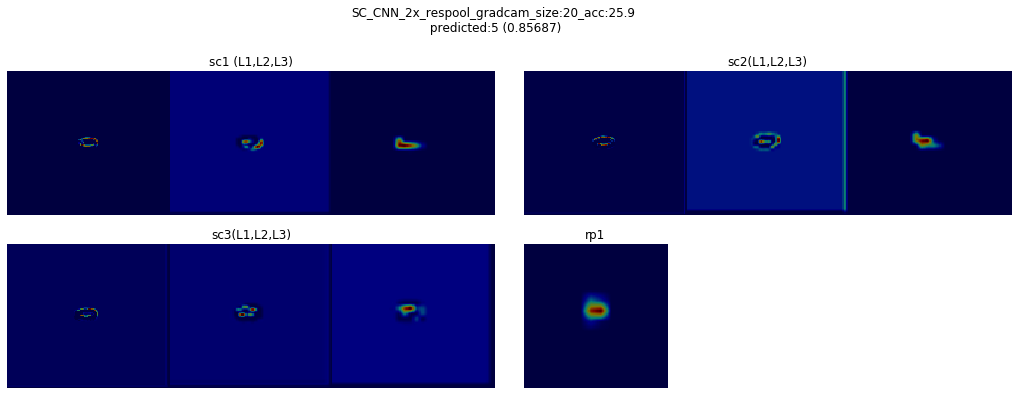


 18%|█▊        | 20/112 [00:59<04:25,  2.89s/it]

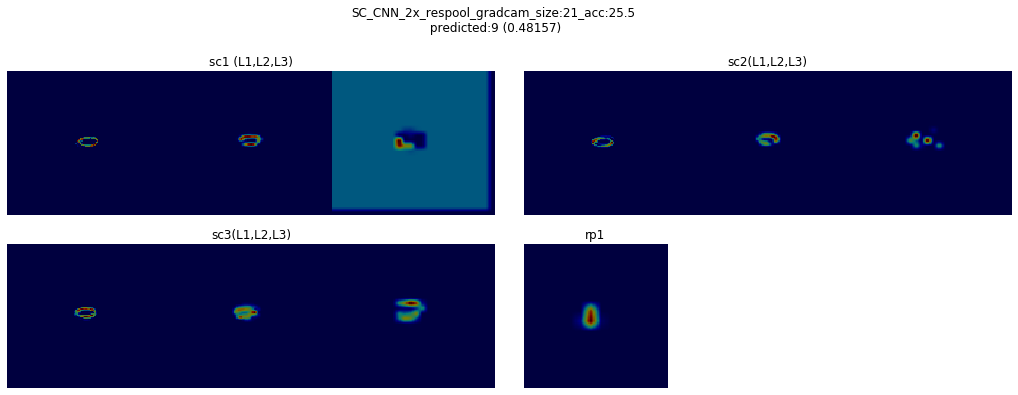


 19%|█▉        | 21/112 [01:02<04:22,  2.88s/it]

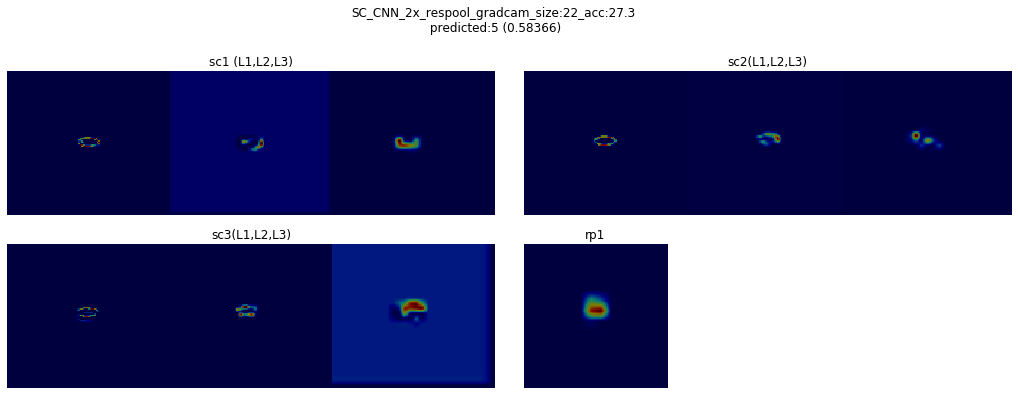


 20%|█▉        | 22/112 [01:04<04:17,  2.86s/it]

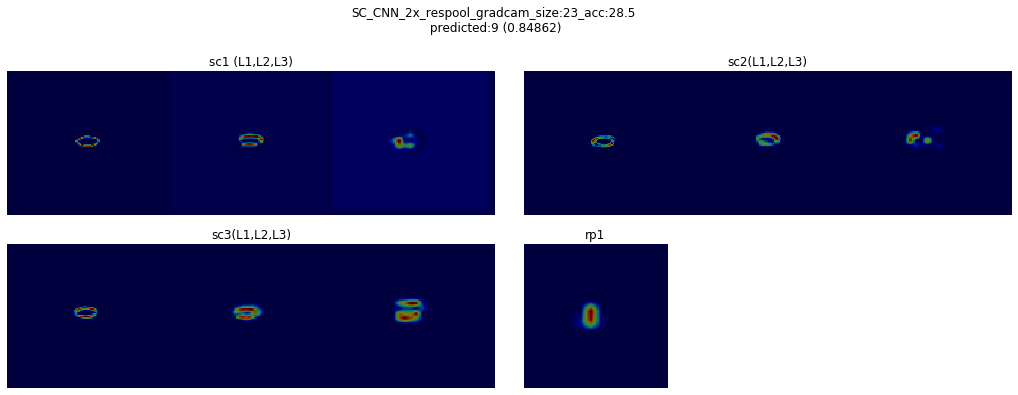


 21%|██        | 23/112 [01:07<04:13,  2.85s/it]

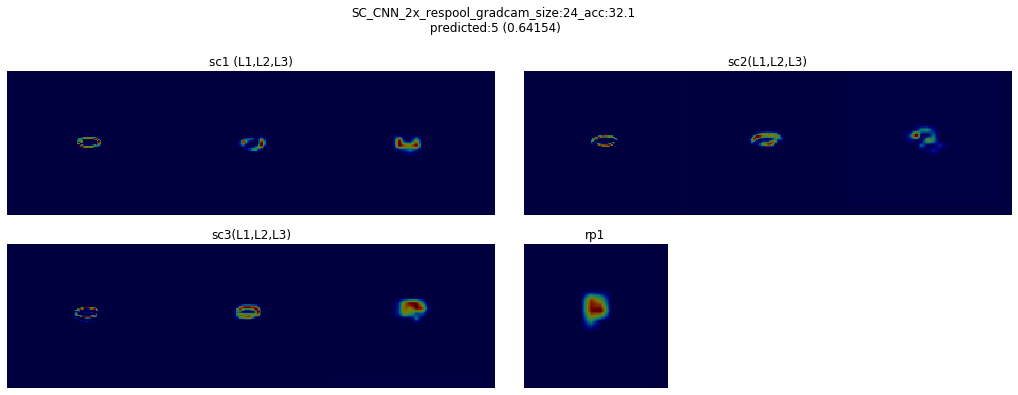


 21%|██▏       | 24/112 [01:10<04:18,  2.94s/it]

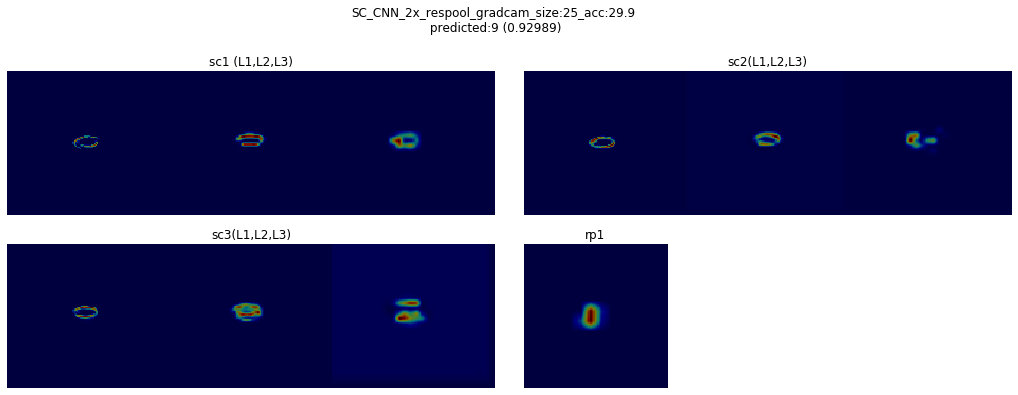


 22%|██▏       | 25/112 [01:13<04:13,  2.92s/it]

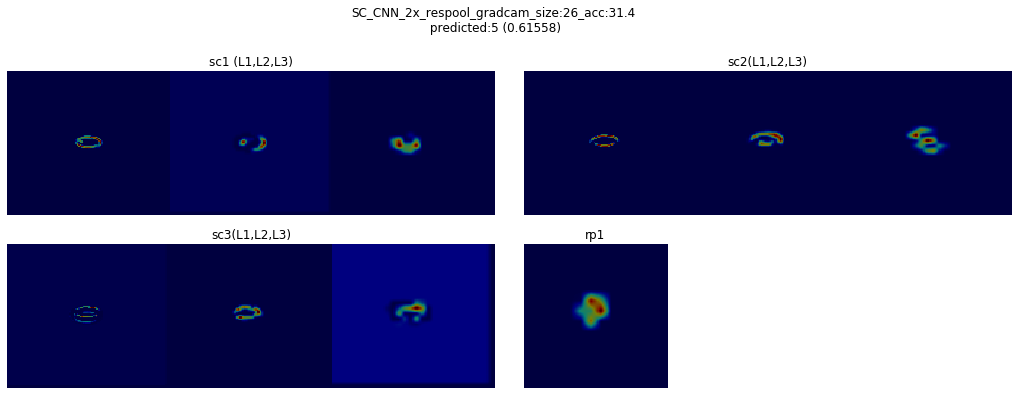


 23%|██▎       | 26/112 [01:16<04:09,  2.90s/it]

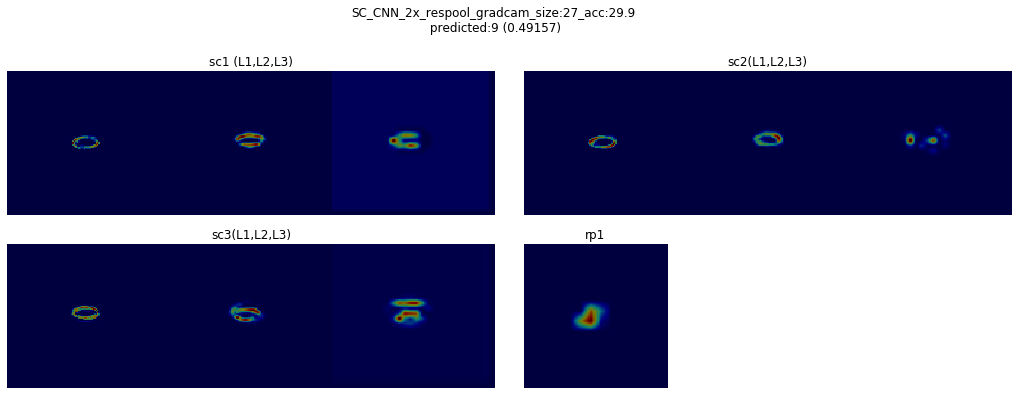


 24%|██▍       | 27/112 [01:19<04:05,  2.89s/it]

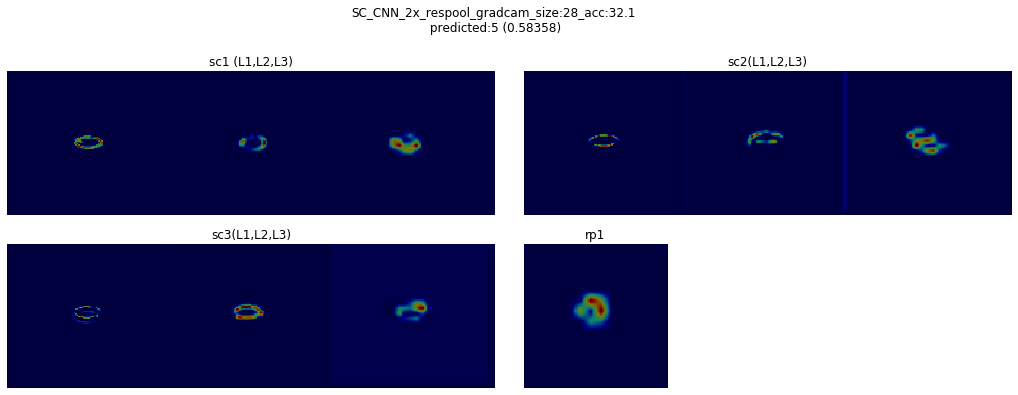


 25%|██▌       | 28/112 [01:22<04:01,  2.87s/it]

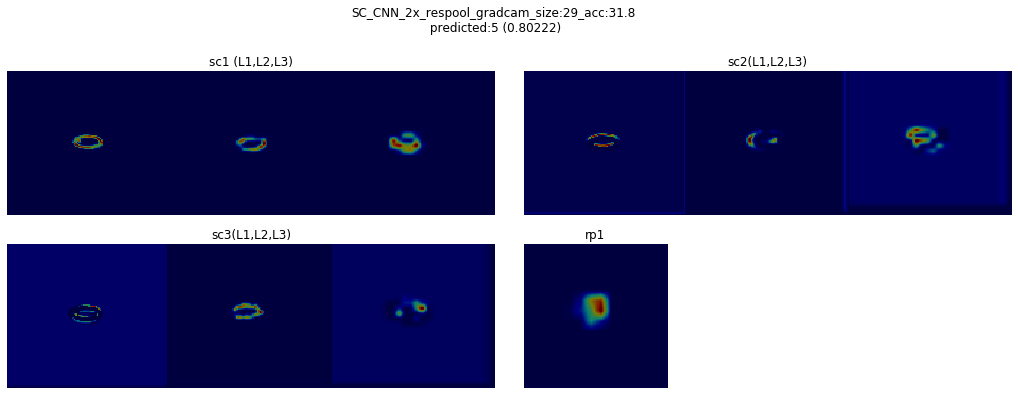


 26%|██▌       | 29/112 [01:25<04:00,  2.90s/it]

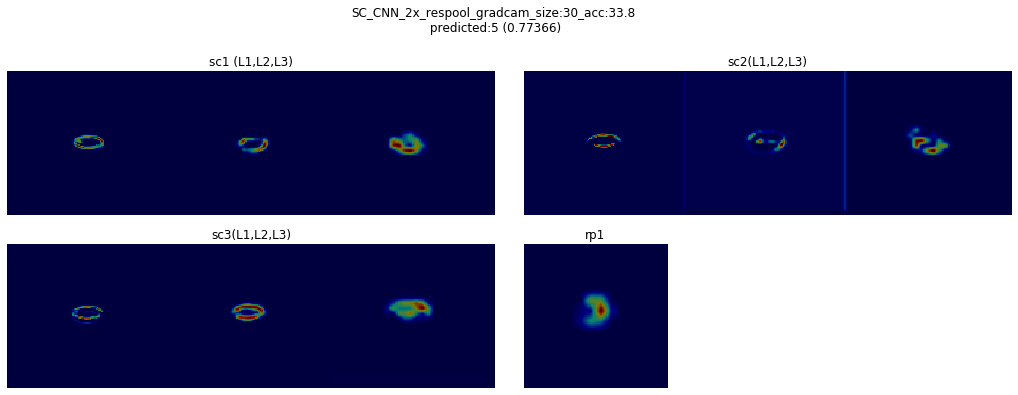


 27%|██▋       | 30/112 [01:28<03:56,  2.88s/it]

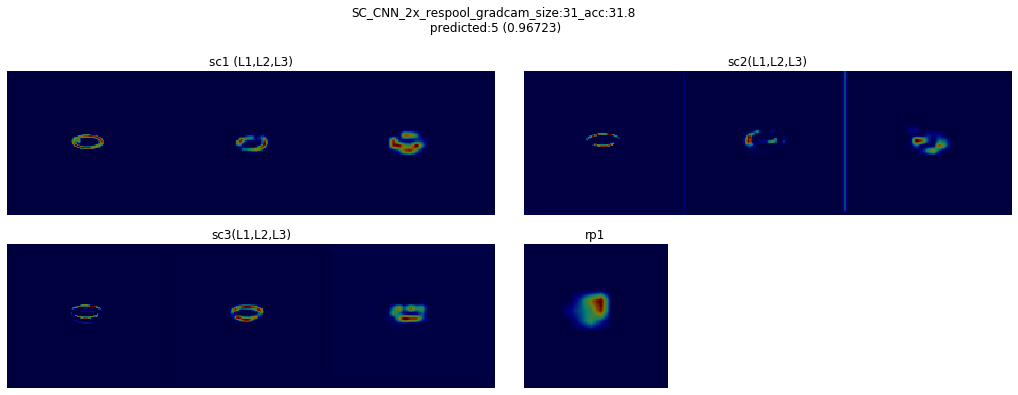


 28%|██▊       | 31/112 [01:30<03:52,  2.87s/it]

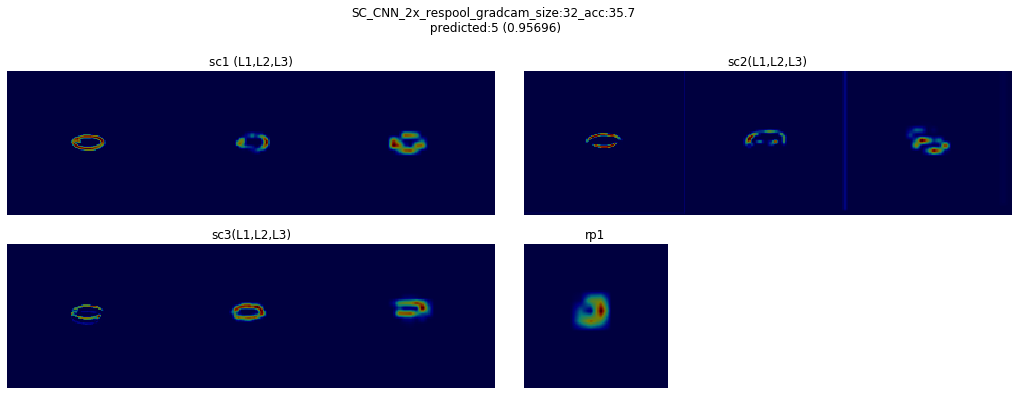


 29%|██▊       | 32/112 [01:33<03:47,  2.85s/it]

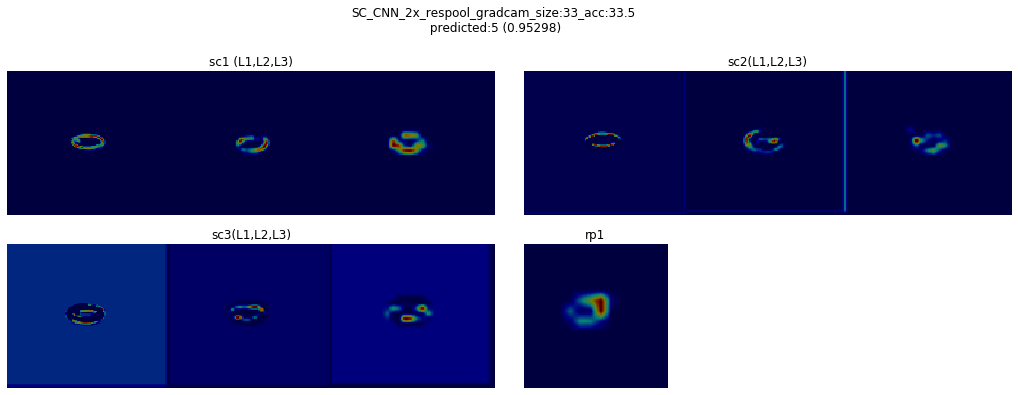


 29%|██▉       | 33/112 [01:36<03:47,  2.88s/it]

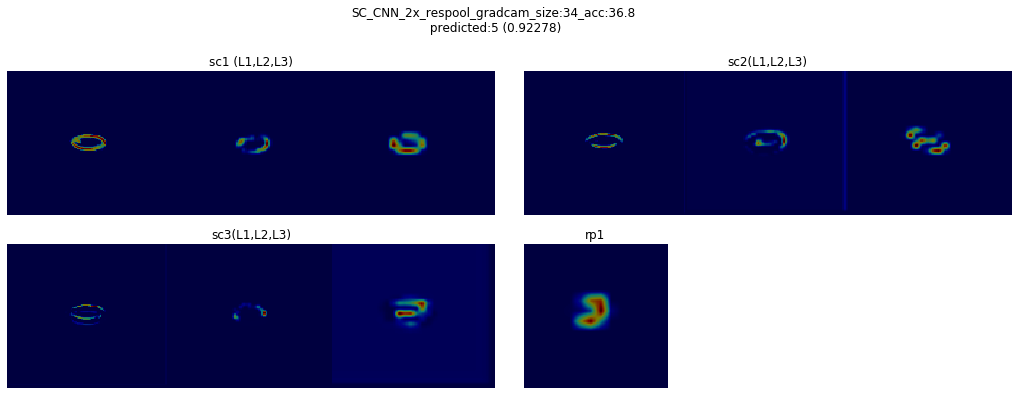


 30%|███       | 34/112 [01:39<03:47,  2.92s/it]

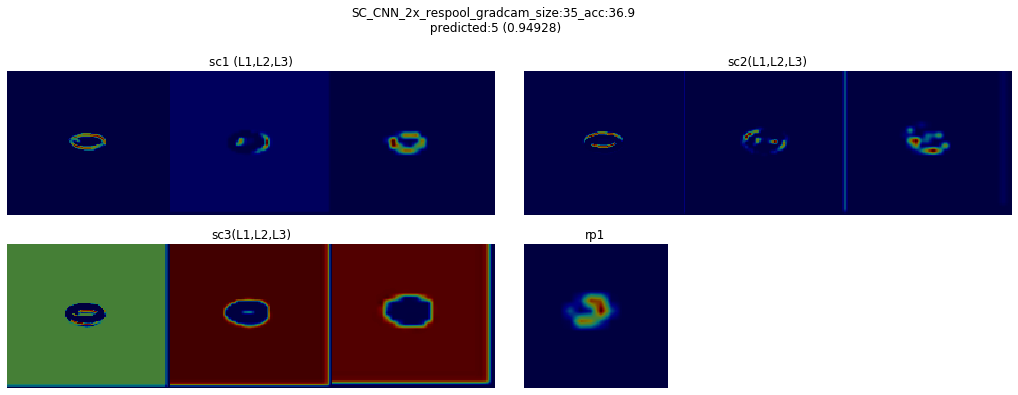


 31%|███▏      | 35/112 [01:42<03:49,  2.98s/it]

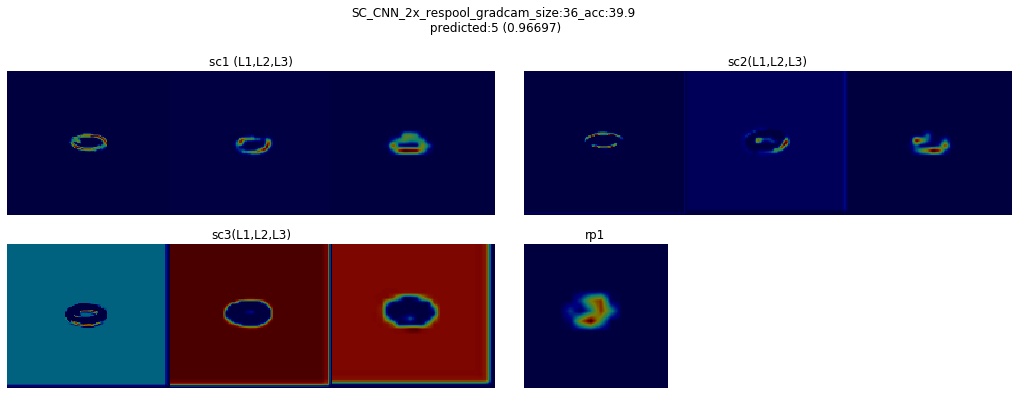


 32%|███▏      | 36/112 [01:45<03:42,  2.93s/it]

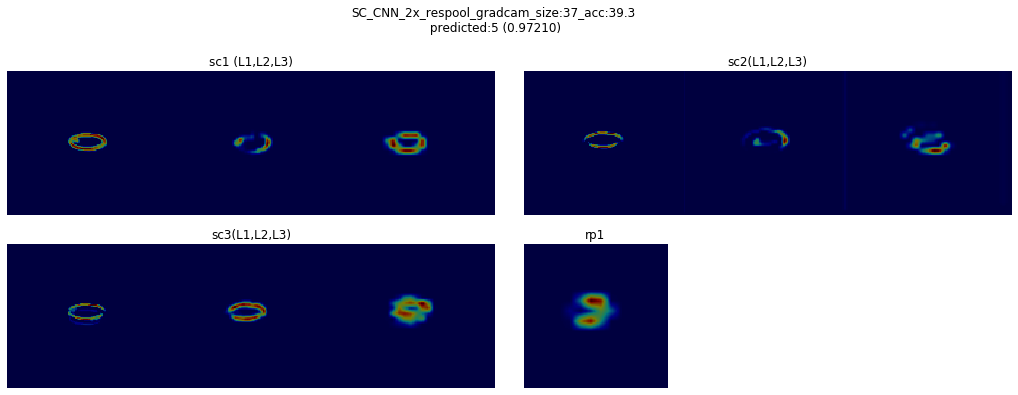


 33%|███▎      | 37/112 [01:48<03:37,  2.91s/it]

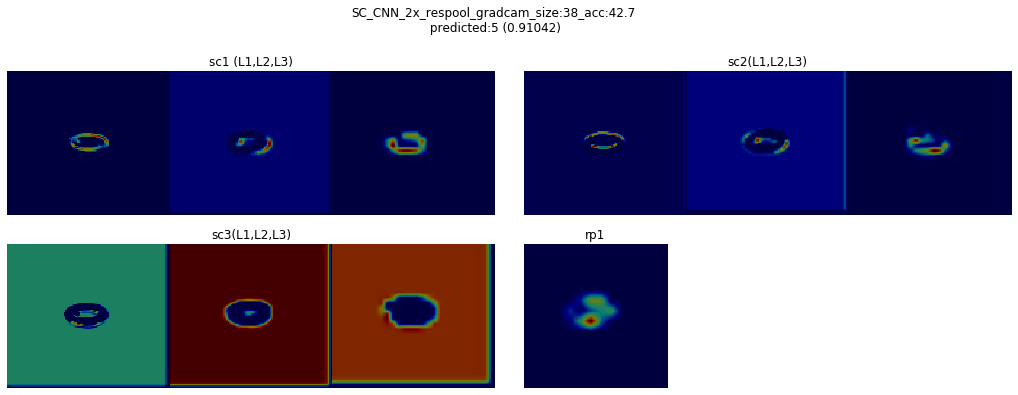


 34%|███▍      | 38/112 [01:51<03:32,  2.87s/it]

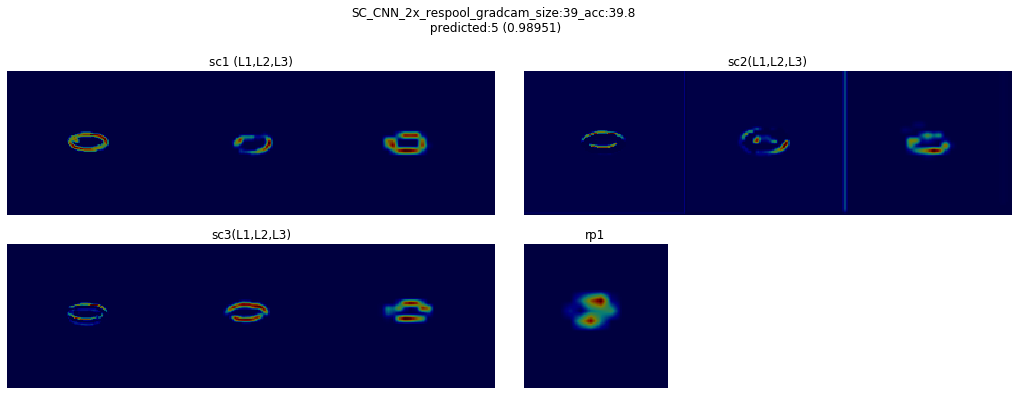


 35%|███▍      | 39/112 [01:54<03:29,  2.87s/it]

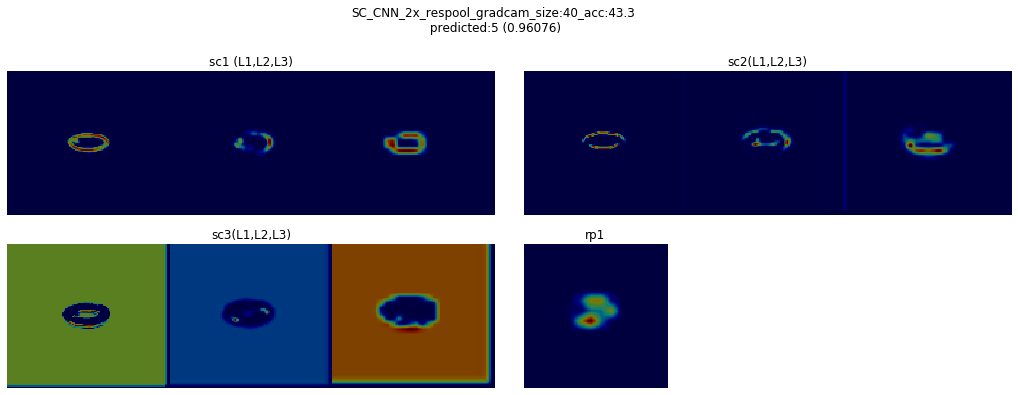


 36%|███▌      | 40/112 [01:57<03:29,  2.90s/it]

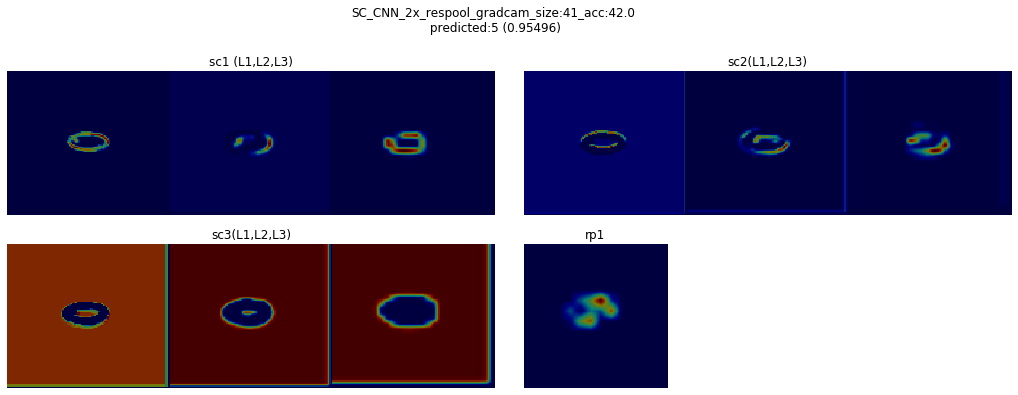


 37%|███▋      | 41/112 [02:00<03:26,  2.91s/it]

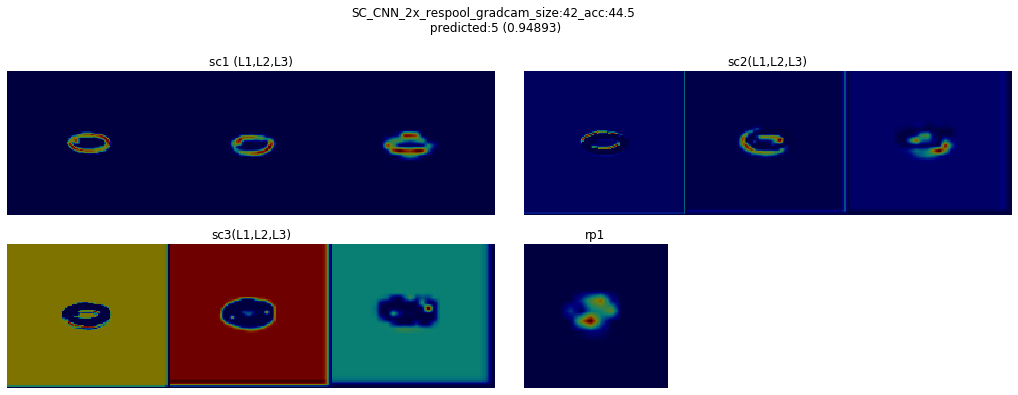


 38%|███▊      | 42/112 [02:03<03:24,  2.92s/it]

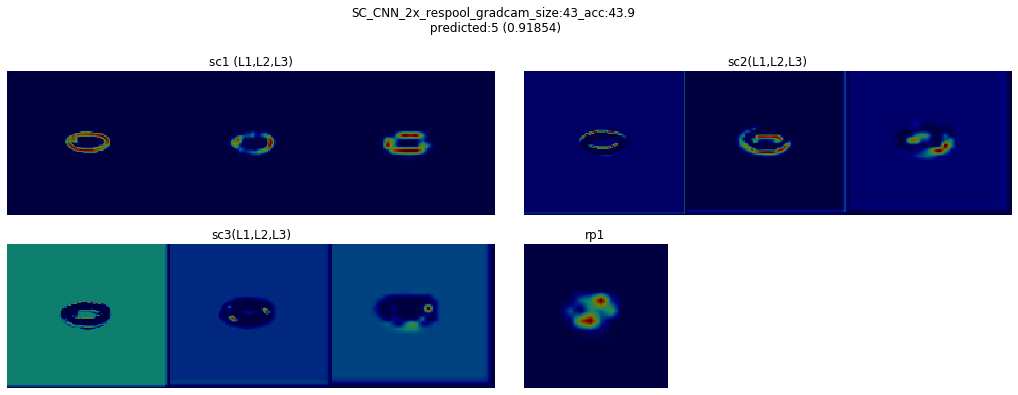


 38%|███▊      | 43/112 [02:05<03:21,  2.92s/it]

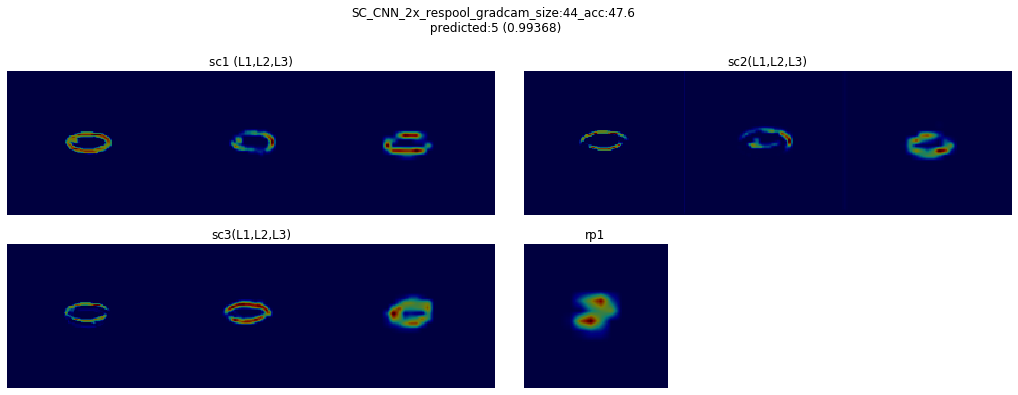


 39%|███▉      | 44/112 [02:08<03:17,  2.91s/it]

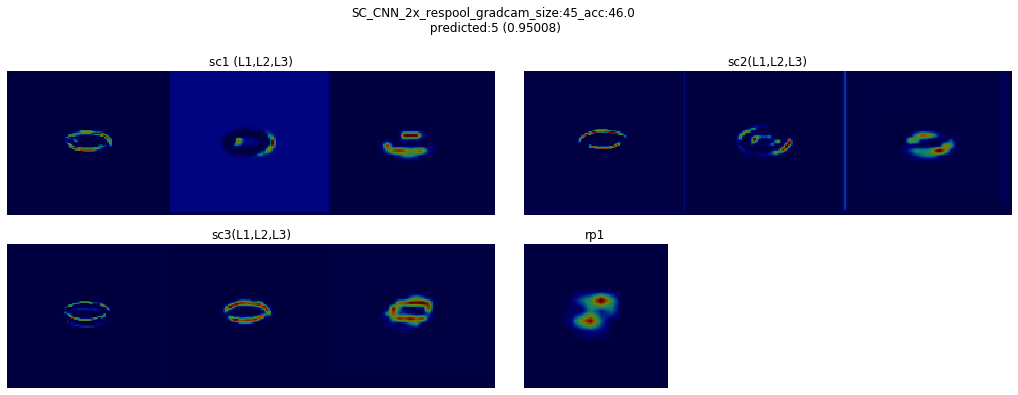


 40%|████      | 45/112 [02:11<03:15,  2.91s/it]

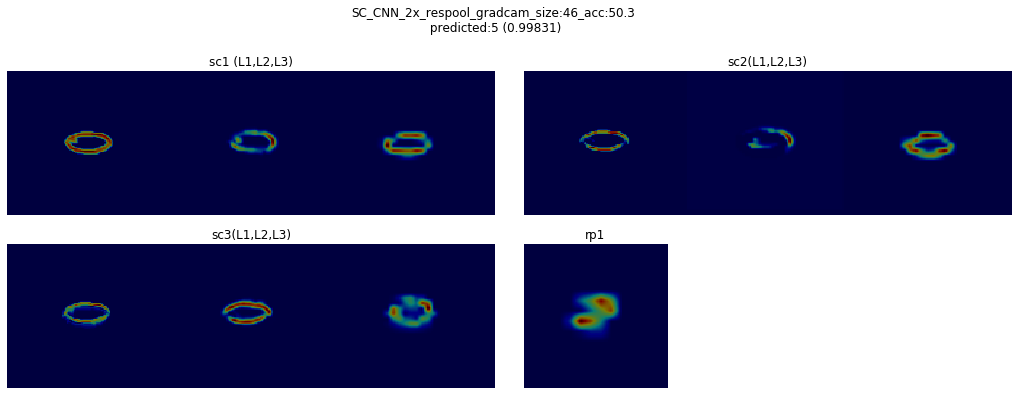


 41%|████      | 46/112 [02:15<03:21,  3.06s/it]

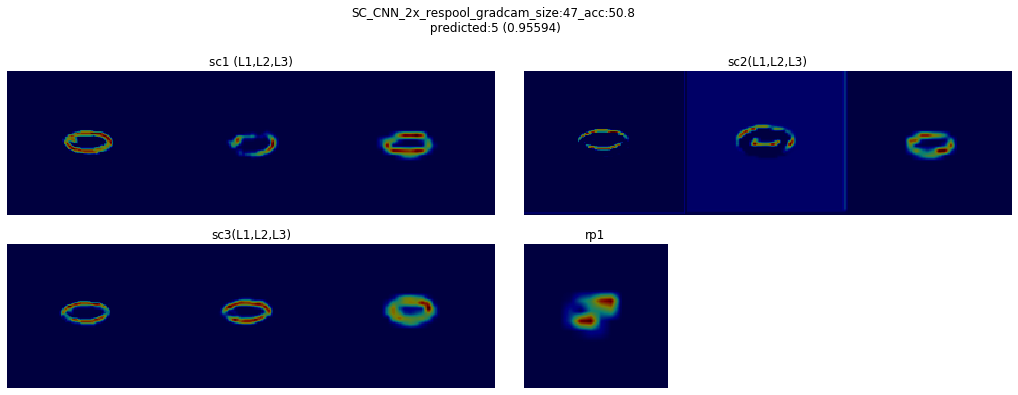


 42%|████▏     | 47/112 [02:18<03:15,  3.00s/it]

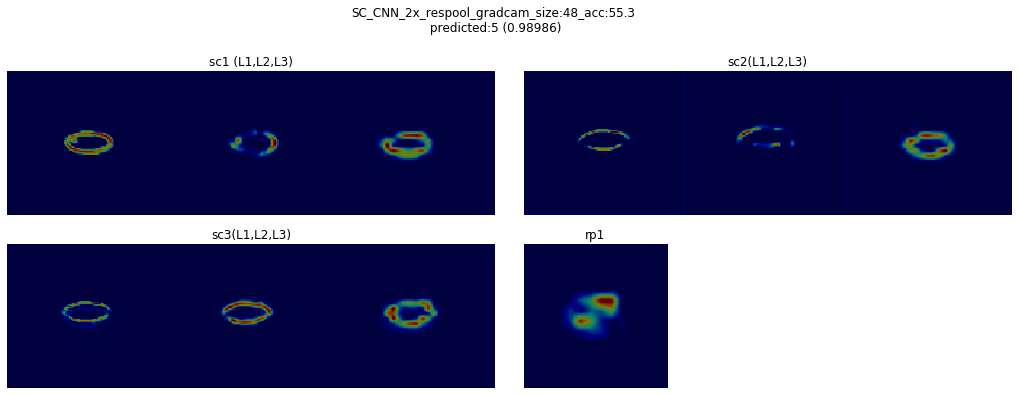


 43%|████▎     | 48/112 [02:20<03:09,  2.96s/it]

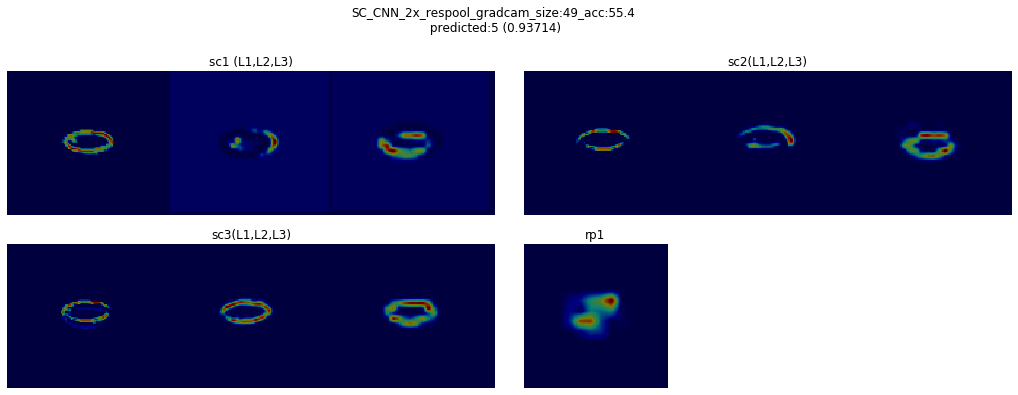


 44%|████▍     | 49/112 [02:23<03:05,  2.95s/it]

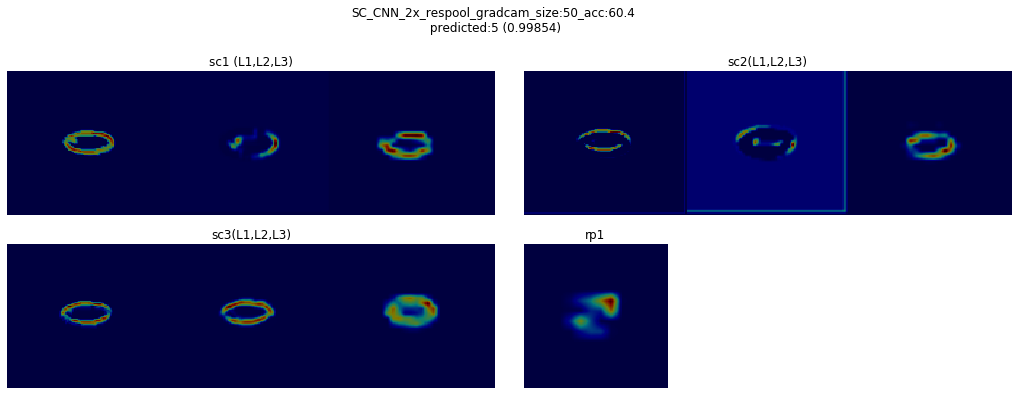


 45%|████▍     | 50/112 [02:26<03:02,  2.94s/it]

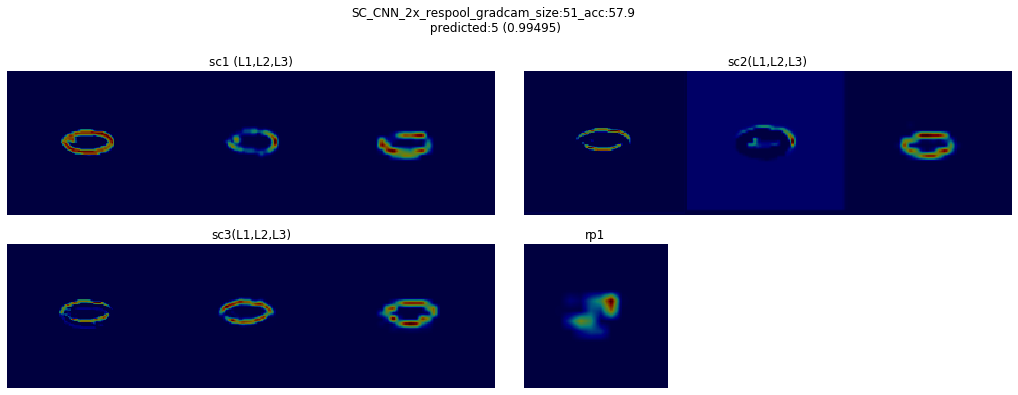


 46%|████▌     | 51/112 [02:29<03:00,  2.96s/it]

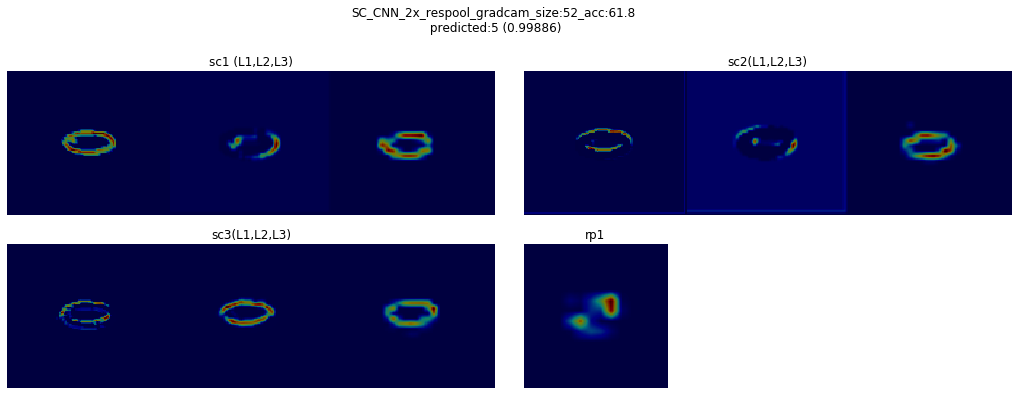


 46%|████▋     | 52/112 [02:32<02:56,  2.94s/it]

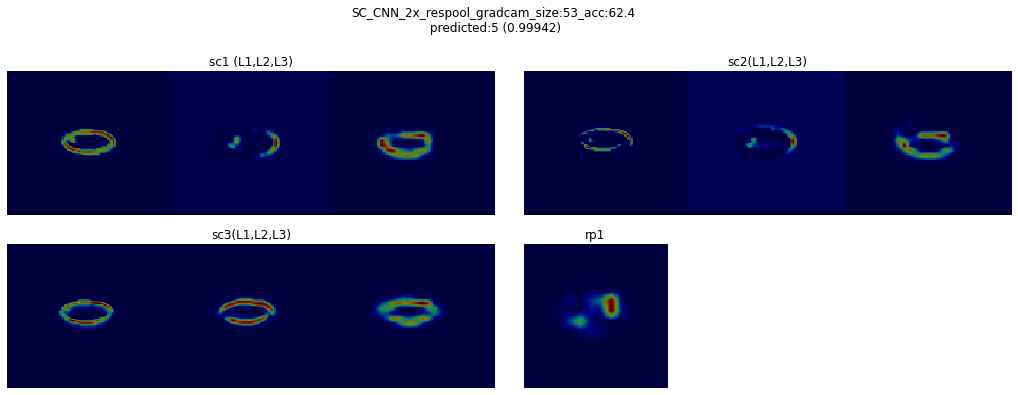


 47%|████▋     | 53/112 [02:35<02:52,  2.93s/it]

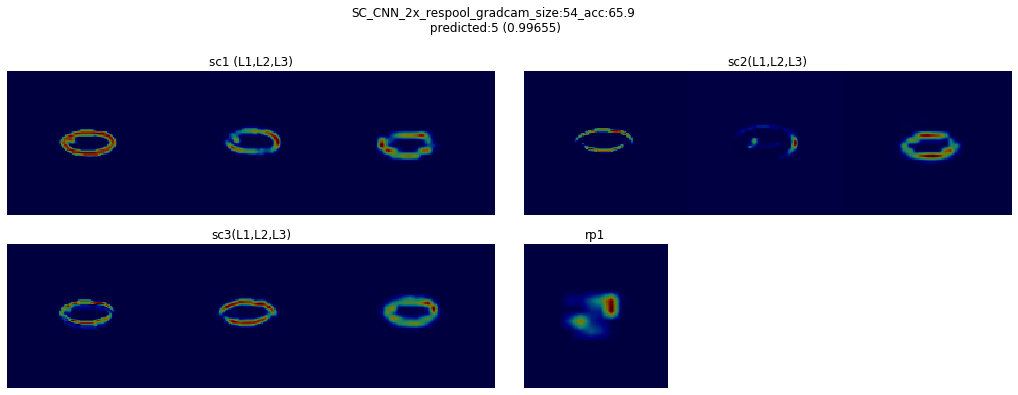


 48%|████▊     | 54/112 [02:38<02:49,  2.92s/it]

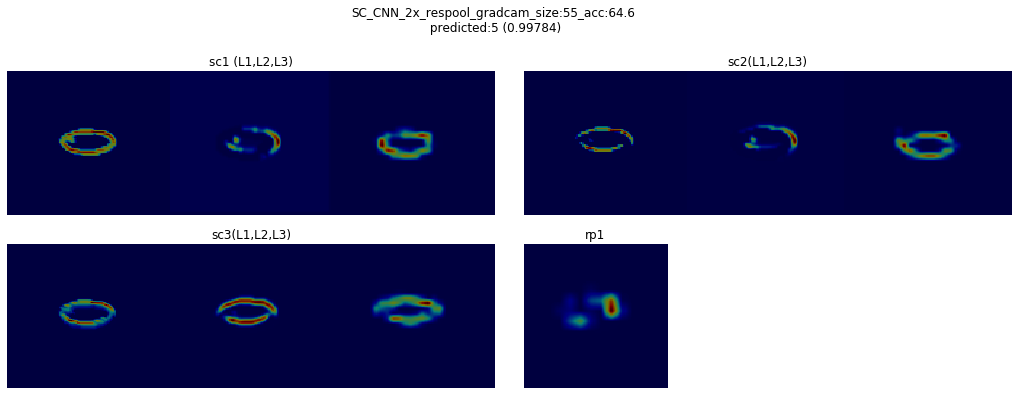


 49%|████▉     | 55/112 [02:41<02:46,  2.92s/it]

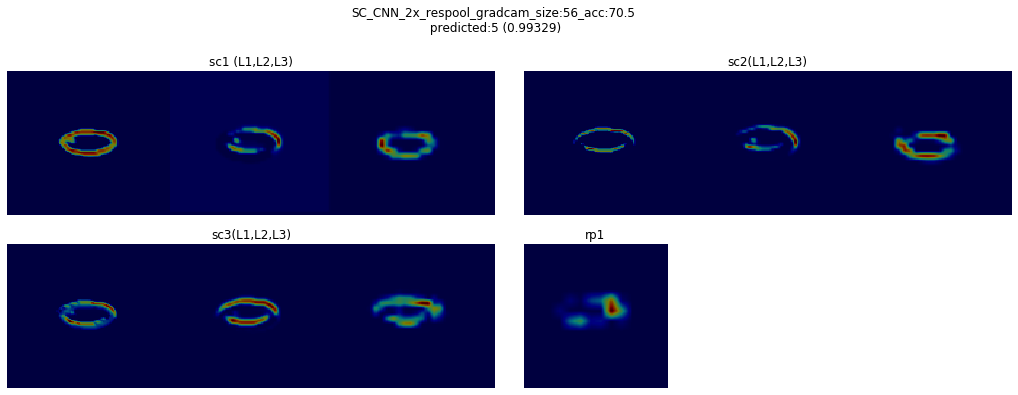


 50%|█████     | 56/112 [02:44<02:43,  2.91s/it]

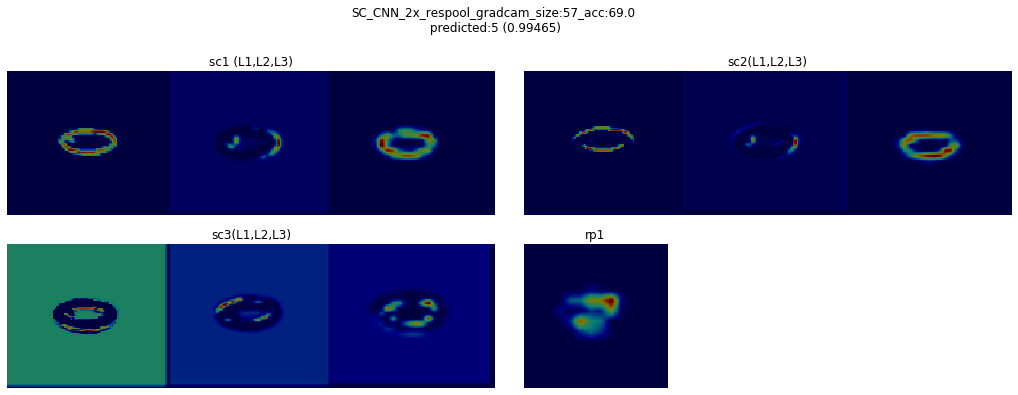


 51%|█████     | 57/112 [02:48<02:55,  3.19s/it]

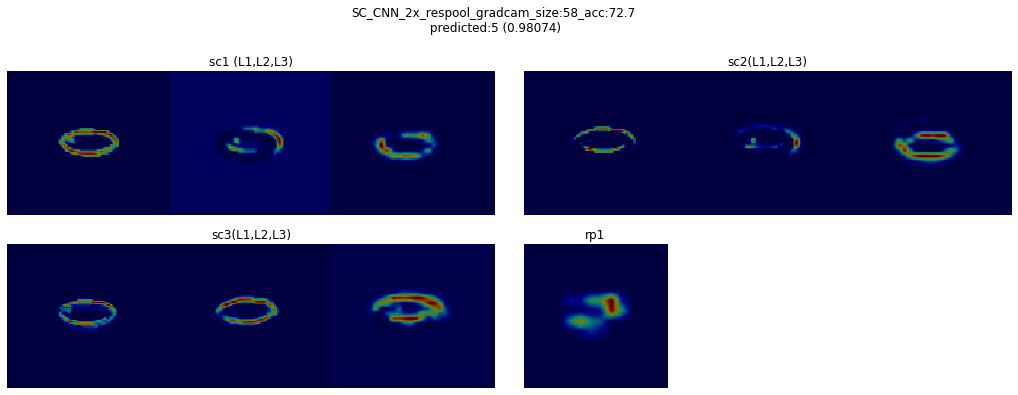


 52%|█████▏    | 58/112 [02:50<02:46,  3.09s/it]

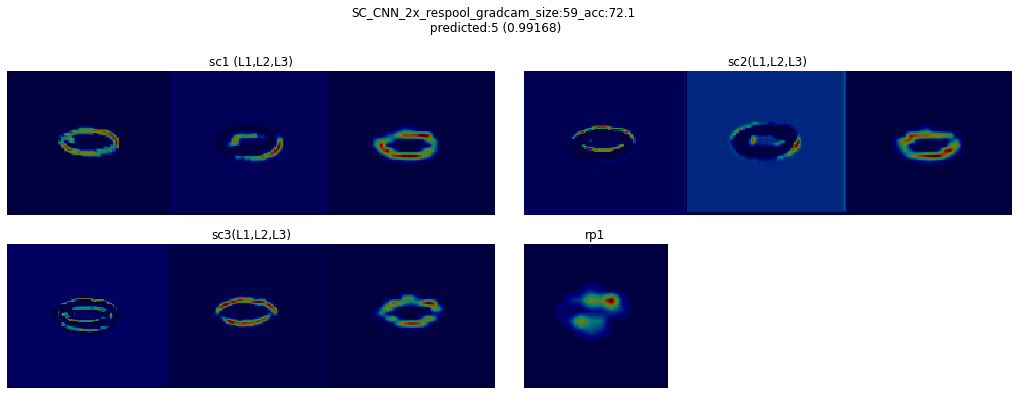


 53%|█████▎    | 59/112 [02:53<02:41,  3.04s/it]

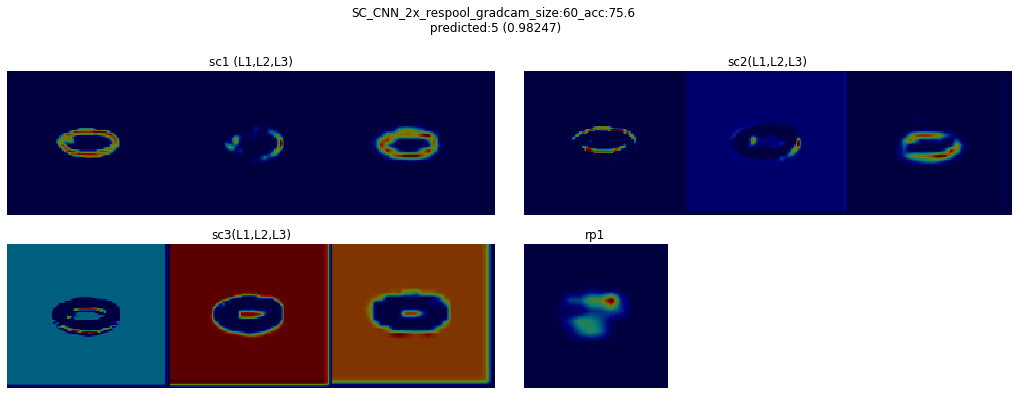


 54%|█████▎    | 60/112 [02:56<02:35,  2.99s/it]

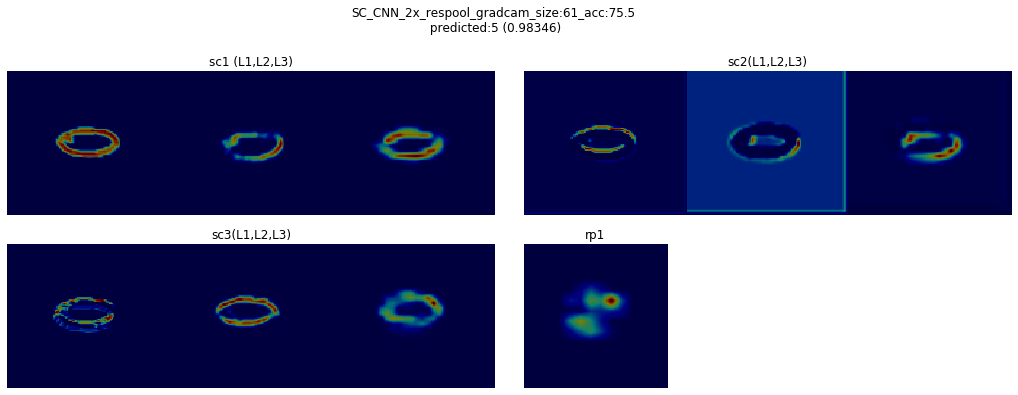


 54%|█████▍    | 61/112 [02:59<02:30,  2.95s/it]

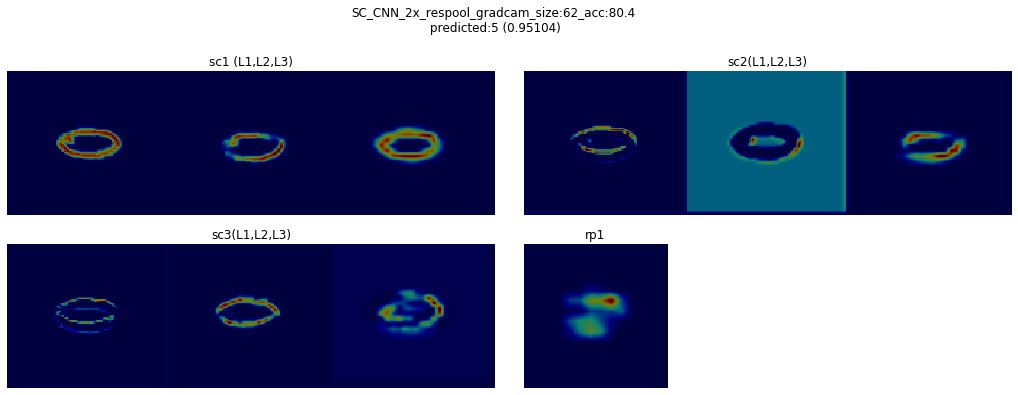


 55%|█████▌    | 62/112 [03:02<02:27,  2.95s/it]

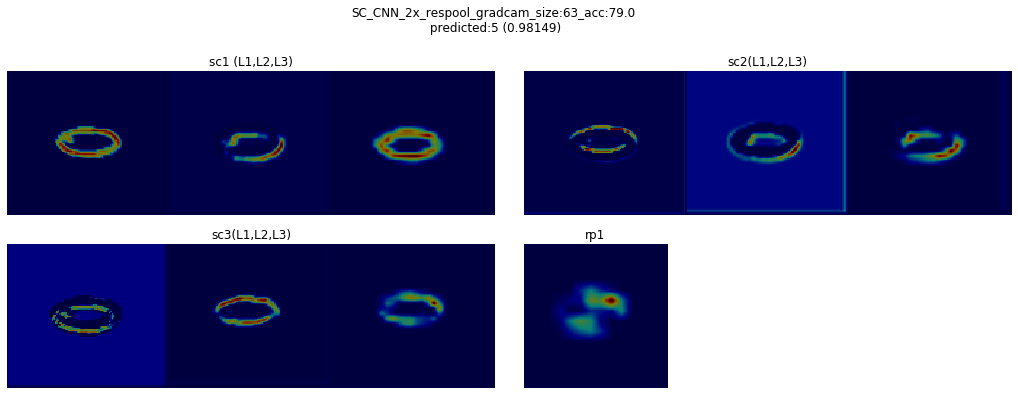


 56%|█████▋    | 63/112 [03:05<02:23,  2.92s/it]

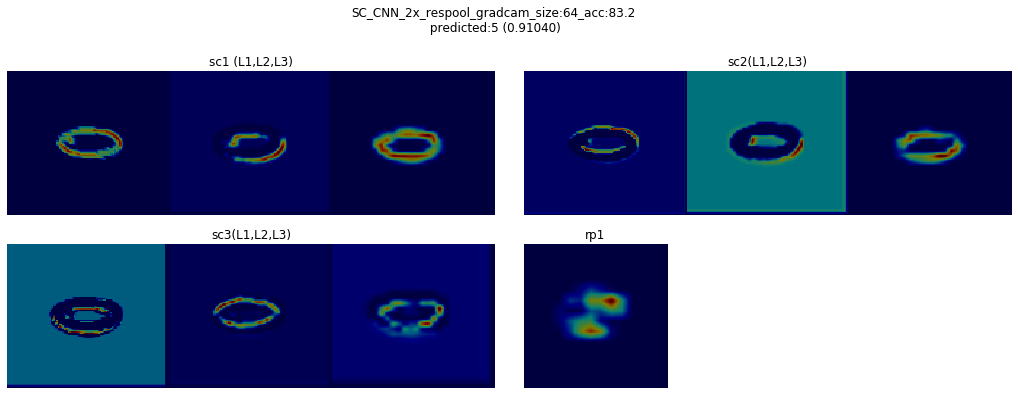


 57%|█████▋    | 64/112 [03:08<02:19,  2.91s/it]

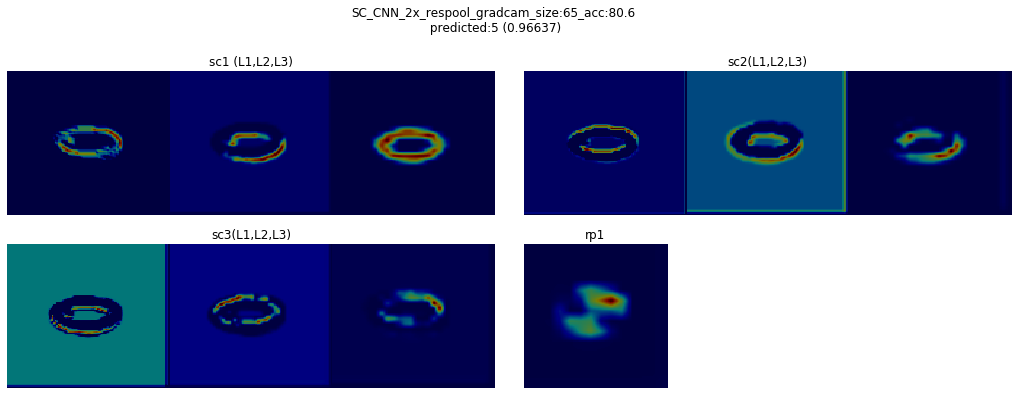


 58%|█████▊    | 65/112 [03:11<02:16,  2.90s/it]

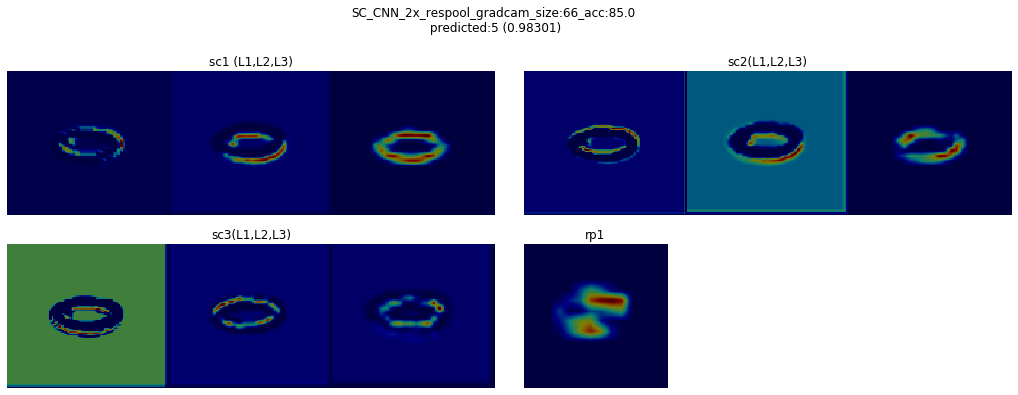


 59%|█████▉    | 66/112 [03:14<02:13,  2.90s/it]

In [ ]:
from matplotlib import gridspec

gridspec.GridSpec(3,6)

imsize = 1
for testloader in tqdm(gradcam_gen_arr):
    for images in testloader:
        v1 = images[0].to(device)
        val_labels = images[1].to(device)
        break

    _ = gcam.forward(v1)
    probs,ids = gbp.forward(v1)

    gcam.backward(ids=ids[:,[0]])
    gbp.backward(ids=ids[:,[0]])

    grad_img = []

    for j in range(len(v1)):
        grad_img.append([])
        for name, module in model1.named_modules():
            #print(name)
            if name == '' or name == 'module' or name == 'module.fc1' or name == 'module.fc2' or name == 'module.fc3' or name == 'module.prepool1' or name == 'module.prepool2':
                continue
            regions = gcam.generate(target_layer=name)
            gradients = gbp.generate()
            #print("\t#{}: {} ({:.5f})".format(j, ids[j, 0], probs[j, 0]))
            #print(regions[j,0])
            if name == 'module.sc1' or name == 'module.sc2' or name == 'module.sc3':
                grad_img[j].append(show_gradcam(gcam=regions[0][j,0],raw_image=imshow(v1[j].cpu()),show=False))
                grad_img[j].append(show_gradcam(gcam=regions[1][j,0],raw_image=imshow(v1[j].cpu()),show=False))
                grad_img[j].append(show_gradcam(gcam=regions[2][j,0],raw_image=imshow(v1[j].cpu()),show=False))
            if name == 'module.rp1':
                grad_img[j].append(show_gradcam(gcam=regions[j,0],raw_image=imshow(v1[j].cpu()),show=False))

    img_num = [0,1,2,3,4,5,15,16,17,18,19,20,31,32,33,34]
    col_num = [3,3,3,1]
    title = ['sc1 (L1,L2,L3)','sc2(L1,L2,L3)','sc3(L1,L2,L3)','rp1']
    size = 112
    
    scale = 3./size
    plt.figure(figsize=(18,9))
    plt.suptitle('SC_CNN_2x_respool_gradcam'+'_size:'+str(imsize)+'_acc:'+str(temp_acc[imsize-1])+'\n predicted:{} ({:.5f})'.format(ids[0, 0], probs[0, 0]))
    num = 0
    for i in range(len(col_num)):
        display_grid = np.zeros((112,112*col_num[i],3)).astype(np.uint8)
        for row in range(col_num[i]):
            display_grid[:size,row*size : (row+1)*size,:3] = grad_img[0][num]
            num = num+1
        if i == 3:
            plt.subplot2grid((3,6), (i//2,(i%2)*3),colspan = 1,rowspan=1)
        else:
            plt.subplot2grid((3,6), (i//2,(i%2)*3),colspan = 3,rowspan=1)
        plt.axis('off')
        plt.title(title[i])
        plt.grid(False)
        plt.imshow(display_grid,aspect='auto')
    plt.savefig('gradcam_2x_respool/pltgrad'+str(imsize)+'.png')
    plt.show()
    imsize = imsize+1

In [46]:
v1.size()

torch.Size([3, 3, 243, 243])

In [ ]:
frame_array = []
for i in range(1,113):
    filename='gradcam_2x/pltgrad' + str(i)+'.png'
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)
    
out = cv2.VideoWriter('gradcam_2x_respool/gradcam_ordered_feb13.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 5, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

In [43]:
for i in gcam.fmap_pool.keys():
    print(i)

module.prepool1
module.prepool2
module.sc1.conv3
module.sc1.conv2
module.sc1.conv1
module.sc1.bn1_1
module.sc1.bn2_1
module.sc1.bn3_1
module.sc1.pad
module.sc1_1
module.sc1_2
module.sc1_3
module.sc2.conv3
module.sc2.conv2
module.sc2.conv1
module.sc2.bn1_1
module.sc2.bn2_1
module.sc2.bn3_1
module.sc2.pad
module.sc2_1
module.sc2_2
module.sc2_3
module.sc3.conv3
module.sc3.conv2
module.sc3.conv1
module.sc3.bn1_1
module.sc3.bn2_1
module.sc3.bn3_1
module.sc3.pad
module.sc3_1
module.sc3_2
module.sc3_3
module.rp1.bigpool
module.rp1.midpool
module.rp1.smlpool
module.rp1.bn4
module.rp1
module.fc1
module.fc2
module.fc3
module



In [ ]:
num=0

#plt.figure(figsize=(12,5))
plt.matshow([gcam.fmap_pool['module.fc1'].cpu().numpy()[num]])
plt.matshow([gcam.fmap_pool['module.fc2'].cpu().numpy()[num]])
plt.matshow([gcam.fmap_pool['module.fc3'].cpu().numpy()[num]])

plt.show()

In [ ]:
i=0
print(gcam.fmap_pool['module.prepool1'].cpu().numpy()[0][i].var())
plt.imshow(gcam.fmap_pool['module.prepool2'].cpu().numpy()[0][i])
plt.show()

In [ ]:
gcam.fmap_pool['module.sc1_1'].cpu().numpy()[0][0]

In [ ]:
num = 1
#print(gcam.fmap_pool['module.sc1_1'].cpu().numpy()[0][num])
plt.figure(figsize=(16,12))
for i in range(6):
    plt.subplot(3,6,i+1)
    plt.imshow(gcam.fmap_pool['module.sc1_1'].cpu().numpy()[0][i])
for i in range(6):
    plt.subplot(3,6,i+1+6)
    plt.imshow(gcam.fmap_pool['module.sc1_2'].cpu().numpy()[0][i])
for i in range(6):
    plt.subplot(3,6,i+1+12)
    plt.imshow(gcam.fmap_pool['module.sc1_3'].cpu().numpy()[0][i])
plt.show()

In [ ]:
num = 1
#print(gcam.fmap_pool['module.sc1_1'].cpu().numpy()[0][num])
plt.figure(figsize=(16,5))
for i in range(18):
    plt.subplot(3,18,i+1)
    plt.imshow(gcam.fmap_pool['module.sc2_1'].cpu().numpy()[0][i])
for i in range(18):
    plt.subplot(3,18,i+1+18)
    plt.imshow(gcam.fmap_pool['module.sc2_2'].cpu().numpy()[0][i])
for i in range(18):
    plt.subplot(3,18,i+1+36)
    plt.imshow(gcam.fmap_pool['module.sc2_3'].cpu().numpy()[0][i])
plt.show()

In [ ]:
num = 1
#print(gcam.fmap_pool['module.sc1_1'].cpu().numpy()[0][num])
plt.figure(figsize=(16,5))
for i in range(30):
    plt.subplot(3,30,i+1)
    plt.imshow(gcam.fmap_pool['module.sc3_1'].cpu().numpy()[0][i])
for i in range(30):
    plt.subplot(3,30,i+1+30)
    plt.imshow(gcam.fmap_pool['module.sc3_2'].cpu().numpy()[0][i])
for i in range(30):
    plt.subplot(3,30,i+1+60)
    plt.imshow(gcam.fmap_pool['module.sc3_3'].cpu().numpy()[0][i])
plt.show()

In [ ]:
num = 1
#print(gcam.fmap_pool['module.sc1_1'].cpu().numpy()[0][num])
plt.figure(figsize=(16,5))
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.imshow(gcam.fmap_pool['module.rp1'].cpu().numpy()[0][i])
plt.show()

In [ ]:
gcam.fmap_pool['module.sc1_1'].cpu().numpy().shape

In [ ]:
num = 1
conv_list = ['module.sc1.conv1','module.sc1.conv2','module.sc1.conv3']
conv_num = 0
#print(gcam.fmap_pool[conv_list[conv_num]].cpu().numpy()[0][num])
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(gcam.fmap_pool[conv_list[conv_num]].cpu().numpy()[0][i])
plt.show()

In [ ]:
num = 1
conv_list = ['module.sc1.conv1','module.sc1.conv2','module.sc1.conv3']
conv_num = 1
#print(gcam.fmap_pool[conv_list[conv_num]].cpu().numpy()[0][num])
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(gcam.fmap_pool[conv_list[conv_num]].cpu().numpy()[0][i])
plt.show()

In [ ]:
num = 1
conv_list = ['module.sc1.conv1','module.sc1.conv2','module.sc1.conv3']
conv_num = 2
#print(gcam.fmap_pool[conv_list[conv_num]].cpu().numpy()[0][num])
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(gcam.fmap_pool[conv_list[conv_num]].cpu().numpy()[0][i])
plt.show()

In [ ]:
model1.module.sc1.conv1.weight.shape

In [ ]:
for i in range(3):
    print(model1.module.sc1.conv1.weight[0][i].cpu().detach().numpy())
    plt.imshow(model1.module.sc1.conv1.weight[0][i].cpu().detach().numpy())#.shape
    plt.show()

In [ ]:
for i in range(3):
    print(model1.module.sc1.conv2.weight[0][i].cpu().detach().numpy())
    plt.imshow(model1.module.sc1.conv2.weight[0][i].cpu().detach().numpy())#.shape
    plt.show()

In [ ]:
for i in range(3):
    print(model1.module.sc1.conv3.weight[0][i].cpu().detach().numpy())
    plt.imshow(model1.module.sc1.conv3.weight[0][i].cpu().detach().numpy())#.shape
    plt.show()